In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import operator
import datetime

In [113]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [114]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [115]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [116]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())

In [117]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Date']=pd.to_datetime(test['Date'])

test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [118]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


In [119]:
# 如果open特征为0可以直接提交预测为0
test["Open"].value_counts()

1    35104
0     5984
Name: Open, dtype: int64

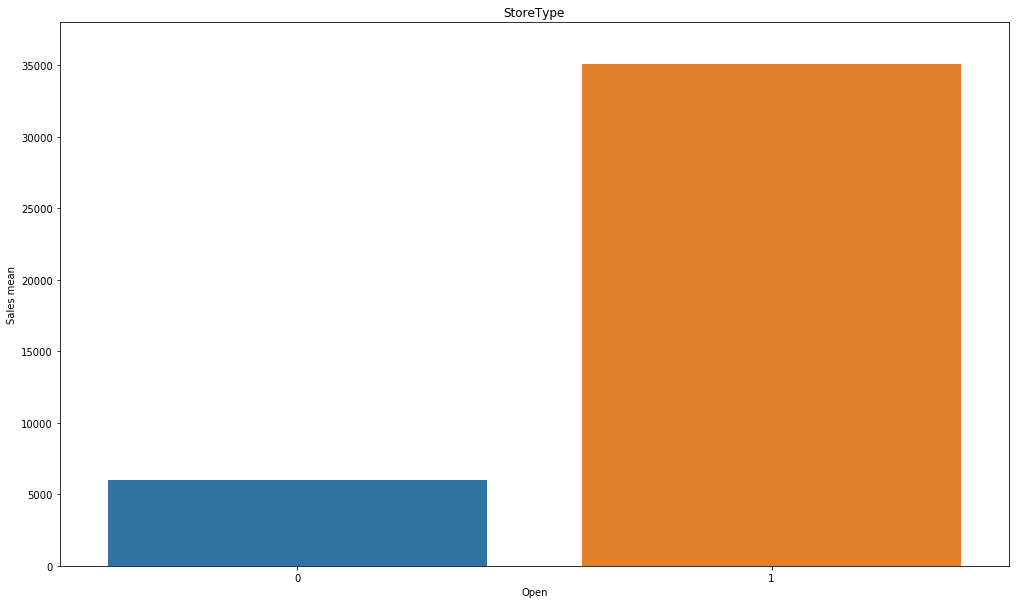

In [120]:
# 对open做可视化
po = test.groupby('Open')['Id'].count()
plt.subplots(1,1,figsize=(17,10))  
plt.ylim(ymin=0)  
plt.ylim(ymax=38000)  
plt.title('StoreType')  
plt.ylabel('Sales mean')  
sns.barplot(po.index,po.values)
plt.show()

#### 整理store数据

In [121]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [122]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879

     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


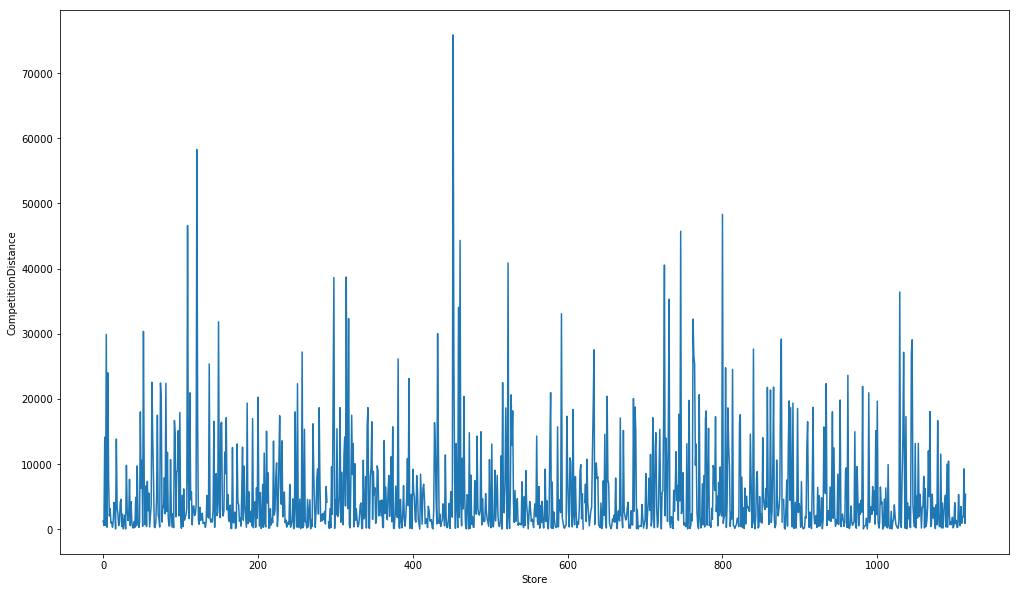

In [123]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.subplots(1,1,figsize=(17,10))  
plt.plot(store['CompetitionDistance'])
plt.xlabel('Store')
plt.ylabel('CompetitionDistance')
plt.show()


In [124]:
store['CompetitionDistance'].describe()

count    1112.000
mean     5404.901
std      7663.175
min        20.000
25%       717.500
50%      2325.000
75%      6882.500
max     75860.000
Name: CompetitionDistance, dtype: float64

In [125]:
#根据情况将291，622，879的CompetitionDistance距离改为99999并转化为int型，将其CompetitionOpenSinceYear特征改为一个未来值
store['CompetitionDistance']=store['CompetitionDistance'].fillna(99999)
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
# store.query('Store in (291,622,879)')['CompetitionOpenSinceYear']=2030
store.loc[(store['Store']==291)|(store['Store']==622)|(store['Store']==879),'CompetitionOpenSinceYear']=2030

In [126]:
# 设置距离超过20km的CompetitionOpenSinceYear为2030
store.loc[store['CompetitionDistance']>30000,'CompetitionOpenSinceYear']=2030

In [127]:
# CompetitionOpenSinceMonth和CompetitionOpenSinceYear的缺失值
# 判断是否缺失的商店是同一个，输出同时为NaN的商店个数
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))

349


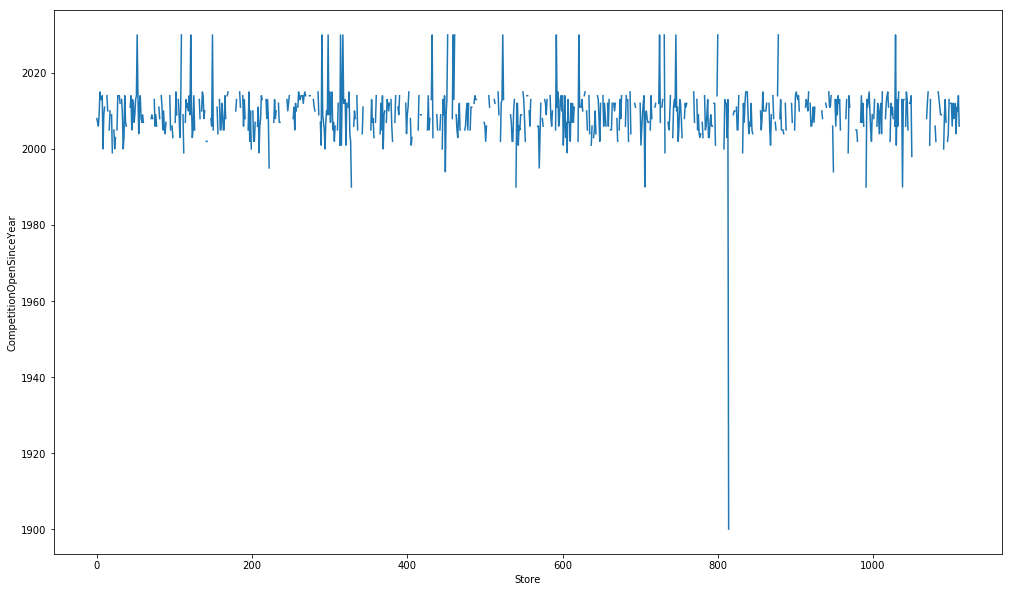

In [128]:
# 可视化CompetitionOpenSinceYear
# store['CompetitionOpenSinceYear'].describe()
plt.subplots(1,1,figsize=(17,10))  
plt.plot(store['CompetitionOpenSinceYear'])
plt.xlabel('Store')
plt.ylabel('CompetitionOpenSinceYear')
plt.show()

In [129]:
store['CompetitionOpenSinceYear'].describe()

count    766.000
mean    2009.242
std        7.115
min     1900.000
25%     2006.000
50%     2010.000
75%     2013.000
max     2030.000
Name: CompetitionOpenSinceYear, dtype: float64

In [130]:
# 1115-354=761所以均为同时为Nan，那就设置为一个较早的时间，认为是早已经开业的商店,并设置为int型
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(2010)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median())
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

In [131]:
# Promo2SinceWeek,Promo2SinceYear,PromoInterval的缺失值
# 确认他们缺失的是否是相同的store
nan = np.nan
print(len(store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')))

544


In [132]:
# 1115-544=571,571符合这三个特征的缺失数，得出结论就是这三个特征是同时缺失的，看看此时的Promo2的值是多少
store.query('Promo2SinceWeek=="NaN"&Promo2SinceYear=="NaN"&PromoInterval.isnull()')['Promo2'].value_counts()

0    544
Name: Promo2, dtype: int64

In [133]:
# 查看0的总总数量和Promo2SinceWeek,Promo2SinceYear,PromoInterval缺失值保持一致
store['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [134]:
# 将Promo2SinceYear设置为一个未来的时间，Promo2SinceWeek设置为1
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(2030)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

In [135]:
#处理PromoInterval,
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'0,3,6,9','Feb,May,Aug,Nov':'1,4,7,10','Mar,Jun,Sept,Dec':'2,5,8,11'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,2030,"0,0,0,0"
1,2,a,a,570,11,2007,1,13,2010,"0,3,6,9"
2,3,a,a,14130,12,2006,1,14,2011,"0,3,6,9"
3,4,c,c,620,9,2009,0,0,2030,"0,0,0,0"
4,5,a,a,29910,4,2015,0,0,2030,"0,0,0,0"


In [136]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval                1115 non-null object
dtypes: int32(5), int64(2), object(3)
memory usage: 65.4+ KB


In [137]:
print(store['PromoInterval'].value_counts())

0,0,0,0     544
0,3,6,9     335
1,4,7,10    130
2,5,8,11    106
Name: PromoInterval, dtype: int64


In [138]:
# 将PromoInterval展开
PromoInterval1=[]
PromoInterval2=[]
PromoInterval3=[]
PromoInterval4=[]
m=store['PromoInterval']
for x in m:
    y=x.split(',')
    PromoInterval1.append(y[0])
    PromoInterval2.append(y[1])
    PromoInterval3.append(y[2])
    PromoInterval4.append(y[3])

store['PromoInterval1']=pd.Series(PromoInterval1,dtype='int32')
store['PromoInterval2']=pd.Series(PromoInterval2,dtype='int32')
store['PromoInterval3']=pd.Series(PromoInterval3,dtype='int32')
store['PromoInterval4']=pd.Series(PromoInterval4,dtype='int32')
store.drop('PromoInterval',axis=1, inplace=True)

In [139]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [140]:
#针对Assortment，StoreType特征做one-hot
store= pd.concat([store,pd.get_dummies(store['Assortment'],prefix='Assortment')], axis=1)
store.drop('Assortment',axis=1, inplace=True)
store= pd.concat([store,pd.get_dummies(store['StoreType'],prefix='StoreType')], axis=1)
store.drop('StoreType',axis=1, inplace=True)
store.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,PromoInterval4,Assortment_1,Assortment_2,Assortment_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4
0,1,1270,9,2008,0,0,2030,0,0,0,0,1,0,0,0,0,1,0
1,2,570,11,2007,1,13,2010,0,3,6,9,1,0,0,1,0,0,0
2,3,14130,12,2006,1,14,2011,0,3,6,9,1,0,0,1,0,0,0
3,4,620,9,2009,0,0,2030,0,0,0,0,0,0,1,0,0,1,0
4,5,29910,4,2015,0,0,2030,0,0,0,0,1,0,0,1,0,0,0


In [141]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 18 columns):
Store                        1115 non-null int64
CompetitionDistance          1115 non-null int32
CompetitionOpenSinceMonth    1115 non-null int32
CompetitionOpenSinceYear     1115 non-null int32
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int32
Promo2SinceYear              1115 non-null int32
PromoInterval1               1115 non-null int32
PromoInterval2               1115 non-null int32
PromoInterval3               1115 non-null int32
PromoInterval4               1115 non-null int32
Assortment_1                 1115 non-null uint8
Assortment_2                 1115 non-null uint8
Assortment_3                 1115 non-null uint8
StoreType_1                  1115 non-null uint8
StoreType_2                  1115 non-null uint8
StoreType_3                  1115 non-null uint8
StoreType_4                  1115 non-null uint8
dtypes: int

#### 整理train数据

In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


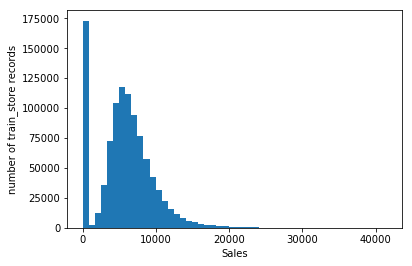

In [143]:
# 对最重要的Sales做可视化
plt.hist(train['Sales'], bins=50)  
plt.xlabel('Sales')  
plt.ylabel('number of train_store records')  
plt.show()

In [144]:
# 查看open为0的数据的Sales和Customers
print(train.query('Open=="0"')['Sales'].value_counts())
print(train.query('Open=="0"')['Customers'].value_counts())

0    172817
Name: Sales, dtype: int64
0    172817
Name: Customers, dtype: int64


In [145]:
#可以认为open为0对于训练没有什么帮助所以我们只训练open==1的
len(train.query('Open==1'))

844392

In [146]:
# 844392+172817=1017209 所以open==1作为训练对象
train=train.query('Open==1')

In [147]:
# 按照test的方式处理Data
train['Date']=pd.to_datetime(train['Date'])

train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Day']=train['Date'].dt.day
train['WeekOfYear']=train['Date'].dt.weekofyear
train['DayOfWeek']=train['Date'].dt.dayofweek
train.drop('Date',axis=1, inplace=True)

In [148]:
#设置StateHoliday a:1,b:2,c:3
train.loc[train["StateHoliday"]=='a','StateHoliday']=1
train.loc[train["StateHoliday"]=='b','StateHoliday']=2
train.loc[train["StateHoliday"]=='c','StateHoliday']=3
train['StateHoliday']=train['StateHoliday'].astype(int)

In [149]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None


#### 合并数据

In [150]:
#合并test，先把test里open为0的数据提出来直接输出sales=0
result_0=pd.DataFrame({"Id": test.query('Open==0')['Id'], 'Sales':0})
result_0.head()

,Id,Sales
543,544,0
676,677,0
840,841,0
1399,1400,0
1532,1533,0


In [151]:
len(test.query('Open==1'))

35104

In [152]:
# 对于剩下test来跑predict再合并
test_data = pd.merge(test.query('Open==1'), store, on='Store')

In [153]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 35103
Data columns (total 28 columns):
Id                           35104 non-null int64
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-nu

In [154]:
print(train.info())
train_data = pd.merge(train, store, on='Store')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 12 columns):
Store            844392 non-null int64
DayOfWeek        844392 non-null int64
Sales            844392 non-null int64
Customers        844392 non-null int64
Open             844392 non-null int64
Promo            844392 non-null int64
StateHoliday     844392 non-null int32
SchoolHoliday    844392 non-null int64
Year             844392 non-null int64
Month            844392 non-null int64
Day              844392 non-null int64
WeekOfYear       844392 non-null int64
dtypes: int32(1), int64(11)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 29 columns):
Store                        844392 non-null int64
DayOfWeek                    844392 non-null int64
Sales                        844392 non-null int64
Customers                    844392 non-null int64
Open                         844392 non-null int64

In [155]:
test_data.set_index(['Id'],inplace=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 1 to 40909
Data columns (total 27 columns):
Store                        35104 non-null int64
DayOfWeek                    35104 non-null int64
Open                         35104 non-null int32
Promo                        35104 non-null int64
StateHoliday                 35104 non-null int32
SchoolHoliday                35104 non-null int64
Year                         35104 non-null int64
Month                        35104 non-null int64
Day                          35104 non-null int64
WeekOfYear                   35104 non-null int64
CompetitionDistance          35104 non-null int32
CompetitionOpenSinceMonth    35104 non-null int32
CompetitionOpenSinceYear     35104 non-null int32
Promo2                       35104 non-null int64
Promo2SinceWeek              35104 non-null int32
Promo2SinceYear              35104 non-null int32
PromoInterval1               35104 non-null int32
PromoInterval2               35104 non-nu

#### 数据探索

将CompetitionOpenSinceMonth,CompetitionOpenSinceYear合并为一个特征CompetitionMonths，  
将Promo2SinceWeek Promo2SinceYear PromoInterval合并为一个特征IsPromo2

In [156]:
train_data['CompetitionOpenSinceMonth'].value_counts()    
train_data['Month'].value_counts()

1     86343
3     85980
7     85587
6     82576
4     81731
2     80243
5     80103
8     54413
10    53292
9     52330
11    51401
12    50393
Name: Month, dtype: int64

In [157]:
# 先处理train的
# 计算月份相差
train_data['CompetitionMonths']=(train_data['Year']-train_data['CompetitionOpenSinceYear'])*12+(train_data['Month']-train_data['CompetitionOpenSinceMonth'])


In [158]:
# 如果CompetitionMonths为负数则赋值为0
train_data['CompetitionMonths'].max()
train_data.loc[train_data['CompetitionMonths']==1386,'CompetitionOpenSinceYear']

615236    1900
615237    1900
615238    1900
615239    1900
615240    1900
615241    1900
615242    1900
615243    1900
615244    1900
615245    1900
615246    1900
615247    1900
615248    1900
615249    1900
615250    1900
615251    1900
615252    1900
615253    1900
615254    1900
615255    1900
615256    1900
615257    1900
615258    1900
615259    1900
615260    1900
615261    1900
615262    1900
Name: CompetitionOpenSinceYear, dtype: int32

In [159]:
train_data['CompetitionOpenSinceYear'].value_counts()

2010    304165
2012     60837
2013     58206
2014     52035
2005     46705
2011     41366
2009     40713
2008     37078
2007     36131
2006     35543
2015     28844
2002     19956
2030     17634
2004     16334
2003     13834
2001     12157
2000      7631
1999      6213
1990      3887
1994      1552
1995      1404
1961       779
1998       766
1900       622
Name: CompetitionOpenSinceYear, dtype: int64

In [160]:
train_data.loc[train_data['CompetitionMonths']<0,'CompetitionMonths']=0

In [161]:
# 去掉CompetitionOpenSinceMonth,CompetitionOpenSinceYear
train_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [162]:
# 对test_data做同样的操作
test_data['CompetitionMonths']=(test_data['Year']-test_data['CompetitionOpenSinceYear'])*12+(test_data['Month']-test_data['CompetitionOpenSinceMonth'])
test_data.loc[test_data['CompetitionMonths']<0,'CompetitionMonths']=0
test_data.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1, inplace=True)

In [163]:
train_data['Promo2SinceWeek'].value_counts()

0     423307
14     60541
40     51507
31     33238
10     32214
5      29722
37     27116
1      26873
13     24579
45     24072
22     23645
18     22456
35     18888
9      10293
27      7925
36      7620
48      7033
39      3889
23      3558
44      2182
26       782
50       780
28       779
6        771
49       622
Name: Promo2SinceWeek, dtype: int64

In [164]:
# 处理Promo2相关特征
# 先处理train_data
train_data['IsPromo2']=0
train_data.loc[(train_data['Promo2']==1)&((train_data['PromoInterval1']==train_data['Month'])|(train_data['PromoInterval2']==train_data['Month'])|(train_data['PromoInterval3']==train_data['Month'])|(train_data['PromoInterval4']==train_data['Month']))&(((train_data['Promo2SinceYear']==train_data['Year'])&(train_data['Promo2SinceWeek']<=train_data['WeekOfYear']))|train_data['Promo2SinceYear']<train_data['Year']),'IsPromo2']=1

In [165]:
train_data['IsPromo2'].value_counts()

0    718900
1    125492
Name: IsPromo2, dtype: int64

In [166]:
# 计算参加Promo2的时间按周计算，如果Promo2为0就为0
train_data['Promo2weeks']=train_data['Promo2']*((train_data['Year']-train_data['Promo2SinceYear'])*54+(train_data['WeekOfYear']-train_data['Promo2SinceWeek']))

In [167]:
# 如果为负数就设置为0
train_data.loc[train_data['Promo2weeks']<0,'Promo2weeks']=0

In [168]:
train_data['Promo2weeks'].value_counts()

0      481933
100      1820
101      1811
96       1779
105      1768
98       1738
95       1715
99       1709
106      1681
97       1677
102      1674
104      1667
103      1644
108      1619
128      1613
107      1608
129      1601
109      1599
110      1598
111      1589
33       1586
38       1586
41       1584
124      1578
133      1566
131      1561
132      1556
119      1549
187      1543
42       1541
        ...  
289       431
291       430
286       427
308       425
287       425
292       414
297       408
299       407
309       403
305       402
294       398
307       389
293       384
310       379
302       373
301       373
312       258
314       258
317       252
316       251
315       251
313       251
311       251
318       217
323        42
322        42
321        42
320        42
319        42
324        35
Name: Promo2weeks, Length: 325, dtype: int64

In [169]:
# 删除Promo2SinceWeek Promo2SinceYear PromoInterval
train_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [170]:
# 在test_data上也按照这个思路处理Promo2相关特征
test_data['IsPromo2']=0
test_data.loc[(test_data['Promo2']==1)&((test_data['PromoInterval1']==test_data['Month'])|(test_data['PromoInterval2']==test_data['Month'])|(test_data['PromoInterval3']==test_data['Month'])|(test_data['PromoInterval4']==test_data['Month']))&(((test_data['Promo2SinceYear']==test_data['Year'])&(test_data['Promo2SinceWeek']<=test_data['WeekOfYear']))|test_data['Promo2SinceYear']<test_data['Year']),'IsPromo2']=1

In [171]:
test_data['Promo2weeks']=test_data['Promo2']*((test_data['Year']-test_data['Promo2SinceYear'])*54+(test_data['WeekOfYear']-test_data['Promo2SinceWeek']))

In [172]:
test_data.loc[test_data['Promo2weeks']<0,'Promo2weeks']=0

In [173]:
test_data.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4'],axis=1, inplace=True)

In [174]:
# 对StateHoliday做one_hot
# 先对train_data
train_data= pd.concat([train_data,pd.get_dummies(train_data['StateHoliday'],prefix='StateHoliday')], axis=1)
train_data.drop('StateHoliday',axis=1, inplace=True)

In [175]:
# 再处理test_data
test_data= pd.concat([test_data,pd.get_dummies(test_data['StateHoliday'],prefix='StateHoliday')], axis=1)
test_data.drop('StateHoliday',axis=1, inplace=True)

In [176]:
print(train_data.columns)
print(test_data.columns)

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionDistance', 'Promo2', 'Assortment_1', 'Assortment_2',
       'Assortment_3', 'StoreType_1', 'StoreType_2', 'StoreType_3',
       'StoreType_4', 'CompetitionMonths', 'IsPromo2', 'Promo2weeks',
       'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2', 'StateHoliday_3'],
      dtype='object')
Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionDistance', 'Promo2', 'Assortment_1',
       'Assortment_2', 'Assortment_3', 'StoreType_1', 'StoreType_2',
       'StoreType_3', 'StoreType_4', 'CompetitionMonths', 'IsPromo2',
       'Promo2weeks', 'StateHoliday_0', 'StateHoliday_1'],
      dtype='object')


In [177]:
print(train_data['StateHoliday_2'].value_counts())

0    844247
1       145
Name: StateHoliday_2, dtype: int64


In [178]:
# 补充test_data相对于train_data少的两个特征
test_data['StateHoliday_2']=0
test_data['StateHoliday_3']=0

#### 建模预测

In [179]:
# Store字段转变为object
# train_data['Store']=train_data['Store'].astype(object)
# test_data['Store']=test_data['Store'].astype(object)

In [180]:
# 确认训练特征和比对label
train_target=train_data['Sales']
train_data.drop(['Customers','Sales'],axis=1,inplace=True)

In [181]:
X_train, X_test, y_train, y_test =train_test_split(train_data,train_target, test_size=0.1, random_state=0)
dtrain = xgb.DMatrix(X_train, np.log1p(y_train))
dvalid = xgb.DMatrix(X_test, np.log1p(y_test))

In [182]:
# 建立测试函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def rmpse_estimator(estimator, X, y):
    yhat = estimator.predict(X)
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

In [191]:
print(len(X_train))
print(len(test_data))

759952
35104


In [184]:
# Ridge模型测试
clf = Ridge(alpha=1)
clf.fit(X_train,np.log1p(y_train))

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [185]:
# 测试Ridge模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.427237


In [186]:
# RidgeCV参数优化
clf = RidgeCV(alphas=[0.1, 0.5, 1.0, 10.0], cv=10, fit_intercept=True,scoring=rmpse_estimator)
starttime = datetime.datetime.now()
clf.fit(X_train,np.log1p(y_train))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef_：', clf.coef_)


0:00:35.489641
alpha:  0.1
coef_： [  3.35916692e-06  -2.14880060e-02   0.00000000e+00   3.23652241e-01
   1.52052952e-02   2.56508555e-02   8.12860835e-03  -5.72683756e-04
   3.81229152e-04  -3.08182541e-06  -1.29915952e-01   4.83784995e-02
  -2.14564374e-01   1.66184750e-01  -1.39196761e-01   4.06827542e-01
  -1.35468706e-01  -1.32161557e-01  -4.52598505e-06  -4.22640639e-03
   2.70350095e-04   6.15648567e-02  -5.30439913e-02  -6.04440934e-02
   5.19232275e-02]


In [189]:
# 测试RidgeCV模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.427237


In [190]:
# Ridge结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("ridge_submission.csv", index=False)

0:00:00.008522
41088


Kaggle进行评分是0.41700

In [103]:
# Lasso模型测试
clf = Lasso(alpha=3.0)
clf.fit(X_train,np.log1p(y_train))

Lasso(alpha=3.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [78]:
# 测试Lasso模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.494385


In [192]:
# LassoCV参数优化
clf = LassoCV(cv=20)
starttime = datetime.datetime.now()
clf.fit(X_train,np.log1p(y_train))
endtime = datetime.datetime.now()
print (endtime - starttime)
print ('alpha: ', clf.alpha_)
print ('coef：', clf.coef_)

0:00:22.310587
alpha:  0.160997139868
coef： [ -0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -8.37547064e-04
   1.38427509e-03  -2.05355046e-06  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -2.29133135e-04  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


In [193]:
# 测试LassoCV模型结果
yhat = clf.predict(X_test)
error = rmspe(y_test.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.489961


In [194]:
# Lasso结论输出
starttime = datetime.datetime.now()
test_probs = clf.predict(test_data)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("lasso_submission.csv", index=False)

0:00:00.009526
41088


Kaggle进行评分是0.43365

In [225]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

初次提交是0.13768，经过多次尝试目前使用这套参数的kaggle提交分数是0.12256

In [226]:
starttime = datetime.datetime.now()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:7.856	eval-rmse:7.85526	train-rmspe:0.999713	eval-rmspe:0.999696
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.46406	eval-rmse:7.4634	train-rmspe:0.999509	eval-rmspe:0.999492
[2]	train-rmse:7.09185	eval-rmse:7.09125	train-rmspe:0.999226	eval-rmspe:0.999208
[3]	train-rmse:6.73834	eval-rmse:6.73775	train-rmspe:0.998838	eval-rmspe:0.998821
[4]	train-rmse:6.40235	eval-rmse:6.40187	train-rmspe:0.998322	eval-rmspe:0.998305
[5]	train-rmse:6.08328	eval-rmse:6.0828	train-rmspe:0.997642	eval-rmspe:0.997625
[6]	train-rmse:5.78017	eval-rmse:5.77976	train-rmspe:0.996762	eval-rmspe:0.996745
[7]	train-rmse:5.4922	eval-rmse:5.49185	train-rmspe:0.995643	eval-rmspe:0.995626
[8]	train-rmse:5.21877	eval-rmse:5.21846	train-rmspe:0.994236	eval-rmspe:0.99422
[9]	train-rmse:4.95894	eval-rmse:4.95867	train-rmspe:0.992498	eval-rmspe:0.992482
[10]	train-rmse:4.71214	eval-rmse:4.7119

[97]	train-rmse:0.256656	eval-rmse:0.262541	train-rmspe:0.278675	eval-rmspe:0.253352
[98]	train-rmse:0.255721	eval-rmse:0.261676	train-rmspe:0.278692	eval-rmspe:0.253347
[99]	train-rmse:0.253733	eval-rmse:0.259824	train-rmspe:0.2777	eval-rmspe:0.252212
[100]	train-rmse:0.252295	eval-rmse:0.258479	train-rmspe:0.277203	eval-rmspe:0.251634
[101]	train-rmse:0.25081	eval-rmse:0.257056	train-rmspe:0.276672	eval-rmspe:0.25099
[102]	train-rmse:0.250288	eval-rmse:0.25655	train-rmspe:0.276924	eval-rmspe:0.251291
[103]	train-rmse:0.24937	eval-rmse:0.255686	train-rmspe:0.276873	eval-rmspe:0.251089
[104]	train-rmse:0.248082	eval-rmse:0.254432	train-rmspe:0.276367	eval-rmspe:0.25041
[105]	train-rmse:0.247589	eval-rmse:0.253981	train-rmspe:0.27664	eval-rmspe:0.250599
[106]	train-rmse:0.247161	eval-rmse:0.253585	train-rmspe:0.277091	eval-rmspe:0.250878
[107]	train-rmse:0.245656	eval-rmse:0.252192	train-rmspe:0.276328	eval-rmspe:0.24992
[108]	train-rmse:0.245096	eval-rmse:0.251678	train-rmspe:0.276296	

[193]	train-rmse:0.182405	eval-rmse:0.193309	train-rmspe:0.217634	eval-rmspe:0.190489
[194]	train-rmse:0.18212	eval-rmse:0.193024	train-rmspe:0.217348	eval-rmspe:0.190166
[195]	train-rmse:0.181252	eval-rmse:0.192244	train-rmspe:0.21485	eval-rmspe:0.189246
[196]	train-rmse:0.180529	eval-rmse:0.191519	train-rmspe:0.214108	eval-rmspe:0.188485
[197]	train-rmse:0.180322	eval-rmse:0.191327	train-rmspe:0.213944	eval-rmspe:0.188283
[198]	train-rmse:0.179796	eval-rmse:0.190784	train-rmspe:0.213421	eval-rmspe:0.187764
[199]	train-rmse:0.17959	eval-rmse:0.19063	train-rmspe:0.213168	eval-rmspe:0.187567
[200]	train-rmse:0.179195	eval-rmse:0.190325	train-rmspe:0.21277	eval-rmspe:0.187193
[201]	train-rmse:0.178942	eval-rmse:0.190094	train-rmspe:0.212524	eval-rmspe:0.18693
[202]	train-rmse:0.17789	eval-rmse:0.189157	train-rmspe:0.211577	eval-rmspe:0.185949
[203]	train-rmse:0.177413	eval-rmse:0.188759	train-rmspe:0.211096	eval-rmspe:0.185512
[204]	train-rmse:0.177055	eval-rmse:0.188433	train-rmspe:0.21

[289]	train-rmse:0.148507	eval-rmse:0.163571	train-rmspe:0.177635	eval-rmspe:0.156493
[290]	train-rmse:0.147962	eval-rmse:0.163087	train-rmspe:0.177147	eval-rmspe:0.155931
[291]	train-rmse:0.147864	eval-rmse:0.163002	train-rmspe:0.17705	eval-rmspe:0.155829
[292]	train-rmse:0.147797	eval-rmse:0.16295	train-rmspe:0.176089	eval-rmspe:0.155768
[293]	train-rmse:0.147527	eval-rmse:0.16274	train-rmspe:0.175648	eval-rmspe:0.155544
[294]	train-rmse:0.147237	eval-rmse:0.162482	train-rmspe:0.175057	eval-rmspe:0.155198
[295]	train-rmse:0.146757	eval-rmse:0.162063	train-rmspe:0.174613	eval-rmspe:0.154703
[296]	train-rmse:0.146429	eval-rmse:0.161787	train-rmspe:0.174307	eval-rmspe:0.154386
[297]	train-rmse:0.146237	eval-rmse:0.161623	train-rmspe:0.174098	eval-rmspe:0.154186
[298]	train-rmse:0.14598	eval-rmse:0.1614	train-rmspe:0.173859	eval-rmspe:0.153925
[299]	train-rmse:0.145671	eval-rmse:0.161193	train-rmspe:0.173604	eval-rmspe:0.153676
[300]	train-rmse:0.145511	eval-rmse:0.161095	train-rmspe:0.1

[385]	train-rmse:0.128341	eval-rmse:0.147322	train-rmspe:0.151212	eval-rmspe:0.137124
[386]	train-rmse:0.127926	eval-rmse:0.146985	train-rmspe:0.150825	eval-rmspe:0.136724
[387]	train-rmse:0.127788	eval-rmse:0.146893	train-rmspe:0.150529	eval-rmspe:0.136623
[388]	train-rmse:0.127665	eval-rmse:0.146825	train-rmspe:0.147824	eval-rmspe:0.136546
[389]	train-rmse:0.127506	eval-rmse:0.146729	train-rmspe:0.147674	eval-rmspe:0.136396
[390]	train-rmse:0.127396	eval-rmse:0.146666	train-rmspe:0.147611	eval-rmspe:0.136325
[391]	train-rmse:0.127265	eval-rmse:0.146579	train-rmspe:0.147504	eval-rmspe:0.136218
[392]	train-rmse:0.12709	eval-rmse:0.14642	train-rmspe:0.147286	eval-rmspe:0.13605
[393]	train-rmse:0.126986	eval-rmse:0.146294	train-rmspe:0.147175	eval-rmspe:0.135947
[394]	train-rmse:0.126863	eval-rmse:0.146201	train-rmspe:0.14703	eval-rmspe:0.135831
[395]	train-rmse:0.126696	eval-rmse:0.146082	train-rmspe:0.146876	eval-rmspe:0.135676
[396]	train-rmse:0.12652	eval-rmse:0.145954	train-rmspe:0.

[481]	train-rmse:0.117097	eval-rmse:0.138835	train-rmspe:0.134292	eval-rmspe:0.127342
[482]	train-rmse:0.116955	eval-rmse:0.138732	train-rmspe:0.134169	eval-rmspe:0.127221
[483]	train-rmse:0.116837	eval-rmse:0.138657	train-rmspe:0.134077	eval-rmspe:0.127131
[484]	train-rmse:0.116786	eval-rmse:0.138628	train-rmspe:0.13398	eval-rmspe:0.127094
[485]	train-rmse:0.11662	eval-rmse:0.138514	train-rmspe:0.133813	eval-rmspe:0.126964
[486]	train-rmse:0.116531	eval-rmse:0.138463	train-rmspe:0.133644	eval-rmspe:0.126895
[487]	train-rmse:0.11647	eval-rmse:0.138429	train-rmspe:0.13168	eval-rmspe:0.126855
[488]	train-rmse:0.116419	eval-rmse:0.138393	train-rmspe:0.131647	eval-rmspe:0.126817
[489]	train-rmse:0.116311	eval-rmse:0.138317	train-rmspe:0.131554	eval-rmspe:0.126727
[490]	train-rmse:0.116268	eval-rmse:0.138289	train-rmspe:0.131235	eval-rmspe:0.126692
[491]	train-rmse:0.116153	eval-rmse:0.138215	train-rmspe:0.131129	eval-rmspe:0.126601
[492]	train-rmse:0.116085	eval-rmse:0.13816	train-rmspe:0.

[577]	train-rmse:0.108948	eval-rmse:0.133286	train-rmspe:0.122442	eval-rmspe:0.121319
[578]	train-rmse:0.108877	eval-rmse:0.133259	train-rmspe:0.122377	eval-rmspe:0.121273
[579]	train-rmse:0.10877	eval-rmse:0.133196	train-rmspe:0.122281	eval-rmspe:0.121197
[580]	train-rmse:0.108703	eval-rmse:0.133156	train-rmspe:0.122228	eval-rmspe:0.121153
[581]	train-rmse:0.108605	eval-rmse:0.1331	train-rmspe:0.122141	eval-rmspe:0.121093
[582]	train-rmse:0.108533	eval-rmse:0.133054	train-rmspe:0.12207	eval-rmspe:0.121
[583]	train-rmse:0.10845	eval-rmse:0.133009	train-rmspe:0.121996	eval-rmspe:0.120946
[584]	train-rmse:0.108349	eval-rmse:0.132891	train-rmspe:0.12192	eval-rmspe:0.120889
[585]	train-rmse:0.108274	eval-rmse:0.132858	train-rmspe:0.121853	eval-rmspe:0.120841
[586]	train-rmse:0.108255	eval-rmse:0.132849	train-rmspe:0.121836	eval-rmspe:0.120831
[587]	train-rmse:0.108227	eval-rmse:0.132834	train-rmspe:0.121807	eval-rmspe:0.120815
[588]	train-rmse:0.108085	eval-rmse:0.132765	train-rmspe:0.1217

[673]	train-rmse:0.10326	eval-rmse:0.129771	train-rmspe:0.114787	eval-rmspe:0.117704
[674]	train-rmse:0.103253	eval-rmse:0.129767	train-rmspe:0.11478	eval-rmspe:0.117699
[675]	train-rmse:0.10313	eval-rmse:0.129707	train-rmspe:0.114679	eval-rmspe:0.117621
[676]	train-rmse:0.103094	eval-rmse:0.129695	train-rmspe:0.114645	eval-rmspe:0.117599
[677]	train-rmse:0.103051	eval-rmse:0.129672	train-rmspe:0.114601	eval-rmspe:0.117574
[678]	train-rmse:0.102946	eval-rmse:0.129607	train-rmspe:0.114487	eval-rmspe:0.117487
[679]	train-rmse:0.102813	eval-rmse:0.129522	train-rmspe:0.114376	eval-rmspe:0.117385
[680]	train-rmse:0.102785	eval-rmse:0.129506	train-rmspe:0.114262	eval-rmspe:0.117365
[681]	train-rmse:0.1027	eval-rmse:0.12946	train-rmspe:0.11419	eval-rmspe:0.117309
[682]	train-rmse:0.102619	eval-rmse:0.129425	train-rmspe:0.114138	eval-rmspe:0.117267
[683]	train-rmse:0.102599	eval-rmse:0.129415	train-rmspe:0.114124	eval-rmspe:0.117257
[684]	train-rmse:0.102568	eval-rmse:0.129398	train-rmspe:0.11

[769]	train-rmse:0.098025	eval-rmse:0.126439	train-rmspe:0.109645	eval-rmspe:0.114582
[770]	train-rmse:0.098005	eval-rmse:0.126434	train-rmspe:0.109497	eval-rmspe:0.114577
[771]	train-rmse:0.097956	eval-rmse:0.12641	train-rmspe:0.109327	eval-rmspe:0.114546
[772]	train-rmse:0.097907	eval-rmse:0.126391	train-rmspe:0.109292	eval-rmspe:0.114525
[773]	train-rmse:0.097833	eval-rmse:0.126364	train-rmspe:0.109242	eval-rmspe:0.114494
[774]	train-rmse:0.097784	eval-rmse:0.126329	train-rmspe:0.109136	eval-rmspe:0.114451
[775]	train-rmse:0.09771	eval-rmse:0.126311	train-rmspe:0.109096	eval-rmspe:0.114433
[776]	train-rmse:0.097657	eval-rmse:0.126178	train-rmspe:0.109067	eval-rmspe:0.114415
[777]	train-rmse:0.097619	eval-rmse:0.126121	train-rmspe:0.10903	eval-rmspe:0.114396
[778]	train-rmse:0.097591	eval-rmse:0.126107	train-rmspe:0.108989	eval-rmspe:0.114384
[779]	train-rmse:0.097559	eval-rmse:0.126097	train-rmspe:0.108969	eval-rmspe:0.114365
[780]	train-rmse:0.097517	eval-rmse:0.126073	train-rmspe:

[865]	train-rmse:0.093575	eval-rmse:0.124097	train-rmspe:0.104254	eval-rmspe:0.11222
[866]	train-rmse:0.093559	eval-rmse:0.124089	train-rmspe:0.104228	eval-rmspe:0.112206
[867]	train-rmse:0.093503	eval-rmse:0.124071	train-rmspe:0.104119	eval-rmspe:0.112146
[868]	train-rmse:0.093457	eval-rmse:0.12405	train-rmspe:0.104068	eval-rmspe:0.112123
[869]	train-rmse:0.093411	eval-rmse:0.124033	train-rmspe:0.104026	eval-rmspe:0.112098
[870]	train-rmse:0.093395	eval-rmse:0.124026	train-rmspe:0.104007	eval-rmspe:0.11209
[871]	train-rmse:0.093352	eval-rmse:0.124024	train-rmspe:0.103972	eval-rmspe:0.112073
[872]	train-rmse:0.093327	eval-rmse:0.124013	train-rmspe:0.103931	eval-rmspe:0.112047
[873]	train-rmse:0.093312	eval-rmse:0.124002	train-rmspe:0.103916	eval-rmspe:0.112035
[874]	train-rmse:0.093301	eval-rmse:0.123996	train-rmspe:0.103908	eval-rmspe:0.112026
[875]	train-rmse:0.09328	eval-rmse:0.123982	train-rmspe:0.103875	eval-rmspe:0.112
[876]	train-rmse:0.09324	eval-rmse:0.123808	train-rmspe:0.103

[961]	train-rmse:0.090365	eval-rmse:0.122628	train-rmspe:0.100511	eval-rmspe:0.110407
[962]	train-rmse:0.090317	eval-rmse:0.1226	train-rmspe:0.100472	eval-rmspe:0.110366
[963]	train-rmse:0.090296	eval-rmse:0.122593	train-rmspe:0.100452	eval-rmspe:0.11036
[964]	train-rmse:0.090231	eval-rmse:0.122453	train-rmspe:0.100417	eval-rmspe:0.110339
[965]	train-rmse:0.090199	eval-rmse:0.122435	train-rmspe:0.100388	eval-rmspe:0.110318
[966]	train-rmse:0.090164	eval-rmse:0.122417	train-rmspe:0.100352	eval-rmspe:0.110297
[967]	train-rmse:0.090123	eval-rmse:0.122414	train-rmspe:0.100323	eval-rmspe:0.110287
[968]	train-rmse:0.090091	eval-rmse:0.122402	train-rmspe:0.100291	eval-rmspe:0.110271
[969]	train-rmse:0.090072	eval-rmse:0.122394	train-rmspe:0.100271	eval-rmspe:0.110266
[970]	train-rmse:0.090051	eval-rmse:0.122383	train-rmspe:0.100244	eval-rmspe:0.110253
[971]	train-rmse:0.090034	eval-rmse:0.122365	train-rmspe:0.100231	eval-rmspe:0.110249
[972]	train-rmse:0.090007	eval-rmse:0.122359	train-rmspe:

[1057]	train-rmse:0.087641	eval-rmse:0.120994	train-rmspe:0.095279	eval-rmspe:0.109025
[1058]	train-rmse:0.087625	eval-rmse:0.120989	train-rmspe:0.095248	eval-rmspe:0.109018
[1059]	train-rmse:0.087586	eval-rmse:0.120976	train-rmspe:0.095211	eval-rmspe:0.10901
[1060]	train-rmse:0.08757	eval-rmse:0.120969	train-rmspe:0.095197	eval-rmspe:0.109003
[1061]	train-rmse:0.087546	eval-rmse:0.120924	train-rmspe:0.095176	eval-rmspe:0.108998
[1062]	train-rmse:0.087529	eval-rmse:0.120915	train-rmspe:0.095154	eval-rmspe:0.108983
[1063]	train-rmse:0.087509	eval-rmse:0.120906	train-rmspe:0.095132	eval-rmspe:0.108967
[1064]	train-rmse:0.087431	eval-rmse:0.120868	train-rmspe:0.095062	eval-rmspe:0.108914
[1065]	train-rmse:0.087403	eval-rmse:0.120859	train-rmspe:0.095019	eval-rmspe:0.108896
[1066]	train-rmse:0.087368	eval-rmse:0.120848	train-rmspe:0.094992	eval-rmspe:0.108878
[1067]	train-rmse:0.087343	eval-rmse:0.120836	train-rmspe:0.09496	eval-rmspe:0.108867
[1068]	train-rmse:0.087272	eval-rmse:0.120832	

[1152]	train-rmse:0.084979	eval-rmse:0.11978	train-rmspe:0.091839	eval-rmspe:0.107986
[1153]	train-rmse:0.084946	eval-rmse:0.119778	train-rmspe:0.091819	eval-rmspe:0.107979
[1154]	train-rmse:0.084939	eval-rmse:0.119777	train-rmspe:0.091812	eval-rmspe:0.107976
[1155]	train-rmse:0.08492	eval-rmse:0.119769	train-rmspe:0.091789	eval-rmspe:0.107965
[1156]	train-rmse:0.084883	eval-rmse:0.119748	train-rmspe:0.091751	eval-rmspe:0.107946
[1157]	train-rmse:0.084865	eval-rmse:0.119745	train-rmspe:0.091658	eval-rmspe:0.107951
[1158]	train-rmse:0.084841	eval-rmse:0.119739	train-rmspe:0.091636	eval-rmspe:0.10793
[1159]	train-rmse:0.084821	eval-rmse:0.119732	train-rmspe:0.091619	eval-rmspe:0.107921
[1160]	train-rmse:0.084795	eval-rmse:0.119718	train-rmspe:0.091585	eval-rmspe:0.107901
[1161]	train-rmse:0.084761	eval-rmse:0.119715	train-rmspe:0.091569	eval-rmspe:0.107902
[1162]	train-rmse:0.084733	eval-rmse:0.1197	train-rmspe:0.091537	eval-rmspe:0.107883
[1163]	train-rmse:0.084712	eval-rmse:0.119699	tr

[1247]	train-rmse:0.082912	eval-rmse:0.118868	train-rmspe:0.088348	eval-rmspe:0.107291
[1248]	train-rmse:0.082898	eval-rmse:0.118862	train-rmspe:0.088326	eval-rmspe:0.107287
[1249]	train-rmse:0.082882	eval-rmse:0.118882	train-rmspe:0.0883	eval-rmspe:0.107282
[1250]	train-rmse:0.082868	eval-rmse:0.11888	train-rmspe:0.088208	eval-rmspe:0.10728
[1251]	train-rmse:0.082852	eval-rmse:0.11888	train-rmspe:0.088187	eval-rmspe:0.107278
[1252]	train-rmse:0.082832	eval-rmse:0.118875	train-rmspe:0.088175	eval-rmspe:0.107271
[1253]	train-rmse:0.082821	eval-rmse:0.118867	train-rmspe:0.088161	eval-rmspe:0.107253
[1254]	train-rmse:0.082799	eval-rmse:0.118862	train-rmspe:0.088143	eval-rmspe:0.107251
[1255]	train-rmse:0.082788	eval-rmse:0.118784	train-rmspe:0.08814	eval-rmspe:0.107249
[1256]	train-rmse:0.08276	eval-rmse:0.118777	train-rmspe:0.08812	eval-rmspe:0.107243
[1257]	train-rmse:0.08274	eval-rmse:0.11877	train-rmspe:0.088105	eval-rmspe:0.107237
[1258]	train-rmse:0.082732	eval-rmse:0.118768	train-r

[1342]	train-rmse:0.081026	eval-rmse:0.118063	train-rmspe:0.08592	eval-rmspe:0.106669
[1343]	train-rmse:0.080996	eval-rmse:0.118048	train-rmspe:0.085881	eval-rmspe:0.106624
[1344]	train-rmse:0.080968	eval-rmse:0.118042	train-rmspe:0.08586	eval-rmspe:0.106625
[1345]	train-rmse:0.08092	eval-rmse:0.118048	train-rmspe:0.085817	eval-rmspe:0.106619
[1346]	train-rmse:0.080895	eval-rmse:0.118043	train-rmspe:0.085793	eval-rmspe:0.106609
[1347]	train-rmse:0.080886	eval-rmse:0.118043	train-rmspe:0.085784	eval-rmspe:0.106609
[1348]	train-rmse:0.080872	eval-rmse:0.118037	train-rmspe:0.08574	eval-rmspe:0.106599
[1349]	train-rmse:0.080852	eval-rmse:0.118033	train-rmspe:0.085716	eval-rmspe:0.106591
[1350]	train-rmse:0.080825	eval-rmse:0.118025	train-rmspe:0.085703	eval-rmspe:0.106573
[1351]	train-rmse:0.080807	eval-rmse:0.118036	train-rmspe:0.085683	eval-rmspe:0.10656
[1352]	train-rmse:0.080777	eval-rmse:0.118039	train-rmspe:0.085647	eval-rmspe:0.106561
[1353]	train-rmse:0.080755	eval-rmse:0.118034	tr

[1437]	train-rmse:0.07905	eval-rmse:0.117444	train-rmspe:0.083684	eval-rmspe:0.106
[1438]	train-rmse:0.079035	eval-rmse:0.117437	train-rmspe:0.083663	eval-rmspe:0.105994
[1439]	train-rmse:0.07901	eval-rmse:0.117425	train-rmspe:0.083648	eval-rmspe:0.105987
[1440]	train-rmse:0.078991	eval-rmse:0.11742	train-rmspe:0.083499	eval-rmspe:0.105981
[1441]	train-rmse:0.078968	eval-rmse:0.117421	train-rmspe:0.083472	eval-rmspe:0.105975
[1442]	train-rmse:0.078955	eval-rmse:0.11742	train-rmspe:0.083459	eval-rmspe:0.105971
[1443]	train-rmse:0.078931	eval-rmse:0.117415	train-rmspe:0.083419	eval-rmspe:0.105967
[1444]	train-rmse:0.078915	eval-rmse:0.117408	train-rmspe:0.083399	eval-rmspe:0.105956
[1445]	train-rmse:0.07891	eval-rmse:0.117403	train-rmspe:0.08339	eval-rmspe:0.105955
[1446]	train-rmse:0.078898	eval-rmse:0.117398	train-rmspe:0.083365	eval-rmspe:0.105928
[1447]	train-rmse:0.07888	eval-rmse:0.117392	train-rmspe:0.083357	eval-rmspe:0.105918
[1448]	train-rmse:0.078854	eval-rmse:0.117385	train-r

[1532]	train-rmse:0.077238	eval-rmse:0.116835	train-rmspe:0.081554	eval-rmspe:0.105395
[1533]	train-rmse:0.077213	eval-rmse:0.116833	train-rmspe:0.081537	eval-rmspe:0.105392
[1534]	train-rmse:0.07719	eval-rmse:0.116827	train-rmspe:0.081512	eval-rmspe:0.105383
[1535]	train-rmse:0.077165	eval-rmse:0.116817	train-rmspe:0.081487	eval-rmspe:0.105373
[1536]	train-rmse:0.077134	eval-rmse:0.11681	train-rmspe:0.081431	eval-rmspe:0.10535
[1537]	train-rmse:0.077124	eval-rmse:0.11681	train-rmspe:0.081424	eval-rmspe:0.105348
[1538]	train-rmse:0.077107	eval-rmse:0.116806	train-rmspe:0.081402	eval-rmspe:0.105343
[1539]	train-rmse:0.077097	eval-rmse:0.116802	train-rmspe:0.08139	eval-rmspe:0.105334
[1540]	train-rmse:0.077066	eval-rmse:0.116797	train-rmspe:0.081371	eval-rmspe:0.105327
[1541]	train-rmse:0.07705	eval-rmse:0.116798	train-rmspe:0.081357	eval-rmspe:0.105327
[1542]	train-rmse:0.077038	eval-rmse:0.116794	train-rmspe:0.081345	eval-rmspe:0.105322
[1543]	train-rmse:0.077023	eval-rmse:0.116791	tra

[1627]	train-rmse:0.075752	eval-rmse:0.116202	train-rmspe:0.079981	eval-rmspe:0.105021
[1628]	train-rmse:0.075735	eval-rmse:0.116194	train-rmspe:0.079959	eval-rmspe:0.105012
[1629]	train-rmse:0.07572	eval-rmse:0.116194	train-rmspe:0.079946	eval-rmspe:0.105017
[1630]	train-rmse:0.075702	eval-rmse:0.116203	train-rmspe:0.079929	eval-rmspe:0.105013
[1631]	train-rmse:0.075699	eval-rmse:0.116205	train-rmspe:0.079927	eval-rmspe:0.105013
[1632]	train-rmse:0.07568	eval-rmse:0.1162	train-rmspe:0.079908	eval-rmspe:0.105013
[1633]	train-rmse:0.075665	eval-rmse:0.116194	train-rmspe:0.07989	eval-rmspe:0.105007
[1634]	train-rmse:0.075648	eval-rmse:0.11619	train-rmspe:0.079875	eval-rmspe:0.105004
[1635]	train-rmse:0.07562	eval-rmse:0.116202	train-rmspe:0.079857	eval-rmspe:0.105005
[1636]	train-rmse:0.075608	eval-rmse:0.116199	train-rmspe:0.079841	eval-rmspe:0.105003
[1637]	train-rmse:0.075597	eval-rmse:0.116196	train-rmspe:0.079828	eval-rmspe:0.104997
[1638]	train-rmse:0.075569	eval-rmse:0.116188	trai

[1722]	train-rmse:0.074198	eval-rmse:0.115557	train-rmspe:0.077855	eval-rmspe:0.104584
[1723]	train-rmse:0.074189	eval-rmse:0.115556	train-rmspe:0.077845	eval-rmspe:0.104585
[1724]	train-rmse:0.074179	eval-rmse:0.115555	train-rmspe:0.077815	eval-rmspe:0.104581
[1725]	train-rmse:0.074169	eval-rmse:0.115553	train-rmspe:0.077807	eval-rmspe:0.104578
[1726]	train-rmse:0.074149	eval-rmse:0.115545	train-rmspe:0.077783	eval-rmspe:0.104575
[1727]	train-rmse:0.074127	eval-rmse:0.115554	train-rmspe:0.077746	eval-rmspe:0.104587
[1728]	train-rmse:0.074117	eval-rmse:0.115551	train-rmspe:0.077734	eval-rmspe:0.104583
[1729]	train-rmse:0.074101	eval-rmse:0.115546	train-rmspe:0.077722	eval-rmspe:0.104534
[1730]	train-rmse:0.074076	eval-rmse:0.115523	train-rmspe:0.07771	eval-rmspe:0.104532
[1731]	train-rmse:0.074054	eval-rmse:0.115514	train-rmspe:0.077687	eval-rmspe:0.104533
[1732]	train-rmse:0.074044	eval-rmse:0.115512	train-rmspe:0.077676	eval-rmspe:0.104531
[1733]	train-rmse:0.074021	eval-rmse:0.1155	

[1817]	train-rmse:0.072816	eval-rmse:0.115084	train-rmspe:0.07632	eval-rmspe:0.104228
[1818]	train-rmse:0.0728	eval-rmse:0.115081	train-rmspe:0.076302	eval-rmspe:0.104226
[1819]	train-rmse:0.07279	eval-rmse:0.115078	train-rmspe:0.076298	eval-rmspe:0.104224
[1820]	train-rmse:0.072778	eval-rmse:0.115089	train-rmspe:0.076286	eval-rmspe:0.10422
[1821]	train-rmse:0.072767	eval-rmse:0.115087	train-rmspe:0.076275	eval-rmspe:0.104218
[1822]	train-rmse:0.072761	eval-rmse:0.115084	train-rmspe:0.076269	eval-rmspe:0.104213
[1823]	train-rmse:0.072744	eval-rmse:0.115081	train-rmspe:0.076248	eval-rmspe:0.104211
[1824]	train-rmse:0.072731	eval-rmse:0.115075	train-rmspe:0.076238	eval-rmspe:0.104207
[1825]	train-rmse:0.07271	eval-rmse:0.11505	train-rmspe:0.076225	eval-rmspe:0.104206
[1826]	train-rmse:0.072699	eval-rmse:0.115044	train-rmspe:0.076192	eval-rmspe:0.104203
[1827]	train-rmse:0.072681	eval-rmse:0.115049	train-rmspe:0.076182	eval-rmspe:0.104202
[1828]	train-rmse:0.072666	eval-rmse:0.115045	trai

[1912]	train-rmse:0.071519	eval-rmse:0.114689	train-rmspe:0.07437	eval-rmspe:0.10399
[1913]	train-rmse:0.071506	eval-rmse:0.114687	train-rmspe:0.074358	eval-rmspe:0.103986
[1914]	train-rmse:0.071485	eval-rmse:0.114688	train-rmspe:0.074336	eval-rmspe:0.103987
[1915]	train-rmse:0.071472	eval-rmse:0.114687	train-rmspe:0.074319	eval-rmspe:0.103985
[1916]	train-rmse:0.071462	eval-rmse:0.114685	train-rmspe:0.074309	eval-rmspe:0.103976
[1917]	train-rmse:0.071444	eval-rmse:0.114688	train-rmspe:0.074291	eval-rmspe:0.103971
[1918]	train-rmse:0.071432	eval-rmse:0.114687	train-rmspe:0.074276	eval-rmspe:0.103966
[1919]	train-rmse:0.071425	eval-rmse:0.114685	train-rmspe:0.074269	eval-rmspe:0.103961
[1920]	train-rmse:0.071414	eval-rmse:0.11468	train-rmspe:0.074259	eval-rmspe:0.103958
[1921]	train-rmse:0.071395	eval-rmse:0.11468	train-rmspe:0.074244	eval-rmspe:0.103954
[1922]	train-rmse:0.071384	eval-rmse:0.114676	train-rmspe:0.074233	eval-rmspe:0.103951
[1923]	train-rmse:0.071375	eval-rmse:0.11468	tr

In [229]:
# 测试XGBoost模型结果
dtest = xgb.DMatrix(X_test)
yhat = gbm.predict(dtest)
error = rmspe(y_test, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.114703


In [230]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = gbm.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("xgboost_submission.csv", index=False)

0:00:01.983303
41088


kaggle进行评分0.12074

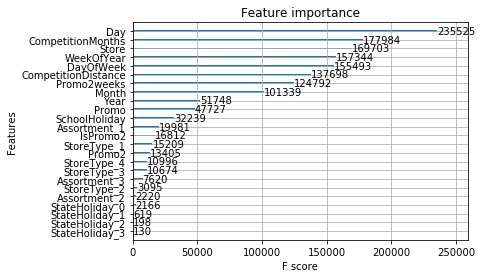

In [228]:
xgb.plot_importance(gbm)
plt.show()

In [211]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

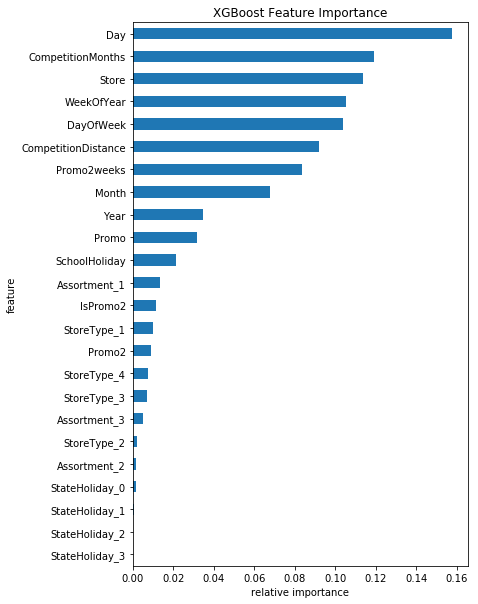

In [213]:
create_feature_map(train_data.columns)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
plt.show()

#### 模型及参数优化

In [223]:
# 提升树的数量
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.005
          }
num_trees = 20000

In [224]:
starttime = datetime.datetime.now()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)

[0]	train-rmse:8.22724	eval-rmse:8.22646	train-rmspe:0.999846	eval-rmspe:0.999829
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.18619	eval-rmse:8.18541	train-rmspe:0.999834	eval-rmspe:0.999816
[2]	train-rmse:8.14535	eval-rmse:8.14458	train-rmspe:0.999821	eval-rmspe:0.999804
[3]	train-rmse:8.10472	eval-rmse:8.10395	train-rmspe:0.999807	eval-rmspe:0.99979
[4]	train-rmse:8.06428	eval-rmse:8.06352	train-rmspe:0.999794	eval-rmspe:0.999777
[5]	train-rmse:8.02405	eval-rmse:8.02329	train-rmspe:0.999779	eval-rmspe:0.999762
[6]	train-rmse:7.98401	eval-rmse:7.98326	train-rmspe:0.999765	eval-rmspe:0.999748
[7]	train-rmse:7.94417	eval-rmse:7.94344	train-rmspe:0.99975	eval-rmspe:0.999732
[8]	train-rmse:7.90454	eval-rmse:7.90381	train-rmspe:0.999734	eval-rmspe:0.999717
[9]	train-rmse:7.8651	eval-rmse:7.86438	train-rmspe:0.999717	eval-rmspe:0.9997
[10]	train-rmse:7.82586	eval-rmse:7.825

[98]	train-rmse:5.04185	eval-rmse:5.04167	train-rmspe:0.993108	eval-rmspe:0.993093
[99]	train-rmse:5.01676	eval-rmse:5.01659	train-rmspe:0.992931	eval-rmspe:0.992916
[100]	train-rmse:4.99179	eval-rmse:4.99162	train-rmspe:0.99275	eval-rmspe:0.992734
[101]	train-rmse:4.96695	eval-rmse:4.96678	train-rmspe:0.992565	eval-rmspe:0.99255
[102]	train-rmse:4.94223	eval-rmse:4.94207	train-rmspe:0.992376	eval-rmspe:0.992361
[103]	train-rmse:4.91765	eval-rmse:4.91749	train-rmspe:0.992183	eval-rmspe:0.992168
[104]	train-rmse:4.89318	eval-rmse:4.89302	train-rmspe:0.991987	eval-rmspe:0.991972
[105]	train-rmse:4.86883	eval-rmse:4.86869	train-rmspe:0.991787	eval-rmspe:0.991772
[106]	train-rmse:4.84461	eval-rmse:4.84447	train-rmspe:0.991583	eval-rmspe:0.991569
[107]	train-rmse:4.8205	eval-rmse:4.82037	train-rmspe:0.991376	eval-rmspe:0.991361
[108]	train-rmse:4.79654	eval-rmse:4.7964	train-rmspe:0.991164	eval-rmspe:0.991149
[109]	train-rmse:4.77267	eval-rmse:4.77254	train-rmspe:0.990948	eval-rmspe:0.99093

[197]	train-rmse:3.08071	eval-rmse:3.08096	train-rmspe:0.950681	eval-rmspe:0.950674
[198]	train-rmse:3.06547	eval-rmse:3.06572	train-rmspe:0.949927	eval-rmspe:0.94992
[199]	train-rmse:3.05032	eval-rmse:3.05057	train-rmspe:0.949164	eval-rmspe:0.949158
[200]	train-rmse:3.03522	eval-rmse:3.03549	train-rmspe:0.948396	eval-rmspe:0.94839
[201]	train-rmse:3.02022	eval-rmse:3.02049	train-rmspe:0.947618	eval-rmspe:0.947612
[202]	train-rmse:3.00529	eval-rmse:3.00557	train-rmspe:0.946832	eval-rmspe:0.946826
[203]	train-rmse:2.99043	eval-rmse:2.99071	train-rmspe:0.946039	eval-rmspe:0.946033
[204]	train-rmse:2.97566	eval-rmse:2.97594	train-rmspe:0.945238	eval-rmspe:0.945231
[205]	train-rmse:2.96095	eval-rmse:2.96124	train-rmspe:0.94443	eval-rmspe:0.944423
[206]	train-rmse:2.94631	eval-rmse:2.94661	train-rmspe:0.943615	eval-rmspe:0.943608
[207]	train-rmse:2.93175	eval-rmse:2.93205	train-rmspe:0.942792	eval-rmspe:0.942785
[208]	train-rmse:2.91726	eval-rmse:2.91757	train-rmspe:0.941961	eval-rmspe:0.94

[296]	train-rmse:1.89188	eval-rmse:1.89253	train-rmspe:0.839127	eval-rmspe:0.838948
[297]	train-rmse:1.88266	eval-rmse:1.88332	train-rmspe:0.837654	eval-rmspe:0.837471
[298]	train-rmse:1.8735	eval-rmse:1.87417	train-rmspe:0.836171	eval-rmspe:0.835983
[299]	train-rmse:1.86438	eval-rmse:1.86505	train-rmspe:0.834686	eval-rmspe:0.834492
[300]	train-rmse:1.85532	eval-rmse:1.85599	train-rmspe:0.833192	eval-rmspe:0.832993
[301]	train-rmse:1.8463	eval-rmse:1.84697	train-rmspe:0.831692	eval-rmspe:0.831488
[302]	train-rmse:1.83731	eval-rmse:1.83799	train-rmspe:0.83019	eval-rmspe:0.82998
[303]	train-rmse:1.82839	eval-rmse:1.82907	train-rmspe:0.828678	eval-rmspe:0.828462
[304]	train-rmse:1.81949	eval-rmse:1.82018	train-rmspe:0.827165	eval-rmspe:0.826943
[305]	train-rmse:1.81065	eval-rmse:1.81134	train-rmspe:0.825647	eval-rmspe:0.825419
[306]	train-rmse:1.80184	eval-rmse:1.80254	train-rmspe:0.824122	eval-rmspe:0.823889
[307]	train-rmse:1.79309	eval-rmse:1.79378	train-rmspe:0.822593	eval-rmspe:0.822

[395]	train-rmse:1.17594	eval-rmse:1.17704	train-rmspe:0.673987	eval-rmspe:0.672647
[396]	train-rmse:1.17039	eval-rmse:1.1715	train-rmspe:0.672228	eval-rmspe:0.670869
[397]	train-rmse:1.1649	eval-rmse:1.16601	train-rmspe:0.670467	eval-rmspe:0.669087
[398]	train-rmse:1.15946	eval-rmse:1.16057	train-rmspe:0.668702	eval-rmspe:0.6673
[399]	train-rmse:1.15403	eval-rmse:1.15515	train-rmspe:0.666942	eval-rmspe:0.665517
[400]	train-rmse:1.14861	eval-rmse:1.14974	train-rmspe:0.665182	eval-rmspe:0.663735
[401]	train-rmse:1.14326	eval-rmse:1.14439	train-rmspe:0.663418	eval-rmspe:0.661949
[402]	train-rmse:1.13791	eval-rmse:1.13905	train-rmspe:0.661657	eval-rmspe:0.660166
[403]	train-rmse:1.13262	eval-rmse:1.13376	train-rmspe:0.659895	eval-rmspe:0.658381
[404]	train-rmse:1.12734	eval-rmse:1.12849	train-rmspe:0.658134	eval-rmspe:0.656598
[405]	train-rmse:1.12208	eval-rmse:1.12324	train-rmspe:0.656375	eval-rmspe:0.654815
[406]	train-rmse:1.11684	eval-rmse:1.118	train-rmspe:0.654619	eval-rmspe:0.65303

[492]	train-rmse:0.757441	eval-rmse:0.759205	train-rmspe:0.511708	eval-rmspe:0.507111
[493]	train-rmse:0.754168	eval-rmse:0.75594	train-rmspe:0.510201	eval-rmspe:0.505554
[494]	train-rmse:0.750936	eval-rmse:0.752715	train-rmspe:0.508697	eval-rmspe:0.504005
[495]	train-rmse:0.747694	eval-rmse:0.749482	train-rmspe:0.507196	eval-rmspe:0.502457
[496]	train-rmse:0.744467	eval-rmse:0.746265	train-rmspe:0.505703	eval-rmspe:0.500913
[497]	train-rmse:0.741287	eval-rmse:0.743091	train-rmspe:0.504218	eval-rmspe:0.499376
[498]	train-rmse:0.73813	eval-rmse:0.739939	train-rmspe:0.502738	eval-rmspe:0.497845
[499]	train-rmse:0.734971	eval-rmse:0.73679	train-rmspe:0.501263	eval-rmspe:0.496315
[500]	train-rmse:0.731839	eval-rmse:0.733666	train-rmspe:0.499784	eval-rmspe:0.494792
[501]	train-rmse:0.728739	eval-rmse:0.730573	train-rmspe:0.498323	eval-rmspe:0.493275
[502]	train-rmse:0.725632	eval-rmse:0.727473	train-rmspe:0.496859	eval-rmspe:0.491758
[503]	train-rmse:0.72257	eval-rmse:0.72442	train-rmspe:0.

[588]	train-rmse:0.516266	eval-rmse:0.518874	train-rmspe:0.391535	eval-rmspe:0.380854
[589]	train-rmse:0.51439	eval-rmse:0.517008	train-rmspe:0.390555	eval-rmspe:0.379795
[590]	train-rmse:0.51253	eval-rmse:0.515159	train-rmspe:0.389578	eval-rmspe:0.378748
[591]	train-rmse:0.510705	eval-rmse:0.513345	train-rmspe:0.388616	eval-rmspe:0.377716
[592]	train-rmse:0.508899	eval-rmse:0.511548	train-rmspe:0.387671	eval-rmspe:0.376691
[593]	train-rmse:0.507121	eval-rmse:0.509779	train-rmspe:0.386739	eval-rmspe:0.37568
[594]	train-rmse:0.505305	eval-rmse:0.50797	train-rmspe:0.385791	eval-rmspe:0.374652
[595]	train-rmse:0.503493	eval-rmse:0.506169	train-rmspe:0.384834	eval-rmspe:0.373624
[596]	train-rmse:0.501744	eval-rmse:0.504428	train-rmspe:0.383917	eval-rmspe:0.372629
[597]	train-rmse:0.499993	eval-rmse:0.502687	train-rmspe:0.382993	eval-rmspe:0.37163
[598]	train-rmse:0.498159	eval-rmse:0.500864	train-rmspe:0.382031	eval-rmspe:0.37059
[599]	train-rmse:0.496419	eval-rmse:0.499132	train-rmspe:0.3

[684]	train-rmse:0.382586	eval-rmse:0.386209	train-rmspe:0.323325	eval-rmspe:0.305092
[685]	train-rmse:0.381619	eval-rmse:0.38525	train-rmspe:0.322884	eval-rmspe:0.30457
[686]	train-rmse:0.380633	eval-rmse:0.384275	train-rmspe:0.322399	eval-rmspe:0.304033
[687]	train-rmse:0.379666	eval-rmse:0.383316	train-rmspe:0.321955	eval-rmspe:0.303505
[688]	train-rmse:0.378689	eval-rmse:0.382351	train-rmspe:0.321494	eval-rmspe:0.302967
[689]	train-rmse:0.377695	eval-rmse:0.381368	train-rmspe:0.321012	eval-rmspe:0.302409
[690]	train-rmse:0.376773	eval-rmse:0.380455	train-rmspe:0.32059	eval-rmspe:0.301915
[691]	train-rmse:0.375795	eval-rmse:0.379486	train-rmspe:0.320134	eval-rmspe:0.301373
[692]	train-rmse:0.374834	eval-rmse:0.378534	train-rmspe:0.319682	eval-rmspe:0.300844
[693]	train-rmse:0.373808	eval-rmse:0.377517	train-rmspe:0.319185	eval-rmspe:0.300263
[694]	train-rmse:0.372816	eval-rmse:0.376535	train-rmspe:0.318693	eval-rmspe:0.299703
[695]	train-rmse:0.371881	eval-rmse:0.375612	train-rmspe:

[780]	train-rmse:0.312591	eval-rmse:0.317163	train-rmspe:0.294079	eval-rmspe:0.269667
[781]	train-rmse:0.312094	eval-rmse:0.316677	train-rmspe:0.293925	eval-rmspe:0.269463
[782]	train-rmse:0.311613	eval-rmse:0.316207	train-rmspe:0.293771	eval-rmspe:0.269263
[783]	train-rmse:0.311154	eval-rmse:0.315754	train-rmspe:0.293647	eval-rmspe:0.269083
[784]	train-rmse:0.310648	eval-rmse:0.315259	train-rmspe:0.293475	eval-rmspe:0.268865
[785]	train-rmse:0.310147	eval-rmse:0.314766	train-rmspe:0.29332	eval-rmspe:0.268649
[786]	train-rmse:0.309645	eval-rmse:0.314275	train-rmspe:0.293147	eval-rmspe:0.268429
[787]	train-rmse:0.30916	eval-rmse:0.313801	train-rmspe:0.29299	eval-rmspe:0.268223
[788]	train-rmse:0.308662	eval-rmse:0.313311	train-rmspe:0.292812	eval-rmspe:0.267995
[789]	train-rmse:0.308242	eval-rmse:0.312897	train-rmspe:0.292729	eval-rmspe:0.267849
[790]	train-rmse:0.30774	eval-rmse:0.312403	train-rmspe:0.292531	eval-rmspe:0.267605
[791]	train-rmse:0.307212	eval-rmse:0.311891	train-rmspe:0

[876]	train-rmse:0.277191	eval-rmse:0.282577	train-rmspe:0.284719	eval-rmspe:0.25638
[877]	train-rmse:0.276913	eval-rmse:0.282308	train-rmspe:0.284646	eval-rmspe:0.256277
[878]	train-rmse:0.276683	eval-rmse:0.282082	train-rmspe:0.28463	eval-rmspe:0.256231
[879]	train-rmse:0.276454	eval-rmse:0.28186	train-rmspe:0.284644	eval-rmspe:0.256186
[880]	train-rmse:0.276235	eval-rmse:0.281649	train-rmspe:0.284634	eval-rmspe:0.256145
[881]	train-rmse:0.275974	eval-rmse:0.281396	train-rmspe:0.284593	eval-rmspe:0.256067
[882]	train-rmse:0.275768	eval-rmse:0.281196	train-rmspe:0.284597	eval-rmspe:0.256038
[883]	train-rmse:0.27557	eval-rmse:0.281001	train-rmspe:0.284617	eval-rmspe:0.256016
[884]	train-rmse:0.275377	eval-rmse:0.280811	train-rmspe:0.28463	eval-rmspe:0.255996
[885]	train-rmse:0.275151	eval-rmse:0.280591	train-rmspe:0.284611	eval-rmspe:0.255945
[886]	train-rmse:0.274876	eval-rmse:0.280324	train-rmspe:0.284528	eval-rmspe:0.255845
[887]	train-rmse:0.274662	eval-rmse:0.280116	train-rmspe:0.

[972]	train-rmse:0.257624	eval-rmse:0.26364	train-rmspe:0.281137	eval-rmspe:0.250498
[973]	train-rmse:0.25752	eval-rmse:0.263541	train-rmspe:0.281163	eval-rmspe:0.250504
[974]	train-rmse:0.257252	eval-rmse:0.263284	train-rmspe:0.281021	eval-rmspe:0.250334
[975]	train-rmse:0.257114	eval-rmse:0.263149	train-rmspe:0.281016	eval-rmspe:0.250311
[976]	train-rmse:0.256968	eval-rmse:0.26301	train-rmspe:0.281011	eval-rmspe:0.250265
[977]	train-rmse:0.256854	eval-rmse:0.262901	train-rmspe:0.281031	eval-rmspe:0.250267
[978]	train-rmse:0.256679	eval-rmse:0.262731	train-rmspe:0.280988	eval-rmspe:0.250189
[979]	train-rmse:0.256583	eval-rmse:0.262639	train-rmspe:0.281043	eval-rmspe:0.250207
[980]	train-rmse:0.256332	eval-rmse:0.2624	train-rmspe:0.2809	eval-rmspe:0.250046
[981]	train-rmse:0.256032	eval-rmse:0.262111	train-rmspe:0.280732	eval-rmspe:0.249843
[982]	train-rmse:0.255924	eval-rmse:0.262008	train-rmspe:0.280647	eval-rmspe:0.249846
[983]	train-rmse:0.255797	eval-rmse:0.261891	train-rmspe:0.28

[1068]	train-rmse:0.245086	eval-rmse:0.251631	train-rmspe:0.278251	eval-rmspe:0.246008
[1069]	train-rmse:0.245034	eval-rmse:0.251583	train-rmspe:0.278291	eval-rmspe:0.246029
[1070]	train-rmse:0.244955	eval-rmse:0.251508	train-rmspe:0.278293	eval-rmspe:0.246022
[1071]	train-rmse:0.244888	eval-rmse:0.251447	train-rmspe:0.278298	eval-rmspe:0.246025
[1072]	train-rmse:0.244783	eval-rmse:0.251347	train-rmspe:0.278262	eval-rmspe:0.245983
[1073]	train-rmse:0.244666	eval-rmse:0.251238	train-rmspe:0.278221	eval-rmspe:0.245923
[1074]	train-rmse:0.244522	eval-rmse:0.251095	train-rmspe:0.278157	eval-rmspe:0.245841
[1075]	train-rmse:0.24448	eval-rmse:0.251054	train-rmspe:0.278204	eval-rmspe:0.245868
[1076]	train-rmse:0.24425	eval-rmse:0.250838	train-rmspe:0.278053	eval-rmspe:0.245694
[1077]	train-rmse:0.244082	eval-rmse:0.250677	train-rmspe:0.277959	eval-rmspe:0.245578
[1078]	train-rmse:0.244026	eval-rmse:0.250623	train-rmspe:0.277967	eval-rmspe:0.245583
[1079]	train-rmse:0.243942	eval-rmse:0.250545

[1163]	train-rmse:0.235798	eval-rmse:0.242859	train-rmspe:0.274539	eval-rmspe:0.241301
[1164]	train-rmse:0.235566	eval-rmse:0.242642	train-rmspe:0.274342	eval-rmspe:0.241089
[1165]	train-rmse:0.235473	eval-rmse:0.242555	train-rmspe:0.274222	eval-rmspe:0.241031
[1166]	train-rmse:0.235446	eval-rmse:0.24253	train-rmspe:0.274249	eval-rmspe:0.241046
[1167]	train-rmse:0.235252	eval-rmse:0.242347	train-rmspe:0.2741	eval-rmspe:0.240884
[1168]	train-rmse:0.235162	eval-rmse:0.242263	train-rmspe:0.274009	eval-rmspe:0.240824
[1169]	train-rmse:0.235067	eval-rmse:0.242175	train-rmspe:0.273895	eval-rmspe:0.240765
[1170]	train-rmse:0.235043	eval-rmse:0.242152	train-rmspe:0.273922	eval-rmspe:0.240782
[1171]	train-rmse:0.234993	eval-rmse:0.242103	train-rmspe:0.273916	eval-rmspe:0.240769
[1172]	train-rmse:0.234968	eval-rmse:0.24208	train-rmspe:0.273945	eval-rmspe:0.240787
[1173]	train-rmse:0.234873	eval-rmse:0.241992	train-rmspe:0.273868	eval-rmspe:0.240727
[1174]	train-rmse:0.234851	eval-rmse:0.24197	tr

KeyboardInterrupt: 

In [222]:
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = gbm.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("20000_xgboost_submission.csv", index=False)

0:00:48.035972
41088


20000颗树 0.005学习率耗时1小时57分22秒 kaggle分数0.11470

In [219]:
# 提升树的数量
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.005
          }
num_trees = 40000
starttime = datetime.datetime.now()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
endtime = datetime.datetime.now()
print (endtime - starttime)
# 结论输出
dtest = xgb.DMatrix(test_data)
starttime = datetime.datetime.now()
test_probs = gbm.predict(dtest)
endtime = datetime.datetime.now()
print (endtime - starttime)
# Make Submission
result = pd.DataFrame({"Id": test_data.index, 'Sales': np.expm1(test_probs)})
result=result.append(result_0)
print(len(result))
result.to_csv("40000_xgboost_submission.csv", index=False)

[0]	train-rmse:8.22724	eval-rmse:8.22646	train-rmspe:0.999846	eval-rmspe:0.999829
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:8.18619	eval-rmse:8.18541	train-rmspe:0.999834	eval-rmspe:0.999816
[2]	train-rmse:8.14535	eval-rmse:8.14458	train-rmspe:0.999821	eval-rmspe:0.999804
[3]	train-rmse:8.10472	eval-rmse:8.10395	train-rmspe:0.999807	eval-rmspe:0.99979
[4]	train-rmse:8.06428	eval-rmse:8.06352	train-rmspe:0.999794	eval-rmspe:0.999777
[5]	train-rmse:8.02405	eval-rmse:8.02329	train-rmspe:0.999779	eval-rmspe:0.999762
[6]	train-rmse:7.98401	eval-rmse:7.98326	train-rmspe:0.999765	eval-rmspe:0.999748
[7]	train-rmse:7.94417	eval-rmse:7.94344	train-rmspe:0.99975	eval-rmspe:0.999732
[8]	train-rmse:7.90454	eval-rmse:7.90381	train-rmspe:0.999734	eval-rmspe:0.999717
[9]	train-rmse:7.8651	eval-rmse:7.86438	train-rmspe:0.999717	eval-rmspe:0.9997
[10]	train-rmse:7.82586	eval-rmse:7.825

[98]	train-rmse:5.04185	eval-rmse:5.04167	train-rmspe:0.993108	eval-rmspe:0.993093
[99]	train-rmse:5.01676	eval-rmse:5.01659	train-rmspe:0.992931	eval-rmspe:0.992916
[100]	train-rmse:4.99179	eval-rmse:4.99162	train-rmspe:0.99275	eval-rmspe:0.992734
[101]	train-rmse:4.96695	eval-rmse:4.96678	train-rmspe:0.992565	eval-rmspe:0.99255
[102]	train-rmse:4.94223	eval-rmse:4.94207	train-rmspe:0.992376	eval-rmspe:0.992361
[103]	train-rmse:4.91765	eval-rmse:4.91749	train-rmspe:0.992183	eval-rmspe:0.992168
[104]	train-rmse:4.89318	eval-rmse:4.89302	train-rmspe:0.991987	eval-rmspe:0.991972
[105]	train-rmse:4.86883	eval-rmse:4.86869	train-rmspe:0.991787	eval-rmspe:0.991772
[106]	train-rmse:4.84461	eval-rmse:4.84447	train-rmspe:0.991583	eval-rmspe:0.991569
[107]	train-rmse:4.8205	eval-rmse:4.82037	train-rmspe:0.991376	eval-rmspe:0.991361
[108]	train-rmse:4.79654	eval-rmse:4.7964	train-rmspe:0.991164	eval-rmspe:0.991149
[109]	train-rmse:4.77267	eval-rmse:4.77254	train-rmspe:0.990948	eval-rmspe:0.99093

[197]	train-rmse:3.08071	eval-rmse:3.08096	train-rmspe:0.950681	eval-rmspe:0.950674
[198]	train-rmse:3.06547	eval-rmse:3.06572	train-rmspe:0.949927	eval-rmspe:0.94992
[199]	train-rmse:3.05032	eval-rmse:3.05057	train-rmspe:0.949164	eval-rmspe:0.949158
[200]	train-rmse:3.03522	eval-rmse:3.03549	train-rmspe:0.948396	eval-rmspe:0.94839
[201]	train-rmse:3.02022	eval-rmse:3.02049	train-rmspe:0.947618	eval-rmspe:0.947612
[202]	train-rmse:3.00529	eval-rmse:3.00557	train-rmspe:0.946832	eval-rmspe:0.946826
[203]	train-rmse:2.99043	eval-rmse:2.99071	train-rmspe:0.946039	eval-rmspe:0.946033
[204]	train-rmse:2.97566	eval-rmse:2.97594	train-rmspe:0.945238	eval-rmspe:0.945231
[205]	train-rmse:2.96095	eval-rmse:2.96124	train-rmspe:0.94443	eval-rmspe:0.944423
[206]	train-rmse:2.94631	eval-rmse:2.94661	train-rmspe:0.943615	eval-rmspe:0.943608
[207]	train-rmse:2.93175	eval-rmse:2.93205	train-rmspe:0.942792	eval-rmspe:0.942785
[208]	train-rmse:2.91726	eval-rmse:2.91757	train-rmspe:0.941961	eval-rmspe:0.94

[296]	train-rmse:1.89188	eval-rmse:1.89253	train-rmspe:0.839127	eval-rmspe:0.838948
[297]	train-rmse:1.88266	eval-rmse:1.88332	train-rmspe:0.837654	eval-rmspe:0.837471
[298]	train-rmse:1.8735	eval-rmse:1.87417	train-rmspe:0.836171	eval-rmspe:0.835983
[299]	train-rmse:1.86438	eval-rmse:1.86505	train-rmspe:0.834686	eval-rmspe:0.834492
[300]	train-rmse:1.85532	eval-rmse:1.85599	train-rmspe:0.833192	eval-rmspe:0.832993
[301]	train-rmse:1.8463	eval-rmse:1.84697	train-rmspe:0.831692	eval-rmspe:0.831488
[302]	train-rmse:1.83731	eval-rmse:1.83799	train-rmspe:0.83019	eval-rmspe:0.82998
[303]	train-rmse:1.82839	eval-rmse:1.82907	train-rmspe:0.828678	eval-rmspe:0.828462
[304]	train-rmse:1.81949	eval-rmse:1.82018	train-rmspe:0.827165	eval-rmspe:0.826943
[305]	train-rmse:1.81065	eval-rmse:1.81134	train-rmspe:0.825647	eval-rmspe:0.825419
[306]	train-rmse:1.80184	eval-rmse:1.80254	train-rmspe:0.824122	eval-rmspe:0.823889
[307]	train-rmse:1.79309	eval-rmse:1.79378	train-rmspe:0.822593	eval-rmspe:0.822

[395]	train-rmse:1.17594	eval-rmse:1.17704	train-rmspe:0.673987	eval-rmspe:0.672647
[396]	train-rmse:1.17039	eval-rmse:1.1715	train-rmspe:0.672228	eval-rmspe:0.670869
[397]	train-rmse:1.1649	eval-rmse:1.16601	train-rmspe:0.670467	eval-rmspe:0.669087
[398]	train-rmse:1.15946	eval-rmse:1.16057	train-rmspe:0.668702	eval-rmspe:0.6673
[399]	train-rmse:1.15403	eval-rmse:1.15515	train-rmspe:0.666942	eval-rmspe:0.665517
[400]	train-rmse:1.14861	eval-rmse:1.14974	train-rmspe:0.665182	eval-rmspe:0.663735
[401]	train-rmse:1.14326	eval-rmse:1.14439	train-rmspe:0.663418	eval-rmspe:0.661949
[402]	train-rmse:1.13791	eval-rmse:1.13905	train-rmspe:0.661657	eval-rmspe:0.660166
[403]	train-rmse:1.13262	eval-rmse:1.13376	train-rmspe:0.659895	eval-rmspe:0.658381
[404]	train-rmse:1.12734	eval-rmse:1.12849	train-rmspe:0.658134	eval-rmspe:0.656598
[405]	train-rmse:1.12208	eval-rmse:1.12324	train-rmspe:0.656375	eval-rmspe:0.654815
[406]	train-rmse:1.11684	eval-rmse:1.118	train-rmspe:0.654619	eval-rmspe:0.65303

[492]	train-rmse:0.757441	eval-rmse:0.759205	train-rmspe:0.511708	eval-rmspe:0.507111
[493]	train-rmse:0.754168	eval-rmse:0.75594	train-rmspe:0.510201	eval-rmspe:0.505554
[494]	train-rmse:0.750936	eval-rmse:0.752715	train-rmspe:0.508697	eval-rmspe:0.504005
[495]	train-rmse:0.747694	eval-rmse:0.749482	train-rmspe:0.507196	eval-rmspe:0.502457
[496]	train-rmse:0.744467	eval-rmse:0.746265	train-rmspe:0.505703	eval-rmspe:0.500913
[497]	train-rmse:0.741287	eval-rmse:0.743091	train-rmspe:0.504218	eval-rmspe:0.499376
[498]	train-rmse:0.73813	eval-rmse:0.739939	train-rmspe:0.502738	eval-rmspe:0.497845
[499]	train-rmse:0.734971	eval-rmse:0.73679	train-rmspe:0.501263	eval-rmspe:0.496315
[500]	train-rmse:0.731839	eval-rmse:0.733666	train-rmspe:0.499784	eval-rmspe:0.494792
[501]	train-rmse:0.728739	eval-rmse:0.730573	train-rmspe:0.498323	eval-rmspe:0.493275
[502]	train-rmse:0.725632	eval-rmse:0.727473	train-rmspe:0.496859	eval-rmspe:0.491758
[503]	train-rmse:0.72257	eval-rmse:0.72442	train-rmspe:0.

[588]	train-rmse:0.516266	eval-rmse:0.518874	train-rmspe:0.391535	eval-rmspe:0.380854
[589]	train-rmse:0.51439	eval-rmse:0.517008	train-rmspe:0.390555	eval-rmspe:0.379795
[590]	train-rmse:0.51253	eval-rmse:0.515159	train-rmspe:0.389578	eval-rmspe:0.378748
[591]	train-rmse:0.510705	eval-rmse:0.513345	train-rmspe:0.388616	eval-rmspe:0.377716
[592]	train-rmse:0.508899	eval-rmse:0.511548	train-rmspe:0.387671	eval-rmspe:0.376691
[593]	train-rmse:0.507121	eval-rmse:0.509779	train-rmspe:0.386739	eval-rmspe:0.37568
[594]	train-rmse:0.505305	eval-rmse:0.50797	train-rmspe:0.385791	eval-rmspe:0.374652
[595]	train-rmse:0.503493	eval-rmse:0.506169	train-rmspe:0.384834	eval-rmspe:0.373624
[596]	train-rmse:0.501744	eval-rmse:0.504428	train-rmspe:0.383917	eval-rmspe:0.372629
[597]	train-rmse:0.499993	eval-rmse:0.502687	train-rmspe:0.382993	eval-rmspe:0.37163
[598]	train-rmse:0.498159	eval-rmse:0.500864	train-rmspe:0.382031	eval-rmspe:0.37059
[599]	train-rmse:0.496419	eval-rmse:0.499132	train-rmspe:0.3

[684]	train-rmse:0.382586	eval-rmse:0.386209	train-rmspe:0.323325	eval-rmspe:0.305092
[685]	train-rmse:0.381619	eval-rmse:0.38525	train-rmspe:0.322884	eval-rmspe:0.30457
[686]	train-rmse:0.380633	eval-rmse:0.384275	train-rmspe:0.322399	eval-rmspe:0.304033
[687]	train-rmse:0.379666	eval-rmse:0.383316	train-rmspe:0.321955	eval-rmspe:0.303505
[688]	train-rmse:0.378689	eval-rmse:0.382351	train-rmspe:0.321494	eval-rmspe:0.302967
[689]	train-rmse:0.377695	eval-rmse:0.381368	train-rmspe:0.321012	eval-rmspe:0.302409
[690]	train-rmse:0.376773	eval-rmse:0.380455	train-rmspe:0.32059	eval-rmspe:0.301915
[691]	train-rmse:0.375795	eval-rmse:0.379486	train-rmspe:0.320134	eval-rmspe:0.301373
[692]	train-rmse:0.374834	eval-rmse:0.378534	train-rmspe:0.319682	eval-rmspe:0.300844
[693]	train-rmse:0.373808	eval-rmse:0.377517	train-rmspe:0.319185	eval-rmspe:0.300263
[694]	train-rmse:0.372816	eval-rmse:0.376535	train-rmspe:0.318693	eval-rmspe:0.299703
[695]	train-rmse:0.371881	eval-rmse:0.375612	train-rmspe:

[780]	train-rmse:0.312591	eval-rmse:0.317163	train-rmspe:0.294079	eval-rmspe:0.269667
[781]	train-rmse:0.312094	eval-rmse:0.316677	train-rmspe:0.293925	eval-rmspe:0.269463
[782]	train-rmse:0.311613	eval-rmse:0.316207	train-rmspe:0.293771	eval-rmspe:0.269263
[783]	train-rmse:0.311154	eval-rmse:0.315754	train-rmspe:0.293647	eval-rmspe:0.269083
[784]	train-rmse:0.310648	eval-rmse:0.315259	train-rmspe:0.293475	eval-rmspe:0.268865
[785]	train-rmse:0.310147	eval-rmse:0.314766	train-rmspe:0.29332	eval-rmspe:0.268649
[786]	train-rmse:0.309645	eval-rmse:0.314275	train-rmspe:0.293147	eval-rmspe:0.268429
[787]	train-rmse:0.30916	eval-rmse:0.313801	train-rmspe:0.29299	eval-rmspe:0.268223
[788]	train-rmse:0.308662	eval-rmse:0.313311	train-rmspe:0.292812	eval-rmspe:0.267995
[789]	train-rmse:0.308242	eval-rmse:0.312897	train-rmspe:0.292729	eval-rmspe:0.267849
[790]	train-rmse:0.30774	eval-rmse:0.312403	train-rmspe:0.292531	eval-rmspe:0.267605
[791]	train-rmse:0.307212	eval-rmse:0.311891	train-rmspe:0

[876]	train-rmse:0.277191	eval-rmse:0.282577	train-rmspe:0.284719	eval-rmspe:0.25638
[877]	train-rmse:0.276913	eval-rmse:0.282308	train-rmspe:0.284646	eval-rmspe:0.256277
[878]	train-rmse:0.276683	eval-rmse:0.282082	train-rmspe:0.28463	eval-rmspe:0.256231
[879]	train-rmse:0.276454	eval-rmse:0.28186	train-rmspe:0.284644	eval-rmspe:0.256186
[880]	train-rmse:0.276235	eval-rmse:0.281649	train-rmspe:0.284634	eval-rmspe:0.256145
[881]	train-rmse:0.275974	eval-rmse:0.281396	train-rmspe:0.284593	eval-rmspe:0.256067
[882]	train-rmse:0.275768	eval-rmse:0.281196	train-rmspe:0.284597	eval-rmspe:0.256038
[883]	train-rmse:0.27557	eval-rmse:0.281001	train-rmspe:0.284617	eval-rmspe:0.256016
[884]	train-rmse:0.275377	eval-rmse:0.280811	train-rmspe:0.28463	eval-rmspe:0.255996
[885]	train-rmse:0.275151	eval-rmse:0.280591	train-rmspe:0.284611	eval-rmspe:0.255945
[886]	train-rmse:0.274876	eval-rmse:0.280324	train-rmspe:0.284528	eval-rmspe:0.255845
[887]	train-rmse:0.274662	eval-rmse:0.280116	train-rmspe:0.

[972]	train-rmse:0.257624	eval-rmse:0.26364	train-rmspe:0.281137	eval-rmspe:0.250498
[973]	train-rmse:0.25752	eval-rmse:0.263541	train-rmspe:0.281163	eval-rmspe:0.250504
[974]	train-rmse:0.257252	eval-rmse:0.263284	train-rmspe:0.281021	eval-rmspe:0.250334
[975]	train-rmse:0.257114	eval-rmse:0.263149	train-rmspe:0.281016	eval-rmspe:0.250311
[976]	train-rmse:0.256968	eval-rmse:0.26301	train-rmspe:0.281011	eval-rmspe:0.250265
[977]	train-rmse:0.256854	eval-rmse:0.262901	train-rmspe:0.281031	eval-rmspe:0.250267
[978]	train-rmse:0.256679	eval-rmse:0.262731	train-rmspe:0.280988	eval-rmspe:0.250189
[979]	train-rmse:0.256583	eval-rmse:0.262639	train-rmspe:0.281043	eval-rmspe:0.250207
[980]	train-rmse:0.256332	eval-rmse:0.2624	train-rmspe:0.2809	eval-rmspe:0.250046
[981]	train-rmse:0.256032	eval-rmse:0.262111	train-rmspe:0.280732	eval-rmspe:0.249843
[982]	train-rmse:0.255924	eval-rmse:0.262008	train-rmspe:0.280647	eval-rmspe:0.249846
[983]	train-rmse:0.255797	eval-rmse:0.261891	train-rmspe:0.28

[1068]	train-rmse:0.245086	eval-rmse:0.251631	train-rmspe:0.278251	eval-rmspe:0.246008
[1069]	train-rmse:0.245034	eval-rmse:0.251583	train-rmspe:0.278291	eval-rmspe:0.246029
[1070]	train-rmse:0.244955	eval-rmse:0.251508	train-rmspe:0.278293	eval-rmspe:0.246022
[1071]	train-rmse:0.244888	eval-rmse:0.251447	train-rmspe:0.278298	eval-rmspe:0.246025
[1072]	train-rmse:0.244783	eval-rmse:0.251347	train-rmspe:0.278262	eval-rmspe:0.245983
[1073]	train-rmse:0.244666	eval-rmse:0.251238	train-rmspe:0.278221	eval-rmspe:0.245923
[1074]	train-rmse:0.244522	eval-rmse:0.251095	train-rmspe:0.278157	eval-rmspe:0.245841
[1075]	train-rmse:0.24448	eval-rmse:0.251054	train-rmspe:0.278204	eval-rmspe:0.245868
[1076]	train-rmse:0.24425	eval-rmse:0.250838	train-rmspe:0.278053	eval-rmspe:0.245694
[1077]	train-rmse:0.244082	eval-rmse:0.250677	train-rmspe:0.277959	eval-rmspe:0.245578
[1078]	train-rmse:0.244026	eval-rmse:0.250623	train-rmspe:0.277967	eval-rmspe:0.245583
[1079]	train-rmse:0.243942	eval-rmse:0.250545

[1163]	train-rmse:0.235798	eval-rmse:0.242859	train-rmspe:0.274539	eval-rmspe:0.241301
[1164]	train-rmse:0.235566	eval-rmse:0.242642	train-rmspe:0.274342	eval-rmspe:0.241089
[1165]	train-rmse:0.235473	eval-rmse:0.242555	train-rmspe:0.274222	eval-rmspe:0.241031
[1166]	train-rmse:0.235446	eval-rmse:0.24253	train-rmspe:0.274249	eval-rmspe:0.241046
[1167]	train-rmse:0.235252	eval-rmse:0.242347	train-rmspe:0.2741	eval-rmspe:0.240884
[1168]	train-rmse:0.235162	eval-rmse:0.242263	train-rmspe:0.274009	eval-rmspe:0.240824
[1169]	train-rmse:0.235067	eval-rmse:0.242175	train-rmspe:0.273895	eval-rmspe:0.240765
[1170]	train-rmse:0.235043	eval-rmse:0.242152	train-rmspe:0.273922	eval-rmspe:0.240782
[1171]	train-rmse:0.234993	eval-rmse:0.242103	train-rmspe:0.273916	eval-rmspe:0.240769
[1172]	train-rmse:0.234968	eval-rmse:0.24208	train-rmspe:0.273945	eval-rmspe:0.240787
[1173]	train-rmse:0.234873	eval-rmse:0.241992	train-rmspe:0.273868	eval-rmspe:0.240727
[1174]	train-rmse:0.234851	eval-rmse:0.24197	tr

[1258]	train-rmse:0.227964	eval-rmse:0.235536	train-rmspe:0.269908	eval-rmspe:0.236018
[1259]	train-rmse:0.227883	eval-rmse:0.235458	train-rmspe:0.269851	eval-rmspe:0.235947
[1260]	train-rmse:0.227846	eval-rmse:0.235425	train-rmspe:0.269838	eval-rmspe:0.235934
[1261]	train-rmse:0.227815	eval-rmse:0.235399	train-rmspe:0.269839	eval-rmspe:0.23593
[1262]	train-rmse:0.227594	eval-rmse:0.235192	train-rmspe:0.269654	eval-rmspe:0.235708
[1263]	train-rmse:0.227569	eval-rmse:0.23517	train-rmspe:0.269647	eval-rmspe:0.2357
[1264]	train-rmse:0.227511	eval-rmse:0.235115	train-rmspe:0.269611	eval-rmspe:0.235663
[1265]	train-rmse:0.227495	eval-rmse:0.235099	train-rmspe:0.269631	eval-rmspe:0.235673
[1266]	train-rmse:0.227469	eval-rmse:0.235076	train-rmspe:0.269628	eval-rmspe:0.235669
[1267]	train-rmse:0.227379	eval-rmse:0.234993	train-rmspe:0.269566	eval-rmspe:0.235594
[1268]	train-rmse:0.227308	eval-rmse:0.234923	train-rmspe:0.269523	eval-rmspe:0.235542
[1269]	train-rmse:0.227282	eval-rmse:0.2349	tra

[1353]	train-rmse:0.221067	eval-rmse:0.229069	train-rmspe:0.264407	eval-rmspe:0.230423
[1354]	train-rmse:0.221034	eval-rmse:0.229037	train-rmspe:0.264392	eval-rmspe:0.230399
[1355]	train-rmse:0.221011	eval-rmse:0.229015	train-rmspe:0.264378	eval-rmspe:0.230388
[1356]	train-rmse:0.220982	eval-rmse:0.228989	train-rmspe:0.264368	eval-rmspe:0.23037
[1357]	train-rmse:0.220917	eval-rmse:0.228928	train-rmspe:0.264308	eval-rmspe:0.230304
[1358]	train-rmse:0.220756	eval-rmse:0.228781	train-rmspe:0.264173	eval-rmspe:0.230145
[1359]	train-rmse:0.220716	eval-rmse:0.228745	train-rmspe:0.264152	eval-rmspe:0.230118
[1360]	train-rmse:0.220669	eval-rmse:0.228701	train-rmspe:0.26413	eval-rmspe:0.230086
[1361]	train-rmse:0.220526	eval-rmse:0.228567	train-rmspe:0.263993	eval-rmspe:0.229933
[1362]	train-rmse:0.220514	eval-rmse:0.228556	train-rmspe:0.263983	eval-rmspe:0.229937
[1363]	train-rmse:0.220502	eval-rmse:0.228545	train-rmspe:0.263996	eval-rmspe:0.229942
[1364]	train-rmse:0.220356	eval-rmse:0.228412

[1448]	train-rmse:0.214377	eval-rmse:0.222848	train-rmspe:0.258142	eval-rmspe:0.224364
[1449]	train-rmse:0.214333	eval-rmse:0.22281	train-rmspe:0.258112	eval-rmspe:0.224328
[1450]	train-rmse:0.214323	eval-rmse:0.222801	train-rmspe:0.258094	eval-rmspe:0.224327
[1451]	train-rmse:0.214252	eval-rmse:0.222736	train-rmspe:0.258022	eval-rmspe:0.224266
[1452]	train-rmse:0.214112	eval-rmse:0.222608	train-rmspe:0.257903	eval-rmspe:0.22413
[1453]	train-rmse:0.214076	eval-rmse:0.222575	train-rmspe:0.257869	eval-rmspe:0.224099
[1454]	train-rmse:0.214	eval-rmse:0.222501	train-rmspe:0.25781	eval-rmspe:0.224024
[1455]	train-rmse:0.213942	eval-rmse:0.222448	train-rmspe:0.257713	eval-rmspe:0.223969
[1456]	train-rmse:0.213782	eval-rmse:0.222299	train-rmspe:0.257545	eval-rmspe:0.22381
[1457]	train-rmse:0.213762	eval-rmse:0.222281	train-rmspe:0.25754	eval-rmspe:0.223797
[1458]	train-rmse:0.213599	eval-rmse:0.222132	train-rmspe:0.257391	eval-rmspe:0.223632
[1459]	train-rmse:0.213482	eval-rmse:0.222026	train

[1543]	train-rmse:0.208085	eval-rmse:0.217041	train-rmspe:0.252204	eval-rmspe:0.218322
[1544]	train-rmse:0.208029	eval-rmse:0.216988	train-rmspe:0.252164	eval-rmspe:0.218262
[1545]	train-rmse:0.207988	eval-rmse:0.21695	train-rmspe:0.252131	eval-rmspe:0.218225
[1546]	train-rmse:0.207842	eval-rmse:0.216816	train-rmspe:0.252005	eval-rmspe:0.218074
[1547]	train-rmse:0.207694	eval-rmse:0.216681	train-rmspe:0.251863	eval-rmspe:0.217923
[1548]	train-rmse:0.207654	eval-rmse:0.216634	train-rmspe:0.251831	eval-rmspe:0.217888
[1549]	train-rmse:0.207626	eval-rmse:0.216597	train-rmspe:0.251812	eval-rmspe:0.217865
[1550]	train-rmse:0.207587	eval-rmse:0.216559	train-rmspe:0.251783	eval-rmspe:0.217829
[1551]	train-rmse:0.207539	eval-rmse:0.216519	train-rmspe:0.251736	eval-rmspe:0.217782
[1552]	train-rmse:0.207481	eval-rmse:0.216467	train-rmspe:0.251686	eval-rmspe:0.217725
[1553]	train-rmse:0.207446	eval-rmse:0.216436	train-rmspe:0.25166	eval-rmspe:0.217694
[1554]	train-rmse:0.207409	eval-rmse:0.216401

[1638]	train-rmse:0.201296	eval-rmse:0.21075	train-rmspe:0.24596	eval-rmspe:0.21145
[1639]	train-rmse:0.201235	eval-rmse:0.210694	train-rmspe:0.245903	eval-rmspe:0.211389
[1640]	train-rmse:0.201226	eval-rmse:0.210688	train-rmspe:0.245907	eval-rmspe:0.211387
[1641]	train-rmse:0.201115	eval-rmse:0.210585	train-rmspe:0.245779	eval-rmspe:0.211257
[1642]	train-rmse:0.201066	eval-rmse:0.21054	train-rmspe:0.245732	eval-rmspe:0.211205
[1643]	train-rmse:0.201037	eval-rmse:0.210504	train-rmspe:0.245708	eval-rmspe:0.211177
[1644]	train-rmse:0.200934	eval-rmse:0.210408	train-rmspe:0.245612	eval-rmspe:0.211064
[1645]	train-rmse:0.200911	eval-rmse:0.210387	train-rmspe:0.245595	eval-rmspe:0.211043
[1646]	train-rmse:0.200875	eval-rmse:0.210355	train-rmspe:0.245514	eval-rmspe:0.211007
[1647]	train-rmse:0.200764	eval-rmse:0.210252	train-rmspe:0.245422	eval-rmspe:0.210894
[1648]	train-rmse:0.200722	eval-rmse:0.210209	train-rmspe:0.245384	eval-rmspe:0.210848
[1649]	train-rmse:0.20069	eval-rmse:0.210183	tr

[1733]	train-rmse:0.195263	eval-rmse:0.205215	train-rmspe:0.239708	eval-rmspe:0.205282
[1734]	train-rmse:0.195207	eval-rmse:0.205168	train-rmspe:0.239658	eval-rmspe:0.20523
[1735]	train-rmse:0.195105	eval-rmse:0.205078	train-rmspe:0.239568	eval-rmspe:0.205126
[1736]	train-rmse:0.195036	eval-rmse:0.205015	train-rmspe:0.239474	eval-rmspe:0.205046
[1737]	train-rmse:0.19495	eval-rmse:0.204934	train-rmspe:0.239392	eval-rmspe:0.204949
[1738]	train-rmse:0.194884	eval-rmse:0.204873	train-rmspe:0.23933	eval-rmspe:0.20488
[1739]	train-rmse:0.194785	eval-rmse:0.204784	train-rmspe:0.23924	eval-rmspe:0.20478
[1740]	train-rmse:0.194759	eval-rmse:0.204762	train-rmspe:0.239221	eval-rmspe:0.204753
[1741]	train-rmse:0.19473	eval-rmse:0.204738	train-rmspe:0.239172	eval-rmspe:0.204725
[1742]	train-rmse:0.194636	eval-rmse:0.204652	train-rmspe:0.239101	eval-rmspe:0.204629
[1743]	train-rmse:0.194606	eval-rmse:0.204625	train-rmspe:0.239082	eval-rmspe:0.204601
[1744]	train-rmse:0.194514	eval-rmse:0.20454	train

[1828]	train-rmse:0.190058	eval-rmse:0.200501	train-rmspe:0.234141	eval-rmspe:0.199889
[1829]	train-rmse:0.189976	eval-rmse:0.200425	train-rmspe:0.234065	eval-rmspe:0.1998
[1830]	train-rmse:0.189923	eval-rmse:0.200377	train-rmspe:0.234022	eval-rmspe:0.199746
[1831]	train-rmse:0.189871	eval-rmse:0.200331	train-rmspe:0.23397	eval-rmspe:0.199693
[1832]	train-rmse:0.189825	eval-rmse:0.200291	train-rmspe:0.233958	eval-rmspe:0.199647
[1833]	train-rmse:0.18974	eval-rmse:0.200215	train-rmspe:0.23388	eval-rmspe:0.19956
[1834]	train-rmse:0.189727	eval-rmse:0.200203	train-rmspe:0.233866	eval-rmspe:0.199546
[1835]	train-rmse:0.189634	eval-rmse:0.200119	train-rmspe:0.233779	eval-rmspe:0.199453
[1836]	train-rmse:0.189546	eval-rmse:0.200038	train-rmspe:0.233696	eval-rmspe:0.199357
[1837]	train-rmse:0.189514	eval-rmse:0.200011	train-rmspe:0.233667	eval-rmspe:0.199326
[1838]	train-rmse:0.189435	eval-rmse:0.199939	train-rmspe:0.233595	eval-rmspe:0.199242
[1839]	train-rmse:0.189357	eval-rmse:0.19987	trai

[1923]	train-rmse:0.184536	eval-rmse:0.195479	train-rmspe:0.227772	eval-rmspe:0.194021
[1924]	train-rmse:0.184443	eval-rmse:0.195393	train-rmspe:0.227682	eval-rmspe:0.193925
[1925]	train-rmse:0.184353	eval-rmse:0.195311	train-rmspe:0.227597	eval-rmspe:0.193835
[1926]	train-rmse:0.18433	eval-rmse:0.195289	train-rmspe:0.227577	eval-rmspe:0.193811
[1927]	train-rmse:0.184317	eval-rmse:0.19528	train-rmspe:0.227575	eval-rmspe:0.193801
[1928]	train-rmse:0.184263	eval-rmse:0.195229	train-rmspe:0.227515	eval-rmspe:0.193734
[1929]	train-rmse:0.184231	eval-rmse:0.195206	train-rmspe:0.227484	eval-rmspe:0.193707
[1930]	train-rmse:0.18416	eval-rmse:0.195142	train-rmspe:0.227421	eval-rmspe:0.193633
[1931]	train-rmse:0.18409	eval-rmse:0.195077	train-rmspe:0.227355	eval-rmspe:0.193554
[1932]	train-rmse:0.184064	eval-rmse:0.195043	train-rmspe:0.227332	eval-rmspe:0.193528
[1933]	train-rmse:0.18397	eval-rmse:0.194957	train-rmspe:0.227189	eval-rmspe:0.193419
[1934]	train-rmse:0.183912	eval-rmse:0.194904	tr

[2018]	train-rmse:0.180051	eval-rmse:0.191432	train-rmspe:0.221855	eval-rmspe:0.189309
[2019]	train-rmse:0.180014	eval-rmse:0.1914	train-rmspe:0.221816	eval-rmspe:0.189272
[2020]	train-rmse:0.180003	eval-rmse:0.191392	train-rmspe:0.221774	eval-rmspe:0.189262
[2021]	train-rmse:0.179906	eval-rmse:0.191307	train-rmspe:0.22167	eval-rmspe:0.189157
[2022]	train-rmse:0.17984	eval-rmse:0.19125	train-rmspe:0.221602	eval-rmspe:0.189092
[2023]	train-rmse:0.17979	eval-rmse:0.191204	train-rmspe:0.221537	eval-rmspe:0.189034
[2024]	train-rmse:0.179697	eval-rmse:0.191124	train-rmspe:0.221449	eval-rmspe:0.188944
[2025]	train-rmse:0.179687	eval-rmse:0.191116	train-rmspe:0.221445	eval-rmspe:0.188936
[2026]	train-rmse:0.179675	eval-rmse:0.191106	train-rmspe:0.221434	eval-rmspe:0.188921
[2027]	train-rmse:0.179608	eval-rmse:0.191046	train-rmspe:0.221377	eval-rmspe:0.188854
[2028]	train-rmse:0.179581	eval-rmse:0.19102	train-rmspe:0.22135	eval-rmspe:0.188825
[2029]	train-rmse:0.179563	eval-rmse:0.190988	train

[2113]	train-rmse:0.175817	eval-rmse:0.187585	train-rmspe:0.217134	eval-rmspe:0.184854
[2114]	train-rmse:0.175752	eval-rmse:0.18753	train-rmspe:0.217082	eval-rmspe:0.184794
[2115]	train-rmse:0.17574	eval-rmse:0.187521	train-rmspe:0.217063	eval-rmspe:0.184785
[2116]	train-rmse:0.175732	eval-rmse:0.187514	train-rmspe:0.217055	eval-rmspe:0.184776
[2117]	train-rmse:0.175686	eval-rmse:0.187472	train-rmspe:0.217013	eval-rmspe:0.184727
[2118]	train-rmse:0.175672	eval-rmse:0.187462	train-rmspe:0.216998	eval-rmspe:0.184714
[2119]	train-rmse:0.175615	eval-rmse:0.187408	train-rmspe:0.216941	eval-rmspe:0.18465
[2120]	train-rmse:0.17556	eval-rmse:0.187358	train-rmspe:0.216886	eval-rmspe:0.184589
[2121]	train-rmse:0.175503	eval-rmse:0.187309	train-rmspe:0.216829	eval-rmspe:0.184533
[2122]	train-rmse:0.175492	eval-rmse:0.187301	train-rmspe:0.216705	eval-rmspe:0.184525
[2123]	train-rmse:0.175435	eval-rmse:0.187247	train-rmspe:0.216652	eval-rmspe:0.184462
[2124]	train-rmse:0.175372	eval-rmse:0.187189	t

[2208]	train-rmse:0.172128	eval-rmse:0.184297	train-rmspe:0.211521	eval-rmspe:0.181064
[2209]	train-rmse:0.172107	eval-rmse:0.184279	train-rmspe:0.211462	eval-rmspe:0.181043
[2210]	train-rmse:0.17209	eval-rmse:0.184244	train-rmspe:0.21145	eval-rmspe:0.181029
[2211]	train-rmse:0.172081	eval-rmse:0.184237	train-rmspe:0.211425	eval-rmspe:0.181023
[2212]	train-rmse:0.172009	eval-rmse:0.18417	train-rmspe:0.211358	eval-rmspe:0.18094
[2213]	train-rmse:0.17194	eval-rmse:0.184106	train-rmspe:0.211295	eval-rmspe:0.180864
[2214]	train-rmse:0.171931	eval-rmse:0.184099	train-rmspe:0.211258	eval-rmspe:0.180856
[2215]	train-rmse:0.171859	eval-rmse:0.184036	train-rmspe:0.211188	eval-rmspe:0.180777
[2216]	train-rmse:0.171797	eval-rmse:0.183984	train-rmspe:0.21113	eval-rmspe:0.180715
[2217]	train-rmse:0.171741	eval-rmse:0.183938	train-rmspe:0.211071	eval-rmspe:0.180665
[2218]	train-rmse:0.17171	eval-rmse:0.183911	train-rmspe:0.211045	eval-rmspe:0.180634
[2219]	train-rmse:0.171688	eval-rmse:0.183893	trai

[2303]	train-rmse:0.168169	eval-rmse:0.180727	train-rmspe:0.206958	eval-rmspe:0.176929
[2304]	train-rmse:0.168115	eval-rmse:0.180681	train-rmspe:0.206629	eval-rmspe:0.176877
[2305]	train-rmse:0.168043	eval-rmse:0.180618	train-rmspe:0.206563	eval-rmspe:0.176801
[2306]	train-rmse:0.168034	eval-rmse:0.180611	train-rmspe:0.206514	eval-rmspe:0.176793
[2307]	train-rmse:0.167989	eval-rmse:0.18057	train-rmspe:0.206475	eval-rmspe:0.176745
[2308]	train-rmse:0.167931	eval-rmse:0.180518	train-rmspe:0.20642	eval-rmspe:0.17668
[2309]	train-rmse:0.167923	eval-rmse:0.180512	train-rmspe:0.206405	eval-rmspe:0.176675
[2310]	train-rmse:0.167899	eval-rmse:0.180491	train-rmspe:0.206381	eval-rmspe:0.176649
[2311]	train-rmse:0.16781	eval-rmse:0.180413	train-rmspe:0.206298	eval-rmspe:0.176551
[2312]	train-rmse:0.167778	eval-rmse:0.18038	train-rmspe:0.206263	eval-rmspe:0.17652
[2313]	train-rmse:0.167702	eval-rmse:0.180314	train-rmspe:0.206193	eval-rmspe:0.176442
[2314]	train-rmse:0.16768	eval-rmse:0.180294	trai

[2398]	train-rmse:0.164708	eval-rmse:0.177721	train-rmspe:0.200555	eval-rmspe:0.173341
[2399]	train-rmse:0.16468	eval-rmse:0.177698	train-rmspe:0.20053	eval-rmspe:0.173311
[2400]	train-rmse:0.164667	eval-rmse:0.177675	train-rmspe:0.20052	eval-rmspe:0.1733
[2401]	train-rmse:0.164625	eval-rmse:0.177626	train-rmspe:0.200483	eval-rmspe:0.173258
[2402]	train-rmse:0.164608	eval-rmse:0.177612	train-rmspe:0.200468	eval-rmspe:0.173242
[2403]	train-rmse:0.164554	eval-rmse:0.177564	train-rmspe:0.200421	eval-rmspe:0.173187
[2404]	train-rmse:0.164531	eval-rmse:0.177546	train-rmspe:0.2004	eval-rmspe:0.173166
[2405]	train-rmse:0.164477	eval-rmse:0.1775	train-rmspe:0.200351	eval-rmspe:0.173114
[2406]	train-rmse:0.164412	eval-rmse:0.177444	train-rmspe:0.20029	eval-rmspe:0.173047
[2407]	train-rmse:0.164325	eval-rmse:0.177367	train-rmspe:0.200093	eval-rmspe:0.172957
[2408]	train-rmse:0.164284	eval-rmse:0.17733	train-rmspe:0.200048	eval-rmspe:0.172912
[2409]	train-rmse:0.164276	eval-rmse:0.177324	train-rm

[2493]	train-rmse:0.16116	eval-rmse:0.174606	train-rmspe:0.196137	eval-rmspe:0.169652
[2494]	train-rmse:0.161115	eval-rmse:0.174565	train-rmspe:0.196084	eval-rmspe:0.169603
[2495]	train-rmse:0.161108	eval-rmse:0.174559	train-rmspe:0.195984	eval-rmspe:0.169596
[2496]	train-rmse:0.161095	eval-rmse:0.174549	train-rmspe:0.195972	eval-rmspe:0.169585
[2497]	train-rmse:0.161075	eval-rmse:0.174533	train-rmspe:0.195962	eval-rmspe:0.169565
[2498]	train-rmse:0.16102	eval-rmse:0.174486	train-rmspe:0.195914	eval-rmspe:0.16951
[2499]	train-rmse:0.160996	eval-rmse:0.174464	train-rmspe:0.195892	eval-rmspe:0.16948
[2500]	train-rmse:0.160963	eval-rmse:0.174435	train-rmspe:0.195851	eval-rmspe:0.169445
[2501]	train-rmse:0.160926	eval-rmse:0.174404	train-rmspe:0.195813	eval-rmspe:0.169407
[2502]	train-rmse:0.160879	eval-rmse:0.174364	train-rmspe:0.195773	eval-rmspe:0.169361
[2503]	train-rmse:0.160854	eval-rmse:0.174341	train-rmspe:0.195749	eval-rmspe:0.169329
[2504]	train-rmse:0.160821	eval-rmse:0.174312	t

[2588]	train-rmse:0.157951	eval-rmse:0.171852	train-rmspe:0.191598	eval-rmspe:0.166366
[2589]	train-rmse:0.15791	eval-rmse:0.171816	train-rmspe:0.191558	eval-rmspe:0.166322
[2590]	train-rmse:0.157889	eval-rmse:0.171798	train-rmspe:0.191539	eval-rmspe:0.166302
[2591]	train-rmse:0.157868	eval-rmse:0.171778	train-rmspe:0.191518	eval-rmspe:0.166276
[2592]	train-rmse:0.157851	eval-rmse:0.171766	train-rmspe:0.191505	eval-rmspe:0.166263
[2593]	train-rmse:0.157815	eval-rmse:0.171734	train-rmspe:0.191469	eval-rmspe:0.166226
[2594]	train-rmse:0.157789	eval-rmse:0.171714	train-rmspe:0.19144	eval-rmspe:0.166201
[2595]	train-rmse:0.157759	eval-rmse:0.171689	train-rmspe:0.191404	eval-rmspe:0.166173
[2596]	train-rmse:0.157737	eval-rmse:0.171669	train-rmspe:0.191383	eval-rmspe:0.166148
[2597]	train-rmse:0.157695	eval-rmse:0.171635	train-rmspe:0.191169	eval-rmspe:0.166108
[2598]	train-rmse:0.157679	eval-rmse:0.171625	train-rmspe:0.191137	eval-rmspe:0.16609
[2599]	train-rmse:0.157661	eval-rmse:0.171611	

[2683]	train-rmse:0.154919	eval-rmse:0.169262	train-rmspe:0.187684	eval-rmspe:0.163248
[2684]	train-rmse:0.154883	eval-rmse:0.16923	train-rmspe:0.187641	eval-rmspe:0.163209
[2685]	train-rmse:0.154862	eval-rmse:0.169211	train-rmspe:0.187622	eval-rmspe:0.163184
[2686]	train-rmse:0.154835	eval-rmse:0.169187	train-rmspe:0.187595	eval-rmspe:0.163154
[2687]	train-rmse:0.154795	eval-rmse:0.169155	train-rmspe:0.187191	eval-rmspe:0.163117
[2688]	train-rmse:0.154787	eval-rmse:0.169148	train-rmspe:0.187172	eval-rmspe:0.163109
[2689]	train-rmse:0.15475	eval-rmse:0.169117	train-rmspe:0.18709	eval-rmspe:0.163072
[2690]	train-rmse:0.154719	eval-rmse:0.169089	train-rmspe:0.187054	eval-rmspe:0.163038
[2691]	train-rmse:0.15469	eval-rmse:0.169064	train-rmspe:0.187023	eval-rmspe:0.163006
[2692]	train-rmse:0.154628	eval-rmse:0.169009	train-rmspe:0.186963	eval-rmspe:0.162938
[2693]	train-rmse:0.154592	eval-rmse:0.168979	train-rmspe:0.186931	eval-rmspe:0.162902
[2694]	train-rmse:0.154568	eval-rmse:0.168958	t

[2778]	train-rmse:0.151871	eval-rmse:0.166647	train-rmspe:0.183643	eval-rmspe:0.160134
[2779]	train-rmse:0.151841	eval-rmse:0.166624	train-rmspe:0.183613	eval-rmspe:0.160107
[2780]	train-rmse:0.151817	eval-rmse:0.166603	train-rmspe:0.183587	eval-rmspe:0.160083
[2781]	train-rmse:0.151748	eval-rmse:0.166544	train-rmspe:0.183436	eval-rmspe:0.160013
[2782]	train-rmse:0.15173	eval-rmse:0.166527	train-rmspe:0.183419	eval-rmspe:0.159991
[2783]	train-rmse:0.1517	eval-rmse:0.166501	train-rmspe:0.183372	eval-rmspe:0.15996
[2784]	train-rmse:0.151644	eval-rmse:0.166452	train-rmspe:0.183318	eval-rmspe:0.1599
[2785]	train-rmse:0.151607	eval-rmse:0.16642	train-rmspe:0.18328	eval-rmspe:0.159859
[2786]	train-rmse:0.15155	eval-rmse:0.166371	train-rmspe:0.183231	eval-rmspe:0.159803
[2787]	train-rmse:0.151518	eval-rmse:0.166343	train-rmspe:0.183191	eval-rmspe:0.159768
[2788]	train-rmse:0.151461	eval-rmse:0.166291	train-rmspe:0.183129	eval-rmspe:0.159704
[2789]	train-rmse:0.151433	eval-rmse:0.166268	train-

[2873]	train-rmse:0.148765	eval-rmse:0.163985	train-rmspe:0.178982	eval-rmspe:0.156921
[2874]	train-rmse:0.148734	eval-rmse:0.163959	train-rmspe:0.178954	eval-rmspe:0.156891
[2875]	train-rmse:0.14872	eval-rmse:0.163949	train-rmspe:0.178822	eval-rmspe:0.156874
[2876]	train-rmse:0.148691	eval-rmse:0.163925	train-rmspe:0.178796	eval-rmspe:0.156846
[2877]	train-rmse:0.148678	eval-rmse:0.163913	train-rmspe:0.178784	eval-rmspe:0.156834
[2878]	train-rmse:0.14865	eval-rmse:0.163893	train-rmspe:0.178746	eval-rmspe:0.156811
[2879]	train-rmse:0.148632	eval-rmse:0.163878	train-rmspe:0.178727	eval-rmspe:0.156791
[2880]	train-rmse:0.148616	eval-rmse:0.163865	train-rmspe:0.178675	eval-rmspe:0.156774
[2881]	train-rmse:0.148575	eval-rmse:0.16383	train-rmspe:0.178587	eval-rmspe:0.156732
[2882]	train-rmse:0.148556	eval-rmse:0.163815	train-rmspe:0.178565	eval-rmspe:0.156715
[2883]	train-rmse:0.148534	eval-rmse:0.163798	train-rmspe:0.178542	eval-rmspe:0.156694
[2884]	train-rmse:0.14848	eval-rmse:0.163752	t

[2968]	train-rmse:0.14614	eval-rmse:0.161821	train-rmspe:0.174314	eval-rmspe:0.154353
[2969]	train-rmse:0.146104	eval-rmse:0.16179	train-rmspe:0.174278	eval-rmspe:0.154315
[2970]	train-rmse:0.146095	eval-rmse:0.161784	train-rmspe:0.174267	eval-rmspe:0.154308
[2971]	train-rmse:0.146062	eval-rmse:0.16176	train-rmspe:0.174234	eval-rmspe:0.154279
[2972]	train-rmse:0.146027	eval-rmse:0.161731	train-rmspe:0.174201	eval-rmspe:0.154242
[2973]	train-rmse:0.146014	eval-rmse:0.161722	train-rmspe:0.17419	eval-rmspe:0.154232
[2974]	train-rmse:0.146001	eval-rmse:0.161711	train-rmspe:0.174175	eval-rmspe:0.154216
[2975]	train-rmse:0.145986	eval-rmse:0.161698	train-rmspe:0.174162	eval-rmspe:0.154203
[2976]	train-rmse:0.145967	eval-rmse:0.161684	train-rmspe:0.174145	eval-rmspe:0.154183
[2977]	train-rmse:0.145945	eval-rmse:0.161668	train-rmspe:0.174114	eval-rmspe:0.154164
[2978]	train-rmse:0.145916	eval-rmse:0.161644	train-rmspe:0.174078	eval-rmspe:0.154133
[2979]	train-rmse:0.145861	eval-rmse:0.161596	t

[3063]	train-rmse:0.143735	eval-rmse:0.159807	train-rmspe:0.170682	eval-rmspe:0.151993
[3064]	train-rmse:0.143718	eval-rmse:0.159797	train-rmspe:0.170616	eval-rmspe:0.151981
[3065]	train-rmse:0.143714	eval-rmse:0.159793	train-rmspe:0.170596	eval-rmspe:0.151978
[3066]	train-rmse:0.143689	eval-rmse:0.159776	train-rmspe:0.170577	eval-rmspe:0.151955
[3067]	train-rmse:0.14367	eval-rmse:0.159764	train-rmspe:0.17056	eval-rmspe:0.151942
[3068]	train-rmse:0.143651	eval-rmse:0.159748	train-rmspe:0.170536	eval-rmspe:0.151922
[3069]	train-rmse:0.143623	eval-rmse:0.159725	train-rmspe:0.170513	eval-rmspe:0.151896
[3070]	train-rmse:0.143612	eval-rmse:0.159717	train-rmspe:0.170501	eval-rmspe:0.151887
[3071]	train-rmse:0.143576	eval-rmse:0.159676	train-rmspe:0.170469	eval-rmspe:0.151851
[3072]	train-rmse:0.143549	eval-rmse:0.159657	train-rmspe:0.170444	eval-rmspe:0.151828
[3073]	train-rmse:0.143531	eval-rmse:0.159642	train-rmspe:0.170423	eval-rmspe:0.151811
[3074]	train-rmse:0.143485	eval-rmse:0.159604

[3158]	train-rmse:0.141485	eval-rmse:0.157944	train-rmspe:0.167424	eval-rmspe:0.14981
[3159]	train-rmse:0.14146	eval-rmse:0.157924	train-rmspe:0.167356	eval-rmspe:0.149786
[3160]	train-rmse:0.141453	eval-rmse:0.15792	train-rmspe:0.167312	eval-rmspe:0.149781
[3161]	train-rmse:0.141438	eval-rmse:0.157907	train-rmspe:0.167296	eval-rmspe:0.149764
[3162]	train-rmse:0.141384	eval-rmse:0.15786	train-rmspe:0.167232	eval-rmspe:0.149703
[3163]	train-rmse:0.141362	eval-rmse:0.157839	train-rmspe:0.167213	eval-rmspe:0.14968
[3164]	train-rmse:0.141304	eval-rmse:0.15779	train-rmspe:0.167158	eval-rmspe:0.149621
[3165]	train-rmse:0.141284	eval-rmse:0.157774	train-rmspe:0.167137	eval-rmspe:0.149603
[3166]	train-rmse:0.141276	eval-rmse:0.157769	train-rmspe:0.167114	eval-rmspe:0.149597
[3167]	train-rmse:0.141251	eval-rmse:0.157748	train-rmspe:0.167089	eval-rmspe:0.149572
[3168]	train-rmse:0.14122	eval-rmse:0.157723	train-rmspe:0.167052	eval-rmspe:0.149541
[3169]	train-rmse:0.141204	eval-rmse:0.15771	train

[3253]	train-rmse:0.13943	eval-rmse:0.156241	train-rmspe:0.164332	eval-rmspe:0.147777
[3254]	train-rmse:0.139407	eval-rmse:0.156221	train-rmspe:0.164309	eval-rmspe:0.147752
[3255]	train-rmse:0.139391	eval-rmse:0.156212	train-rmspe:0.164292	eval-rmspe:0.147737
[3256]	train-rmse:0.139365	eval-rmse:0.156193	train-rmspe:0.164165	eval-rmspe:0.14771
[3257]	train-rmse:0.139357	eval-rmse:0.156188	train-rmspe:0.164158	eval-rmspe:0.147704
[3258]	train-rmse:0.139328	eval-rmse:0.156165	train-rmspe:0.163863	eval-rmspe:0.147679
[3259]	train-rmse:0.139311	eval-rmse:0.156151	train-rmspe:0.163839	eval-rmspe:0.147663
[3260]	train-rmse:0.139295	eval-rmse:0.156139	train-rmspe:0.163824	eval-rmspe:0.147647
[3261]	train-rmse:0.139276	eval-rmse:0.156122	train-rmspe:0.163806	eval-rmspe:0.147627
[3262]	train-rmse:0.139249	eval-rmse:0.1561	train-rmspe:0.163782	eval-rmspe:0.1476
[3263]	train-rmse:0.139194	eval-rmse:0.156052	train-rmspe:0.163729	eval-rmspe:0.147544
[3264]	train-rmse:0.139181	eval-rmse:0.156042	tra

[3348]	train-rmse:0.13749	eval-rmse:0.15461	train-rmspe:0.15989	eval-rmspe:0.145886
[3349]	train-rmse:0.137448	eval-rmse:0.154573	train-rmspe:0.159849	eval-rmspe:0.145841
[3350]	train-rmse:0.137432	eval-rmse:0.154561	train-rmspe:0.159824	eval-rmspe:0.145825
[3351]	train-rmse:0.137426	eval-rmse:0.154557	train-rmspe:0.159734	eval-rmspe:0.14582
[3352]	train-rmse:0.137397	eval-rmse:0.154531	train-rmspe:0.159694	eval-rmspe:0.145787
[3353]	train-rmse:0.137382	eval-rmse:0.15452	train-rmspe:0.159679	eval-rmspe:0.145774
[3354]	train-rmse:0.137349	eval-rmse:0.154493	train-rmspe:0.159646	eval-rmspe:0.145743
[3355]	train-rmse:0.137331	eval-rmse:0.154478	train-rmspe:0.159629	eval-rmspe:0.145724
[3356]	train-rmse:0.137321	eval-rmse:0.154469	train-rmspe:0.159619	eval-rmspe:0.145713
[3357]	train-rmse:0.137308	eval-rmse:0.154458	train-rmspe:0.159605	eval-rmspe:0.145698
[3358]	train-rmse:0.137303	eval-rmse:0.154455	train-rmspe:0.159598	eval-rmspe:0.145694
[3359]	train-rmse:0.137283	eval-rmse:0.15444	tra

[3443]	train-rmse:0.135729	eval-rmse:0.153162	train-rmspe:0.157079	eval-rmspe:0.144174
[3444]	train-rmse:0.135702	eval-rmse:0.153138	train-rmspe:0.157054	eval-rmspe:0.144147
[3445]	train-rmse:0.135688	eval-rmse:0.153128	train-rmspe:0.157039	eval-rmspe:0.144135
[3446]	train-rmse:0.13566	eval-rmse:0.153106	train-rmspe:0.157013	eval-rmspe:0.144107
[3447]	train-rmse:0.135648	eval-rmse:0.153096	train-rmspe:0.157003	eval-rmspe:0.144097
[3448]	train-rmse:0.135633	eval-rmse:0.153083	train-rmspe:0.15699	eval-rmspe:0.144082
[3449]	train-rmse:0.135612	eval-rmse:0.153066	train-rmspe:0.156968	eval-rmspe:0.144063
[3450]	train-rmse:0.135581	eval-rmse:0.153043	train-rmspe:0.15694	eval-rmspe:0.144035
[3451]	train-rmse:0.135571	eval-rmse:0.153034	train-rmspe:0.156928	eval-rmspe:0.144023
[3452]	train-rmse:0.135556	eval-rmse:0.153024	train-rmspe:0.156907	eval-rmspe:0.144012
[3453]	train-rmse:0.13553	eval-rmse:0.152998	train-rmspe:0.156884	eval-rmspe:0.143987
[3454]	train-rmse:0.135484	eval-rmse:0.152959	t

[3538]	train-rmse:0.134059	eval-rmse:0.15182	train-rmspe:0.154121	eval-rmspe:0.142669
[3539]	train-rmse:0.13404	eval-rmse:0.151805	train-rmspe:0.154078	eval-rmspe:0.142652
[3540]	train-rmse:0.13403	eval-rmse:0.151797	train-rmspe:0.154059	eval-rmspe:0.142643
[3541]	train-rmse:0.134011	eval-rmse:0.151782	train-rmspe:0.15404	eval-rmspe:0.142625
[3542]	train-rmse:0.133995	eval-rmse:0.151768	train-rmspe:0.154025	eval-rmspe:0.142607
[3543]	train-rmse:0.133984	eval-rmse:0.15176	train-rmspe:0.154021	eval-rmspe:0.142596
[3544]	train-rmse:0.133973	eval-rmse:0.151751	train-rmspe:0.154009	eval-rmspe:0.142586
[3545]	train-rmse:0.133948	eval-rmse:0.15173	train-rmspe:0.153984	eval-rmspe:0.142563
[3546]	train-rmse:0.133929	eval-rmse:0.151717	train-rmspe:0.153968	eval-rmspe:0.142546
[3547]	train-rmse:0.133919	eval-rmse:0.151708	train-rmspe:0.153959	eval-rmspe:0.142536
[3548]	train-rmse:0.133901	eval-rmse:0.151694	train-rmspe:0.153943	eval-rmspe:0.142519
[3549]	train-rmse:0.133872	eval-rmse:0.151671	tra

[3633]	train-rmse:0.132315	eval-rmse:0.15044	train-rmspe:0.151728	eval-rmspe:0.141044
[3634]	train-rmse:0.132303	eval-rmse:0.150432	train-rmspe:0.151714	eval-rmspe:0.141035
[3635]	train-rmse:0.132289	eval-rmse:0.150422	train-rmspe:0.151698	eval-rmspe:0.141022
[3636]	train-rmse:0.132263	eval-rmse:0.1504	train-rmspe:0.151642	eval-rmspe:0.140995
[3637]	train-rmse:0.132253	eval-rmse:0.150394	train-rmspe:0.151629	eval-rmspe:0.140988
[3638]	train-rmse:0.132247	eval-rmse:0.15039	train-rmspe:0.151624	eval-rmspe:0.140983
[3639]	train-rmse:0.132235	eval-rmse:0.150379	train-rmspe:0.151611	eval-rmspe:0.14097
[3640]	train-rmse:0.132213	eval-rmse:0.150363	train-rmspe:0.151591	eval-rmspe:0.14095
[3641]	train-rmse:0.132201	eval-rmse:0.150354	train-rmspe:0.151497	eval-rmspe:0.140936
[3642]	train-rmse:0.132182	eval-rmse:0.150341	train-rmspe:0.151394	eval-rmspe:0.14092
[3643]	train-rmse:0.132161	eval-rmse:0.150325	train-rmspe:0.151375	eval-rmspe:0.140899
[3644]	train-rmse:0.132152	eval-rmse:0.150318	trai

[3728]	train-rmse:0.13071	eval-rmse:0.149152	train-rmspe:0.149111	eval-rmspe:0.139556
[3729]	train-rmse:0.130696	eval-rmse:0.149141	train-rmspe:0.149096	eval-rmspe:0.139544
[3730]	train-rmse:0.13068	eval-rmse:0.149129	train-rmspe:0.149013	eval-rmspe:0.139531
[3731]	train-rmse:0.130662	eval-rmse:0.149115	train-rmspe:0.148993	eval-rmspe:0.139513
[3732]	train-rmse:0.13064	eval-rmse:0.149096	train-rmspe:0.148971	eval-rmspe:0.13949
[3733]	train-rmse:0.130625	eval-rmse:0.149085	train-rmspe:0.148957	eval-rmspe:0.139478
[3734]	train-rmse:0.130614	eval-rmse:0.149076	train-rmspe:0.148945	eval-rmspe:0.139467
[3735]	train-rmse:0.130597	eval-rmse:0.149053	train-rmspe:0.148927	eval-rmspe:0.139452
[3736]	train-rmse:0.130574	eval-rmse:0.149033	train-rmspe:0.148905	eval-rmspe:0.139428
[3737]	train-rmse:0.130566	eval-rmse:0.149028	train-rmspe:0.148898	eval-rmspe:0.139422
[3738]	train-rmse:0.130517	eval-rmse:0.14899	train-rmspe:0.148849	eval-rmspe:0.139376
[3739]	train-rmse:0.130491	eval-rmse:0.148967	tr

[3823]	train-rmse:0.12929	eval-rmse:0.148003	train-rmspe:0.147211	eval-rmspe:0.138294
[3824]	train-rmse:0.129275	eval-rmse:0.14799	train-rmspe:0.147194	eval-rmspe:0.138279
[3825]	train-rmse:0.129247	eval-rmse:0.14797	train-rmspe:0.147167	eval-rmspe:0.138255
[3826]	train-rmse:0.12922	eval-rmse:0.147948	train-rmspe:0.147142	eval-rmspe:0.138227
[3827]	train-rmse:0.129208	eval-rmse:0.14794	train-rmspe:0.147132	eval-rmspe:0.138217
[3828]	train-rmse:0.129185	eval-rmse:0.147924	train-rmspe:0.147112	eval-rmspe:0.138197
[3829]	train-rmse:0.12916	eval-rmse:0.147904	train-rmspe:0.147089	eval-rmspe:0.138174
[3830]	train-rmse:0.129154	eval-rmse:0.147899	train-rmspe:0.147081	eval-rmspe:0.138167
[3831]	train-rmse:0.129124	eval-rmse:0.147875	train-rmspe:0.147051	eval-rmspe:0.138135
[3832]	train-rmse:0.129095	eval-rmse:0.14785	train-rmspe:0.147024	eval-rmspe:0.138106
[3833]	train-rmse:0.129081	eval-rmse:0.14784	train-rmspe:0.14701	eval-rmspe:0.138095
[3834]	train-rmse:0.129063	eval-rmse:0.147827	train-

[3918]	train-rmse:0.12786	eval-rmse:0.146884	train-rmspe:0.144972	eval-rmspe:0.137015
[3919]	train-rmse:0.127842	eval-rmse:0.14687	train-rmspe:0.1448	eval-rmspe:0.137
[3920]	train-rmse:0.127833	eval-rmse:0.146864	train-rmspe:0.144795	eval-rmspe:0.136991
[3921]	train-rmse:0.127817	eval-rmse:0.146851	train-rmspe:0.144781	eval-rmspe:0.136977
[3922]	train-rmse:0.127801	eval-rmse:0.14684	train-rmspe:0.144767	eval-rmspe:0.136964
[3923]	train-rmse:0.127782	eval-rmse:0.146825	train-rmspe:0.14475	eval-rmspe:0.136945
[3924]	train-rmse:0.127781	eval-rmse:0.146824	train-rmspe:0.14475	eval-rmspe:0.136945
[3925]	train-rmse:0.127765	eval-rmse:0.146811	train-rmspe:0.144734	eval-rmspe:0.136929
[3926]	train-rmse:0.127758	eval-rmse:0.146807	train-rmspe:0.144729	eval-rmspe:0.136925
[3927]	train-rmse:0.127746	eval-rmse:0.146801	train-rmspe:0.144719	eval-rmspe:0.136918
[3928]	train-rmse:0.127725	eval-rmse:0.146786	train-rmspe:0.144702	eval-rmspe:0.136901
[3929]	train-rmse:0.127711	eval-rmse:0.146776	train-r

[4013]	train-rmse:0.126472	eval-rmse:0.145793	train-rmspe:0.142576	eval-rmspe:0.135795
[4014]	train-rmse:0.126454	eval-rmse:0.145777	train-rmspe:0.142559	eval-rmspe:0.135774
[4015]	train-rmse:0.126447	eval-rmse:0.145772	train-rmspe:0.142551	eval-rmspe:0.135768
[4016]	train-rmse:0.126436	eval-rmse:0.145762	train-rmspe:0.142539	eval-rmspe:0.135756
[4017]	train-rmse:0.126427	eval-rmse:0.145755	train-rmspe:0.142529	eval-rmspe:0.135749
[4018]	train-rmse:0.126411	eval-rmse:0.145743	train-rmspe:0.142515	eval-rmspe:0.135734
[4019]	train-rmse:0.126387	eval-rmse:0.145712	train-rmspe:0.142492	eval-rmspe:0.135715
[4020]	train-rmse:0.126366	eval-rmse:0.145687	train-rmspe:0.142473	eval-rmspe:0.135697
[4021]	train-rmse:0.126354	eval-rmse:0.145678	train-rmspe:0.142461	eval-rmspe:0.135682
[4022]	train-rmse:0.12635	eval-rmse:0.145675	train-rmspe:0.142459	eval-rmspe:0.135679
[4023]	train-rmse:0.126342	eval-rmse:0.14567	train-rmspe:0.142452	eval-rmspe:0.135673
[4024]	train-rmse:0.126331	eval-rmse:0.145661

[4108]	train-rmse:0.125174	eval-rmse:0.144705	train-rmspe:0.140813	eval-rmspe:0.134654
[4109]	train-rmse:0.125162	eval-rmse:0.144696	train-rmspe:0.140798	eval-rmspe:0.134642
[4110]	train-rmse:0.125154	eval-rmse:0.144689	train-rmspe:0.140793	eval-rmspe:0.134635
[4111]	train-rmse:0.125139	eval-rmse:0.144683	train-rmspe:0.140783	eval-rmspe:0.134626
[4112]	train-rmse:0.125122	eval-rmse:0.144668	train-rmspe:0.140764	eval-rmspe:0.13461
[4113]	train-rmse:0.125112	eval-rmse:0.144664	train-rmspe:0.140756	eval-rmspe:0.134605
[4114]	train-rmse:0.125101	eval-rmse:0.144655	train-rmspe:0.140744	eval-rmspe:0.134595
[4115]	train-rmse:0.125087	eval-rmse:0.144644	train-rmspe:0.140732	eval-rmspe:0.134581
[4116]	train-rmse:0.125084	eval-rmse:0.144642	train-rmspe:0.140709	eval-rmspe:0.134579
[4117]	train-rmse:0.125066	eval-rmse:0.14462	train-rmspe:0.140692	eval-rmspe:0.134564
[4118]	train-rmse:0.12504	eval-rmse:0.144604	train-rmspe:0.140662	eval-rmspe:0.134545
[4119]	train-rmse:0.125024	eval-rmse:0.144592	

[4203]	train-rmse:0.123924	eval-rmse:0.143743	train-rmspe:0.138921	eval-rmspe:0.133574
[4204]	train-rmse:0.12391	eval-rmse:0.143732	train-rmspe:0.138908	eval-rmspe:0.133563
[4205]	train-rmse:0.123897	eval-rmse:0.143721	train-rmspe:0.138894	eval-rmspe:0.133549
[4206]	train-rmse:0.123887	eval-rmse:0.143716	train-rmspe:0.138887	eval-rmspe:0.133545
[4207]	train-rmse:0.123877	eval-rmse:0.143712	train-rmspe:0.138858	eval-rmspe:0.133538
[4208]	train-rmse:0.12387	eval-rmse:0.143707	train-rmspe:0.138852	eval-rmspe:0.133533
[4209]	train-rmse:0.123856	eval-rmse:0.143696	train-rmspe:0.138839	eval-rmspe:0.13352
[4210]	train-rmse:0.123844	eval-rmse:0.143689	train-rmspe:0.138829	eval-rmspe:0.133513
[4211]	train-rmse:0.123839	eval-rmse:0.143685	train-rmspe:0.138818	eval-rmspe:0.133509
[4212]	train-rmse:0.123826	eval-rmse:0.143676	train-rmspe:0.138806	eval-rmspe:0.133495
[4213]	train-rmse:0.123812	eval-rmse:0.143656	train-rmspe:0.138794	eval-rmspe:0.133484
[4214]	train-rmse:0.123794	eval-rmse:0.143644	

[4298]	train-rmse:0.122625	eval-rmse:0.142771	train-rmspe:0.136955	eval-rmspe:0.132456
[4299]	train-rmse:0.12261	eval-rmse:0.142759	train-rmspe:0.13694	eval-rmspe:0.132442
[4300]	train-rmse:0.122603	eval-rmse:0.142756	train-rmspe:0.136925	eval-rmspe:0.132438
[4301]	train-rmse:0.122601	eval-rmse:0.142754	train-rmspe:0.136923	eval-rmspe:0.132436
[4302]	train-rmse:0.122593	eval-rmse:0.142749	train-rmspe:0.136917	eval-rmspe:0.13243
[4303]	train-rmse:0.12258	eval-rmse:0.142739	train-rmspe:0.136902	eval-rmspe:0.132419
[4304]	train-rmse:0.122574	eval-rmse:0.142736	train-rmspe:0.136897	eval-rmspe:0.132415
[4305]	train-rmse:0.122564	eval-rmse:0.142729	train-rmspe:0.136882	eval-rmspe:0.132408
[4306]	train-rmse:0.122554	eval-rmse:0.142721	train-rmspe:0.136871	eval-rmspe:0.132397
[4307]	train-rmse:0.122547	eval-rmse:0.142717	train-rmspe:0.136804	eval-rmspe:0.132393
[4308]	train-rmse:0.122533	eval-rmse:0.142709	train-rmspe:0.136676	eval-rmspe:0.13238
[4309]	train-rmse:0.122529	eval-rmse:0.142707	tr

[4393]	train-rmse:0.121455	eval-rmse:0.141866	train-rmspe:0.135346	eval-rmspe:0.131449
[4394]	train-rmse:0.121431	eval-rmse:0.141848	train-rmspe:0.135324	eval-rmspe:0.131428
[4395]	train-rmse:0.121418	eval-rmse:0.14183	train-rmspe:0.135311	eval-rmspe:0.131419
[4396]	train-rmse:0.12141	eval-rmse:0.141824	train-rmspe:0.135304	eval-rmspe:0.131413
[4397]	train-rmse:0.121402	eval-rmse:0.141817	train-rmspe:0.135298	eval-rmspe:0.131408
[4398]	train-rmse:0.121389	eval-rmse:0.141798	train-rmspe:0.135285	eval-rmspe:0.131398
[4399]	train-rmse:0.12137	eval-rmse:0.141784	train-rmspe:0.135269	eval-rmspe:0.131377
[4400]	train-rmse:0.121354	eval-rmse:0.141771	train-rmspe:0.13525	eval-rmspe:0.13136
[4401]	train-rmse:0.121349	eval-rmse:0.141768	train-rmspe:0.135246	eval-rmspe:0.131357
[4402]	train-rmse:0.12134	eval-rmse:0.141761	train-rmspe:0.135237	eval-rmspe:0.131349
[4403]	train-rmse:0.121322	eval-rmse:0.141746	train-rmspe:0.135219	eval-rmspe:0.131332
[4404]	train-rmse:0.121312	eval-rmse:0.141739	tra

[4488]	train-rmse:0.120233	eval-rmse:0.140928	train-rmspe:0.133736	eval-rmspe:0.130403
[4489]	train-rmse:0.120218	eval-rmse:0.140916	train-rmspe:0.13372	eval-rmspe:0.130385
[4490]	train-rmse:0.12021	eval-rmse:0.140912	train-rmspe:0.133715	eval-rmspe:0.130381
[4491]	train-rmse:0.120204	eval-rmse:0.140907	train-rmspe:0.133708	eval-rmspe:0.130376
[4492]	train-rmse:0.120192	eval-rmse:0.140899	train-rmspe:0.133696	eval-rmspe:0.130366
[4493]	train-rmse:0.120184	eval-rmse:0.140893	train-rmspe:0.133689	eval-rmspe:0.130362
[4494]	train-rmse:0.120176	eval-rmse:0.140888	train-rmspe:0.133682	eval-rmspe:0.130356
[4495]	train-rmse:0.120167	eval-rmse:0.140873	train-rmspe:0.133673	eval-rmspe:0.130348
[4496]	train-rmse:0.120157	eval-rmse:0.140866	train-rmspe:0.133663	eval-rmspe:0.130339
[4497]	train-rmse:0.120153	eval-rmse:0.140864	train-rmspe:0.13366	eval-rmspe:0.130337
[4498]	train-rmse:0.120138	eval-rmse:0.140856	train-rmspe:0.133649	eval-rmspe:0.130327
[4499]	train-rmse:0.120128	eval-rmse:0.140848	

[4583]	train-rmse:0.119159	eval-rmse:0.14013	train-rmspe:0.132388	eval-rmspe:0.129517
[4584]	train-rmse:0.119145	eval-rmse:0.140119	train-rmspe:0.132375	eval-rmspe:0.129505
[4585]	train-rmse:0.119126	eval-rmse:0.140104	train-rmspe:0.132339	eval-rmspe:0.129487
[4586]	train-rmse:0.119118	eval-rmse:0.140098	train-rmspe:0.132332	eval-rmspe:0.129479
[4587]	train-rmse:0.119105	eval-rmse:0.140088	train-rmspe:0.132319	eval-rmspe:0.129467
[4588]	train-rmse:0.119091	eval-rmse:0.140068	train-rmspe:0.132308	eval-rmspe:0.129455
[4589]	train-rmse:0.119076	eval-rmse:0.14006	train-rmspe:0.132295	eval-rmspe:0.129445
[4590]	train-rmse:0.119065	eval-rmse:0.140052	train-rmspe:0.132283	eval-rmspe:0.129437
[4591]	train-rmse:0.119056	eval-rmse:0.140045	train-rmspe:0.13227	eval-rmspe:0.129423
[4592]	train-rmse:0.119041	eval-rmse:0.140034	train-rmspe:0.132201	eval-rmspe:0.12941
[4593]	train-rmse:0.119032	eval-rmse:0.140027	train-rmspe:0.132195	eval-rmspe:0.129403
[4594]	train-rmse:0.119017	eval-rmse:0.140021	t

[4678]	train-rmse:0.117977	eval-rmse:0.139226	train-rmspe:0.130935	eval-rmspe:0.128548
[4679]	train-rmse:0.11797	eval-rmse:0.139221	train-rmspe:0.130928	eval-rmspe:0.128541
[4680]	train-rmse:0.117959	eval-rmse:0.139212	train-rmspe:0.130915	eval-rmspe:0.12853
[4681]	train-rmse:0.117945	eval-rmse:0.139202	train-rmspe:0.130799	eval-rmspe:0.128518
[4682]	train-rmse:0.117931	eval-rmse:0.139193	train-rmspe:0.130786	eval-rmspe:0.128508
[4683]	train-rmse:0.117918	eval-rmse:0.139174	train-rmspe:0.130775	eval-rmspe:0.128497
[4684]	train-rmse:0.117903	eval-rmse:0.139163	train-rmspe:0.13076	eval-rmspe:0.128485
[4685]	train-rmse:0.117885	eval-rmse:0.139149	train-rmspe:0.130743	eval-rmspe:0.128469
[4686]	train-rmse:0.117875	eval-rmse:0.139143	train-rmspe:0.130738	eval-rmspe:0.128462
[4687]	train-rmse:0.117869	eval-rmse:0.13914	train-rmspe:0.130735	eval-rmspe:0.128459
[4688]	train-rmse:0.117848	eval-rmse:0.139124	train-rmspe:0.130715	eval-rmspe:0.128439
[4689]	train-rmse:0.117837	eval-rmse:0.139117	t

[4773]	train-rmse:0.116903	eval-rmse:0.138392	train-rmspe:0.129532	eval-rmspe:0.127659
[4774]	train-rmse:0.116894	eval-rmse:0.138384	train-rmspe:0.129524	eval-rmspe:0.127652
[4775]	train-rmse:0.116891	eval-rmse:0.138381	train-rmspe:0.129497	eval-rmspe:0.127648
[4776]	train-rmse:0.116877	eval-rmse:0.138371	train-rmspe:0.129483	eval-rmspe:0.127636
[4777]	train-rmse:0.116866	eval-rmse:0.138368	train-rmspe:0.129476	eval-rmspe:0.127631
[4778]	train-rmse:0.116854	eval-rmse:0.13836	train-rmspe:0.129465	eval-rmspe:0.127623
[4779]	train-rmse:0.11684	eval-rmse:0.138351	train-rmspe:0.129447	eval-rmspe:0.127612
[4780]	train-rmse:0.116827	eval-rmse:0.138341	train-rmspe:0.129434	eval-rmspe:0.127599
[4781]	train-rmse:0.116826	eval-rmse:0.138339	train-rmspe:0.129427	eval-rmspe:0.127598
[4782]	train-rmse:0.11682	eval-rmse:0.138335	train-rmspe:0.129421	eval-rmspe:0.127593
[4783]	train-rmse:0.116812	eval-rmse:0.138328	train-rmspe:0.129412	eval-rmspe:0.127584
[4784]	train-rmse:0.116802	eval-rmse:0.138322	

[4868]	train-rmse:0.116018	eval-rmse:0.13775	train-rmspe:0.128368	eval-rmspe:0.126919
[4869]	train-rmse:0.116008	eval-rmse:0.137743	train-rmspe:0.128348	eval-rmspe:0.126911
[4870]	train-rmse:0.116003	eval-rmse:0.13774	train-rmspe:0.128344	eval-rmspe:0.126907
[4871]	train-rmse:0.115985	eval-rmse:0.137727	train-rmspe:0.128327	eval-rmspe:0.126892
[4872]	train-rmse:0.115975	eval-rmse:0.137721	train-rmspe:0.128317	eval-rmspe:0.126884
[4873]	train-rmse:0.115966	eval-rmse:0.137717	train-rmspe:0.128311	eval-rmspe:0.126879
[4874]	train-rmse:0.115959	eval-rmse:0.137712	train-rmspe:0.128304	eval-rmspe:0.126873
[4875]	train-rmse:0.115944	eval-rmse:0.137693	train-rmspe:0.12829	eval-rmspe:0.126859
[4876]	train-rmse:0.115926	eval-rmse:0.137685	train-rmspe:0.128275	eval-rmspe:0.126849
[4877]	train-rmse:0.115919	eval-rmse:0.137679	train-rmspe:0.128269	eval-rmspe:0.126843
[4878]	train-rmse:0.115903	eval-rmse:0.137667	train-rmspe:0.128228	eval-rmspe:0.126829
[4879]	train-rmse:0.115896	eval-rmse:0.137661	

[4963]	train-rmse:0.115007	eval-rmse:0.137024	train-rmspe:0.127278	eval-rmspe:0.12611
[4964]	train-rmse:0.115001	eval-rmse:0.137019	train-rmspe:0.127273	eval-rmspe:0.126104
[4965]	train-rmse:0.114991	eval-rmse:0.137014	train-rmspe:0.127265	eval-rmspe:0.126098
[4966]	train-rmse:0.114984	eval-rmse:0.137011	train-rmspe:0.12726	eval-rmspe:0.126094
[4967]	train-rmse:0.114974	eval-rmse:0.137001	train-rmspe:0.127251	eval-rmspe:0.126087
[4968]	train-rmse:0.114969	eval-rmse:0.136997	train-rmspe:0.127246	eval-rmspe:0.126082
[4969]	train-rmse:0.114964	eval-rmse:0.136993	train-rmspe:0.127242	eval-rmspe:0.126077
[4970]	train-rmse:0.114945	eval-rmse:0.136979	train-rmspe:0.127223	eval-rmspe:0.126059
[4971]	train-rmse:0.114934	eval-rmse:0.136975	train-rmspe:0.127215	eval-rmspe:0.126054
[4972]	train-rmse:0.11493	eval-rmse:0.136972	train-rmspe:0.127211	eval-rmspe:0.12605
[4973]	train-rmse:0.114914	eval-rmse:0.13696	train-rmspe:0.127196	eval-rmspe:0.126037
[4974]	train-rmse:0.114909	eval-rmse:0.136957	tr

[5058]	train-rmse:0.114018	eval-rmse:0.136278	train-rmspe:0.126151	eval-rmspe:0.125309
[5059]	train-rmse:0.11401	eval-rmse:0.136272	train-rmspe:0.126142	eval-rmspe:0.125301
[5060]	train-rmse:0.114	eval-rmse:0.136266	train-rmspe:0.126134	eval-rmspe:0.125294
[5061]	train-rmse:0.113991	eval-rmse:0.136256	train-rmspe:0.126126	eval-rmspe:0.125288
[5062]	train-rmse:0.113985	eval-rmse:0.136253	train-rmspe:0.126116	eval-rmspe:0.125284
[5063]	train-rmse:0.113977	eval-rmse:0.136249	train-rmspe:0.12611	eval-rmspe:0.125279
[5064]	train-rmse:0.11397	eval-rmse:0.136245	train-rmspe:0.126104	eval-rmspe:0.125275
[5065]	train-rmse:0.113963	eval-rmse:0.136233	train-rmspe:0.126101	eval-rmspe:0.125272
[5066]	train-rmse:0.113958	eval-rmse:0.13623	train-rmspe:0.126097	eval-rmspe:0.125268
[5067]	train-rmse:0.113938	eval-rmse:0.136214	train-rmspe:0.126079	eval-rmspe:0.12525
[5068]	train-rmse:0.113922	eval-rmse:0.136203	train-rmspe:0.126064	eval-rmspe:0.125237
[5069]	train-rmse:0.113914	eval-rmse:0.136199	train

[5153]	train-rmse:0.113114	eval-rmse:0.135611	train-rmspe:0.125113	eval-rmspe:0.124609
[5154]	train-rmse:0.11311	eval-rmse:0.135611	train-rmspe:0.125109	eval-rmspe:0.124607
[5155]	train-rmse:0.113103	eval-rmse:0.135605	train-rmspe:0.125102	eval-rmspe:0.1246
[5156]	train-rmse:0.113098	eval-rmse:0.135601	train-rmspe:0.125086	eval-rmspe:0.124595
[5157]	train-rmse:0.113088	eval-rmse:0.135594	train-rmspe:0.125078	eval-rmspe:0.124586
[5158]	train-rmse:0.113081	eval-rmse:0.135591	train-rmspe:0.125072	eval-rmspe:0.124582
[5159]	train-rmse:0.113075	eval-rmse:0.135588	train-rmspe:0.125068	eval-rmspe:0.124579
[5160]	train-rmse:0.113067	eval-rmse:0.135583	train-rmspe:0.125061	eval-rmspe:0.124574
[5161]	train-rmse:0.113066	eval-rmse:0.135582	train-rmspe:0.12506	eval-rmspe:0.124574
[5162]	train-rmse:0.113057	eval-rmse:0.135578	train-rmspe:0.125052	eval-rmspe:0.124569
[5163]	train-rmse:0.113042	eval-rmse:0.135567	train-rmspe:0.125038	eval-rmspe:0.124556
[5164]	train-rmse:0.113031	eval-rmse:0.13556	tr

[5248]	train-rmse:0.112224	eval-rmse:0.134994	train-rmspe:0.12411	eval-rmspe:0.123915
[5249]	train-rmse:0.112219	eval-rmse:0.134992	train-rmspe:0.124106	eval-rmspe:0.123912
[5250]	train-rmse:0.11221	eval-rmse:0.134985	train-rmspe:0.124096	eval-rmspe:0.123904
[5251]	train-rmse:0.112198	eval-rmse:0.134979	train-rmspe:0.124082	eval-rmspe:0.123893
[5252]	train-rmse:0.112193	eval-rmse:0.134976	train-rmspe:0.124077	eval-rmspe:0.12389
[5253]	train-rmse:0.112175	eval-rmse:0.134963	train-rmspe:0.124059	eval-rmspe:0.123873
[5254]	train-rmse:0.112168	eval-rmse:0.134958	train-rmspe:0.124052	eval-rmspe:0.123866
[5255]	train-rmse:0.112161	eval-rmse:0.134953	train-rmspe:0.124044	eval-rmspe:0.123861
[5256]	train-rmse:0.112152	eval-rmse:0.134948	train-rmspe:0.124036	eval-rmspe:0.123854
[5257]	train-rmse:0.112132	eval-rmse:0.134931	train-rmspe:0.124021	eval-rmspe:0.123841
[5258]	train-rmse:0.112121	eval-rmse:0.134923	train-rmspe:0.12401	eval-rmspe:0.123831
[5259]	train-rmse:0.112112	eval-rmse:0.134914	t

[5343]	train-rmse:0.111339	eval-rmse:0.134377	train-rmspe:0.123166	eval-rmspe:0.12323
[5344]	train-rmse:0.111331	eval-rmse:0.134374	train-rmspe:0.12316	eval-rmspe:0.123225
[5345]	train-rmse:0.111322	eval-rmse:0.134368	train-rmspe:0.12315	eval-rmspe:0.123218
[5346]	train-rmse:0.111309	eval-rmse:0.13436	train-rmspe:0.123138	eval-rmspe:0.123212
[5347]	train-rmse:0.11129	eval-rmse:0.134345	train-rmspe:0.123119	eval-rmspe:0.123192
[5348]	train-rmse:0.111283	eval-rmse:0.13434	train-rmspe:0.123112	eval-rmspe:0.123186
[5349]	train-rmse:0.111276	eval-rmse:0.134335	train-rmspe:0.123105	eval-rmspe:0.123181
[5350]	train-rmse:0.111269	eval-rmse:0.134329	train-rmspe:0.123098	eval-rmspe:0.123174
[5351]	train-rmse:0.11125	eval-rmse:0.134308	train-rmspe:0.123083	eval-rmspe:0.12316
[5352]	train-rmse:0.111243	eval-rmse:0.134303	train-rmspe:0.123076	eval-rmspe:0.123155
[5353]	train-rmse:0.111241	eval-rmse:0.134303	train-rmspe:0.123063	eval-rmspe:0.123155
[5354]	train-rmse:0.111233	eval-rmse:0.134298	train

[5438]	train-rmse:0.110559	eval-rmse:0.133808	train-rmspe:0.122208	eval-rmspe:0.122649
[5439]	train-rmse:0.110555	eval-rmse:0.133806	train-rmspe:0.122204	eval-rmspe:0.122646
[5440]	train-rmse:0.110549	eval-rmse:0.133802	train-rmspe:0.122198	eval-rmspe:0.122642
[5441]	train-rmse:0.110546	eval-rmse:0.1338	train-rmspe:0.122195	eval-rmspe:0.122639
[5442]	train-rmse:0.110538	eval-rmse:0.133795	train-rmspe:0.122186	eval-rmspe:0.122632
[5443]	train-rmse:0.110529	eval-rmse:0.133784	train-rmspe:0.122178	eval-rmspe:0.122626
[5444]	train-rmse:0.110523	eval-rmse:0.133779	train-rmspe:0.122172	eval-rmspe:0.122621
[5445]	train-rmse:0.110516	eval-rmse:0.133775	train-rmspe:0.122166	eval-rmspe:0.122616
[5446]	train-rmse:0.110507	eval-rmse:0.133769	train-rmspe:0.122149	eval-rmspe:0.122608
[5447]	train-rmse:0.110498	eval-rmse:0.133767	train-rmspe:0.122124	eval-rmspe:0.122606
[5448]	train-rmse:0.110488	eval-rmse:0.133758	train-rmspe:0.122114	eval-rmspe:0.122595
[5449]	train-rmse:0.110484	eval-rmse:0.133756

[5533]	train-rmse:0.109882	eval-rmse:0.133363	train-rmspe:0.121439	eval-rmspe:0.12215
[5534]	train-rmse:0.109871	eval-rmse:0.133358	train-rmspe:0.12143	eval-rmspe:0.122143
[5535]	train-rmse:0.109859	eval-rmse:0.133351	train-rmspe:0.12142	eval-rmspe:0.122136
[5536]	train-rmse:0.109845	eval-rmse:0.133344	train-rmspe:0.12141	eval-rmspe:0.122127
[5537]	train-rmse:0.109836	eval-rmse:0.133338	train-rmspe:0.1214	eval-rmspe:0.12212
[5538]	train-rmse:0.109832	eval-rmse:0.13333	train-rmspe:0.121396	eval-rmspe:0.122118
[5539]	train-rmse:0.109826	eval-rmse:0.133325	train-rmspe:0.12139	eval-rmspe:0.122113
[5540]	train-rmse:0.109817	eval-rmse:0.13332	train-rmspe:0.121379	eval-rmspe:0.122107
[5541]	train-rmse:0.109809	eval-rmse:0.133314	train-rmspe:0.121365	eval-rmspe:0.122099
[5542]	train-rmse:0.109801	eval-rmse:0.133311	train-rmspe:0.121357	eval-rmspe:0.122095
[5543]	train-rmse:0.109797	eval-rmse:0.133307	train-rmspe:0.121352	eval-rmspe:0.122091
[5544]	train-rmse:0.109788	eval-rmse:0.133303	train-r

[5628]	train-rmse:0.109105	eval-rmse:0.132809	train-rmspe:0.120641	eval-rmspe:0.121578
[5629]	train-rmse:0.109102	eval-rmse:0.132804	train-rmspe:0.120639	eval-rmspe:0.121577
[5630]	train-rmse:0.109101	eval-rmse:0.132803	train-rmspe:0.120638	eval-rmspe:0.121575
[5631]	train-rmse:0.109094	eval-rmse:0.132798	train-rmspe:0.12063	eval-rmspe:0.121568
[5632]	train-rmse:0.109089	eval-rmse:0.132794	train-rmspe:0.120598	eval-rmspe:0.121564
[5633]	train-rmse:0.109085	eval-rmse:0.132793	train-rmspe:0.120597	eval-rmspe:0.121562
[5634]	train-rmse:0.109082	eval-rmse:0.132791	train-rmspe:0.120594	eval-rmspe:0.12156
[5635]	train-rmse:0.109073	eval-rmse:0.132787	train-rmspe:0.120591	eval-rmspe:0.121557
[5636]	train-rmse:0.109069	eval-rmse:0.132786	train-rmspe:0.120591	eval-rmspe:0.121555
[5637]	train-rmse:0.109052	eval-rmse:0.132773	train-rmspe:0.120573	eval-rmspe:0.12154
[5638]	train-rmse:0.109041	eval-rmse:0.132764	train-rmspe:0.120561	eval-rmspe:0.121529
[5639]	train-rmse:0.109034	eval-rmse:0.13276	t

[5723]	train-rmse:0.10847	eval-rmse:0.132368	train-rmspe:0.119874	eval-rmspe:0.121107
[5724]	train-rmse:0.108466	eval-rmse:0.132365	train-rmspe:0.11987	eval-rmspe:0.121104
[5725]	train-rmse:0.108444	eval-rmse:0.132344	train-rmspe:0.119848	eval-rmspe:0.121086
[5726]	train-rmse:0.108435	eval-rmse:0.132338	train-rmspe:0.119839	eval-rmspe:0.121078
[5727]	train-rmse:0.108422	eval-rmse:0.132331	train-rmspe:0.119829	eval-rmspe:0.12107
[5728]	train-rmse:0.108411	eval-rmse:0.132327	train-rmspe:0.119818	eval-rmspe:0.121063
[5729]	train-rmse:0.108406	eval-rmse:0.132324	train-rmspe:0.119813	eval-rmspe:0.12106
[5730]	train-rmse:0.1084	eval-rmse:0.132321	train-rmspe:0.119807	eval-rmspe:0.121056
[5731]	train-rmse:0.108396	eval-rmse:0.132318	train-rmspe:0.119805	eval-rmspe:0.121054
[5732]	train-rmse:0.108393	eval-rmse:0.132316	train-rmspe:0.119802	eval-rmspe:0.121052
[5733]	train-rmse:0.10838	eval-rmse:0.132307	train-rmspe:0.119786	eval-rmspe:0.121041
[5734]	train-rmse:0.108373	eval-rmse:0.132302	trai

[5818]	train-rmse:0.107719	eval-rmse:0.131819	train-rmspe:0.118978	eval-rmspe:0.120539
[5819]	train-rmse:0.10771	eval-rmse:0.131815	train-rmspe:0.118973	eval-rmspe:0.120535
[5820]	train-rmse:0.107699	eval-rmse:0.13181	train-rmspe:0.118966	eval-rmspe:0.120529
[5821]	train-rmse:0.107677	eval-rmse:0.131797	train-rmspe:0.11895	eval-rmspe:0.120513
[5822]	train-rmse:0.107669	eval-rmse:0.13179	train-rmspe:0.11894	eval-rmspe:0.120505
[5823]	train-rmse:0.107663	eval-rmse:0.131787	train-rmspe:0.118935	eval-rmspe:0.120502
[5824]	train-rmse:0.107658	eval-rmse:0.131783	train-rmspe:0.118929	eval-rmspe:0.120498
[5825]	train-rmse:0.107648	eval-rmse:0.131777	train-rmspe:0.118922	eval-rmspe:0.12049
[5826]	train-rmse:0.107641	eval-rmse:0.131773	train-rmspe:0.118916	eval-rmspe:0.120485
[5827]	train-rmse:0.10763	eval-rmse:0.131765	train-rmspe:0.118907	eval-rmspe:0.120477
[5828]	train-rmse:0.107627	eval-rmse:0.131763	train-rmspe:0.118904	eval-rmspe:0.120476
[5829]	train-rmse:0.107622	eval-rmse:0.131761	trai

[5913]	train-rmse:0.106981	eval-rmse:0.131314	train-rmspe:0.118258	eval-rmspe:0.120001
[5914]	train-rmse:0.106968	eval-rmse:0.131305	train-rmspe:0.118239	eval-rmspe:0.119992
[5915]	train-rmse:0.106955	eval-rmse:0.131298	train-rmspe:0.118229	eval-rmspe:0.119983
[5916]	train-rmse:0.10695	eval-rmse:0.131287	train-rmspe:0.118226	eval-rmspe:0.11998
[5917]	train-rmse:0.10694	eval-rmse:0.131283	train-rmspe:0.118219	eval-rmspe:0.119976
[5918]	train-rmse:0.10693	eval-rmse:0.131277	train-rmspe:0.118211	eval-rmspe:0.119969
[5919]	train-rmse:0.106924	eval-rmse:0.131273	train-rmspe:0.118207	eval-rmspe:0.119965
[5920]	train-rmse:0.106917	eval-rmse:0.131268	train-rmspe:0.1182	eval-rmspe:0.11996
[5921]	train-rmse:0.106912	eval-rmse:0.131266	train-rmspe:0.118196	eval-rmspe:0.119958
[5922]	train-rmse:0.106899	eval-rmse:0.131259	train-rmspe:0.118186	eval-rmspe:0.119949
[5923]	train-rmse:0.106894	eval-rmse:0.131256	train-rmspe:0.11818	eval-rmspe:0.119945
[5924]	train-rmse:0.106883	eval-rmse:0.131249	train

[6008]	train-rmse:0.106286	eval-rmse:0.130838	train-rmspe:0.117569	eval-rmspe:0.119479
[6009]	train-rmse:0.106269	eval-rmse:0.130828	train-rmspe:0.117552	eval-rmspe:0.119464
[6010]	train-rmse:0.106266	eval-rmse:0.130824	train-rmspe:0.117549	eval-rmspe:0.119463
[6011]	train-rmse:0.106262	eval-rmse:0.130821	train-rmspe:0.11754	eval-rmspe:0.11946
[6012]	train-rmse:0.106255	eval-rmse:0.130819	train-rmspe:0.117535	eval-rmspe:0.119458
[6013]	train-rmse:0.106251	eval-rmse:0.130814	train-rmspe:0.117533	eval-rmspe:0.119455
[6014]	train-rmse:0.106242	eval-rmse:0.130811	train-rmspe:0.117529	eval-rmspe:0.119452
[6015]	train-rmse:0.106234	eval-rmse:0.130807	train-rmspe:0.117522	eval-rmspe:0.119447
[6016]	train-rmse:0.106229	eval-rmse:0.130804	train-rmspe:0.117515	eval-rmspe:0.119443
[6017]	train-rmse:0.106224	eval-rmse:0.130801	train-rmspe:0.117511	eval-rmspe:0.119439
[6018]	train-rmse:0.106218	eval-rmse:0.130794	train-rmspe:0.117508	eval-rmspe:0.119437
[6019]	train-rmse:0.106216	eval-rmse:0.130788

[6103]	train-rmse:0.10567	eval-rmse:0.130411	train-rmspe:0.11696	eval-rmspe:0.11907
[6104]	train-rmse:0.10566	eval-rmse:0.130399	train-rmspe:0.11695	eval-rmspe:0.119059
[6105]	train-rmse:0.105649	eval-rmse:0.130392	train-rmspe:0.11694	eval-rmspe:0.11905
[6106]	train-rmse:0.105632	eval-rmse:0.130371	train-rmspe:0.116924	eval-rmspe:0.119036
[6107]	train-rmse:0.105622	eval-rmse:0.130363	train-rmspe:0.116914	eval-rmspe:0.119026
[6108]	train-rmse:0.105604	eval-rmse:0.13035	train-rmspe:0.116903	eval-rmspe:0.119014
[6109]	train-rmse:0.105591	eval-rmse:0.130344	train-rmspe:0.116892	eval-rmspe:0.119005
[6110]	train-rmse:0.105584	eval-rmse:0.13034	train-rmspe:0.116887	eval-rmspe:0.119001
[6111]	train-rmse:0.105576	eval-rmse:0.130334	train-rmspe:0.116877	eval-rmspe:0.118993
[6112]	train-rmse:0.105572	eval-rmse:0.130331	train-rmspe:0.116871	eval-rmspe:0.11899
[6113]	train-rmse:0.105566	eval-rmse:0.130327	train-rmspe:0.116864	eval-rmspe:0.118983
[6114]	train-rmse:0.105561	eval-rmse:0.130324	train-r

[6198]	train-rmse:0.105024	eval-rmse:0.129957	train-rmspe:0.116273	eval-rmspe:0.118608
[6199]	train-rmse:0.105019	eval-rmse:0.129954	train-rmspe:0.116268	eval-rmspe:0.118604
[6200]	train-rmse:0.10501	eval-rmse:0.129947	train-rmspe:0.116255	eval-rmspe:0.118596
[6201]	train-rmse:0.105004	eval-rmse:0.129943	train-rmspe:0.116249	eval-rmspe:0.118592
[6202]	train-rmse:0.105003	eval-rmse:0.129943	train-rmspe:0.116247	eval-rmspe:0.118591
[6203]	train-rmse:0.104996	eval-rmse:0.12994	train-rmspe:0.116243	eval-rmspe:0.118589
[6204]	train-rmse:0.104989	eval-rmse:0.129935	train-rmspe:0.116236	eval-rmspe:0.118583
[6205]	train-rmse:0.104981	eval-rmse:0.129931	train-rmspe:0.116229	eval-rmspe:0.118578
[6206]	train-rmse:0.104978	eval-rmse:0.12993	train-rmspe:0.116227	eval-rmspe:0.118577
[6207]	train-rmse:0.104976	eval-rmse:0.129928	train-rmspe:0.116225	eval-rmspe:0.118576
[6208]	train-rmse:0.104968	eval-rmse:0.129917	train-rmspe:0.11622	eval-rmspe:0.118573
[6209]	train-rmse:0.104963	eval-rmse:0.129913	t

[6293]	train-rmse:0.104426	eval-rmse:0.12956	train-rmspe:0.115569	eval-rmspe:0.118186
[6294]	train-rmse:0.104423	eval-rmse:0.129559	train-rmspe:0.115566	eval-rmspe:0.118183
[6295]	train-rmse:0.104419	eval-rmse:0.129556	train-rmspe:0.11556	eval-rmspe:0.11818
[6296]	train-rmse:0.104412	eval-rmse:0.129554	train-rmspe:0.115549	eval-rmspe:0.118175
[6297]	train-rmse:0.104401	eval-rmse:0.129546	train-rmspe:0.115527	eval-rmspe:0.118164
[6298]	train-rmse:0.104394	eval-rmse:0.129544	train-rmspe:0.115493	eval-rmspe:0.118159
[6299]	train-rmse:0.104388	eval-rmse:0.129539	train-rmspe:0.115487	eval-rmspe:0.118153
[6300]	train-rmse:0.104377	eval-rmse:0.129531	train-rmspe:0.115476	eval-rmspe:0.118143
[6301]	train-rmse:0.104366	eval-rmse:0.129525	train-rmspe:0.115466	eval-rmspe:0.118136
[6302]	train-rmse:0.104361	eval-rmse:0.129522	train-rmspe:0.115461	eval-rmspe:0.118132
[6303]	train-rmse:0.10436	eval-rmse:0.129522	train-rmspe:0.11546	eval-rmspe:0.118132
[6304]	train-rmse:0.104355	eval-rmse:0.129518	tr

[6388]	train-rmse:0.103888	eval-rmse:0.129226	train-rmspe:0.114989	eval-rmspe:0.117815
[6389]	train-rmse:0.103883	eval-rmse:0.129224	train-rmspe:0.114985	eval-rmspe:0.117813
[6390]	train-rmse:0.103878	eval-rmse:0.12922	train-rmspe:0.114979	eval-rmspe:0.117808
[6391]	train-rmse:0.103872	eval-rmse:0.129215	train-rmspe:0.114973	eval-rmspe:0.117803
[6392]	train-rmse:0.103865	eval-rmse:0.129214	train-rmspe:0.114969	eval-rmspe:0.117801
[6393]	train-rmse:0.103861	eval-rmse:0.129211	train-rmspe:0.114967	eval-rmspe:0.117799
[6394]	train-rmse:0.103858	eval-rmse:0.129209	train-rmspe:0.114964	eval-rmspe:0.117797
[6395]	train-rmse:0.103849	eval-rmse:0.129206	train-rmspe:0.114959	eval-rmspe:0.117794
[6396]	train-rmse:0.103842	eval-rmse:0.129201	train-rmspe:0.114951	eval-rmspe:0.117789
[6397]	train-rmse:0.103835	eval-rmse:0.129196	train-rmspe:0.114943	eval-rmspe:0.11778
[6398]	train-rmse:0.103829	eval-rmse:0.129191	train-rmspe:0.114937	eval-rmspe:0.117774
[6399]	train-rmse:0.103824	eval-rmse:0.129187

[6483]	train-rmse:0.10329	eval-rmse:0.128848	train-rmspe:0.11432	eval-rmspe:0.117403
[6484]	train-rmse:0.103284	eval-rmse:0.128845	train-rmspe:0.114314	eval-rmspe:0.1174
[6485]	train-rmse:0.103279	eval-rmse:0.128843	train-rmspe:0.114309	eval-rmspe:0.117398
[6486]	train-rmse:0.103275	eval-rmse:0.128841	train-rmspe:0.114306	eval-rmspe:0.117394
[6487]	train-rmse:0.103274	eval-rmse:0.12884	train-rmspe:0.114301	eval-rmspe:0.117394
[6488]	train-rmse:0.103272	eval-rmse:0.12884	train-rmspe:0.1143	eval-rmspe:0.117394
[6489]	train-rmse:0.103266	eval-rmse:0.128836	train-rmspe:0.114295	eval-rmspe:0.11739
[6490]	train-rmse:0.103262	eval-rmse:0.128834	train-rmspe:0.114292	eval-rmspe:0.117388
[6491]	train-rmse:0.103257	eval-rmse:0.128831	train-rmspe:0.114288	eval-rmspe:0.117384
[6492]	train-rmse:0.103254	eval-rmse:0.12883	train-rmspe:0.114284	eval-rmspe:0.117382
[6493]	train-rmse:0.103246	eval-rmse:0.128825	train-rmspe:0.114278	eval-rmspe:0.117377
[6494]	train-rmse:0.103236	eval-rmse:0.128824	train-r

[6578]	train-rmse:0.10274	eval-rmse:0.128472	train-rmspe:0.113647	eval-rmspe:0.117045
[6579]	train-rmse:0.102726	eval-rmse:0.128465	train-rmspe:0.113636	eval-rmspe:0.117038
[6580]	train-rmse:0.102721	eval-rmse:0.128463	train-rmspe:0.113631	eval-rmspe:0.117035
[6581]	train-rmse:0.102711	eval-rmse:0.12846	train-rmspe:0.113613	eval-rmspe:0.11703
[6582]	train-rmse:0.102705	eval-rmse:0.128459	train-rmspe:0.113603	eval-rmspe:0.117026
[6583]	train-rmse:0.102699	eval-rmse:0.128454	train-rmspe:0.113597	eval-rmspe:0.11702
[6584]	train-rmse:0.102693	eval-rmse:0.128453	train-rmspe:0.113593	eval-rmspe:0.117018
[6585]	train-rmse:0.102686	eval-rmse:0.128449	train-rmspe:0.113585	eval-rmspe:0.117013
[6586]	train-rmse:0.102681	eval-rmse:0.128448	train-rmspe:0.113581	eval-rmspe:0.117011
[6587]	train-rmse:0.102669	eval-rmse:0.128442	train-rmspe:0.113573	eval-rmspe:0.117002
[6588]	train-rmse:0.102667	eval-rmse:0.12844	train-rmspe:0.11357	eval-rmspe:0.117
[6589]	train-rmse:0.102666	eval-rmse:0.12844	train-r

[6673]	train-rmse:0.102154	eval-rmse:0.128107	train-rmspe:0.11304	eval-rmspe:0.116663
[6674]	train-rmse:0.102149	eval-rmse:0.128105	train-rmspe:0.113036	eval-rmspe:0.11666
[6675]	train-rmse:0.102142	eval-rmse:0.1281	train-rmspe:0.113029	eval-rmspe:0.116654
[6676]	train-rmse:0.102139	eval-rmse:0.128098	train-rmspe:0.113026	eval-rmspe:0.116652
[6677]	train-rmse:0.102136	eval-rmse:0.128095	train-rmspe:0.113022	eval-rmspe:0.116649
[6678]	train-rmse:0.102132	eval-rmse:0.128093	train-rmspe:0.113017	eval-rmspe:0.116645
[6679]	train-rmse:0.102129	eval-rmse:0.128091	train-rmspe:0.113014	eval-rmspe:0.116643
[6680]	train-rmse:0.102122	eval-rmse:0.128079	train-rmspe:0.113009	eval-rmspe:0.11664
[6681]	train-rmse:0.102117	eval-rmse:0.128077	train-rmspe:0.113005	eval-rmspe:0.116637
[6682]	train-rmse:0.102115	eval-rmse:0.128076	train-rmspe:0.113002	eval-rmspe:0.116637
[6683]	train-rmse:0.102106	eval-rmse:0.128072	train-rmspe:0.112994	eval-rmspe:0.11663
[6684]	train-rmse:0.102104	eval-rmse:0.128071	tra

[6768]	train-rmse:0.101638	eval-rmse:0.127766	train-rmspe:0.112524	eval-rmspe:0.116325
[6769]	train-rmse:0.101629	eval-rmse:0.127761	train-rmspe:0.112516	eval-rmspe:0.11632
[6770]	train-rmse:0.101624	eval-rmse:0.127758	train-rmspe:0.112513	eval-rmspe:0.116318
[6771]	train-rmse:0.101617	eval-rmse:0.127754	train-rmspe:0.112505	eval-rmspe:0.116312
[6772]	train-rmse:0.101604	eval-rmse:0.127746	train-rmspe:0.112494	eval-rmspe:0.116302
[6773]	train-rmse:0.101595	eval-rmse:0.127741	train-rmspe:0.112486	eval-rmspe:0.116296
[6774]	train-rmse:0.101592	eval-rmse:0.127738	train-rmspe:0.112484	eval-rmspe:0.116293
[6775]	train-rmse:0.101588	eval-rmse:0.127736	train-rmspe:0.112478	eval-rmspe:0.116291
[6776]	train-rmse:0.101582	eval-rmse:0.127733	train-rmspe:0.112471	eval-rmspe:0.116287
[6777]	train-rmse:0.101576	eval-rmse:0.12773	train-rmspe:0.112465	eval-rmspe:0.116283
[6778]	train-rmse:0.101573	eval-rmse:0.127728	train-rmspe:0.112464	eval-rmspe:0.116282
[6779]	train-rmse:0.10157	eval-rmse:0.127726	

[6863]	train-rmse:0.101112	eval-rmse:0.127419	train-rmspe:0.111933	eval-rmspe:0.116001
[6864]	train-rmse:0.101109	eval-rmse:0.127417	train-rmspe:0.11193	eval-rmspe:0.115999
[6865]	train-rmse:0.101106	eval-rmse:0.127416	train-rmspe:0.111928	eval-rmspe:0.115997
[6866]	train-rmse:0.101096	eval-rmse:0.127401	train-rmspe:0.111921	eval-rmspe:0.115992
[6867]	train-rmse:0.101088	eval-rmse:0.127396	train-rmspe:0.111914	eval-rmspe:0.115986
[6868]	train-rmse:0.101082	eval-rmse:0.127392	train-rmspe:0.111909	eval-rmspe:0.115982
[6869]	train-rmse:0.101074	eval-rmse:0.127387	train-rmspe:0.111898	eval-rmspe:0.115975
[6870]	train-rmse:0.101071	eval-rmse:0.127386	train-rmspe:0.111896	eval-rmspe:0.115973
[6871]	train-rmse:0.101063	eval-rmse:0.127383	train-rmspe:0.111891	eval-rmspe:0.115969
[6872]	train-rmse:0.101057	eval-rmse:0.12738	train-rmspe:0.111887	eval-rmspe:0.115966
[6873]	train-rmse:0.101052	eval-rmse:0.127377	train-rmspe:0.111881	eval-rmspe:0.115962
[6874]	train-rmse:0.101046	eval-rmse:0.127374

[6958]	train-rmse:0.100567	eval-rmse:0.127086	train-rmspe:0.111394	eval-rmspe:0.115652
[6959]	train-rmse:0.100565	eval-rmse:0.127084	train-rmspe:0.111391	eval-rmspe:0.11565
[6960]	train-rmse:0.100562	eval-rmse:0.127082	train-rmspe:0.111388	eval-rmspe:0.115649
[6961]	train-rmse:0.100559	eval-rmse:0.127081	train-rmspe:0.111385	eval-rmspe:0.115647
[6962]	train-rmse:0.100548	eval-rmse:0.127076	train-rmspe:0.111371	eval-rmspe:0.115636
[6963]	train-rmse:0.100545	eval-rmse:0.127074	train-rmspe:0.111364	eval-rmspe:0.115628
[6964]	train-rmse:0.10054	eval-rmse:0.127071	train-rmspe:0.11136	eval-rmspe:0.115625
[6965]	train-rmse:0.100535	eval-rmse:0.127067	train-rmspe:0.111354	eval-rmspe:0.115619
[6966]	train-rmse:0.10053	eval-rmse:0.127064	train-rmspe:0.111349	eval-rmspe:0.115616
[6967]	train-rmse:0.100523	eval-rmse:0.12706	train-rmspe:0.111342	eval-rmspe:0.11561
[6968]	train-rmse:0.100518	eval-rmse:0.127056	train-rmspe:0.111336	eval-rmspe:0.115606
[6969]	train-rmse:0.100511	eval-rmse:0.127051	tra

[7053]	train-rmse:0.100061	eval-rmse:0.126797	train-rmspe:0.110902	eval-rmspe:0.115315
[7054]	train-rmse:0.100055	eval-rmse:0.126792	train-rmspe:0.110894	eval-rmspe:0.11531
[7055]	train-rmse:0.100044	eval-rmse:0.126786	train-rmspe:0.110885	eval-rmspe:0.115303
[7056]	train-rmse:0.100042	eval-rmse:0.126785	train-rmspe:0.110877	eval-rmspe:0.115301
[7057]	train-rmse:0.10004	eval-rmse:0.126784	train-rmspe:0.110875	eval-rmspe:0.1153
[7058]	train-rmse:0.100037	eval-rmse:0.126782	train-rmspe:0.110872	eval-rmspe:0.115298
[7059]	train-rmse:0.100032	eval-rmse:0.126776	train-rmspe:0.110866	eval-rmspe:0.115295
[7060]	train-rmse:0.100029	eval-rmse:0.126773	train-rmspe:0.110861	eval-rmspe:0.115292
[7061]	train-rmse:0.100021	eval-rmse:0.12677	train-rmspe:0.110856	eval-rmspe:0.115288
[7062]	train-rmse:0.100015	eval-rmse:0.126765	train-rmspe:0.110849	eval-rmspe:0.115283
[7063]	train-rmse:0.100011	eval-rmse:0.126763	train-rmspe:0.110846	eval-rmspe:0.11528
[7064]	train-rmse:0.100006	eval-rmse:0.12676	trai

[7148]	train-rmse:0.099573	eval-rmse:0.126493	train-rmspe:0.110303	eval-rmspe:0.114988
[7149]	train-rmse:0.099562	eval-rmse:0.126485	train-rmspe:0.11029	eval-rmspe:0.114978
[7150]	train-rmse:0.099561	eval-rmse:0.126484	train-rmspe:0.110288	eval-rmspe:0.114976
[7151]	train-rmse:0.099555	eval-rmse:0.126481	train-rmspe:0.110283	eval-rmspe:0.114974
[7152]	train-rmse:0.099551	eval-rmse:0.126478	train-rmspe:0.11028	eval-rmspe:0.114971
[7153]	train-rmse:0.099546	eval-rmse:0.126476	train-rmspe:0.110274	eval-rmspe:0.114968
[7154]	train-rmse:0.099542	eval-rmse:0.126473	train-rmspe:0.110267	eval-rmspe:0.114965
[7155]	train-rmse:0.099537	eval-rmse:0.12647	train-rmspe:0.110251	eval-rmspe:0.114961
[7156]	train-rmse:0.099529	eval-rmse:0.126466	train-rmspe:0.110243	eval-rmspe:0.114956
[7157]	train-rmse:0.099522	eval-rmse:0.126458	train-rmspe:0.110236	eval-rmspe:0.11495
[7158]	train-rmse:0.099519	eval-rmse:0.126458	train-rmspe:0.110234	eval-rmspe:0.114949
[7159]	train-rmse:0.09951	eval-rmse:0.126455	tr

[7243]	train-rmse:0.099075	eval-rmse:0.1262	train-rmspe:0.109707	eval-rmspe:0.114652
[7244]	train-rmse:0.099069	eval-rmse:0.126197	train-rmspe:0.109701	eval-rmspe:0.11465
[7245]	train-rmse:0.099061	eval-rmse:0.126193	train-rmspe:0.109695	eval-rmspe:0.114645
[7246]	train-rmse:0.099056	eval-rmse:0.126189	train-rmspe:0.10969	eval-rmspe:0.11464
[7247]	train-rmse:0.099049	eval-rmse:0.126182	train-rmspe:0.10968	eval-rmspe:0.114636
[7248]	train-rmse:0.099046	eval-rmse:0.126181	train-rmspe:0.109678	eval-rmspe:0.114636
[7249]	train-rmse:0.099044	eval-rmse:0.126181	train-rmspe:0.109676	eval-rmspe:0.114635
[7250]	train-rmse:0.099041	eval-rmse:0.126178	train-rmspe:0.109673	eval-rmspe:0.114631
[7251]	train-rmse:0.099036	eval-rmse:0.126175	train-rmspe:0.109668	eval-rmspe:0.114627
[7252]	train-rmse:0.099033	eval-rmse:0.126173	train-rmspe:0.109665	eval-rmspe:0.114624
[7253]	train-rmse:0.099029	eval-rmse:0.126171	train-rmspe:0.109662	eval-rmspe:0.114623
[7254]	train-rmse:0.099027	eval-rmse:0.126171	tra

[7338]	train-rmse:0.098603	eval-rmse:0.125897	train-rmspe:0.109235	eval-rmspe:0.114362
[7339]	train-rmse:0.098595	eval-rmse:0.125893	train-rmspe:0.10923	eval-rmspe:0.114358
[7340]	train-rmse:0.098593	eval-rmse:0.125893	train-rmspe:0.109214	eval-rmspe:0.114359
[7341]	train-rmse:0.098584	eval-rmse:0.125887	train-rmspe:0.109204	eval-rmspe:0.11435
[7342]	train-rmse:0.098578	eval-rmse:0.125883	train-rmspe:0.109199	eval-rmspe:0.114346
[7343]	train-rmse:0.098569	eval-rmse:0.12588	train-rmspe:0.109188	eval-rmspe:0.114339
[7344]	train-rmse:0.098566	eval-rmse:0.125878	train-rmspe:0.109185	eval-rmspe:0.114336
[7345]	train-rmse:0.098558	eval-rmse:0.125874	train-rmspe:0.109178	eval-rmspe:0.114332
[7346]	train-rmse:0.098551	eval-rmse:0.125869	train-rmspe:0.10917	eval-rmspe:0.114326
[7347]	train-rmse:0.098545	eval-rmse:0.125865	train-rmspe:0.109165	eval-rmspe:0.114321
[7348]	train-rmse:0.098539	eval-rmse:0.12586	train-rmspe:0.109158	eval-rmspe:0.114315
[7349]	train-rmse:0.098535	eval-rmse:0.125858	tr

[7433]	train-rmse:0.098147	eval-rmse:0.125619	train-rmspe:0.108631	eval-rmspe:0.114057
[7434]	train-rmse:0.098138	eval-rmse:0.125615	train-rmspe:0.108624	eval-rmspe:0.114052
[7435]	train-rmse:0.09813	eval-rmse:0.125609	train-rmspe:0.108615	eval-rmspe:0.114045
[7436]	train-rmse:0.098122	eval-rmse:0.125602	train-rmspe:0.108606	eval-rmspe:0.114042
[7437]	train-rmse:0.098119	eval-rmse:0.1256	train-rmspe:0.108602	eval-rmspe:0.114039
[7438]	train-rmse:0.098117	eval-rmse:0.125598	train-rmspe:0.1086	eval-rmspe:0.114038
[7439]	train-rmse:0.098114	eval-rmse:0.125597	train-rmspe:0.108598	eval-rmspe:0.114036
[7440]	train-rmse:0.098108	eval-rmse:0.125596	train-rmspe:0.108591	eval-rmspe:0.114034
[7441]	train-rmse:0.098104	eval-rmse:0.125589	train-rmspe:0.108588	eval-rmspe:0.114034
[7442]	train-rmse:0.098098	eval-rmse:0.125585	train-rmspe:0.108581	eval-rmspe:0.11403
[7443]	train-rmse:0.098097	eval-rmse:0.125584	train-rmspe:0.108579	eval-rmspe:0.114028
[7444]	train-rmse:0.098096	eval-rmse:0.125584	tra

[7528]	train-rmse:0.097732	eval-rmse:0.125368	train-rmspe:0.108209	eval-rmspe:0.11382
[7529]	train-rmse:0.09773	eval-rmse:0.125367	train-rmspe:0.108207	eval-rmspe:0.113819
[7530]	train-rmse:0.097725	eval-rmse:0.125365	train-rmspe:0.108198	eval-rmspe:0.113816
[7531]	train-rmse:0.097722	eval-rmse:0.125363	train-rmspe:0.108196	eval-rmspe:0.113814
[7532]	train-rmse:0.09772	eval-rmse:0.125362	train-rmspe:0.108193	eval-rmspe:0.113812
[7533]	train-rmse:0.097717	eval-rmse:0.125361	train-rmspe:0.108191	eval-rmspe:0.113811
[7534]	train-rmse:0.097712	eval-rmse:0.125359	train-rmspe:0.108185	eval-rmspe:0.113809
[7535]	train-rmse:0.097709	eval-rmse:0.125358	train-rmspe:0.108183	eval-rmspe:0.113808
[7536]	train-rmse:0.097707	eval-rmse:0.125356	train-rmspe:0.10818	eval-rmspe:0.113807
[7537]	train-rmse:0.097696	eval-rmse:0.125344	train-rmspe:0.108128	eval-rmspe:0.113799
[7538]	train-rmse:0.097692	eval-rmse:0.125342	train-rmspe:0.108126	eval-rmspe:0.113797
[7539]	train-rmse:0.097686	eval-rmse:0.125339	t

[7623]	train-rmse:0.097285	eval-rmse:0.125094	train-rmspe:0.107606	eval-rmspe:0.113546
[7624]	train-rmse:0.097279	eval-rmse:0.12509	train-rmspe:0.1076	eval-rmspe:0.11354
[7625]	train-rmse:0.097277	eval-rmse:0.125089	train-rmspe:0.107597	eval-rmspe:0.113539
[7626]	train-rmse:0.097273	eval-rmse:0.125087	train-rmspe:0.107593	eval-rmspe:0.113537
[7627]	train-rmse:0.097267	eval-rmse:0.125084	train-rmspe:0.107584	eval-rmspe:0.113533
[7628]	train-rmse:0.097257	eval-rmse:0.12508	train-rmspe:0.107578	eval-rmspe:0.113529
[7629]	train-rmse:0.097255	eval-rmse:0.125079	train-rmspe:0.107575	eval-rmspe:0.113528
[7630]	train-rmse:0.097249	eval-rmse:0.125076	train-rmspe:0.107568	eval-rmspe:0.113525
[7631]	train-rmse:0.09724	eval-rmse:0.125069	train-rmspe:0.107557	eval-rmspe:0.113521
[7632]	train-rmse:0.097234	eval-rmse:0.125066	train-rmspe:0.107552	eval-rmspe:0.113518
[7633]	train-rmse:0.097227	eval-rmse:0.125062	train-rmspe:0.107547	eval-rmspe:0.113514
[7634]	train-rmse:0.097222	eval-rmse:0.125059	tra

[7718]	train-rmse:0.096812	eval-rmse:0.124831	train-rmspe:0.106901	eval-rmspe:0.113249
[7719]	train-rmse:0.096803	eval-rmse:0.124828	train-rmspe:0.106887	eval-rmspe:0.113244
[7720]	train-rmse:0.096798	eval-rmse:0.124827	train-rmspe:0.106883	eval-rmspe:0.113242
[7721]	train-rmse:0.096796	eval-rmse:0.124824	train-rmspe:0.10688	eval-rmspe:0.11324
[7722]	train-rmse:0.096791	eval-rmse:0.124821	train-rmspe:0.106876	eval-rmspe:0.113236
[7723]	train-rmse:0.096787	eval-rmse:0.124818	train-rmspe:0.106872	eval-rmspe:0.113233
[7724]	train-rmse:0.096784	eval-rmse:0.124816	train-rmspe:0.106868	eval-rmspe:0.11323
[7725]	train-rmse:0.096781	eval-rmse:0.124815	train-rmspe:0.106866	eval-rmspe:0.113228
[7726]	train-rmse:0.096778	eval-rmse:0.124812	train-rmspe:0.106862	eval-rmspe:0.113225
[7727]	train-rmse:0.096774	eval-rmse:0.12481	train-rmspe:0.106857	eval-rmspe:0.113223
[7728]	train-rmse:0.096768	eval-rmse:0.124807	train-rmspe:0.106851	eval-rmspe:0.113219
[7729]	train-rmse:0.096765	eval-rmse:0.124805	t

[7813]	train-rmse:0.096366	eval-rmse:0.124606	train-rmspe:0.106344	eval-rmspe:0.112994
[7814]	train-rmse:0.096365	eval-rmse:0.124606	train-rmspe:0.106343	eval-rmspe:0.112993
[7815]	train-rmse:0.096362	eval-rmse:0.124603	train-rmspe:0.106321	eval-rmspe:0.11299
[7816]	train-rmse:0.096351	eval-rmse:0.124592	train-rmspe:0.106313	eval-rmspe:0.112984
[7817]	train-rmse:0.096349	eval-rmse:0.124591	train-rmspe:0.106311	eval-rmspe:0.112983
[7818]	train-rmse:0.096343	eval-rmse:0.124589	train-rmspe:0.106307	eval-rmspe:0.11298
[7819]	train-rmse:0.096339	eval-rmse:0.124587	train-rmspe:0.106304	eval-rmspe:0.112978
[7820]	train-rmse:0.096335	eval-rmse:0.124586	train-rmspe:0.10628	eval-rmspe:0.112976
[7821]	train-rmse:0.09633	eval-rmse:0.124587	train-rmspe:0.106277	eval-rmspe:0.112974
[7822]	train-rmse:0.096327	eval-rmse:0.124587	train-rmspe:0.106276	eval-rmspe:0.112974
[7823]	train-rmse:0.096324	eval-rmse:0.124586	train-rmspe:0.106273	eval-rmspe:0.112972
[7824]	train-rmse:0.09632	eval-rmse:0.12458	tra

[7908]	train-rmse:0.095949	eval-rmse:0.124363	train-rmspe:0.105788	eval-rmspe:0.112767
[7909]	train-rmse:0.095943	eval-rmse:0.124361	train-rmspe:0.105785	eval-rmspe:0.112765
[7910]	train-rmse:0.095938	eval-rmse:0.124359	train-rmspe:0.105781	eval-rmspe:0.112762
[7911]	train-rmse:0.095932	eval-rmse:0.124355	train-rmspe:0.105776	eval-rmspe:0.112758
[7912]	train-rmse:0.09593	eval-rmse:0.124354	train-rmspe:0.105774	eval-rmspe:0.112756
[7913]	train-rmse:0.095929	eval-rmse:0.124353	train-rmspe:0.105772	eval-rmspe:0.112756
[7914]	train-rmse:0.095924	eval-rmse:0.12435	train-rmspe:0.105768	eval-rmspe:0.112752
[7915]	train-rmse:0.095919	eval-rmse:0.124347	train-rmspe:0.105762	eval-rmspe:0.112748
[7916]	train-rmse:0.095915	eval-rmse:0.124345	train-rmspe:0.105759	eval-rmspe:0.112746
[7917]	train-rmse:0.095911	eval-rmse:0.124343	train-rmspe:0.105755	eval-rmspe:0.112742
[7918]	train-rmse:0.095905	eval-rmse:0.12434	train-rmspe:0.105751	eval-rmspe:0.112739
[7919]	train-rmse:0.095899	eval-rmse:0.124338	

[8003]	train-rmse:0.095548	eval-rmse:0.124138	train-rmspe:0.105143	eval-rmspe:0.112546
[8004]	train-rmse:0.095538	eval-rmse:0.124129	train-rmspe:0.105137	eval-rmspe:0.112541
[8005]	train-rmse:0.095537	eval-rmse:0.124128	train-rmspe:0.105136	eval-rmspe:0.112541
[8006]	train-rmse:0.095532	eval-rmse:0.124127	train-rmspe:0.105132	eval-rmspe:0.11254
[8007]	train-rmse:0.095528	eval-rmse:0.124124	train-rmspe:0.105128	eval-rmspe:0.112538
[8008]	train-rmse:0.095523	eval-rmse:0.124123	train-rmspe:0.105123	eval-rmspe:0.112536
[8009]	train-rmse:0.095522	eval-rmse:0.124122	train-rmspe:0.105122	eval-rmspe:0.112536
[8010]	train-rmse:0.095519	eval-rmse:0.12412	train-rmspe:0.105118	eval-rmspe:0.112535
[8011]	train-rmse:0.095514	eval-rmse:0.124119	train-rmspe:0.105114	eval-rmspe:0.112534
[8012]	train-rmse:0.09551	eval-rmse:0.124117	train-rmspe:0.105111	eval-rmspe:0.112534
[8013]	train-rmse:0.095505	eval-rmse:0.124114	train-rmspe:0.105105	eval-rmspe:0.112531
[8014]	train-rmse:0.0955	eval-rmse:0.124111	tr

[8098]	train-rmse:0.095154	eval-rmse:0.123904	train-rmspe:0.104543	eval-rmspe:0.112343
[8099]	train-rmse:0.095149	eval-rmse:0.123902	train-rmspe:0.104538	eval-rmspe:0.11234
[8100]	train-rmse:0.095145	eval-rmse:0.1239	train-rmspe:0.104536	eval-rmspe:0.112339
[8101]	train-rmse:0.095142	eval-rmse:0.123899	train-rmspe:0.104534	eval-rmspe:0.112338
[8102]	train-rmse:0.095139	eval-rmse:0.123897	train-rmspe:0.10453	eval-rmspe:0.112335
[8103]	train-rmse:0.095132	eval-rmse:0.12389	train-rmspe:0.104524	eval-rmspe:0.11233
[8104]	train-rmse:0.095128	eval-rmse:0.123876	train-rmspe:0.10452	eval-rmspe:0.112329
[8105]	train-rmse:0.095122	eval-rmse:0.123874	train-rmspe:0.104514	eval-rmspe:0.112327
[8106]	train-rmse:0.095118	eval-rmse:0.123871	train-rmspe:0.104508	eval-rmspe:0.112324
[8107]	train-rmse:0.095116	eval-rmse:0.123871	train-rmspe:0.104505	eval-rmspe:0.112323
[8108]	train-rmse:0.095112	eval-rmse:0.123869	train-rmspe:0.104502	eval-rmspe:0.112321
[8109]	train-rmse:0.095107	eval-rmse:0.123867	trai

[8193]	train-rmse:0.094758	eval-rmse:0.123664	train-rmspe:0.104011	eval-rmspe:0.112121
[8194]	train-rmse:0.094755	eval-rmse:0.123663	train-rmspe:0.104009	eval-rmspe:0.112119
[8195]	train-rmse:0.094752	eval-rmse:0.123663	train-rmspe:0.104006	eval-rmspe:0.112118
[8196]	train-rmse:0.094749	eval-rmse:0.123659	train-rmspe:0.104003	eval-rmspe:0.112117
[8197]	train-rmse:0.094744	eval-rmse:0.123656	train-rmspe:0.104	eval-rmspe:0.112114
[8198]	train-rmse:0.094739	eval-rmse:0.123654	train-rmspe:0.103994	eval-rmspe:0.112106
[8199]	train-rmse:0.094737	eval-rmse:0.123653	train-rmspe:0.103991	eval-rmspe:0.112105
[8200]	train-rmse:0.09473	eval-rmse:0.123645	train-rmspe:0.103985	eval-rmspe:0.112101
[8201]	train-rmse:0.094725	eval-rmse:0.123642	train-rmspe:0.10398	eval-rmspe:0.112098
[8202]	train-rmse:0.094723	eval-rmse:0.123641	train-rmspe:0.103979	eval-rmspe:0.112097
[8203]	train-rmse:0.094719	eval-rmse:0.123638	train-rmspe:0.103975	eval-rmspe:0.112094
[8204]	train-rmse:0.094711	eval-rmse:0.123635	tr

[8288]	train-rmse:0.094376	eval-rmse:0.123451	train-rmspe:0.10352	eval-rmspe:0.111899
[8289]	train-rmse:0.09437	eval-rmse:0.123447	train-rmspe:0.103515	eval-rmspe:0.111895
[8290]	train-rmse:0.094367	eval-rmse:0.123446	train-rmspe:0.103512	eval-rmspe:0.111893
[8291]	train-rmse:0.094362	eval-rmse:0.123444	train-rmspe:0.103509	eval-rmspe:0.111891
[8292]	train-rmse:0.094357	eval-rmse:0.123441	train-rmspe:0.1035	eval-rmspe:0.11188
[8293]	train-rmse:0.094353	eval-rmse:0.123439	train-rmspe:0.103496	eval-rmspe:0.111879
[8294]	train-rmse:0.094351	eval-rmse:0.123438	train-rmspe:0.103493	eval-rmspe:0.111877
[8295]	train-rmse:0.09435	eval-rmse:0.123438	train-rmspe:0.103491	eval-rmspe:0.111877
[8296]	train-rmse:0.094347	eval-rmse:0.123437	train-rmspe:0.103486	eval-rmspe:0.111876
[8297]	train-rmse:0.094341	eval-rmse:0.123436	train-rmspe:0.103477	eval-rmspe:0.111875
[8298]	train-rmse:0.094338	eval-rmse:0.123434	train-rmspe:0.103475	eval-rmspe:0.111873
[8299]	train-rmse:0.094337	eval-rmse:0.123433	tra

[8383]	train-rmse:0.093981	eval-rmse:0.123246	train-rmspe:0.103093	eval-rmspe:0.111673
[8384]	train-rmse:0.093978	eval-rmse:0.123244	train-rmspe:0.103089	eval-rmspe:0.111671
[8385]	train-rmse:0.09397	eval-rmse:0.123242	train-rmspe:0.103084	eval-rmspe:0.11167
[8386]	train-rmse:0.093967	eval-rmse:0.123241	train-rmspe:0.103081	eval-rmspe:0.111668
[8387]	train-rmse:0.093961	eval-rmse:0.123239	train-rmspe:0.103075	eval-rmspe:0.111665
[8388]	train-rmse:0.093958	eval-rmse:0.123237	train-rmspe:0.103059	eval-rmspe:0.111663
[8389]	train-rmse:0.093954	eval-rmse:0.123236	train-rmspe:0.103054	eval-rmspe:0.111661
[8390]	train-rmse:0.093951	eval-rmse:0.123234	train-rmspe:0.10303	eval-rmspe:0.111659
[8391]	train-rmse:0.093947	eval-rmse:0.123231	train-rmspe:0.103023	eval-rmspe:0.111651
[8392]	train-rmse:0.093938	eval-rmse:0.123222	train-rmspe:0.103014	eval-rmspe:0.111646
[8393]	train-rmse:0.093935	eval-rmse:0.12322	train-rmspe:0.10301	eval-rmspe:0.111643
[8394]	train-rmse:0.093933	eval-rmse:0.123219	tr

[8478]	train-rmse:0.093596	eval-rmse:0.123024	train-rmspe:0.10263	eval-rmspe:0.111436
[8479]	train-rmse:0.093595	eval-rmse:0.123024	train-rmspe:0.102628	eval-rmspe:0.111436
[8480]	train-rmse:0.09359	eval-rmse:0.123021	train-rmspe:0.102623	eval-rmspe:0.111433
[8481]	train-rmse:0.093586	eval-rmse:0.12302	train-rmspe:0.10262	eval-rmspe:0.111432
[8482]	train-rmse:0.093583	eval-rmse:0.123017	train-rmspe:0.102618	eval-rmspe:0.111431
[8483]	train-rmse:0.093579	eval-rmse:0.123015	train-rmspe:0.102605	eval-rmspe:0.111429
[8484]	train-rmse:0.093574	eval-rmse:0.123012	train-rmspe:0.1026	eval-rmspe:0.111425
[8485]	train-rmse:0.093572	eval-rmse:0.123011	train-rmspe:0.102598	eval-rmspe:0.111424
[8486]	train-rmse:0.093568	eval-rmse:0.123008	train-rmspe:0.102593	eval-rmspe:0.11142
[8487]	train-rmse:0.093564	eval-rmse:0.123005	train-rmspe:0.102579	eval-rmspe:0.111418
[8488]	train-rmse:0.093561	eval-rmse:0.123005	train-rmspe:0.102578	eval-rmspe:0.111417
[8489]	train-rmse:0.093557	eval-rmse:0.123004	trai

[8573]	train-rmse:0.09324	eval-rmse:0.122836	train-rmspe:0.102241	eval-rmspe:0.111273
[8574]	train-rmse:0.093235	eval-rmse:0.122833	train-rmspe:0.102237	eval-rmspe:0.111269
[8575]	train-rmse:0.093232	eval-rmse:0.122831	train-rmspe:0.102233	eval-rmspe:0.111267
[8576]	train-rmse:0.093231	eval-rmse:0.12283	train-rmspe:0.10223	eval-rmspe:0.111266
[8577]	train-rmse:0.093224	eval-rmse:0.122829	train-rmspe:0.102227	eval-rmspe:0.111264
[8578]	train-rmse:0.093221	eval-rmse:0.122827	train-rmspe:0.102223	eval-rmspe:0.111263
[8579]	train-rmse:0.093216	eval-rmse:0.122825	train-rmspe:0.102218	eval-rmspe:0.11126
[8580]	train-rmse:0.093214	eval-rmse:0.122824	train-rmspe:0.102216	eval-rmspe:0.111259
[8581]	train-rmse:0.093211	eval-rmse:0.122823	train-rmspe:0.102213	eval-rmspe:0.111257
[8582]	train-rmse:0.093207	eval-rmse:0.122821	train-rmspe:0.10221	eval-rmspe:0.111255
[8583]	train-rmse:0.093205	eval-rmse:0.12282	train-rmspe:0.102206	eval-rmspe:0.111254
[8584]	train-rmse:0.0932	eval-rmse:0.122817	train

[8668]	train-rmse:0.092875	eval-rmse:0.122695	train-rmspe:0.101789	eval-rmspe:0.111092
[8669]	train-rmse:0.09287	eval-rmse:0.122681	train-rmspe:0.101786	eval-rmspe:0.111091
[8670]	train-rmse:0.092868	eval-rmse:0.12268	train-rmspe:0.101784	eval-rmspe:0.11109
[8671]	train-rmse:0.092861	eval-rmse:0.122678	train-rmspe:0.101778	eval-rmspe:0.111086
[8672]	train-rmse:0.092857	eval-rmse:0.122676	train-rmspe:0.101775	eval-rmspe:0.111084
[8673]	train-rmse:0.092853	eval-rmse:0.122673	train-rmspe:0.101772	eval-rmspe:0.111082
[8674]	train-rmse:0.09285	eval-rmse:0.122671	train-rmspe:0.101769	eval-rmspe:0.111079
[8675]	train-rmse:0.092849	eval-rmse:0.122671	train-rmspe:0.101767	eval-rmspe:0.111079
[8676]	train-rmse:0.092848	eval-rmse:0.12267	train-rmspe:0.101766	eval-rmspe:0.111078
[8677]	train-rmse:0.09284	eval-rmse:0.122665	train-rmspe:0.10176	eval-rmspe:0.111072
[8678]	train-rmse:0.092837	eval-rmse:0.122663	train-rmspe:0.101756	eval-rmspe:0.11107
[8679]	train-rmse:0.092829	eval-rmse:0.122661	train

[8763]	train-rmse:0.092535	eval-rmse:0.122515	train-rmspe:0.101413	eval-rmspe:0.110925
[8764]	train-rmse:0.092532	eval-rmse:0.122514	train-rmspe:0.10141	eval-rmspe:0.110923
[8765]	train-rmse:0.092527	eval-rmse:0.122511	train-rmspe:0.101405	eval-rmspe:0.11092
[8766]	train-rmse:0.09252	eval-rmse:0.122498	train-rmspe:0.101386	eval-rmspe:0.110918
[8767]	train-rmse:0.092514	eval-rmse:0.122496	train-rmspe:0.101382	eval-rmspe:0.110917
[8768]	train-rmse:0.092513	eval-rmse:0.122496	train-rmspe:0.101381	eval-rmspe:0.110917
[8769]	train-rmse:0.09251	eval-rmse:0.122495	train-rmspe:0.101357	eval-rmspe:0.110915
[8770]	train-rmse:0.092506	eval-rmse:0.122492	train-rmspe:0.101352	eval-rmspe:0.110911
[8771]	train-rmse:0.092502	eval-rmse:0.122491	train-rmspe:0.10135	eval-rmspe:0.11091
[8772]	train-rmse:0.092497	eval-rmse:0.122489	train-rmspe:0.101345	eval-rmspe:0.110908
[8773]	train-rmse:0.092494	eval-rmse:0.122484	train-rmspe:0.101342	eval-rmspe:0.110906
[8774]	train-rmse:0.092488	eval-rmse:0.122483	tra

[8858]	train-rmse:0.09218	eval-rmse:0.122323	train-rmspe:0.100916	eval-rmspe:0.110753
[8859]	train-rmse:0.092175	eval-rmse:0.122323	train-rmspe:0.10091	eval-rmspe:0.110751
[8860]	train-rmse:0.092173	eval-rmse:0.122322	train-rmspe:0.100908	eval-rmspe:0.11075
[8861]	train-rmse:0.09217	eval-rmse:0.12232	train-rmspe:0.100904	eval-rmspe:0.110749
[8862]	train-rmse:0.092168	eval-rmse:0.122319	train-rmspe:0.100902	eval-rmspe:0.110747
[8863]	train-rmse:0.092164	eval-rmse:0.122315	train-rmspe:0.1009	eval-rmspe:0.110746
[8864]	train-rmse:0.092161	eval-rmse:0.122314	train-rmspe:0.100896	eval-rmspe:0.110745
[8865]	train-rmse:0.092158	eval-rmse:0.122313	train-rmspe:0.100892	eval-rmspe:0.110743
[8866]	train-rmse:0.092154	eval-rmse:0.122311	train-rmspe:0.100887	eval-rmspe:0.110741
[8867]	train-rmse:0.09215	eval-rmse:0.12231	train-rmspe:0.100883	eval-rmspe:0.110738
[8868]	train-rmse:0.092146	eval-rmse:0.122309	train-rmspe:0.100882	eval-rmspe:0.110737
[8869]	train-rmse:0.092141	eval-rmse:0.1223	train-rm

[8953]	train-rmse:0.091836	eval-rmse:0.122157	train-rmspe:0.10055	eval-rmspe:0.110578
[8954]	train-rmse:0.091831	eval-rmse:0.122155	train-rmspe:0.10054	eval-rmspe:0.110576
[8955]	train-rmse:0.091826	eval-rmse:0.122146	train-rmspe:0.100537	eval-rmspe:0.110574
[8956]	train-rmse:0.091824	eval-rmse:0.122145	train-rmspe:0.100535	eval-rmspe:0.110573
[8957]	train-rmse:0.091819	eval-rmse:0.122144	train-rmspe:0.100532	eval-rmspe:0.110571
[8958]	train-rmse:0.091817	eval-rmse:0.122144	train-rmspe:0.10053	eval-rmspe:0.11057
[8959]	train-rmse:0.091812	eval-rmse:0.12214	train-rmspe:0.100525	eval-rmspe:0.110565
[8960]	train-rmse:0.091808	eval-rmse:0.122139	train-rmspe:0.10052	eval-rmspe:0.110564
[8961]	train-rmse:0.091807	eval-rmse:0.122139	train-rmspe:0.100519	eval-rmspe:0.110564
[8962]	train-rmse:0.091805	eval-rmse:0.122138	train-rmspe:0.100517	eval-rmspe:0.110563
[8963]	train-rmse:0.091803	eval-rmse:0.122137	train-rmspe:0.100515	eval-rmspe:0.110562
[8964]	train-rmse:0.091798	eval-rmse:0.122134	tra

[9048]	train-rmse:0.091525	eval-rmse:0.121991	train-rmspe:0.100243	eval-rmspe:0.110421
[9049]	train-rmse:0.091522	eval-rmse:0.12199	train-rmspe:0.100239	eval-rmspe:0.110419
[9050]	train-rmse:0.09152	eval-rmse:0.121989	train-rmspe:0.100238	eval-rmspe:0.110418
[9051]	train-rmse:0.091515	eval-rmse:0.121988	train-rmspe:0.100233	eval-rmspe:0.110417
[9052]	train-rmse:0.091514	eval-rmse:0.121987	train-rmspe:0.100232	eval-rmspe:0.110416
[9053]	train-rmse:0.091512	eval-rmse:0.121987	train-rmspe:0.100231	eval-rmspe:0.110415
[9054]	train-rmse:0.091509	eval-rmse:0.121985	train-rmspe:0.100228	eval-rmspe:0.110414
[9055]	train-rmse:0.091506	eval-rmse:0.121984	train-rmspe:0.100226	eval-rmspe:0.110412
[9056]	train-rmse:0.091503	eval-rmse:0.121983	train-rmspe:0.100224	eval-rmspe:0.110411
[9057]	train-rmse:0.0915	eval-rmse:0.121979	train-rmspe:0.100211	eval-rmspe:0.11041
[9058]	train-rmse:0.091497	eval-rmse:0.121978	train-rmspe:0.100208	eval-rmspe:0.110407
[9059]	train-rmse:0.091492	eval-rmse:0.121976	tr

[9143]	train-rmse:0.091201	eval-rmse:0.121801	train-rmspe:0.099764	eval-rmspe:0.110255
[9144]	train-rmse:0.0912	eval-rmse:0.1218	train-rmspe:0.099763	eval-rmspe:0.110254
[9145]	train-rmse:0.091198	eval-rmse:0.121798	train-rmspe:0.099761	eval-rmspe:0.110253
[9146]	train-rmse:0.091195	eval-rmse:0.121796	train-rmspe:0.099758	eval-rmspe:0.110251
[9147]	train-rmse:0.091191	eval-rmse:0.121794	train-rmspe:0.099753	eval-rmspe:0.110248
[9148]	train-rmse:0.091188	eval-rmse:0.121793	train-rmspe:0.099751	eval-rmspe:0.110247
[9149]	train-rmse:0.091185	eval-rmse:0.121789	train-rmspe:0.099749	eval-rmspe:0.110244
[9150]	train-rmse:0.091183	eval-rmse:0.121788	train-rmspe:0.099742	eval-rmspe:0.110243
[9151]	train-rmse:0.091174	eval-rmse:0.121776	train-rmspe:0.099737	eval-rmspe:0.110242
[9152]	train-rmse:0.09117	eval-rmse:0.121775	train-rmspe:0.099736	eval-rmspe:0.110241
[9153]	train-rmse:0.091167	eval-rmse:0.121775	train-rmspe:0.099734	eval-rmspe:0.110242
[9154]	train-rmse:0.091163	eval-rmse:0.121774	tr

[9238]	train-rmse:0.090869	eval-rmse:0.121605	train-rmspe:0.099304	eval-rmspe:0.110088
[9239]	train-rmse:0.090863	eval-rmse:0.121598	train-rmspe:0.099299	eval-rmspe:0.110085
[9240]	train-rmse:0.090859	eval-rmse:0.121596	train-rmspe:0.099292	eval-rmspe:0.110084
[9241]	train-rmse:0.090856	eval-rmse:0.121595	train-rmspe:0.099289	eval-rmspe:0.110082
[9242]	train-rmse:0.090853	eval-rmse:0.121593	train-rmspe:0.099285	eval-rmspe:0.11008
[9243]	train-rmse:0.090851	eval-rmse:0.121592	train-rmspe:0.099282	eval-rmspe:0.110078
[9244]	train-rmse:0.090847	eval-rmse:0.121589	train-rmspe:0.099279	eval-rmspe:0.110077
[9245]	train-rmse:0.090843	eval-rmse:0.121586	train-rmspe:0.099275	eval-rmspe:0.110074
[9246]	train-rmse:0.090839	eval-rmse:0.121586	train-rmspe:0.099271	eval-rmspe:0.110071
[9247]	train-rmse:0.090836	eval-rmse:0.121585	train-rmspe:0.099268	eval-rmspe:0.11007
[9248]	train-rmse:0.090833	eval-rmse:0.121583	train-rmspe:0.099264	eval-rmspe:0.110068
[9249]	train-rmse:0.090832	eval-rmse:0.121583

[9333]	train-rmse:0.090599	eval-rmse:0.121483	train-rmspe:0.099017	eval-rmspe:0.109962
[9334]	train-rmse:0.090598	eval-rmse:0.121483	train-rmspe:0.099015	eval-rmspe:0.109961
[9335]	train-rmse:0.090593	eval-rmse:0.121482	train-rmspe:0.099013	eval-rmspe:0.10996
[9336]	train-rmse:0.09059	eval-rmse:0.121482	train-rmspe:0.09901	eval-rmspe:0.10996
[9337]	train-rmse:0.090586	eval-rmse:0.121481	train-rmspe:0.099007	eval-rmspe:0.109957
[9338]	train-rmse:0.090585	eval-rmse:0.12148	train-rmspe:0.099006	eval-rmspe:0.109956
[9339]	train-rmse:0.09058	eval-rmse:0.121478	train-rmspe:0.099004	eval-rmspe:0.109955
[9340]	train-rmse:0.090577	eval-rmse:0.121477	train-rmspe:0.099001	eval-rmspe:0.109953
[9341]	train-rmse:0.090573	eval-rmse:0.121476	train-rmspe:0.098997	eval-rmspe:0.10995
[9342]	train-rmse:0.090563	eval-rmse:0.121474	train-rmspe:0.098991	eval-rmspe:0.109946
[9343]	train-rmse:0.090558	eval-rmse:0.121471	train-rmspe:0.098987	eval-rmspe:0.109941
[9344]	train-rmse:0.090556	eval-rmse:0.12147	train

[9428]	train-rmse:0.090264	eval-rmse:0.121264	train-rmspe:0.098539	eval-rmspe:0.10981
[9429]	train-rmse:0.090262	eval-rmse:0.121263	train-rmspe:0.098537	eval-rmspe:0.109809
[9430]	train-rmse:0.090256	eval-rmse:0.12125	train-rmspe:0.098532	eval-rmspe:0.109806
[9431]	train-rmse:0.090253	eval-rmse:0.121248	train-rmspe:0.098529	eval-rmspe:0.109805
[9432]	train-rmse:0.090252	eval-rmse:0.121248	train-rmspe:0.098527	eval-rmspe:0.109804
[9433]	train-rmse:0.090246	eval-rmse:0.121246	train-rmspe:0.098504	eval-rmspe:0.109802
[9434]	train-rmse:0.090245	eval-rmse:0.121246	train-rmspe:0.098503	eval-rmspe:0.109802
[9435]	train-rmse:0.090243	eval-rmse:0.121245	train-rmspe:0.098501	eval-rmspe:0.109802
[9436]	train-rmse:0.09024	eval-rmse:0.121241	train-rmspe:0.098493	eval-rmspe:0.109801
[9437]	train-rmse:0.090236	eval-rmse:0.12124	train-rmspe:0.098489	eval-rmspe:0.109801
[9438]	train-rmse:0.090232	eval-rmse:0.12124	train-rmspe:0.098487	eval-rmspe:0.1098
[9439]	train-rmse:0.090221	eval-rmse:0.121237	trai

[9523]	train-rmse:0.089942	eval-rmse:0.121091	train-rmspe:0.09809	eval-rmspe:0.109661
[9524]	train-rmse:0.08994	eval-rmse:0.12109	train-rmspe:0.098087	eval-rmspe:0.10966
[9525]	train-rmse:0.089934	eval-rmse:0.121089	train-rmspe:0.098084	eval-rmspe:0.109658
[9526]	train-rmse:0.089931	eval-rmse:0.121087	train-rmspe:0.09808	eval-rmspe:0.109656
[9527]	train-rmse:0.089928	eval-rmse:0.121086	train-rmspe:0.098078	eval-rmspe:0.109655
[9528]	train-rmse:0.089925	eval-rmse:0.121085	train-rmspe:0.098075	eval-rmspe:0.109654
[9529]	train-rmse:0.089922	eval-rmse:0.121083	train-rmspe:0.098072	eval-rmspe:0.109652
[9530]	train-rmse:0.08992	eval-rmse:0.121082	train-rmspe:0.098071	eval-rmspe:0.10965
[9531]	train-rmse:0.089916	eval-rmse:0.12108	train-rmspe:0.098067	eval-rmspe:0.109647
[9532]	train-rmse:0.089912	eval-rmse:0.121079	train-rmspe:0.098063	eval-rmspe:0.109645
[9533]	train-rmse:0.089909	eval-rmse:0.121077	train-rmspe:0.09806	eval-rmspe:0.109645
[9534]	train-rmse:0.089905	eval-rmse:0.121076	train-

[9618]	train-rmse:0.089599	eval-rmse:0.120929	train-rmspe:0.097586	eval-rmspe:0.109507
[9619]	train-rmse:0.089596	eval-rmse:0.120928	train-rmspe:0.097584	eval-rmspe:0.109506
[9620]	train-rmse:0.089591	eval-rmse:0.120926	train-rmspe:0.09758	eval-rmspe:0.109502
[9621]	train-rmse:0.089588	eval-rmse:0.120921	train-rmspe:0.097577	eval-rmspe:0.1095
[9622]	train-rmse:0.089583	eval-rmse:0.12092	train-rmspe:0.097572	eval-rmspe:0.1095
[9623]	train-rmse:0.08958	eval-rmse:0.12092	train-rmspe:0.097568	eval-rmspe:0.109499
[9624]	train-rmse:0.089578	eval-rmse:0.120919	train-rmspe:0.097567	eval-rmspe:0.109497
[9625]	train-rmse:0.089576	eval-rmse:0.120918	train-rmspe:0.097565	eval-rmspe:0.109496
[9626]	train-rmse:0.089575	eval-rmse:0.120918	train-rmspe:0.097563	eval-rmspe:0.109495
[9627]	train-rmse:0.089574	eval-rmse:0.120917	train-rmspe:0.097561	eval-rmspe:0.109494
[9628]	train-rmse:0.08957	eval-rmse:0.120916	train-rmspe:0.097558	eval-rmspe:0.109492
[9629]	train-rmse:0.089565	eval-rmse:0.120914	train-

[9713]	train-rmse:0.089327	eval-rmse:0.120804	train-rmspe:0.097314	eval-rmspe:0.109394
[9714]	train-rmse:0.089324	eval-rmse:0.120802	train-rmspe:0.097311	eval-rmspe:0.109393
[9715]	train-rmse:0.08932	eval-rmse:0.120801	train-rmspe:0.097308	eval-rmspe:0.109391
[9716]	train-rmse:0.089312	eval-rmse:0.120799	train-rmspe:0.097304	eval-rmspe:0.109389
[9717]	train-rmse:0.089308	eval-rmse:0.120795	train-rmspe:0.097301	eval-rmspe:0.109387
[9718]	train-rmse:0.089306	eval-rmse:0.120793	train-rmspe:0.097294	eval-rmspe:0.109386
[9719]	train-rmse:0.089301	eval-rmse:0.120791	train-rmspe:0.097291	eval-rmspe:0.109384
[9720]	train-rmse:0.0893	eval-rmse:0.12079	train-rmspe:0.097287	eval-rmspe:0.109383
[9721]	train-rmse:0.089297	eval-rmse:0.120789	train-rmspe:0.097285	eval-rmspe:0.109382
[9722]	train-rmse:0.089292	eval-rmse:0.120787	train-rmspe:0.097281	eval-rmspe:0.109379
[9723]	train-rmse:0.089286	eval-rmse:0.120786	train-rmspe:0.097277	eval-rmspe:0.109378
[9724]	train-rmse:0.089281	eval-rmse:0.120781	t

[9808]	train-rmse:0.089034	eval-rmse:0.120653	train-rmspe:0.096941	eval-rmspe:0.109271
[9809]	train-rmse:0.08903	eval-rmse:0.120652	train-rmspe:0.096939	eval-rmspe:0.10927
[9810]	train-rmse:0.089026	eval-rmse:0.120646	train-rmspe:0.096936	eval-rmspe:0.109268
[9811]	train-rmse:0.089025	eval-rmse:0.120646	train-rmspe:0.096935	eval-rmspe:0.109267
[9812]	train-rmse:0.089021	eval-rmse:0.120643	train-rmspe:0.096928	eval-rmspe:0.109265
[9813]	train-rmse:0.089017	eval-rmse:0.12064	train-rmspe:0.096923	eval-rmspe:0.109262
[9814]	train-rmse:0.089015	eval-rmse:0.120638	train-rmspe:0.096921	eval-rmspe:0.109262
[9815]	train-rmse:0.089012	eval-rmse:0.120637	train-rmspe:0.096919	eval-rmspe:0.109261
[9816]	train-rmse:0.08901	eval-rmse:0.120636	train-rmspe:0.096917	eval-rmspe:0.10926
[9817]	train-rmse:0.089005	eval-rmse:0.120636	train-rmspe:0.096914	eval-rmspe:0.109259
[9818]	train-rmse:0.088999	eval-rmse:0.120633	train-rmspe:0.096911	eval-rmspe:0.109257
[9819]	train-rmse:0.088996	eval-rmse:0.120632	tr

[9903]	train-rmse:0.088749	eval-rmse:0.12052	train-rmspe:0.096687	eval-rmspe:0.109145
[9904]	train-rmse:0.088746	eval-rmse:0.120519	train-rmspe:0.096682	eval-rmspe:0.109144
[9905]	train-rmse:0.088742	eval-rmse:0.120518	train-rmspe:0.096678	eval-rmspe:0.109142
[9906]	train-rmse:0.088741	eval-rmse:0.120518	train-rmspe:0.096677	eval-rmspe:0.109141
[9907]	train-rmse:0.08874	eval-rmse:0.120518	train-rmspe:0.096676	eval-rmspe:0.10914
[9908]	train-rmse:0.088735	eval-rmse:0.120516	train-rmspe:0.096673	eval-rmspe:0.109138
[9909]	train-rmse:0.08873	eval-rmse:0.120514	train-rmspe:0.096664	eval-rmspe:0.109136
[9910]	train-rmse:0.088727	eval-rmse:0.120513	train-rmspe:0.096662	eval-rmspe:0.109136
[9911]	train-rmse:0.088725	eval-rmse:0.120513	train-rmspe:0.096657	eval-rmspe:0.109135
[9912]	train-rmse:0.088724	eval-rmse:0.120513	train-rmspe:0.096656	eval-rmspe:0.109134
[9913]	train-rmse:0.088721	eval-rmse:0.120512	train-rmspe:0.096652	eval-rmspe:0.109133
[9914]	train-rmse:0.08872	eval-rmse:0.120512	tr

[9998]	train-rmse:0.088453	eval-rmse:0.12038	train-rmspe:0.096382	eval-rmspe:0.109018
[9999]	train-rmse:0.088452	eval-rmse:0.12038	train-rmspe:0.09638	eval-rmspe:0.109017
[10000]	train-rmse:0.088451	eval-rmse:0.120379	train-rmspe:0.096378	eval-rmspe:0.109016
[10001]	train-rmse:0.088446	eval-rmse:0.120376	train-rmspe:0.096374	eval-rmspe:0.109013
[10002]	train-rmse:0.08844	eval-rmse:0.120376	train-rmspe:0.096371	eval-rmspe:0.109012
[10003]	train-rmse:0.088434	eval-rmse:0.120373	train-rmspe:0.096362	eval-rmspe:0.109003
[10004]	train-rmse:0.08843	eval-rmse:0.120372	train-rmspe:0.09636	eval-rmspe:0.109002
[10005]	train-rmse:0.088427	eval-rmse:0.12037	train-rmspe:0.096357	eval-rmspe:0.109
[10006]	train-rmse:0.088423	eval-rmse:0.120369	train-rmspe:0.096352	eval-rmspe:0.108999
[10007]	train-rmse:0.088419	eval-rmse:0.120369	train-rmspe:0.09635	eval-rmspe:0.108998
[10008]	train-rmse:0.088415	eval-rmse:0.120358	train-rmspe:0.096346	eval-rmspe:0.108997
[10009]	train-rmse:0.088413	eval-rmse:0.12035

[10092]	train-rmse:0.088164	eval-rmse:0.120229	train-rmspe:0.095958	eval-rmspe:0.108879
[10093]	train-rmse:0.08816	eval-rmse:0.120227	train-rmspe:0.095953	eval-rmspe:0.108876
[10094]	train-rmse:0.088158	eval-rmse:0.120226	train-rmspe:0.09595	eval-rmspe:0.108876
[10095]	train-rmse:0.088156	eval-rmse:0.120225	train-rmspe:0.095948	eval-rmspe:0.108875
[10096]	train-rmse:0.088151	eval-rmse:0.120226	train-rmspe:0.095945	eval-rmspe:0.108874
[10097]	train-rmse:0.08815	eval-rmse:0.120225	train-rmspe:0.095943	eval-rmspe:0.108873
[10098]	train-rmse:0.088147	eval-rmse:0.120223	train-rmspe:0.095941	eval-rmspe:0.108872
[10099]	train-rmse:0.088146	eval-rmse:0.120224	train-rmspe:0.09594	eval-rmspe:0.108871
[10100]	train-rmse:0.088142	eval-rmse:0.120223	train-rmspe:0.095937	eval-rmspe:0.108869
[10101]	train-rmse:0.08814	eval-rmse:0.120222	train-rmspe:0.095935	eval-rmspe:0.108869
[10102]	train-rmse:0.088137	eval-rmse:0.120222	train-rmspe:0.095933	eval-rmspe:0.108868
[10103]	train-rmse:0.088133	eval-rmse

[10186]	train-rmse:0.087881	eval-rmse:0.12011	train-rmspe:0.095524	eval-rmspe:0.108771
[10187]	train-rmse:0.087878	eval-rmse:0.120109	train-rmspe:0.095522	eval-rmspe:0.108768
[10188]	train-rmse:0.087873	eval-rmse:0.120108	train-rmspe:0.095519	eval-rmspe:0.108768
[10189]	train-rmse:0.087872	eval-rmse:0.120108	train-rmspe:0.095519	eval-rmspe:0.108767
[10190]	train-rmse:0.087868	eval-rmse:0.120106	train-rmspe:0.095515	eval-rmspe:0.108766
[10191]	train-rmse:0.087864	eval-rmse:0.120104	train-rmspe:0.095504	eval-rmspe:0.108765
[10192]	train-rmse:0.087862	eval-rmse:0.120103	train-rmspe:0.095503	eval-rmspe:0.108764
[10193]	train-rmse:0.087859	eval-rmse:0.120103	train-rmspe:0.095501	eval-rmspe:0.108763
[10194]	train-rmse:0.087855	eval-rmse:0.120101	train-rmspe:0.095495	eval-rmspe:0.10876
[10195]	train-rmse:0.087854	eval-rmse:0.120101	train-rmspe:0.095484	eval-rmspe:0.108759
[10196]	train-rmse:0.08785	eval-rmse:0.1201	train-rmspe:0.095481	eval-rmspe:0.108759
[10197]	train-rmse:0.087847	eval-rmse

[10280]	train-rmse:0.08759	eval-rmse:0.119955	train-rmspe:0.09523	eval-rmspe:0.108652
[10281]	train-rmse:0.087588	eval-rmse:0.119954	train-rmspe:0.095226	eval-rmspe:0.108648
[10282]	train-rmse:0.087585	eval-rmse:0.119953	train-rmspe:0.095224	eval-rmspe:0.108647
[10283]	train-rmse:0.087583	eval-rmse:0.119951	train-rmspe:0.09522	eval-rmspe:0.108641
[10284]	train-rmse:0.087579	eval-rmse:0.11995	train-rmspe:0.095217	eval-rmspe:0.108639
[10285]	train-rmse:0.087575	eval-rmse:0.119948	train-rmspe:0.095214	eval-rmspe:0.108637
[10286]	train-rmse:0.087572	eval-rmse:0.119948	train-rmspe:0.095211	eval-rmspe:0.108636
[10287]	train-rmse:0.087569	eval-rmse:0.119946	train-rmspe:0.095208	eval-rmspe:0.108635
[10288]	train-rmse:0.087566	eval-rmse:0.119945	train-rmspe:0.095201	eval-rmspe:0.108629
[10289]	train-rmse:0.087564	eval-rmse:0.119944	train-rmspe:0.095199	eval-rmspe:0.108629
[10290]	train-rmse:0.087562	eval-rmse:0.119943	train-rmspe:0.095197	eval-rmspe:0.108628
[10291]	train-rmse:0.08756	eval-rmse

[10374]	train-rmse:0.087326	eval-rmse:0.119829	train-rmspe:0.094892	eval-rmspe:0.108519
[10375]	train-rmse:0.087321	eval-rmse:0.119827	train-rmspe:0.094888	eval-rmspe:0.108517
[10376]	train-rmse:0.087319	eval-rmse:0.119827	train-rmspe:0.094887	eval-rmspe:0.108516
[10377]	train-rmse:0.087317	eval-rmse:0.119826	train-rmspe:0.094884	eval-rmspe:0.108515
[10378]	train-rmse:0.087314	eval-rmse:0.119824	train-rmspe:0.094881	eval-rmspe:0.108513
[10379]	train-rmse:0.087312	eval-rmse:0.119823	train-rmspe:0.094879	eval-rmspe:0.108512
[10380]	train-rmse:0.087309	eval-rmse:0.119822	train-rmspe:0.094876	eval-rmspe:0.10851
[10381]	train-rmse:0.087306	eval-rmse:0.119821	train-rmspe:0.094872	eval-rmspe:0.108507
[10382]	train-rmse:0.087303	eval-rmse:0.11982	train-rmspe:0.09487	eval-rmspe:0.108506
[10383]	train-rmse:0.087299	eval-rmse:0.119818	train-rmspe:0.094865	eval-rmspe:0.108504
[10384]	train-rmse:0.087296	eval-rmse:0.119817	train-rmspe:0.094862	eval-rmspe:0.108501
[10385]	train-rmse:0.087294	eval-rm

[10468]	train-rmse:0.087056	eval-rmse:0.119708	train-rmspe:0.094527	eval-rmspe:0.108384
[10469]	train-rmse:0.087054	eval-rmse:0.119704	train-rmspe:0.094526	eval-rmspe:0.108384
[10470]	train-rmse:0.087053	eval-rmse:0.119704	train-rmspe:0.094525	eval-rmspe:0.108383
[10471]	train-rmse:0.087051	eval-rmse:0.119704	train-rmspe:0.094523	eval-rmspe:0.108383
[10472]	train-rmse:0.08705	eval-rmse:0.119703	train-rmspe:0.094521	eval-rmspe:0.108383
[10473]	train-rmse:0.087047	eval-rmse:0.119702	train-rmspe:0.094518	eval-rmspe:0.108381
[10474]	train-rmse:0.087045	eval-rmse:0.119701	train-rmspe:0.094516	eval-rmspe:0.10838
[10475]	train-rmse:0.087042	eval-rmse:0.1197	train-rmspe:0.094515	eval-rmspe:0.10838
[10476]	train-rmse:0.087039	eval-rmse:0.119698	train-rmspe:0.09451	eval-rmspe:0.108377
[10477]	train-rmse:0.087038	eval-rmse:0.119698	train-rmspe:0.09451	eval-rmspe:0.108376
[10478]	train-rmse:0.087034	eval-rmse:0.119694	train-rmspe:0.094506	eval-rmspe:0.108374
[10479]	train-rmse:0.087032	eval-rmse:0

[10562]	train-rmse:0.086809	eval-rmse:0.119575	train-rmspe:0.094197	eval-rmspe:0.108276
[10563]	train-rmse:0.086807	eval-rmse:0.119575	train-rmspe:0.094196	eval-rmspe:0.108276
[10564]	train-rmse:0.086804	eval-rmse:0.119574	train-rmspe:0.094193	eval-rmspe:0.108276
[10565]	train-rmse:0.086803	eval-rmse:0.119574	train-rmspe:0.094192	eval-rmspe:0.108275
[10566]	train-rmse:0.086799	eval-rmse:0.119573	train-rmspe:0.094189	eval-rmspe:0.108272
[10567]	train-rmse:0.086796	eval-rmse:0.119572	train-rmspe:0.094187	eval-rmspe:0.108272
[10568]	train-rmse:0.086793	eval-rmse:0.119571	train-rmspe:0.094185	eval-rmspe:0.108271
[10569]	train-rmse:0.086789	eval-rmse:0.119569	train-rmspe:0.09415	eval-rmspe:0.108269
[10570]	train-rmse:0.086788	eval-rmse:0.119569	train-rmspe:0.094148	eval-rmspe:0.108268
[10571]	train-rmse:0.086786	eval-rmse:0.119568	train-rmspe:0.094146	eval-rmspe:0.108268
[10572]	train-rmse:0.086783	eval-rmse:0.119566	train-rmspe:0.094143	eval-rmspe:0.108266
[10573]	train-rmse:0.086781	eval-

[10656]	train-rmse:0.08654	eval-rmse:0.119465	train-rmspe:0.093786	eval-rmspe:0.108158
[10657]	train-rmse:0.086537	eval-rmse:0.119464	train-rmspe:0.093782	eval-rmspe:0.108157
[10658]	train-rmse:0.086534	eval-rmse:0.119463	train-rmspe:0.093779	eval-rmspe:0.108155
[10659]	train-rmse:0.086532	eval-rmse:0.119463	train-rmspe:0.09377	eval-rmspe:0.108155
[10660]	train-rmse:0.08653	eval-rmse:0.119462	train-rmspe:0.093768	eval-rmspe:0.108154
[10661]	train-rmse:0.086526	eval-rmse:0.119462	train-rmspe:0.093766	eval-rmspe:0.108154
[10662]	train-rmse:0.08652	eval-rmse:0.11946	train-rmspe:0.093759	eval-rmspe:0.10815
[10663]	train-rmse:0.086519	eval-rmse:0.119458	train-rmspe:0.093757	eval-rmspe:0.108149
[10664]	train-rmse:0.086518	eval-rmse:0.119458	train-rmspe:0.093756	eval-rmspe:0.108149
[10665]	train-rmse:0.086512	eval-rmse:0.119456	train-rmspe:0.09375	eval-rmspe:0.108147
[10666]	train-rmse:0.086506	eval-rmse:0.119452	train-rmspe:0.093748	eval-rmspe:0.108146
[10667]	train-rmse:0.086504	eval-rmse:0

[10750]	train-rmse:0.086284	eval-rmse:0.119353	train-rmspe:0.093462	eval-rmspe:0.108048
[10751]	train-rmse:0.086282	eval-rmse:0.119352	train-rmspe:0.09346	eval-rmspe:0.108047
[10752]	train-rmse:0.086278	eval-rmse:0.11935	train-rmspe:0.093457	eval-rmspe:0.108044
[10753]	train-rmse:0.086276	eval-rmse:0.119349	train-rmspe:0.093454	eval-rmspe:0.108042
[10754]	train-rmse:0.086274	eval-rmse:0.119348	train-rmspe:0.093452	eval-rmspe:0.108041
[10755]	train-rmse:0.086271	eval-rmse:0.119343	train-rmspe:0.093448	eval-rmspe:0.10804
[10756]	train-rmse:0.086268	eval-rmse:0.119335	train-rmspe:0.093443	eval-rmspe:0.10804
[10757]	train-rmse:0.086263	eval-rmse:0.119333	train-rmspe:0.093437	eval-rmspe:0.108037
[10758]	train-rmse:0.086261	eval-rmse:0.119332	train-rmspe:0.093434	eval-rmspe:0.108037
[10759]	train-rmse:0.086259	eval-rmse:0.119331	train-rmspe:0.093432	eval-rmspe:0.108033
[10760]	train-rmse:0.086255	eval-rmse:0.11933	train-rmspe:0.093426	eval-rmspe:0.108032
[10761]	train-rmse:0.086253	eval-rmse

[10844]	train-rmse:0.086028	eval-rmse:0.1192	train-rmspe:0.09307	eval-rmspe:0.107936
[10845]	train-rmse:0.086023	eval-rmse:0.119189	train-rmspe:0.093066	eval-rmspe:0.107933
[10846]	train-rmse:0.08602	eval-rmse:0.119189	train-rmspe:0.093065	eval-rmspe:0.107933
[10847]	train-rmse:0.086017	eval-rmse:0.119188	train-rmspe:0.093063	eval-rmspe:0.107933
[10848]	train-rmse:0.086015	eval-rmse:0.119184	train-rmspe:0.093061	eval-rmspe:0.107931
[10849]	train-rmse:0.086011	eval-rmse:0.119183	train-rmspe:0.093056	eval-rmspe:0.107929
[10850]	train-rmse:0.086009	eval-rmse:0.119182	train-rmspe:0.093054	eval-rmspe:0.107928
[10851]	train-rmse:0.086008	eval-rmse:0.119181	train-rmspe:0.093053	eval-rmspe:0.107928
[10852]	train-rmse:0.086006	eval-rmse:0.119181	train-rmspe:0.093051	eval-rmspe:0.107927
[10853]	train-rmse:0.086003	eval-rmse:0.119179	train-rmspe:0.093047	eval-rmspe:0.107924
[10854]	train-rmse:0.086001	eval-rmse:0.11918	train-rmspe:0.093046	eval-rmspe:0.107923
[10855]	train-rmse:0.085999	eval-rmse

[10938]	train-rmse:0.085772	eval-rmse:0.119078	train-rmspe:0.092732	eval-rmspe:0.107836
[10939]	train-rmse:0.085768	eval-rmse:0.119077	train-rmspe:0.092728	eval-rmspe:0.107835
[10940]	train-rmse:0.085765	eval-rmse:0.119076	train-rmspe:0.092725	eval-rmspe:0.107833
[10941]	train-rmse:0.085762	eval-rmse:0.119075	train-rmspe:0.092722	eval-rmspe:0.107833
[10942]	train-rmse:0.085757	eval-rmse:0.119074	train-rmspe:0.092709	eval-rmspe:0.107831
[10943]	train-rmse:0.085755	eval-rmse:0.119073	train-rmspe:0.092705	eval-rmspe:0.10783
[10944]	train-rmse:0.085753	eval-rmse:0.119072	train-rmspe:0.092695	eval-rmspe:0.107829
[10945]	train-rmse:0.085749	eval-rmse:0.119071	train-rmspe:0.092693	eval-rmspe:0.107828
[10946]	train-rmse:0.085746	eval-rmse:0.119069	train-rmspe:0.092689	eval-rmspe:0.107826
[10947]	train-rmse:0.085744	eval-rmse:0.119069	train-rmspe:0.092688	eval-rmspe:0.107826
[10948]	train-rmse:0.085742	eval-rmse:0.119069	train-rmspe:0.092686	eval-rmspe:0.107825
[10949]	train-rmse:0.08574	eval-r

[11032]	train-rmse:0.085518	eval-rmse:0.118983	train-rmspe:0.092468	eval-rmspe:0.107742
[11033]	train-rmse:0.085513	eval-rmse:0.118972	train-rmspe:0.09246	eval-rmspe:0.107737
[11034]	train-rmse:0.085509	eval-rmse:0.118969	train-rmspe:0.092457	eval-rmspe:0.107734
[11035]	train-rmse:0.085506	eval-rmse:0.118969	train-rmspe:0.092454	eval-rmspe:0.107733
[11036]	train-rmse:0.085501	eval-rmse:0.118968	train-rmspe:0.092444	eval-rmspe:0.107732
[11037]	train-rmse:0.085497	eval-rmse:0.118967	train-rmspe:0.092442	eval-rmspe:0.107731
[11038]	train-rmse:0.085493	eval-rmse:0.118966	train-rmspe:0.092439	eval-rmspe:0.10773
[11039]	train-rmse:0.085491	eval-rmse:0.118965	train-rmspe:0.092437	eval-rmspe:0.107729
[11040]	train-rmse:0.085487	eval-rmse:0.118964	train-rmspe:0.092434	eval-rmspe:0.107725
[11041]	train-rmse:0.085485	eval-rmse:0.118963	train-rmspe:0.092431	eval-rmspe:0.107724
[11042]	train-rmse:0.085482	eval-rmse:0.118962	train-rmspe:0.092426	eval-rmspe:0.107723
[11043]	train-rmse:0.085481	eval-r

[11126]	train-rmse:0.08527	eval-rmse:0.11887	train-rmspe:0.092205	eval-rmspe:0.107643
[11127]	train-rmse:0.085269	eval-rmse:0.118869	train-rmspe:0.092204	eval-rmspe:0.107643
[11128]	train-rmse:0.085266	eval-rmse:0.118868	train-rmspe:0.092202	eval-rmspe:0.107642
[11129]	train-rmse:0.085262	eval-rmse:0.118866	train-rmspe:0.092199	eval-rmspe:0.10764
[11130]	train-rmse:0.085255	eval-rmse:0.118864	train-rmspe:0.092195	eval-rmspe:0.107637
[11131]	train-rmse:0.085251	eval-rmse:0.118864	train-rmspe:0.092185	eval-rmspe:0.107636
[11132]	train-rmse:0.085248	eval-rmse:0.118863	train-rmspe:0.092183	eval-rmspe:0.107636
[11133]	train-rmse:0.085245	eval-rmse:0.118862	train-rmspe:0.092141	eval-rmspe:0.107634
[11134]	train-rmse:0.085243	eval-rmse:0.118861	train-rmspe:0.092139	eval-rmspe:0.107633
[11135]	train-rmse:0.085239	eval-rmse:0.11886	train-rmspe:0.092136	eval-rmspe:0.107632
[11136]	train-rmse:0.085237	eval-rmse:0.118859	train-rmspe:0.092134	eval-rmspe:0.107632
[11137]	train-rmse:0.085234	eval-rms

[11220]	train-rmse:0.085022	eval-rmse:0.118766	train-rmspe:0.091822	eval-rmspe:0.107554
[11221]	train-rmse:0.085022	eval-rmse:0.118766	train-rmspe:0.091822	eval-rmspe:0.107554
[11222]	train-rmse:0.085019	eval-rmse:0.118765	train-rmspe:0.091819	eval-rmspe:0.107553
[11223]	train-rmse:0.085015	eval-rmse:0.118763	train-rmspe:0.091815	eval-rmspe:0.107551
[11224]	train-rmse:0.085012	eval-rmse:0.118761	train-rmspe:0.091812	eval-rmspe:0.10755
[11225]	train-rmse:0.085011	eval-rmse:0.11876	train-rmspe:0.09181	eval-rmspe:0.107549
[11226]	train-rmse:0.085007	eval-rmse:0.118759	train-rmspe:0.091809	eval-rmspe:0.107548
[11227]	train-rmse:0.085005	eval-rmse:0.118757	train-rmspe:0.091805	eval-rmspe:0.107542
[11228]	train-rmse:0.084998	eval-rmse:0.118746	train-rmspe:0.091801	eval-rmspe:0.107542
[11229]	train-rmse:0.084996	eval-rmse:0.118745	train-rmspe:0.091799	eval-rmspe:0.107541
[11230]	train-rmse:0.084995	eval-rmse:0.118745	train-rmspe:0.091799	eval-rmspe:0.107541
[11231]	train-rmse:0.08499	eval-rms

[11314]	train-rmse:0.084772	eval-rmse:0.118656	train-rmspe:0.091334	eval-rmspe:0.107461
[11315]	train-rmse:0.08477	eval-rmse:0.118657	train-rmspe:0.091332	eval-rmspe:0.10746
[11316]	train-rmse:0.084767	eval-rmse:0.118656	train-rmspe:0.091329	eval-rmspe:0.107459
[11317]	train-rmse:0.084766	eval-rmse:0.118655	train-rmspe:0.091328	eval-rmspe:0.107459
[11318]	train-rmse:0.084761	eval-rmse:0.118645	train-rmspe:0.091322	eval-rmspe:0.107455
[11319]	train-rmse:0.084759	eval-rmse:0.118645	train-rmspe:0.09132	eval-rmspe:0.107454
[11320]	train-rmse:0.084758	eval-rmse:0.118644	train-rmspe:0.091319	eval-rmspe:0.107453
[11321]	train-rmse:0.084754	eval-rmse:0.118644	train-rmspe:0.091317	eval-rmspe:0.107453
[11322]	train-rmse:0.084751	eval-rmse:0.118639	train-rmspe:0.091311	eval-rmspe:0.107451
[11323]	train-rmse:0.084748	eval-rmse:0.11863	train-rmspe:0.091309	eval-rmspe:0.107451
[11324]	train-rmse:0.084746	eval-rmse:0.118629	train-rmspe:0.091306	eval-rmspe:0.10745
[11325]	train-rmse:0.084745	eval-rmse

[11408]	train-rmse:0.084547	eval-rmse:0.11854	train-rmspe:0.091074	eval-rmspe:0.107362
[11409]	train-rmse:0.084546	eval-rmse:0.11854	train-rmspe:0.091073	eval-rmspe:0.107362
[11410]	train-rmse:0.084544	eval-rmse:0.118539	train-rmspe:0.091072	eval-rmspe:0.107361
[11411]	train-rmse:0.084541	eval-rmse:0.118538	train-rmspe:0.091068	eval-rmspe:0.107359
[11412]	train-rmse:0.084538	eval-rmse:0.118538	train-rmspe:0.091066	eval-rmspe:0.107359
[11413]	train-rmse:0.084536	eval-rmse:0.118537	train-rmspe:0.091063	eval-rmspe:0.107357
[11414]	train-rmse:0.084531	eval-rmse:0.118535	train-rmspe:0.091058	eval-rmspe:0.107354
[11415]	train-rmse:0.08453	eval-rmse:0.118535	train-rmspe:0.091049	eval-rmspe:0.107354
[11416]	train-rmse:0.084529	eval-rmse:0.118534	train-rmspe:0.091048	eval-rmspe:0.107353
[11417]	train-rmse:0.084526	eval-rmse:0.118534	train-rmspe:0.091047	eval-rmspe:0.107353
[11418]	train-rmse:0.084523	eval-rmse:0.118532	train-rmspe:0.091045	eval-rmspe:0.107352
[11419]	train-rmse:0.08452	eval-rms

[11502]	train-rmse:0.084302	eval-rmse:0.118424	train-rmspe:0.090731	eval-rmspe:0.107268
[11503]	train-rmse:0.084301	eval-rmse:0.118423	train-rmspe:0.09073	eval-rmspe:0.107268
[11504]	train-rmse:0.0843	eval-rmse:0.118423	train-rmspe:0.090729	eval-rmspe:0.107268
[11505]	train-rmse:0.084297	eval-rmse:0.118421	train-rmspe:0.090725	eval-rmspe:0.107266
[11506]	train-rmse:0.084295	eval-rmse:0.118421	train-rmspe:0.090723	eval-rmspe:0.107265
[11507]	train-rmse:0.084291	eval-rmse:0.11842	train-rmspe:0.090721	eval-rmspe:0.107264
[11508]	train-rmse:0.084287	eval-rmse:0.118418	train-rmspe:0.090716	eval-rmspe:0.107261
[11509]	train-rmse:0.084285	eval-rmse:0.118417	train-rmspe:0.090714	eval-rmspe:0.10726
[11510]	train-rmse:0.084282	eval-rmse:0.118416	train-rmspe:0.090711	eval-rmspe:0.107258
[11511]	train-rmse:0.084281	eval-rmse:0.118416	train-rmspe:0.09071	eval-rmspe:0.107258
[11512]	train-rmse:0.08428	eval-rmse:0.118415	train-rmspe:0.090708	eval-rmspe:0.107258
[11513]	train-rmse:0.084279	eval-rmse:0

[11596]	train-rmse:0.084061	eval-rmse:0.118282	train-rmspe:0.090452	eval-rmspe:0.107158
[11597]	train-rmse:0.084057	eval-rmse:0.118278	train-rmspe:0.090441	eval-rmspe:0.107156
[11598]	train-rmse:0.084051	eval-rmse:0.118277	train-rmspe:0.090437	eval-rmspe:0.107155
[11599]	train-rmse:0.084049	eval-rmse:0.118277	train-rmspe:0.090435	eval-rmspe:0.107155
[11600]	train-rmse:0.084048	eval-rmse:0.118275	train-rmspe:0.090434	eval-rmspe:0.107154
[11601]	train-rmse:0.084047	eval-rmse:0.118275	train-rmspe:0.090433	eval-rmspe:0.107154
[11602]	train-rmse:0.084046	eval-rmse:0.118274	train-rmspe:0.090429	eval-rmspe:0.107153
[11603]	train-rmse:0.084044	eval-rmse:0.118274	train-rmspe:0.090427	eval-rmspe:0.107153
[11604]	train-rmse:0.084042	eval-rmse:0.118274	train-rmspe:0.090426	eval-rmspe:0.107152
[11605]	train-rmse:0.08404	eval-rmse:0.118274	train-rmspe:0.090423	eval-rmspe:0.107152
[11606]	train-rmse:0.084038	eval-rmse:0.118273	train-rmspe:0.09042	eval-rmspe:0.107151
[11607]	train-rmse:0.084037	eval-r

[11690]	train-rmse:0.083835	eval-rmse:0.118179	train-rmspe:0.090204	eval-rmspe:0.107071
[11691]	train-rmse:0.08383	eval-rmse:0.118169	train-rmspe:0.090197	eval-rmspe:0.107069
[11692]	train-rmse:0.083829	eval-rmse:0.118169	train-rmspe:0.090196	eval-rmspe:0.107068
[11693]	train-rmse:0.083827	eval-rmse:0.118167	train-rmspe:0.090193	eval-rmspe:0.107067
[11694]	train-rmse:0.083825	eval-rmse:0.118167	train-rmspe:0.090192	eval-rmspe:0.107066
[11695]	train-rmse:0.083825	eval-rmse:0.118167	train-rmspe:0.090192	eval-rmspe:0.107066
[11696]	train-rmse:0.083822	eval-rmse:0.118166	train-rmspe:0.090189	eval-rmspe:0.107065
[11697]	train-rmse:0.083818	eval-rmse:0.118164	train-rmspe:0.090186	eval-rmspe:0.107063
[11698]	train-rmse:0.083815	eval-rmse:0.118163	train-rmspe:0.090183	eval-rmspe:0.107062
[11699]	train-rmse:0.083811	eval-rmse:0.118162	train-rmspe:0.090181	eval-rmspe:0.10706
[11700]	train-rmse:0.083809	eval-rmse:0.118161	train-rmspe:0.090178	eval-rmspe:0.107058
[11701]	train-rmse:0.083807	eval-r

[11784]	train-rmse:0.083603	eval-rmse:0.118066	train-rmspe:0.089916	eval-rmspe:0.106967
[11785]	train-rmse:0.083599	eval-rmse:0.118063	train-rmspe:0.089908	eval-rmspe:0.106965
[11786]	train-rmse:0.083596	eval-rmse:0.118054	train-rmspe:0.089906	eval-rmspe:0.106964
[11787]	train-rmse:0.083595	eval-rmse:0.118054	train-rmspe:0.089906	eval-rmspe:0.106964
[11788]	train-rmse:0.083593	eval-rmse:0.118053	train-rmspe:0.089904	eval-rmspe:0.106963
[11789]	train-rmse:0.083587	eval-rmse:0.118053	train-rmspe:0.089899	eval-rmspe:0.106964
[11790]	train-rmse:0.083587	eval-rmse:0.118053	train-rmspe:0.089898	eval-rmspe:0.106964
[11791]	train-rmse:0.083584	eval-rmse:0.118053	train-rmspe:0.089896	eval-rmspe:0.106963
[11792]	train-rmse:0.083584	eval-rmse:0.118052	train-rmspe:0.089895	eval-rmspe:0.106963
[11793]	train-rmse:0.083583	eval-rmse:0.118052	train-rmspe:0.089894	eval-rmspe:0.106963
[11794]	train-rmse:0.083581	eval-rmse:0.118052	train-rmspe:0.089891	eval-rmspe:0.106962
[11795]	train-rmse:0.083573	eval

[11878]	train-rmse:0.083383	eval-rmse:0.117976	train-rmspe:0.089705	eval-rmspe:0.106898
[11879]	train-rmse:0.08338	eval-rmse:0.117974	train-rmspe:0.0897	eval-rmspe:0.106897
[11880]	train-rmse:0.083378	eval-rmse:0.117974	train-rmspe:0.089698	eval-rmspe:0.106896
[11881]	train-rmse:0.083375	eval-rmse:0.117965	train-rmspe:0.089696	eval-rmspe:0.106896
[11882]	train-rmse:0.083373	eval-rmse:0.117964	train-rmspe:0.089693	eval-rmspe:0.106895
[11883]	train-rmse:0.083371	eval-rmse:0.117963	train-rmspe:0.089655	eval-rmspe:0.106894
[11884]	train-rmse:0.083369	eval-rmse:0.117963	train-rmspe:0.089652	eval-rmspe:0.106893
[11885]	train-rmse:0.083367	eval-rmse:0.117962	train-rmspe:0.089651	eval-rmspe:0.106893
[11886]	train-rmse:0.083366	eval-rmse:0.117962	train-rmspe:0.08965	eval-rmspe:0.106892
[11887]	train-rmse:0.083363	eval-rmse:0.117959	train-rmspe:0.089645	eval-rmspe:0.10689
[11888]	train-rmse:0.083361	eval-rmse:0.117959	train-rmspe:0.089644	eval-rmspe:0.106889
[11889]	train-rmse:0.083359	eval-rmse

[11972]	train-rmse:0.083162	eval-rmse:0.117874	train-rmspe:0.089382	eval-rmspe:0.106808
[11973]	train-rmse:0.083159	eval-rmse:0.117873	train-rmspe:0.089379	eval-rmspe:0.106808
[11974]	train-rmse:0.083156	eval-rmse:0.117873	train-rmspe:0.089377	eval-rmspe:0.106807
[11975]	train-rmse:0.083153	eval-rmse:0.117872	train-rmspe:0.089376	eval-rmspe:0.106807
[11976]	train-rmse:0.083151	eval-rmse:0.117872	train-rmspe:0.089374	eval-rmspe:0.106808
[11977]	train-rmse:0.083149	eval-rmse:0.117871	train-rmspe:0.089371	eval-rmspe:0.106807
[11978]	train-rmse:0.083147	eval-rmse:0.117871	train-rmspe:0.08937	eval-rmspe:0.106807
[11979]	train-rmse:0.083144	eval-rmse:0.117867	train-rmspe:0.089367	eval-rmspe:0.106807
[11980]	train-rmse:0.083139	eval-rmse:0.117866	train-rmspe:0.089363	eval-rmspe:0.106804
[11981]	train-rmse:0.083138	eval-rmse:0.117867	train-rmspe:0.089362	eval-rmspe:0.106805
[11982]	train-rmse:0.083136	eval-rmse:0.117866	train-rmspe:0.08936	eval-rmspe:0.106804
[11983]	train-rmse:0.083135	eval-r

[12066]	train-rmse:0.082929	eval-rmse:0.117748	train-rmspe:0.089119	eval-rmspe:0.106738
[12067]	train-rmse:0.082924	eval-rmse:0.117747	train-rmspe:0.089114	eval-rmspe:0.106737
[12068]	train-rmse:0.082922	eval-rmse:0.117739	train-rmspe:0.089113	eval-rmspe:0.106737
[12069]	train-rmse:0.082919	eval-rmse:0.117739	train-rmspe:0.08911	eval-rmspe:0.106736
[12070]	train-rmse:0.082918	eval-rmse:0.117734	train-rmspe:0.089109	eval-rmspe:0.106735
[12071]	train-rmse:0.082915	eval-rmse:0.117733	train-rmspe:0.089106	eval-rmspe:0.106733
[12072]	train-rmse:0.082912	eval-rmse:0.117731	train-rmspe:0.089103	eval-rmspe:0.106732
[12073]	train-rmse:0.082911	eval-rmse:0.117731	train-rmspe:0.089101	eval-rmspe:0.106731
[12074]	train-rmse:0.082909	eval-rmse:0.117731	train-rmspe:0.089092	eval-rmspe:0.106731
[12075]	train-rmse:0.082907	eval-rmse:0.11773	train-rmspe:0.08909	eval-rmspe:0.106729
[12076]	train-rmse:0.082905	eval-rmse:0.11773	train-rmspe:0.089089	eval-rmspe:0.106729
[12077]	train-rmse:0.082905	eval-rms

[12160]	train-rmse:0.0827	eval-rmse:0.117664	train-rmspe:0.08882	eval-rmspe:0.106646
[12161]	train-rmse:0.082699	eval-rmse:0.117663	train-rmspe:0.088818	eval-rmspe:0.106646
[12162]	train-rmse:0.082697	eval-rmse:0.117662	train-rmspe:0.088801	eval-rmspe:0.106645
[12163]	train-rmse:0.082696	eval-rmse:0.117662	train-rmspe:0.0888	eval-rmspe:0.106644
[12164]	train-rmse:0.082695	eval-rmse:0.117661	train-rmspe:0.088802	eval-rmspe:0.106644
[12165]	train-rmse:0.082693	eval-rmse:0.117662	train-rmspe:0.088801	eval-rmspe:0.106644
[12166]	train-rmse:0.082691	eval-rmse:0.117661	train-rmspe:0.088796	eval-rmspe:0.106644
[12167]	train-rmse:0.082688	eval-rmse:0.117661	train-rmspe:0.088794	eval-rmspe:0.106643
[12168]	train-rmse:0.082687	eval-rmse:0.117661	train-rmspe:0.088793	eval-rmspe:0.106643
[12169]	train-rmse:0.082686	eval-rmse:0.117661	train-rmspe:0.088792	eval-rmspe:0.106643
[12170]	train-rmse:0.082685	eval-rmse:0.11766	train-rmspe:0.08879	eval-rmspe:0.106642
[12171]	train-rmse:0.082683	eval-rmse:0

[12254]	train-rmse:0.082499	eval-rmse:0.1176	train-rmspe:0.088564	eval-rmspe:0.106576
[12255]	train-rmse:0.082495	eval-rmse:0.1176	train-rmspe:0.088561	eval-rmspe:0.106576
[12256]	train-rmse:0.082493	eval-rmse:0.117599	train-rmspe:0.088559	eval-rmspe:0.106575
[12257]	train-rmse:0.082492	eval-rmse:0.117599	train-rmspe:0.088558	eval-rmspe:0.106573
[12258]	train-rmse:0.08249	eval-rmse:0.117598	train-rmspe:0.088556	eval-rmspe:0.106573
[12259]	train-rmse:0.082484	eval-rmse:0.117596	train-rmspe:0.088528	eval-rmspe:0.106571
[12260]	train-rmse:0.082483	eval-rmse:0.117595	train-rmspe:0.088526	eval-rmspe:0.10657
[12261]	train-rmse:0.08248	eval-rmse:0.117594	train-rmspe:0.088524	eval-rmspe:0.106569
[12262]	train-rmse:0.082478	eval-rmse:0.117593	train-rmspe:0.088523	eval-rmspe:0.106569
[12263]	train-rmse:0.082477	eval-rmse:0.117593	train-rmspe:0.088521	eval-rmspe:0.106568
[12264]	train-rmse:0.082473	eval-rmse:0.117592	train-rmspe:0.088519	eval-rmspe:0.106567
[12265]	train-rmse:0.082472	eval-rmse:0

[12348]	train-rmse:0.082276	eval-rmse:0.11753	train-rmspe:0.088266	eval-rmspe:0.106502
[12349]	train-rmse:0.082276	eval-rmse:0.11753	train-rmspe:0.088266	eval-rmspe:0.106502
[12350]	train-rmse:0.082275	eval-rmse:0.11753	train-rmspe:0.088266	eval-rmspe:0.106502
[12351]	train-rmse:0.082272	eval-rmse:0.117529	train-rmspe:0.088264	eval-rmspe:0.106502
[12352]	train-rmse:0.08227	eval-rmse:0.117529	train-rmspe:0.088262	eval-rmspe:0.106501
[12353]	train-rmse:0.082266	eval-rmse:0.117526	train-rmspe:0.088257	eval-rmspe:0.106497
[12354]	train-rmse:0.082263	eval-rmse:0.117526	train-rmspe:0.088255	eval-rmspe:0.106497
[12355]	train-rmse:0.082263	eval-rmse:0.117526	train-rmspe:0.088254	eval-rmspe:0.106497
[12356]	train-rmse:0.08226	eval-rmse:0.117525	train-rmspe:0.088237	eval-rmspe:0.106496
[12357]	train-rmse:0.082257	eval-rmse:0.117525	train-rmspe:0.088235	eval-rmspe:0.106496
[12358]	train-rmse:0.082254	eval-rmse:0.117523	train-rmspe:0.088232	eval-rmspe:0.106495
[12359]	train-rmse:0.082251	eval-rmse

[12442]	train-rmse:0.082078	eval-rmse:0.11747	train-rmspe:0.087988	eval-rmspe:0.106428
[12443]	train-rmse:0.082076	eval-rmse:0.117469	train-rmspe:0.087986	eval-rmspe:0.106428
[12444]	train-rmse:0.082075	eval-rmse:0.117469	train-rmspe:0.087985	eval-rmspe:0.106427
[12445]	train-rmse:0.082072	eval-rmse:0.117468	train-rmspe:0.087983	eval-rmspe:0.106427
[12446]	train-rmse:0.08207	eval-rmse:0.117468	train-rmspe:0.08798	eval-rmspe:0.106426
[12447]	train-rmse:0.082069	eval-rmse:0.117467	train-rmspe:0.087978	eval-rmspe:0.106425
[12448]	train-rmse:0.082067	eval-rmse:0.117467	train-rmspe:0.087977	eval-rmspe:0.106424
[12449]	train-rmse:0.082067	eval-rmse:0.117467	train-rmspe:0.087976	eval-rmspe:0.106424
[12450]	train-rmse:0.082063	eval-rmse:0.117466	train-rmspe:0.087973	eval-rmspe:0.106423
[12451]	train-rmse:0.08206	eval-rmse:0.117464	train-rmspe:0.087971	eval-rmspe:0.106421
[12452]	train-rmse:0.082059	eval-rmse:0.117464	train-rmspe:0.08797	eval-rmspe:0.106421
[12453]	train-rmse:0.082057	eval-rmse

[12536]	train-rmse:0.081873	eval-rmse:0.117411	train-rmspe:0.087762	eval-rmspe:0.106355
[12537]	train-rmse:0.08187	eval-rmse:0.117409	train-rmspe:0.087759	eval-rmspe:0.106353
[12538]	train-rmse:0.081867	eval-rmse:0.117408	train-rmspe:0.087756	eval-rmspe:0.106352
[12539]	train-rmse:0.081863	eval-rmse:0.117407	train-rmspe:0.087753	eval-rmspe:0.106352
[12540]	train-rmse:0.081862	eval-rmse:0.117407	train-rmspe:0.087751	eval-rmspe:0.106352
[12541]	train-rmse:0.08186	eval-rmse:0.117406	train-rmspe:0.08775	eval-rmspe:0.106351
[12542]	train-rmse:0.081857	eval-rmse:0.117405	train-rmspe:0.087746	eval-rmspe:0.10635
[12543]	train-rmse:0.081852	eval-rmse:0.117404	train-rmspe:0.087744	eval-rmspe:0.106349
[12544]	train-rmse:0.08185	eval-rmse:0.117403	train-rmspe:0.087741	eval-rmspe:0.106347
[12545]	train-rmse:0.081849	eval-rmse:0.117403	train-rmspe:0.08774	eval-rmspe:0.106344
[12546]	train-rmse:0.081846	eval-rmse:0.117402	train-rmspe:0.087738	eval-rmspe:0.106344
[12547]	train-rmse:0.081845	eval-rmse:

[12630]	train-rmse:0.081668	eval-rmse:0.117327	train-rmspe:0.087414	eval-rmspe:0.106277
[12631]	train-rmse:0.081664	eval-rmse:0.117326	train-rmspe:0.087401	eval-rmspe:0.106276
[12632]	train-rmse:0.081662	eval-rmse:0.117325	train-rmspe:0.087398	eval-rmspe:0.106274
[12633]	train-rmse:0.081661	eval-rmse:0.117325	train-rmspe:0.087396	eval-rmspe:0.106274
[12634]	train-rmse:0.081658	eval-rmse:0.117324	train-rmspe:0.087392	eval-rmspe:0.106273
[12635]	train-rmse:0.081655	eval-rmse:0.117325	train-rmspe:0.087391	eval-rmspe:0.106272
[12636]	train-rmse:0.081653	eval-rmse:0.117324	train-rmspe:0.087389	eval-rmspe:0.106271
[12637]	train-rmse:0.081647	eval-rmse:0.117323	train-rmspe:0.087384	eval-rmspe:0.106268
[12638]	train-rmse:0.081644	eval-rmse:0.117322	train-rmspe:0.08738	eval-rmspe:0.106267
[12639]	train-rmse:0.081642	eval-rmse:0.117322	train-rmspe:0.087378	eval-rmspe:0.106266
[12640]	train-rmse:0.081639	eval-rmse:0.117321	train-rmspe:0.087376	eval-rmspe:0.106265
[12641]	train-rmse:0.081637	eval-

[12724]	train-rmse:0.081462	eval-rmse:0.117256	train-rmspe:0.087192	eval-rmspe:0.106207
[12725]	train-rmse:0.081459	eval-rmse:0.117255	train-rmspe:0.08719	eval-rmspe:0.106205
[12726]	train-rmse:0.081459	eval-rmse:0.117255	train-rmspe:0.087189	eval-rmspe:0.106205
[12727]	train-rmse:0.081455	eval-rmse:0.117254	train-rmspe:0.087136	eval-rmspe:0.106204
[12728]	train-rmse:0.081451	eval-rmse:0.117252	train-rmspe:0.08709	eval-rmspe:0.106204
[12729]	train-rmse:0.081449	eval-rmse:0.117251	train-rmspe:0.087088	eval-rmspe:0.106203
[12730]	train-rmse:0.081448	eval-rmse:0.117251	train-rmspe:0.087084	eval-rmspe:0.106202
[12731]	train-rmse:0.081445	eval-rmse:0.117249	train-rmspe:0.08708	eval-rmspe:0.106202
[12732]	train-rmse:0.081444	eval-rmse:0.117249	train-rmspe:0.087078	eval-rmspe:0.106201
[12733]	train-rmse:0.081439	eval-rmse:0.117248	train-rmspe:0.087074	eval-rmspe:0.1062
[12734]	train-rmse:0.081438	eval-rmse:0.117247	train-rmspe:0.087072	eval-rmspe:0.1062
[12735]	train-rmse:0.081436	eval-rmse:0

[12818]	train-rmse:0.081267	eval-rmse:0.117201	train-rmspe:0.086851	eval-rmspe:0.106146
[12819]	train-rmse:0.081266	eval-rmse:0.1172	train-rmspe:0.08685	eval-rmspe:0.106145
[12820]	train-rmse:0.081265	eval-rmse:0.117201	train-rmspe:0.086848	eval-rmspe:0.106145
[12821]	train-rmse:0.081264	eval-rmse:0.1172	train-rmspe:0.086848	eval-rmspe:0.106144
[12822]	train-rmse:0.081262	eval-rmse:0.1172	train-rmspe:0.086846	eval-rmspe:0.106144
[12823]	train-rmse:0.081258	eval-rmse:0.117199	train-rmspe:0.086844	eval-rmspe:0.106143
[12824]	train-rmse:0.081257	eval-rmse:0.117199	train-rmspe:0.086842	eval-rmspe:0.106142
[12825]	train-rmse:0.081255	eval-rmse:0.117198	train-rmspe:0.086839	eval-rmspe:0.106141
[12826]	train-rmse:0.081253	eval-rmse:0.117198	train-rmspe:0.086838	eval-rmspe:0.106141
[12827]	train-rmse:0.081251	eval-rmse:0.117197	train-rmspe:0.086835	eval-rmspe:0.10614
[12828]	train-rmse:0.081248	eval-rmse:0.117196	train-rmspe:0.086826	eval-rmspe:0.106139
[12829]	train-rmse:0.081246	eval-rmse:0.

[12912]	train-rmse:0.081069	eval-rmse:0.11713	train-rmspe:0.086622	eval-rmspe:0.106067
[12913]	train-rmse:0.081068	eval-rmse:0.117129	train-rmspe:0.08662	eval-rmspe:0.106066
[12914]	train-rmse:0.081067	eval-rmse:0.117129	train-rmspe:0.086616	eval-rmspe:0.106066
[12915]	train-rmse:0.081065	eval-rmse:0.117126	train-rmspe:0.086616	eval-rmspe:0.106065
[12916]	train-rmse:0.081064	eval-rmse:0.117126	train-rmspe:0.086614	eval-rmspe:0.106065
[12917]	train-rmse:0.081062	eval-rmse:0.117125	train-rmspe:0.086611	eval-rmspe:0.106064
[12918]	train-rmse:0.081058	eval-rmse:0.117124	train-rmspe:0.086609	eval-rmspe:0.106063
[12919]	train-rmse:0.081056	eval-rmse:0.117124	train-rmspe:0.086608	eval-rmspe:0.106063
[12920]	train-rmse:0.081055	eval-rmse:0.117124	train-rmspe:0.086607	eval-rmspe:0.106063
[12921]	train-rmse:0.081053	eval-rmse:0.117124	train-rmspe:0.086605	eval-rmspe:0.106064
[12922]	train-rmse:0.081052	eval-rmse:0.117123	train-rmspe:0.086604	eval-rmspe:0.106064
[12923]	train-rmse:0.08105	eval-rm

[13006]	train-rmse:0.080878	eval-rmse:0.117068	train-rmspe:0.086385	eval-rmspe:0.10598
[13007]	train-rmse:0.080874	eval-rmse:0.117059	train-rmspe:0.086381	eval-rmspe:0.105977
[13008]	train-rmse:0.080871	eval-rmse:0.117057	train-rmspe:0.086378	eval-rmspe:0.105975
[13009]	train-rmse:0.080869	eval-rmse:0.117056	train-rmspe:0.086376	eval-rmspe:0.105973
[13010]	train-rmse:0.080868	eval-rmse:0.117056	train-rmspe:0.086375	eval-rmspe:0.105972
[13011]	train-rmse:0.080866	eval-rmse:0.117055	train-rmspe:0.086372	eval-rmspe:0.105971
[13012]	train-rmse:0.080864	eval-rmse:0.117056	train-rmspe:0.086371	eval-rmspe:0.105972
[13013]	train-rmse:0.080862	eval-rmse:0.117053	train-rmspe:0.086369	eval-rmspe:0.105971
[13014]	train-rmse:0.08086	eval-rmse:0.117052	train-rmspe:0.086367	eval-rmspe:0.105971
[13015]	train-rmse:0.080858	eval-rmse:0.117052	train-rmspe:0.086365	eval-rmspe:0.10597
[13016]	train-rmse:0.080858	eval-rmse:0.117052	train-rmspe:0.086364	eval-rmspe:0.105969
[13017]	train-rmse:0.080856	eval-rm

[13100]	train-rmse:0.080685	eval-rmse:0.117001	train-rmspe:0.086115	eval-rmspe:0.105894
[13101]	train-rmse:0.080682	eval-rmse:0.117	train-rmspe:0.086112	eval-rmspe:0.105892
[13102]	train-rmse:0.08068	eval-rmse:0.116999	train-rmspe:0.08611	eval-rmspe:0.105892
[13103]	train-rmse:0.080677	eval-rmse:0.116999	train-rmspe:0.086107	eval-rmspe:0.105892
[13104]	train-rmse:0.080674	eval-rmse:0.116999	train-rmspe:0.086105	eval-rmspe:0.105891
[13105]	train-rmse:0.080671	eval-rmse:0.116998	train-rmspe:0.086102	eval-rmspe:0.105891
[13106]	train-rmse:0.080667	eval-rmse:0.116997	train-rmspe:0.086075	eval-rmspe:0.105888
[13107]	train-rmse:0.080667	eval-rmse:0.116996	train-rmspe:0.086074	eval-rmspe:0.105888
[13108]	train-rmse:0.080666	eval-rmse:0.116996	train-rmspe:0.086073	eval-rmspe:0.105887
[13109]	train-rmse:0.080663	eval-rmse:0.116995	train-rmspe:0.086071	eval-rmspe:0.105885
[13110]	train-rmse:0.080662	eval-rmse:0.116997	train-rmspe:0.08607	eval-rmspe:0.105886
[13111]	train-rmse:0.080659	eval-rmse:

[13194]	train-rmse:0.08049	eval-rmse:0.116946	train-rmspe:0.085859	eval-rmspe:0.10582
[13195]	train-rmse:0.080487	eval-rmse:0.116945	train-rmspe:0.085857	eval-rmspe:0.105819
[13196]	train-rmse:0.080486	eval-rmse:0.116945	train-rmspe:0.085855	eval-rmspe:0.105819
[13197]	train-rmse:0.080485	eval-rmse:0.116945	train-rmspe:0.085854	eval-rmspe:0.105819
[13198]	train-rmse:0.080483	eval-rmse:0.116945	train-rmspe:0.085854	eval-rmspe:0.105818
[13199]	train-rmse:0.080479	eval-rmse:0.116946	train-rmspe:0.085851	eval-rmspe:0.105818
[13200]	train-rmse:0.080477	eval-rmse:0.116947	train-rmspe:0.085846	eval-rmspe:0.105816
[13201]	train-rmse:0.080473	eval-rmse:0.116945	train-rmspe:0.085842	eval-rmspe:0.105815
[13202]	train-rmse:0.080472	eval-rmse:0.116944	train-rmspe:0.085841	eval-rmspe:0.105814
[13203]	train-rmse:0.08047	eval-rmse:0.116944	train-rmspe:0.085839	eval-rmspe:0.105814
[13204]	train-rmse:0.080467	eval-rmse:0.116937	train-rmspe:0.085838	eval-rmspe:0.105813
[13205]	train-rmse:0.080467	eval-rm

[13288]	train-rmse:0.080287	eval-rmse:0.116869	train-rmspe:0.085632	eval-rmspe:0.105754
[13289]	train-rmse:0.080285	eval-rmse:0.116869	train-rmspe:0.08563	eval-rmspe:0.105753
[13290]	train-rmse:0.080281	eval-rmse:0.11687	train-rmspe:0.085628	eval-rmspe:0.105753
[13291]	train-rmse:0.08028	eval-rmse:0.116869	train-rmspe:0.085627	eval-rmspe:0.105753
[13292]	train-rmse:0.080278	eval-rmse:0.116869	train-rmspe:0.085625	eval-rmspe:0.105752
[13293]	train-rmse:0.080273	eval-rmse:0.116868	train-rmspe:0.085623	eval-rmspe:0.105752
[13294]	train-rmse:0.08027	eval-rmse:0.116866	train-rmspe:0.085615	eval-rmspe:0.105751
[13295]	train-rmse:0.080265	eval-rmse:0.116866	train-rmspe:0.085611	eval-rmspe:0.105751
[13296]	train-rmse:0.080265	eval-rmse:0.116865	train-rmspe:0.08561	eval-rmspe:0.105749
[13297]	train-rmse:0.080264	eval-rmse:0.116865	train-rmspe:0.08561	eval-rmspe:0.105748
[13298]	train-rmse:0.080261	eval-rmse:0.116863	train-rmspe:0.085608	eval-rmspe:0.105747
[13299]	train-rmse:0.080258	eval-rmse:

[13382]	train-rmse:0.080092	eval-rmse:0.116801	train-rmspe:0.085329	eval-rmspe:0.105694
[13383]	train-rmse:0.080089	eval-rmse:0.116793	train-rmspe:0.085327	eval-rmspe:0.105693
[13384]	train-rmse:0.080088	eval-rmse:0.116792	train-rmspe:0.085325	eval-rmspe:0.105693
[13385]	train-rmse:0.080086	eval-rmse:0.116792	train-rmspe:0.085323	eval-rmspe:0.105692
[13386]	train-rmse:0.080084	eval-rmse:0.116795	train-rmspe:0.085322	eval-rmspe:0.105693
[13387]	train-rmse:0.080079	eval-rmse:0.116795	train-rmspe:0.085319	eval-rmspe:0.105692
[13388]	train-rmse:0.080078	eval-rmse:0.116793	train-rmspe:0.085318	eval-rmspe:0.105691
[13389]	train-rmse:0.080076	eval-rmse:0.116793	train-rmspe:0.085313	eval-rmspe:0.105691
[13390]	train-rmse:0.080073	eval-rmse:0.116791	train-rmspe:0.085307	eval-rmspe:0.105689
[13391]	train-rmse:0.080071	eval-rmse:0.11679	train-rmspe:0.085305	eval-rmspe:0.105688
[13392]	train-rmse:0.080068	eval-rmse:0.116784	train-rmspe:0.085304	eval-rmspe:0.105687
[13393]	train-rmse:0.080066	eval-

[13476]	train-rmse:0.079899	eval-rmse:0.116735	train-rmspe:0.085111	eval-rmspe:0.105633
[13477]	train-rmse:0.079896	eval-rmse:0.116733	train-rmspe:0.085108	eval-rmspe:0.105631
[13478]	train-rmse:0.079895	eval-rmse:0.116733	train-rmspe:0.085106	eval-rmspe:0.105631
[13479]	train-rmse:0.079893	eval-rmse:0.116733	train-rmspe:0.085105	eval-rmspe:0.10563
[13480]	train-rmse:0.079893	eval-rmse:0.116732	train-rmspe:0.085105	eval-rmspe:0.10563
[13481]	train-rmse:0.079891	eval-rmse:0.116732	train-rmspe:0.085103	eval-rmspe:0.10563
[13482]	train-rmse:0.07989	eval-rmse:0.116732	train-rmspe:0.085101	eval-rmspe:0.10563
[13483]	train-rmse:0.079888	eval-rmse:0.116731	train-rmspe:0.085099	eval-rmspe:0.105628
[13484]	train-rmse:0.079886	eval-rmse:0.116731	train-rmspe:0.085097	eval-rmspe:0.105628
[13485]	train-rmse:0.079883	eval-rmse:0.11673	train-rmspe:0.085095	eval-rmspe:0.105627
[13486]	train-rmse:0.079881	eval-rmse:0.11673	train-rmspe:0.085093	eval-rmspe:0.105627
[13487]	train-rmse:0.079879	eval-rmse:0

[13570]	train-rmse:0.079716	eval-rmse:0.116654	train-rmspe:0.084856	eval-rmspe:0.105577
[13571]	train-rmse:0.079714	eval-rmse:0.116654	train-rmspe:0.084855	eval-rmspe:0.105577
[13572]	train-rmse:0.079712	eval-rmse:0.116653	train-rmspe:0.084853	eval-rmspe:0.105576
[13573]	train-rmse:0.07971	eval-rmse:0.116652	train-rmspe:0.084851	eval-rmspe:0.105574
[13574]	train-rmse:0.079708	eval-rmse:0.116651	train-rmspe:0.08485	eval-rmspe:0.105574
[13575]	train-rmse:0.079706	eval-rmse:0.116651	train-rmspe:0.084848	eval-rmspe:0.105573
[13576]	train-rmse:0.079704	eval-rmse:0.116651	train-rmspe:0.084847	eval-rmspe:0.105573
[13577]	train-rmse:0.079703	eval-rmse:0.11665	train-rmspe:0.084846	eval-rmspe:0.105573
[13578]	train-rmse:0.079699	eval-rmse:0.11665	train-rmspe:0.084843	eval-rmspe:0.105572
[13579]	train-rmse:0.079697	eval-rmse:0.116649	train-rmspe:0.08484	eval-rmspe:0.105571
[13580]	train-rmse:0.079695	eval-rmse:0.116641	train-rmspe:0.084839	eval-rmspe:0.105571
[13581]	train-rmse:0.079694	eval-rmse

[13664]	train-rmse:0.079532	eval-rmse:0.116564	train-rmspe:0.084578	eval-rmspe:0.105522
[13665]	train-rmse:0.079531	eval-rmse:0.116563	train-rmspe:0.084577	eval-rmspe:0.105522
[13666]	train-rmse:0.079529	eval-rmse:0.116563	train-rmspe:0.084571	eval-rmspe:0.105521
[13667]	train-rmse:0.079527	eval-rmse:0.116562	train-rmspe:0.084569	eval-rmspe:0.105521
[13668]	train-rmse:0.079526	eval-rmse:0.116562	train-rmspe:0.084568	eval-rmspe:0.105521
[13669]	train-rmse:0.079522	eval-rmse:0.116562	train-rmspe:0.084562	eval-rmspe:0.105521
[13670]	train-rmse:0.079522	eval-rmse:0.116562	train-rmspe:0.084561	eval-rmspe:0.105522
[13671]	train-rmse:0.079519	eval-rmse:0.116562	train-rmspe:0.084548	eval-rmspe:0.105522
[13672]	train-rmse:0.079518	eval-rmse:0.116561	train-rmspe:0.084547	eval-rmspe:0.105521
[13673]	train-rmse:0.079516	eval-rmse:0.116561	train-rmspe:0.084545	eval-rmspe:0.10552
[13674]	train-rmse:0.079514	eval-rmse:0.11656	train-rmspe:0.084543	eval-rmspe:0.105519
[13675]	train-rmse:0.079513	eval-r

[13758]	train-rmse:0.079339	eval-rmse:0.116513	train-rmspe:0.084356	eval-rmspe:0.105466
[13759]	train-rmse:0.079338	eval-rmse:0.116512	train-rmspe:0.084355	eval-rmspe:0.105465
[13760]	train-rmse:0.079336	eval-rmse:0.116512	train-rmspe:0.08433	eval-rmspe:0.105464
[13761]	train-rmse:0.079334	eval-rmse:0.116511	train-rmspe:0.084329	eval-rmspe:0.105464
[13762]	train-rmse:0.079333	eval-rmse:0.116513	train-rmspe:0.084327	eval-rmspe:0.105464
[13763]	train-rmse:0.079332	eval-rmse:0.116507	train-rmspe:0.084326	eval-rmspe:0.105464
[13764]	train-rmse:0.07933	eval-rmse:0.116507	train-rmspe:0.08432	eval-rmspe:0.105463
[13765]	train-rmse:0.079328	eval-rmse:0.116506	train-rmspe:0.084319	eval-rmspe:0.105463
[13766]	train-rmse:0.079326	eval-rmse:0.116506	train-rmspe:0.084318	eval-rmspe:0.105463
[13767]	train-rmse:0.079324	eval-rmse:0.116505	train-rmspe:0.084316	eval-rmspe:0.105463
[13768]	train-rmse:0.079323	eval-rmse:0.116505	train-rmspe:0.084314	eval-rmspe:0.105463
[13769]	train-rmse:0.079321	eval-rm

[13852]	train-rmse:0.079163	eval-rmse:0.11647	train-rmspe:0.084082	eval-rmspe:0.10541
[13853]	train-rmse:0.079159	eval-rmse:0.11647	train-rmspe:0.084079	eval-rmspe:0.10541
[13854]	train-rmse:0.079156	eval-rmse:0.116471	train-rmspe:0.084078	eval-rmspe:0.10541
[13855]	train-rmse:0.079154	eval-rmse:0.116472	train-rmspe:0.084076	eval-rmspe:0.10541
[13856]	train-rmse:0.079152	eval-rmse:0.116471	train-rmspe:0.084074	eval-rmspe:0.105409
[13857]	train-rmse:0.079148	eval-rmse:0.116473	train-rmspe:0.084071	eval-rmspe:0.105406
[13858]	train-rmse:0.079146	eval-rmse:0.116473	train-rmspe:0.084069	eval-rmspe:0.105406
[13859]	train-rmse:0.079144	eval-rmse:0.116472	train-rmspe:0.084068	eval-rmspe:0.105405
[13860]	train-rmse:0.079142	eval-rmse:0.116472	train-rmspe:0.084066	eval-rmspe:0.105405
[13861]	train-rmse:0.07914	eval-rmse:0.116472	train-rmspe:0.084064	eval-rmspe:0.105405
[13862]	train-rmse:0.079138	eval-rmse:0.116467	train-rmspe:0.084062	eval-rmspe:0.105404
[13863]	train-rmse:0.079136	eval-rmse:0

[13946]	train-rmse:0.078981	eval-rmse:0.116383	train-rmspe:0.083852	eval-rmspe:0.105361
[13947]	train-rmse:0.078979	eval-rmse:0.116383	train-rmspe:0.083845	eval-rmspe:0.105362
[13948]	train-rmse:0.078977	eval-rmse:0.116383	train-rmspe:0.083843	eval-rmspe:0.105362
[13949]	train-rmse:0.078975	eval-rmse:0.116382	train-rmspe:0.083841	eval-rmspe:0.105361
[13950]	train-rmse:0.078974	eval-rmse:0.116382	train-rmspe:0.08384	eval-rmspe:0.10536
[13951]	train-rmse:0.078971	eval-rmse:0.116381	train-rmspe:0.083835	eval-rmspe:0.10536
[13952]	train-rmse:0.078969	eval-rmse:0.11638	train-rmspe:0.083834	eval-rmspe:0.105359
[13953]	train-rmse:0.078966	eval-rmse:0.11638	train-rmspe:0.083831	eval-rmspe:0.105358
[13954]	train-rmse:0.078965	eval-rmse:0.11638	train-rmspe:0.08383	eval-rmspe:0.105358
[13955]	train-rmse:0.078962	eval-rmse:0.116379	train-rmspe:0.083826	eval-rmspe:0.105357
[13956]	train-rmse:0.078958	eval-rmse:0.116378	train-rmspe:0.083824	eval-rmspe:0.105356
[13957]	train-rmse:0.078957	eval-rmse:0

[14040]	train-rmse:0.078794	eval-rmse:0.11631	train-rmspe:0.083605	eval-rmspe:0.105295
[14041]	train-rmse:0.078792	eval-rmse:0.11631	train-rmspe:0.083601	eval-rmspe:0.105295
[14042]	train-rmse:0.07879	eval-rmse:0.11631	train-rmspe:0.083599	eval-rmspe:0.105295
[14043]	train-rmse:0.078788	eval-rmse:0.116307	train-rmspe:0.083598	eval-rmspe:0.105294
[14044]	train-rmse:0.078787	eval-rmse:0.116307	train-rmspe:0.083592	eval-rmspe:0.105293
[14045]	train-rmse:0.078785	eval-rmse:0.116306	train-rmspe:0.083589	eval-rmspe:0.105292
[14046]	train-rmse:0.078783	eval-rmse:0.116306	train-rmspe:0.083587	eval-rmspe:0.105292
[14047]	train-rmse:0.078781	eval-rmse:0.116305	train-rmspe:0.083586	eval-rmspe:0.105291
[14048]	train-rmse:0.078779	eval-rmse:0.116303	train-rmspe:0.083583	eval-rmspe:0.105291
[14049]	train-rmse:0.078777	eval-rmse:0.116294	train-rmspe:0.083582	eval-rmspe:0.105291
[14050]	train-rmse:0.078775	eval-rmse:0.116294	train-rmspe:0.08358	eval-rmspe:0.105291
[14051]	train-rmse:0.078774	eval-rmse

[14134]	train-rmse:0.078621	eval-rmse:0.116241	train-rmspe:0.083417	eval-rmspe:0.105246
[14135]	train-rmse:0.078619	eval-rmse:0.116241	train-rmspe:0.083416	eval-rmspe:0.105246
[14136]	train-rmse:0.078619	eval-rmse:0.116241	train-rmspe:0.083416	eval-rmspe:0.105246
[14137]	train-rmse:0.078617	eval-rmse:0.11624	train-rmspe:0.083413	eval-rmspe:0.105245
[14138]	train-rmse:0.078616	eval-rmse:0.11624	train-rmspe:0.083413	eval-rmspe:0.105245
[14139]	train-rmse:0.078615	eval-rmse:0.11624	train-rmspe:0.083411	eval-rmspe:0.105245
[14140]	train-rmse:0.078614	eval-rmse:0.116237	train-rmspe:0.083408	eval-rmspe:0.105245
[14141]	train-rmse:0.078611	eval-rmse:0.116237	train-rmspe:0.083383	eval-rmspe:0.105244
[14142]	train-rmse:0.078609	eval-rmse:0.116236	train-rmspe:0.083381	eval-rmspe:0.105243
[14143]	train-rmse:0.078607	eval-rmse:0.116236	train-rmspe:0.08338	eval-rmspe:0.105243
[14144]	train-rmse:0.078606	eval-rmse:0.116235	train-rmspe:0.083379	eval-rmspe:0.105242
[14145]	train-rmse:0.078604	eval-rms

[14228]	train-rmse:0.078447	eval-rmse:0.116204	train-rmspe:0.083186	eval-rmspe:0.105199
[14229]	train-rmse:0.078447	eval-rmse:0.116204	train-rmspe:0.083186	eval-rmspe:0.105199
[14230]	train-rmse:0.078445	eval-rmse:0.116203	train-rmspe:0.083181	eval-rmspe:0.105198
[14231]	train-rmse:0.078444	eval-rmse:0.116203	train-rmspe:0.083177	eval-rmspe:0.105198
[14232]	train-rmse:0.078443	eval-rmse:0.116204	train-rmspe:0.083177	eval-rmspe:0.105198
[14233]	train-rmse:0.078441	eval-rmse:0.116203	train-rmspe:0.083175	eval-rmspe:0.105197
[14234]	train-rmse:0.078439	eval-rmse:0.116201	train-rmspe:0.083174	eval-rmspe:0.105196
[14235]	train-rmse:0.078437	eval-rmse:0.116201	train-rmspe:0.083172	eval-rmspe:0.105195
[14236]	train-rmse:0.078435	eval-rmse:0.116201	train-rmspe:0.083169	eval-rmspe:0.105195
[14237]	train-rmse:0.078433	eval-rmse:0.116199	train-rmspe:0.083166	eval-rmspe:0.105193
[14238]	train-rmse:0.078431	eval-rmse:0.116199	train-rmspe:0.083164	eval-rmspe:0.105191
[14239]	train-rmse:0.078428	eval

[14322]	train-rmse:0.078269	eval-rmse:0.116134	train-rmspe:0.082904	eval-rmspe:0.105138
[14323]	train-rmse:0.078265	eval-rmse:0.116126	train-rmspe:0.082902	eval-rmspe:0.105137
[14324]	train-rmse:0.078263	eval-rmse:0.116125	train-rmspe:0.0829	eval-rmspe:0.105136
[14325]	train-rmse:0.078262	eval-rmse:0.116125	train-rmspe:0.082898	eval-rmspe:0.105136
[14326]	train-rmse:0.078261	eval-rmse:0.116125	train-rmspe:0.082897	eval-rmspe:0.105135
[14327]	train-rmse:0.078259	eval-rmse:0.116125	train-rmspe:0.082896	eval-rmspe:0.105135
[14328]	train-rmse:0.078258	eval-rmse:0.116124	train-rmspe:0.082893	eval-rmspe:0.105135
[14329]	train-rmse:0.078256	eval-rmse:0.116124	train-rmspe:0.082892	eval-rmspe:0.105134
[14330]	train-rmse:0.078253	eval-rmse:0.116122	train-rmspe:0.082889	eval-rmspe:0.105132
[14331]	train-rmse:0.078251	eval-rmse:0.116121	train-rmspe:0.082887	eval-rmspe:0.105131
[14332]	train-rmse:0.078249	eval-rmse:0.116121	train-rmspe:0.082886	eval-rmspe:0.105131
[14333]	train-rmse:0.078248	eval-r

[14416]	train-rmse:0.078096	eval-rmse:0.116051	train-rmspe:0.082721	eval-rmspe:0.105087
[14417]	train-rmse:0.078094	eval-rmse:0.116051	train-rmspe:0.082714	eval-rmspe:0.105086
[14418]	train-rmse:0.078091	eval-rmse:0.116051	train-rmspe:0.082713	eval-rmspe:0.105086
[14419]	train-rmse:0.078089	eval-rmse:0.11605	train-rmspe:0.082709	eval-rmspe:0.105085
[14420]	train-rmse:0.078087	eval-rmse:0.11605	train-rmspe:0.082704	eval-rmspe:0.105084
[14421]	train-rmse:0.078086	eval-rmse:0.116049	train-rmspe:0.082704	eval-rmspe:0.105084
[14422]	train-rmse:0.078085	eval-rmse:0.11605	train-rmspe:0.082703	eval-rmspe:0.105084
[14423]	train-rmse:0.078083	eval-rmse:0.116045	train-rmspe:0.0827	eval-rmspe:0.105084
[14424]	train-rmse:0.078081	eval-rmse:0.116044	train-rmspe:0.082698	eval-rmspe:0.105083
[14425]	train-rmse:0.078078	eval-rmse:0.116043	train-rmspe:0.082695	eval-rmspe:0.105083
[14426]	train-rmse:0.078076	eval-rmse:0.116043	train-rmspe:0.082693	eval-rmspe:0.105083
[14427]	train-rmse:0.078074	eval-rmse

[14510]	train-rmse:0.077917	eval-rmse:0.115989	train-rmspe:0.082522	eval-rmspe:0.105035
[14511]	train-rmse:0.077916	eval-rmse:0.115989	train-rmspe:0.08252	eval-rmspe:0.105033
[14512]	train-rmse:0.077913	eval-rmse:0.115988	train-rmspe:0.082518	eval-rmspe:0.105032
[14513]	train-rmse:0.077911	eval-rmse:0.11599	train-rmspe:0.082516	eval-rmspe:0.105031
[14514]	train-rmse:0.07791	eval-rmse:0.115989	train-rmspe:0.082514	eval-rmspe:0.10503
[14515]	train-rmse:0.077909	eval-rmse:0.115988	train-rmspe:0.082513	eval-rmspe:0.10503
[14516]	train-rmse:0.077907	eval-rmse:0.115987	train-rmspe:0.082511	eval-rmspe:0.105028
[14517]	train-rmse:0.077906	eval-rmse:0.115987	train-rmspe:0.082506	eval-rmspe:0.105028
[14518]	train-rmse:0.077905	eval-rmse:0.115986	train-rmspe:0.082506	eval-rmspe:0.105026
[14519]	train-rmse:0.077902	eval-rmse:0.115985	train-rmspe:0.082503	eval-rmspe:0.105025
[14520]	train-rmse:0.0779	eval-rmse:0.115985	train-rmspe:0.0825	eval-rmspe:0.105024
[14521]	train-rmse:0.077898	eval-rmse:0.1

[14604]	train-rmse:0.077733	eval-rmse:0.115929	train-rmspe:0.082234	eval-rmspe:0.104955
[14605]	train-rmse:0.077732	eval-rmse:0.115928	train-rmspe:0.082232	eval-rmspe:0.104955
[14606]	train-rmse:0.07773	eval-rmse:0.115927	train-rmspe:0.082229	eval-rmspe:0.104954
[14607]	train-rmse:0.077728	eval-rmse:0.115927	train-rmspe:0.082225	eval-rmspe:0.104954
[14608]	train-rmse:0.077726	eval-rmse:0.115926	train-rmspe:0.08222	eval-rmspe:0.104954
[14609]	train-rmse:0.077725	eval-rmse:0.115926	train-rmspe:0.082218	eval-rmspe:0.104953
[14610]	train-rmse:0.077723	eval-rmse:0.115926	train-rmspe:0.082217	eval-rmspe:0.104953
[14611]	train-rmse:0.077721	eval-rmse:0.115925	train-rmspe:0.082215	eval-rmspe:0.104953
[14612]	train-rmse:0.077719	eval-rmse:0.115925	train-rmspe:0.082214	eval-rmspe:0.104952
[14613]	train-rmse:0.077718	eval-rmse:0.115924	train-rmspe:0.082212	eval-rmspe:0.104952
[14614]	train-rmse:0.077716	eval-rmse:0.115924	train-rmspe:0.08221	eval-rmspe:0.104952
[14615]	train-rmse:0.077714	eval-rm

[14698]	train-rmse:0.077554	eval-rmse:0.115847	train-rmspe:0.081964	eval-rmspe:0.104903
[14699]	train-rmse:0.077553	eval-rmse:0.115847	train-rmspe:0.081963	eval-rmspe:0.104903
[14700]	train-rmse:0.077551	eval-rmse:0.115846	train-rmspe:0.081962	eval-rmspe:0.104902
[14701]	train-rmse:0.077549	eval-rmse:0.115846	train-rmspe:0.08196	eval-rmspe:0.104902
[14702]	train-rmse:0.077546	eval-rmse:0.115846	train-rmspe:0.081958	eval-rmspe:0.104903
[14703]	train-rmse:0.077545	eval-rmse:0.115846	train-rmspe:0.081956	eval-rmspe:0.104902
[14704]	train-rmse:0.077543	eval-rmse:0.115845	train-rmspe:0.081953	eval-rmspe:0.104901
[14705]	train-rmse:0.077541	eval-rmse:0.115845	train-rmspe:0.081952	eval-rmspe:0.104901
[14706]	train-rmse:0.077539	eval-rmse:0.115843	train-rmspe:0.08195	eval-rmspe:0.104901
[14707]	train-rmse:0.077537	eval-rmse:0.115844	train-rmspe:0.081949	eval-rmspe:0.1049
[14708]	train-rmse:0.077535	eval-rmse:0.115844	train-rmspe:0.081942	eval-rmspe:0.104899
[14709]	train-rmse:0.077533	eval-rms

[14792]	train-rmse:0.077386	eval-rmse:0.115797	train-rmspe:0.081727	eval-rmspe:0.10486
[14793]	train-rmse:0.077384	eval-rmse:0.115796	train-rmspe:0.081725	eval-rmspe:0.104859
[14794]	train-rmse:0.077381	eval-rmse:0.115793	train-rmspe:0.08172	eval-rmspe:0.104859
[14795]	train-rmse:0.077379	eval-rmse:0.115792	train-rmspe:0.081718	eval-rmspe:0.104858
[14796]	train-rmse:0.077378	eval-rmse:0.115794	train-rmspe:0.081717	eval-rmspe:0.104857
[14797]	train-rmse:0.077373	eval-rmse:0.115786	train-rmspe:0.081714	eval-rmspe:0.104856
[14798]	train-rmse:0.077372	eval-rmse:0.115786	train-rmspe:0.081713	eval-rmspe:0.104855
[14799]	train-rmse:0.077371	eval-rmse:0.115787	train-rmspe:0.081711	eval-rmspe:0.104854
[14800]	train-rmse:0.077369	eval-rmse:0.115786	train-rmspe:0.08171	eval-rmspe:0.104854
[14801]	train-rmse:0.077367	eval-rmse:0.115787	train-rmspe:0.081707	eval-rmspe:0.104854
[14802]	train-rmse:0.077365	eval-rmse:0.115789	train-rmspe:0.081706	eval-rmspe:0.104853
[14803]	train-rmse:0.077364	eval-rm

[14886]	train-rmse:0.077221	eval-rmse:0.115731	train-rmspe:0.081531	eval-rmspe:0.104813
[14887]	train-rmse:0.07722	eval-rmse:0.115731	train-rmspe:0.081529	eval-rmspe:0.104813
[14888]	train-rmse:0.077217	eval-rmse:0.115731	train-rmspe:0.081527	eval-rmspe:0.104811
[14889]	train-rmse:0.077216	eval-rmse:0.11573	train-rmspe:0.081526	eval-rmspe:0.104811
[14890]	train-rmse:0.077214	eval-rmse:0.11573	train-rmspe:0.081523	eval-rmspe:0.10481
[14891]	train-rmse:0.077213	eval-rmse:0.11573	train-rmspe:0.081522	eval-rmspe:0.104809
[14892]	train-rmse:0.07721	eval-rmse:0.115729	train-rmspe:0.081519	eval-rmspe:0.104809
[14893]	train-rmse:0.077206	eval-rmse:0.115721	train-rmspe:0.081518	eval-rmspe:0.104808
[14894]	train-rmse:0.077205	eval-rmse:0.115721	train-rmspe:0.081514	eval-rmspe:0.104808
[14895]	train-rmse:0.077204	eval-rmse:0.11572	train-rmspe:0.081512	eval-rmspe:0.104807
[14896]	train-rmse:0.077203	eval-rmse:0.11572	train-rmspe:0.081511	eval-rmspe:0.104806
[14897]	train-rmse:0.0772	eval-rmse:0.11

[14980]	train-rmse:0.077058	eval-rmse:0.115661	train-rmspe:0.081315	eval-rmspe:0.104771
[14981]	train-rmse:0.077057	eval-rmse:0.115661	train-rmspe:0.081314	eval-rmspe:0.104771
[14982]	train-rmse:0.077056	eval-rmse:0.115661	train-rmspe:0.081313	eval-rmspe:0.104771
[14983]	train-rmse:0.077054	eval-rmse:0.11566	train-rmspe:0.081312	eval-rmspe:0.104771
[14984]	train-rmse:0.077053	eval-rmse:0.115662	train-rmspe:0.08131	eval-rmspe:0.104771
[14985]	train-rmse:0.077051	eval-rmse:0.115662	train-rmspe:0.081309	eval-rmspe:0.104771
[14986]	train-rmse:0.07705	eval-rmse:0.115662	train-rmspe:0.081309	eval-rmspe:0.104771
[14987]	train-rmse:0.077048	eval-rmse:0.115661	train-rmspe:0.081307	eval-rmspe:0.104771
[14988]	train-rmse:0.077046	eval-rmse:0.115661	train-rmspe:0.081306	eval-rmspe:0.104771
[14989]	train-rmse:0.077044	eval-rmse:0.115661	train-rmspe:0.081303	eval-rmspe:0.10477
[14990]	train-rmse:0.077042	eval-rmse:0.11566	train-rmspe:0.081301	eval-rmspe:0.10477
[14991]	train-rmse:0.07704	eval-rmse:0

[15074]	train-rmse:0.076888	eval-rmse:0.115589	train-rmspe:0.081104	eval-rmspe:0.104722
[15075]	train-rmse:0.076887	eval-rmse:0.115589	train-rmspe:0.081102	eval-rmspe:0.104722
[15076]	train-rmse:0.076885	eval-rmse:0.115589	train-rmspe:0.081102	eval-rmspe:0.104723
[15077]	train-rmse:0.076884	eval-rmse:0.115588	train-rmspe:0.081101	eval-rmspe:0.104723
[15078]	train-rmse:0.076883	eval-rmse:0.115588	train-rmspe:0.081099	eval-rmspe:0.104721
[15079]	train-rmse:0.076882	eval-rmse:0.115588	train-rmspe:0.081098	eval-rmspe:0.10472
[15080]	train-rmse:0.076881	eval-rmse:0.115588	train-rmspe:0.081097	eval-rmspe:0.10472
[15081]	train-rmse:0.076879	eval-rmse:0.115587	train-rmspe:0.081095	eval-rmspe:0.104719
[15082]	train-rmse:0.076878	eval-rmse:0.115587	train-rmspe:0.081094	eval-rmspe:0.104719
[15083]	train-rmse:0.076877	eval-rmse:0.115587	train-rmspe:0.081093	eval-rmspe:0.104719
[15084]	train-rmse:0.076876	eval-rmse:0.115586	train-rmspe:0.081091	eval-rmspe:0.104719
[15085]	train-rmse:0.076875	eval-r

[15168]	train-rmse:0.076729	eval-rmse:0.115532	train-rmspe:0.080928	eval-rmspe:0.104682
[15169]	train-rmse:0.076727	eval-rmse:0.115531	train-rmspe:0.080926	eval-rmspe:0.104682
[15170]	train-rmse:0.076725	eval-rmse:0.115531	train-rmspe:0.080924	eval-rmspe:0.104681
[15171]	train-rmse:0.076723	eval-rmse:0.115531	train-rmspe:0.080917	eval-rmspe:0.104682
[15172]	train-rmse:0.076721	eval-rmse:0.115531	train-rmspe:0.080916	eval-rmspe:0.104681
[15173]	train-rmse:0.07672	eval-rmse:0.11553	train-rmspe:0.080914	eval-rmspe:0.10468
[15174]	train-rmse:0.076716	eval-rmse:0.115529	train-rmspe:0.08091	eval-rmspe:0.10468
[15175]	train-rmse:0.076715	eval-rmse:0.115529	train-rmspe:0.080909	eval-rmspe:0.10468
[15176]	train-rmse:0.076714	eval-rmse:0.115529	train-rmspe:0.080908	eval-rmspe:0.104679
[15177]	train-rmse:0.076713	eval-rmse:0.115529	train-rmspe:0.080907	eval-rmspe:0.104679
[15178]	train-rmse:0.076712	eval-rmse:0.115528	train-rmspe:0.080905	eval-rmspe:0.104678
[15179]	train-rmse:0.076711	eval-rmse:

[15262]	train-rmse:0.07658	eval-rmse:0.115474	train-rmspe:0.080743	eval-rmspe:0.104638
[15263]	train-rmse:0.076578	eval-rmse:0.115473	train-rmspe:0.080742	eval-rmspe:0.104638
[15264]	train-rmse:0.076576	eval-rmse:0.115475	train-rmspe:0.080739	eval-rmspe:0.104637
[15265]	train-rmse:0.076575	eval-rmse:0.115474	train-rmspe:0.080738	eval-rmspe:0.104637
[15266]	train-rmse:0.076573	eval-rmse:0.115475	train-rmspe:0.080737	eval-rmspe:0.104636
[15267]	train-rmse:0.076571	eval-rmse:0.115474	train-rmspe:0.080734	eval-rmspe:0.104636
[15268]	train-rmse:0.076569	eval-rmse:0.115474	train-rmspe:0.080732	eval-rmspe:0.104634
[15269]	train-rmse:0.076568	eval-rmse:0.115474	train-rmspe:0.080731	eval-rmspe:0.104633
[15270]	train-rmse:0.076567	eval-rmse:0.115474	train-rmspe:0.08073	eval-rmspe:0.104633
[15271]	train-rmse:0.076566	eval-rmse:0.115474	train-rmspe:0.080728	eval-rmspe:0.104632
[15272]	train-rmse:0.076563	eval-rmse:0.115473	train-rmspe:0.080727	eval-rmspe:0.104632
[15273]	train-rmse:0.076561	eval-r

[15356]	train-rmse:0.076418	eval-rmse:0.115418	train-rmspe:0.080577	eval-rmspe:0.104597
[15357]	train-rmse:0.076416	eval-rmse:0.115417	train-rmspe:0.080575	eval-rmspe:0.104596
[15358]	train-rmse:0.076415	eval-rmse:0.115417	train-rmspe:0.080573	eval-rmspe:0.104596
[15359]	train-rmse:0.076413	eval-rmse:0.115417	train-rmspe:0.080554	eval-rmspe:0.104595
[15360]	train-rmse:0.076411	eval-rmse:0.115411	train-rmspe:0.080552	eval-rmspe:0.104595
[15361]	train-rmse:0.07641	eval-rmse:0.11541	train-rmspe:0.080549	eval-rmspe:0.104595
[15362]	train-rmse:0.076407	eval-rmse:0.11541	train-rmspe:0.080546	eval-rmspe:0.104594
[15363]	train-rmse:0.076405	eval-rmse:0.115404	train-rmspe:0.080545	eval-rmspe:0.104593
[15364]	train-rmse:0.076402	eval-rmse:0.115402	train-rmspe:0.080542	eval-rmspe:0.104592
[15365]	train-rmse:0.076401	eval-rmse:0.115402	train-rmspe:0.080541	eval-rmspe:0.104592
[15366]	train-rmse:0.0764	eval-rmse:0.115401	train-rmspe:0.08054	eval-rmspe:0.104591
[15367]	train-rmse:0.076398	eval-rmse:

[15450]	train-rmse:0.076245	eval-rmse:0.115355	train-rmspe:0.080368	eval-rmspe:0.104544
[15451]	train-rmse:0.076244	eval-rmse:0.115355	train-rmspe:0.080367	eval-rmspe:0.104544
[15452]	train-rmse:0.076243	eval-rmse:0.115355	train-rmspe:0.080366	eval-rmspe:0.104544
[15453]	train-rmse:0.076242	eval-rmse:0.115356	train-rmspe:0.080365	eval-rmspe:0.104544
[15454]	train-rmse:0.07624	eval-rmse:0.115355	train-rmspe:0.080362	eval-rmspe:0.104542
[15455]	train-rmse:0.076238	eval-rmse:0.115355	train-rmspe:0.080361	eval-rmspe:0.10454
[15456]	train-rmse:0.076237	eval-rmse:0.115354	train-rmspe:0.080359	eval-rmspe:0.10454
[15457]	train-rmse:0.076234	eval-rmse:0.115348	train-rmspe:0.080357	eval-rmspe:0.10454
[15458]	train-rmse:0.076232	eval-rmse:0.115347	train-rmspe:0.080355	eval-rmspe:0.104539
[15459]	train-rmse:0.076231	eval-rmse:0.115347	train-rmspe:0.080354	eval-rmspe:0.104539
[15460]	train-rmse:0.07623	eval-rmse:0.115347	train-rmspe:0.080354	eval-rmspe:0.104539
[15461]	train-rmse:0.076229	eval-rmse

[15544]	train-rmse:0.07608	eval-rmse:0.1153	train-rmspe:0.080187	eval-rmspe:0.104508
[15545]	train-rmse:0.076074	eval-rmse:0.115299	train-rmspe:0.080185	eval-rmspe:0.104507
[15546]	train-rmse:0.076073	eval-rmse:0.115299	train-rmspe:0.080184	eval-rmspe:0.104506
[15547]	train-rmse:0.07607	eval-rmse:0.115297	train-rmspe:0.080182	eval-rmspe:0.104506
[15548]	train-rmse:0.076068	eval-rmse:0.115297	train-rmspe:0.080176	eval-rmspe:0.104506
[15549]	train-rmse:0.076067	eval-rmse:0.115297	train-rmspe:0.08017	eval-rmspe:0.104505
[15550]	train-rmse:0.076065	eval-rmse:0.115296	train-rmspe:0.080169	eval-rmspe:0.104505
[15551]	train-rmse:0.076064	eval-rmse:0.115296	train-rmspe:0.080168	eval-rmspe:0.104504
[15552]	train-rmse:0.076062	eval-rmse:0.115296	train-rmspe:0.080166	eval-rmspe:0.104504
[15553]	train-rmse:0.076061	eval-rmse:0.115295	train-rmspe:0.080165	eval-rmspe:0.104504
[15554]	train-rmse:0.076059	eval-rmse:0.115294	train-rmspe:0.080163	eval-rmspe:0.104503
[15555]	train-rmse:0.076056	eval-rmse

[15638]	train-rmse:0.075918	eval-rmse:0.115261	train-rmspe:0.080021	eval-rmspe:0.104469
[15639]	train-rmse:0.075918	eval-rmse:0.115261	train-rmspe:0.08002	eval-rmspe:0.104468
[15640]	train-rmse:0.075916	eval-rmse:0.115261	train-rmspe:0.080019	eval-rmspe:0.104468
[15641]	train-rmse:0.075915	eval-rmse:0.11526	train-rmspe:0.080018	eval-rmspe:0.104468
[15642]	train-rmse:0.075914	eval-rmse:0.11526	train-rmspe:0.080016	eval-rmspe:0.104469
[15643]	train-rmse:0.075912	eval-rmse:0.11526	train-rmspe:0.080014	eval-rmspe:0.104468
[15644]	train-rmse:0.07591	eval-rmse:0.115259	train-rmspe:0.080012	eval-rmspe:0.104468
[15645]	train-rmse:0.075909	eval-rmse:0.115259	train-rmspe:0.08001	eval-rmspe:0.104468
[15646]	train-rmse:0.075908	eval-rmse:0.115259	train-rmspe:0.080009	eval-rmspe:0.104467
[15647]	train-rmse:0.075905	eval-rmse:0.115258	train-rmspe:0.080007	eval-rmspe:0.104466
[15648]	train-rmse:0.075904	eval-rmse:0.115257	train-rmspe:0.080006	eval-rmspe:0.104466
[15649]	train-rmse:0.075903	eval-rmse:

[15732]	train-rmse:0.075761	eval-rmse:0.11521	train-rmspe:0.079805	eval-rmspe:0.104429
[15733]	train-rmse:0.075758	eval-rmse:0.11521	train-rmspe:0.079798	eval-rmspe:0.104429
[15734]	train-rmse:0.075758	eval-rmse:0.11521	train-rmspe:0.079797	eval-rmspe:0.104428
[15735]	train-rmse:0.075757	eval-rmse:0.11521	train-rmspe:0.079796	eval-rmspe:0.104428
[15736]	train-rmse:0.075756	eval-rmse:0.115209	train-rmspe:0.079795	eval-rmspe:0.104428
[15737]	train-rmse:0.075755	eval-rmse:0.115209	train-rmspe:0.079794	eval-rmspe:0.104428
[15738]	train-rmse:0.075754	eval-rmse:0.115209	train-rmspe:0.079793	eval-rmspe:0.104427
[15739]	train-rmse:0.075752	eval-rmse:0.115209	train-rmspe:0.079792	eval-rmspe:0.104427
[15740]	train-rmse:0.075751	eval-rmse:0.115211	train-rmspe:0.079789	eval-rmspe:0.104426
[15741]	train-rmse:0.075749	eval-rmse:0.115211	train-rmspe:0.079787	eval-rmspe:0.104426
[15742]	train-rmse:0.075747	eval-rmse:0.11521	train-rmspe:0.079786	eval-rmspe:0.104425
[15743]	train-rmse:0.075745	eval-rmse

[15826]	train-rmse:0.075607	eval-rmse:0.115168	train-rmspe:0.079649	eval-rmspe:0.10439
[15827]	train-rmse:0.075605	eval-rmse:0.115167	train-rmspe:0.079647	eval-rmspe:0.10439
[15828]	train-rmse:0.075604	eval-rmse:0.115167	train-rmspe:0.079646	eval-rmspe:0.10439
[15829]	train-rmse:0.075603	eval-rmse:0.115167	train-rmspe:0.079645	eval-rmspe:0.104389
[15830]	train-rmse:0.075601	eval-rmse:0.115161	train-rmspe:0.079644	eval-rmspe:0.104389
[15831]	train-rmse:0.0756	eval-rmse:0.115161	train-rmspe:0.079642	eval-rmspe:0.104389
[15832]	train-rmse:0.075599	eval-rmse:0.11516	train-rmspe:0.079641	eval-rmspe:0.104388
[15833]	train-rmse:0.075598	eval-rmse:0.11516	train-rmspe:0.07964	eval-rmspe:0.104388
[15834]	train-rmse:0.075596	eval-rmse:0.11516	train-rmspe:0.079639	eval-rmspe:0.104387
[15835]	train-rmse:0.075595	eval-rmse:0.11516	train-rmspe:0.079639	eval-rmspe:0.104387
[15836]	train-rmse:0.075593	eval-rmse:0.115158	train-rmspe:0.079637	eval-rmspe:0.104386
[15837]	train-rmse:0.075592	eval-rmse:0.11

[15920]	train-rmse:0.075462	eval-rmse:0.115118	train-rmspe:0.079465	eval-rmspe:0.104358
[15921]	train-rmse:0.075461	eval-rmse:0.115118	train-rmspe:0.079464	eval-rmspe:0.104357
[15922]	train-rmse:0.075459	eval-rmse:0.115117	train-rmspe:0.079462	eval-rmspe:0.104357
[15923]	train-rmse:0.075457	eval-rmse:0.115116	train-rmspe:0.079461	eval-rmspe:0.104356
[15924]	train-rmse:0.075455	eval-rmse:0.115116	train-rmspe:0.079458	eval-rmspe:0.104356
[15925]	train-rmse:0.075454	eval-rmse:0.115115	train-rmspe:0.079457	eval-rmspe:0.104355
[15926]	train-rmse:0.075452	eval-rmse:0.115115	train-rmspe:0.079456	eval-rmspe:0.104355
[15927]	train-rmse:0.07545	eval-rmse:0.115115	train-rmspe:0.07945	eval-rmspe:0.104354
[15928]	train-rmse:0.075449	eval-rmse:0.115114	train-rmspe:0.079449	eval-rmspe:0.104354
[15929]	train-rmse:0.075448	eval-rmse:0.11511	train-rmspe:0.079448	eval-rmspe:0.104354
[15930]	train-rmse:0.075447	eval-rmse:0.11511	train-rmspe:0.079447	eval-rmspe:0.104354
[15931]	train-rmse:0.075446	eval-rms

[16014]	train-rmse:0.075291	eval-rmse:0.115026	train-rmspe:0.079262	eval-rmspe:0.104313
[16015]	train-rmse:0.07529	eval-rmse:0.115026	train-rmspe:0.079261	eval-rmspe:0.104312
[16016]	train-rmse:0.075288	eval-rmse:0.115026	train-rmspe:0.079259	eval-rmspe:0.104311
[16017]	train-rmse:0.075286	eval-rmse:0.115025	train-rmspe:0.079257	eval-rmspe:0.104311
[16018]	train-rmse:0.075284	eval-rmse:0.115025	train-rmspe:0.079256	eval-rmspe:0.10431
[16019]	train-rmse:0.075283	eval-rmse:0.115025	train-rmspe:0.079239	eval-rmspe:0.104309
[16020]	train-rmse:0.07528	eval-rmse:0.115025	train-rmspe:0.079238	eval-rmspe:0.104309
[16021]	train-rmse:0.075278	eval-rmse:0.115023	train-rmspe:0.079236	eval-rmspe:0.104309
[16022]	train-rmse:0.075276	eval-rmse:0.115022	train-rmspe:0.079233	eval-rmspe:0.104309
[16023]	train-rmse:0.075275	eval-rmse:0.115022	train-rmspe:0.079233	eval-rmspe:0.104309
[16024]	train-rmse:0.075273	eval-rmse:0.115016	train-rmspe:0.079231	eval-rmspe:0.104308
[16025]	train-rmse:0.075271	eval-rm

[16108]	train-rmse:0.075138	eval-rmse:0.114967	train-rmspe:0.079049	eval-rmspe:0.104265
[16109]	train-rmse:0.075136	eval-rmse:0.114968	train-rmspe:0.079046	eval-rmspe:0.104265
[16110]	train-rmse:0.075134	eval-rmse:0.114968	train-rmspe:0.079045	eval-rmspe:0.104265
[16111]	train-rmse:0.075132	eval-rmse:0.114968	train-rmspe:0.079043	eval-rmspe:0.104264
[16112]	train-rmse:0.07513	eval-rmse:0.114967	train-rmspe:0.079041	eval-rmspe:0.104264
[16113]	train-rmse:0.075128	eval-rmse:0.114967	train-rmspe:0.079039	eval-rmspe:0.104264
[16114]	train-rmse:0.075126	eval-rmse:0.114966	train-rmspe:0.079037	eval-rmspe:0.104263
[16115]	train-rmse:0.075125	eval-rmse:0.114961	train-rmspe:0.079035	eval-rmspe:0.104263
[16116]	train-rmse:0.075122	eval-rmse:0.114959	train-rmspe:0.079033	eval-rmspe:0.104261
[16117]	train-rmse:0.075119	eval-rmse:0.114959	train-rmspe:0.079031	eval-rmspe:0.104262
[16118]	train-rmse:0.075116	eval-rmse:0.114958	train-rmspe:0.079028	eval-rmspe:0.104261
[16119]	train-rmse:0.075113	eval-

[16202]	train-rmse:0.074991	eval-rmse:0.114934	train-rmspe:0.078885	eval-rmspe:0.104219
[16203]	train-rmse:0.074989	eval-rmse:0.114933	train-rmspe:0.078882	eval-rmspe:0.104219
[16204]	train-rmse:0.074987	eval-rmse:0.114932	train-rmspe:0.078881	eval-rmspe:0.104218
[16205]	train-rmse:0.074986	eval-rmse:0.114934	train-rmspe:0.07888	eval-rmspe:0.104218
[16206]	train-rmse:0.074985	eval-rmse:0.114933	train-rmspe:0.078879	eval-rmspe:0.104218
[16207]	train-rmse:0.074984	eval-rmse:0.114933	train-rmspe:0.078878	eval-rmspe:0.104217
[16208]	train-rmse:0.074982	eval-rmse:0.114933	train-rmspe:0.078877	eval-rmspe:0.104216
[16209]	train-rmse:0.074982	eval-rmse:0.114933	train-rmspe:0.078876	eval-rmspe:0.104216
[16210]	train-rmse:0.074979	eval-rmse:0.114932	train-rmspe:0.078874	eval-rmspe:0.104217
[16211]	train-rmse:0.074978	eval-rmse:0.114931	train-rmspe:0.078873	eval-rmspe:0.104217
[16212]	train-rmse:0.074977	eval-rmse:0.114932	train-rmspe:0.078871	eval-rmspe:0.104216
[16213]	train-rmse:0.074975	eval-

[16296]	train-rmse:0.074844	eval-rmse:0.114894	train-rmspe:0.07866	eval-rmspe:0.104178
[16297]	train-rmse:0.074842	eval-rmse:0.114893	train-rmspe:0.078658	eval-rmspe:0.104178
[16298]	train-rmse:0.07484	eval-rmse:0.114893	train-rmspe:0.078655	eval-rmspe:0.104177
[16299]	train-rmse:0.074838	eval-rmse:0.114893	train-rmspe:0.078653	eval-rmspe:0.104177
[16300]	train-rmse:0.074836	eval-rmse:0.114892	train-rmspe:0.078651	eval-rmspe:0.104177
[16301]	train-rmse:0.074834	eval-rmse:0.114892	train-rmspe:0.078649	eval-rmspe:0.104176
[16302]	train-rmse:0.074832	eval-rmse:0.114891	train-rmspe:0.078644	eval-rmspe:0.104178
[16303]	train-rmse:0.074831	eval-rmse:0.114891	train-rmspe:0.078643	eval-rmspe:0.104177
[16304]	train-rmse:0.074829	eval-rmse:0.114891	train-rmspe:0.078642	eval-rmspe:0.104177
[16305]	train-rmse:0.074828	eval-rmse:0.114891	train-rmspe:0.078641	eval-rmspe:0.104177
[16306]	train-rmse:0.074828	eval-rmse:0.11489	train-rmspe:0.078641	eval-rmspe:0.104177
[16307]	train-rmse:0.074827	eval-rm

[16390]	train-rmse:0.074697	eval-rmse:0.114851	train-rmspe:0.078479	eval-rmspe:0.104146
[16391]	train-rmse:0.074695	eval-rmse:0.114846	train-rmspe:0.078478	eval-rmspe:0.104146
[16392]	train-rmse:0.074694	eval-rmse:0.114846	train-rmspe:0.078477	eval-rmspe:0.104146
[16393]	train-rmse:0.074692	eval-rmse:0.114846	train-rmspe:0.078476	eval-rmspe:0.104146
[16394]	train-rmse:0.074691	eval-rmse:0.114846	train-rmspe:0.078475	eval-rmspe:0.104146
[16395]	train-rmse:0.07469	eval-rmse:0.114845	train-rmspe:0.078472	eval-rmspe:0.104146
[16396]	train-rmse:0.074689	eval-rmse:0.114846	train-rmspe:0.07847	eval-rmspe:0.104146
[16397]	train-rmse:0.074686	eval-rmse:0.114845	train-rmspe:0.078468	eval-rmspe:0.104146
[16398]	train-rmse:0.074685	eval-rmse:0.114845	train-rmspe:0.078467	eval-rmspe:0.104146
[16399]	train-rmse:0.074684	eval-rmse:0.114845	train-rmspe:0.078466	eval-rmspe:0.104146
[16400]	train-rmse:0.074683	eval-rmse:0.114844	train-rmspe:0.078443	eval-rmspe:0.104146
[16401]	train-rmse:0.074681	eval-r

[16484]	train-rmse:0.074548	eval-rmse:0.114817	train-rmspe:0.078294	eval-rmspe:0.104112
[16485]	train-rmse:0.074547	eval-rmse:0.114817	train-rmspe:0.078292	eval-rmspe:0.104112
[16486]	train-rmse:0.074545	eval-rmse:0.114813	train-rmspe:0.078289	eval-rmspe:0.104112
[16487]	train-rmse:0.074545	eval-rmse:0.114813	train-rmspe:0.078288	eval-rmspe:0.104112
[16488]	train-rmse:0.074544	eval-rmse:0.114813	train-rmspe:0.078286	eval-rmspe:0.104111
[16489]	train-rmse:0.074542	eval-rmse:0.114812	train-rmspe:0.078285	eval-rmspe:0.104111
[16490]	train-rmse:0.07454	eval-rmse:0.114811	train-rmspe:0.078283	eval-rmspe:0.10411
[16491]	train-rmse:0.07454	eval-rmse:0.11481	train-rmspe:0.078283	eval-rmspe:0.104109
[16492]	train-rmse:0.074538	eval-rmse:0.11481	train-rmspe:0.078281	eval-rmspe:0.104108
[16493]	train-rmse:0.074536	eval-rmse:0.114809	train-rmspe:0.078279	eval-rmspe:0.104108
[16494]	train-rmse:0.074533	eval-rmse:0.114809	train-rmspe:0.078278	eval-rmspe:0.104108
[16495]	train-rmse:0.074531	eval-rmse

[16578]	train-rmse:0.074407	eval-rmse:0.11478	train-rmspe:0.078136	eval-rmspe:0.104067
[16579]	train-rmse:0.074406	eval-rmse:0.11478	train-rmspe:0.078135	eval-rmspe:0.104067
[16580]	train-rmse:0.074405	eval-rmse:0.11478	train-rmspe:0.078134	eval-rmspe:0.104067
[16581]	train-rmse:0.074402	eval-rmse:0.11478	train-rmspe:0.078129	eval-rmspe:0.104067
[16582]	train-rmse:0.074401	eval-rmse:0.11478	train-rmspe:0.078127	eval-rmspe:0.104066
[16583]	train-rmse:0.0744	eval-rmse:0.114779	train-rmspe:0.078126	eval-rmspe:0.104065
[16584]	train-rmse:0.074398	eval-rmse:0.114779	train-rmspe:0.078124	eval-rmspe:0.104065
[16585]	train-rmse:0.074396	eval-rmse:0.114779	train-rmspe:0.078124	eval-rmspe:0.104065
[16586]	train-rmse:0.074394	eval-rmse:0.114778	train-rmspe:0.078121	eval-rmspe:0.104064
[16587]	train-rmse:0.074392	eval-rmse:0.114779	train-rmspe:0.07812	eval-rmspe:0.104064
[16588]	train-rmse:0.074391	eval-rmse:0.114778	train-rmspe:0.078119	eval-rmspe:0.104064
[16589]	train-rmse:0.074389	eval-rmse:0.

[16672]	train-rmse:0.074265	eval-rmse:0.114747	train-rmspe:0.077987	eval-rmspe:0.10404
[16673]	train-rmse:0.074264	eval-rmse:0.114746	train-rmspe:0.077986	eval-rmspe:0.104039
[16674]	train-rmse:0.074263	eval-rmse:0.114747	train-rmspe:0.077986	eval-rmspe:0.104039
[16675]	train-rmse:0.074262	eval-rmse:0.114747	train-rmspe:0.077985	eval-rmspe:0.104039
[16676]	train-rmse:0.074261	eval-rmse:0.114746	train-rmspe:0.077983	eval-rmspe:0.104039
[16677]	train-rmse:0.074258	eval-rmse:0.114745	train-rmspe:0.07798	eval-rmspe:0.104038
[16678]	train-rmse:0.074256	eval-rmse:0.114745	train-rmspe:0.077979	eval-rmspe:0.104037
[16679]	train-rmse:0.074255	eval-rmse:0.114745	train-rmspe:0.077978	eval-rmspe:0.104037
[16680]	train-rmse:0.074254	eval-rmse:0.114745	train-rmspe:0.077977	eval-rmspe:0.104037
[16681]	train-rmse:0.074252	eval-rmse:0.114745	train-rmspe:0.077976	eval-rmspe:0.104037
[16682]	train-rmse:0.074252	eval-rmse:0.114744	train-rmspe:0.077975	eval-rmspe:0.104037
[16683]	train-rmse:0.074249	eval-r

[16766]	train-rmse:0.074121	eval-rmse:0.114705	train-rmspe:0.077824	eval-rmspe:0.104001
[16767]	train-rmse:0.074119	eval-rmse:0.114704	train-rmspe:0.077823	eval-rmspe:0.104
[16768]	train-rmse:0.074118	eval-rmse:0.114705	train-rmspe:0.077821	eval-rmspe:0.104
[16769]	train-rmse:0.074117	eval-rmse:0.114705	train-rmspe:0.077818	eval-rmspe:0.103999
[16770]	train-rmse:0.074116	eval-rmse:0.114704	train-rmspe:0.077818	eval-rmspe:0.103999
[16771]	train-rmse:0.074114	eval-rmse:0.114704	train-rmspe:0.077815	eval-rmspe:0.103999
[16772]	train-rmse:0.074112	eval-rmse:0.114704	train-rmspe:0.077812	eval-rmspe:0.103999
[16773]	train-rmse:0.07411	eval-rmse:0.114703	train-rmspe:0.07781	eval-rmspe:0.103998
[16774]	train-rmse:0.074109	eval-rmse:0.114704	train-rmspe:0.077809	eval-rmspe:0.103998
[16775]	train-rmse:0.074108	eval-rmse:0.114703	train-rmspe:0.077808	eval-rmspe:0.103997
[16776]	train-rmse:0.074107	eval-rmse:0.114703	train-rmspe:0.077807	eval-rmspe:0.103996
[16777]	train-rmse:0.074106	eval-rmse:0.

[16860]	train-rmse:0.073982	eval-rmse:0.114672	train-rmspe:0.077635	eval-rmspe:0.103961
[16861]	train-rmse:0.07398	eval-rmse:0.114672	train-rmspe:0.077633	eval-rmspe:0.103961
[16862]	train-rmse:0.073979	eval-rmse:0.114672	train-rmspe:0.077632	eval-rmspe:0.103961
[16863]	train-rmse:0.073978	eval-rmse:0.114671	train-rmspe:0.07763	eval-rmspe:0.10396
[16864]	train-rmse:0.073976	eval-rmse:0.114671	train-rmspe:0.077628	eval-rmspe:0.10396
[16865]	train-rmse:0.073975	eval-rmse:0.11467	train-rmspe:0.077626	eval-rmspe:0.103959
[16866]	train-rmse:0.073972	eval-rmse:0.114665	train-rmspe:0.077624	eval-rmspe:0.103959
[16867]	train-rmse:0.07397	eval-rmse:0.114664	train-rmspe:0.077622	eval-rmspe:0.103958
[16868]	train-rmse:0.073968	eval-rmse:0.114664	train-rmspe:0.077617	eval-rmspe:0.103958
[16869]	train-rmse:0.073966	eval-rmse:0.114664	train-rmspe:0.077616	eval-rmspe:0.103958
[16870]	train-rmse:0.073964	eval-rmse:0.114663	train-rmspe:0.077615	eval-rmspe:0.103958
[16871]	train-rmse:0.073963	eval-rmse:

[16954]	train-rmse:0.073831	eval-rmse:0.114614	train-rmspe:0.077434	eval-rmspe:0.103923
[16955]	train-rmse:0.073831	eval-rmse:0.114614	train-rmspe:0.077434	eval-rmspe:0.103923
[16956]	train-rmse:0.07383	eval-rmse:0.114614	train-rmspe:0.077433	eval-rmspe:0.103924
[16957]	train-rmse:0.073829	eval-rmse:0.114613	train-rmspe:0.077432	eval-rmspe:0.103925
[16958]	train-rmse:0.073828	eval-rmse:0.114613	train-rmspe:0.077431	eval-rmspe:0.103924
[16959]	train-rmse:0.073826	eval-rmse:0.11461	train-rmspe:0.07743	eval-rmspe:0.103924
[16960]	train-rmse:0.073824	eval-rmse:0.11461	train-rmspe:0.077428	eval-rmspe:0.103924
[16961]	train-rmse:0.073822	eval-rmse:0.11461	train-rmspe:0.077426	eval-rmspe:0.103924
[16962]	train-rmse:0.07382	eval-rmse:0.11461	train-rmspe:0.077425	eval-rmspe:0.103923
[16963]	train-rmse:0.073819	eval-rmse:0.114609	train-rmspe:0.077424	eval-rmspe:0.103923
[16964]	train-rmse:0.073817	eval-rmse:0.114609	train-rmspe:0.077422	eval-rmspe:0.103922
[16965]	train-rmse:0.073816	eval-rmse:0

[17048]	train-rmse:0.073687	eval-rmse:0.114557	train-rmspe:0.077281	eval-rmspe:0.10389
[17049]	train-rmse:0.073686	eval-rmse:0.114556	train-rmspe:0.07728	eval-rmspe:0.10389
[17050]	train-rmse:0.073685	eval-rmse:0.114558	train-rmspe:0.077279	eval-rmspe:0.10389
[17051]	train-rmse:0.073683	eval-rmse:0.114558	train-rmspe:0.077278	eval-rmspe:0.10389
[17052]	train-rmse:0.073682	eval-rmse:0.114557	train-rmspe:0.077277	eval-rmspe:0.10389
[17053]	train-rmse:0.073681	eval-rmse:0.114557	train-rmspe:0.077276	eval-rmspe:0.10389
[17054]	train-rmse:0.07368	eval-rmse:0.114557	train-rmspe:0.077274	eval-rmspe:0.10389
[17055]	train-rmse:0.073679	eval-rmse:0.114557	train-rmspe:0.077273	eval-rmspe:0.10389
[17056]	train-rmse:0.073678	eval-rmse:0.114556	train-rmspe:0.077272	eval-rmspe:0.10389
[17057]	train-rmse:0.073675	eval-rmse:0.114559	train-rmspe:0.07727	eval-rmspe:0.10389
[17058]	train-rmse:0.073674	eval-rmse:0.114558	train-rmspe:0.077268	eval-rmspe:0.10389
[17059]	train-rmse:0.073672	eval-rmse:0.114558

[17142]	train-rmse:0.073546	eval-rmse:0.114524	train-rmspe:0.077119	eval-rmspe:0.103848
[17143]	train-rmse:0.073545	eval-rmse:0.114524	train-rmspe:0.077118	eval-rmspe:0.103848
[17144]	train-rmse:0.073543	eval-rmse:0.114524	train-rmspe:0.077116	eval-rmspe:0.103848
[17145]	train-rmse:0.073542	eval-rmse:0.114524	train-rmspe:0.077114	eval-rmspe:0.103847
[17146]	train-rmse:0.073539	eval-rmse:0.114522	train-rmspe:0.077112	eval-rmspe:0.103846
[17147]	train-rmse:0.073537	eval-rmse:0.114525	train-rmspe:0.077107	eval-rmspe:0.103846
[17148]	train-rmse:0.073536	eval-rmse:0.114525	train-rmspe:0.077106	eval-rmspe:0.103846
[17149]	train-rmse:0.073534	eval-rmse:0.114528	train-rmspe:0.077105	eval-rmspe:0.103845
[17150]	train-rmse:0.073532	eval-rmse:0.114528	train-rmspe:0.077104	eval-rmspe:0.103845
[17151]	train-rmse:0.073531	eval-rmse:0.114527	train-rmspe:0.077101	eval-rmspe:0.103844
[17152]	train-rmse:0.073528	eval-rmse:0.114523	train-rmspe:0.077099	eval-rmspe:0.103843
[17153]	train-rmse:0.073525	eval

[17236]	train-rmse:0.073394	eval-rmse:0.114488	train-rmspe:0.076926	eval-rmspe:0.10382
[17237]	train-rmse:0.073392	eval-rmse:0.114488	train-rmspe:0.076925	eval-rmspe:0.10382
[17238]	train-rmse:0.073391	eval-rmse:0.114487	train-rmspe:0.076923	eval-rmspe:0.103819
[17239]	train-rmse:0.07339	eval-rmse:0.114489	train-rmspe:0.076922	eval-rmspe:0.103819
[17240]	train-rmse:0.073389	eval-rmse:0.114488	train-rmspe:0.076921	eval-rmspe:0.103818
[17241]	train-rmse:0.073386	eval-rmse:0.114487	train-rmspe:0.076919	eval-rmspe:0.103817
[17242]	train-rmse:0.073385	eval-rmse:0.114487	train-rmspe:0.076918	eval-rmspe:0.103817
[17243]	train-rmse:0.073383	eval-rmse:0.114487	train-rmspe:0.076916	eval-rmspe:0.103817
[17244]	train-rmse:0.073381	eval-rmse:0.114487	train-rmspe:0.076914	eval-rmspe:0.103816
[17245]	train-rmse:0.073381	eval-rmse:0.114488	train-rmspe:0.076913	eval-rmspe:0.103816
[17246]	train-rmse:0.073379	eval-rmse:0.114483	train-rmspe:0.076912	eval-rmspe:0.103816
[17247]	train-rmse:0.073376	eval-rm

[17330]	train-rmse:0.073261	eval-rmse:0.114441	train-rmspe:0.07678	eval-rmspe:0.103791
[17331]	train-rmse:0.073261	eval-rmse:0.114439	train-rmspe:0.076778	eval-rmspe:0.103791
[17332]	train-rmse:0.073259	eval-rmse:0.114438	train-rmspe:0.076777	eval-rmspe:0.103787
[17333]	train-rmse:0.073258	eval-rmse:0.114438	train-rmspe:0.076776	eval-rmspe:0.103786
[17334]	train-rmse:0.073257	eval-rmse:0.114438	train-rmspe:0.076773	eval-rmspe:0.103786
[17335]	train-rmse:0.073255	eval-rmse:0.114437	train-rmspe:0.076772	eval-rmspe:0.103786
[17336]	train-rmse:0.073254	eval-rmse:0.114437	train-rmspe:0.076771	eval-rmspe:0.103786
[17337]	train-rmse:0.073253	eval-rmse:0.114437	train-rmspe:0.076769	eval-rmspe:0.103786
[17338]	train-rmse:0.073251	eval-rmse:0.114437	train-rmspe:0.076767	eval-rmspe:0.103784
[17339]	train-rmse:0.07325	eval-rmse:0.114437	train-rmspe:0.076765	eval-rmspe:0.103783
[17340]	train-rmse:0.073246	eval-rmse:0.114436	train-rmspe:0.076762	eval-rmspe:0.103781
[17341]	train-rmse:0.073246	eval-r

[17424]	train-rmse:0.073123	eval-rmse:0.114393	train-rmspe:0.076611	eval-rmspe:0.103748
[17425]	train-rmse:0.073121	eval-rmse:0.114393	train-rmspe:0.07661	eval-rmspe:0.103748
[17426]	train-rmse:0.073119	eval-rmse:0.114389	train-rmspe:0.076608	eval-rmspe:0.103748
[17427]	train-rmse:0.073119	eval-rmse:0.114389	train-rmspe:0.076607	eval-rmspe:0.103748
[17428]	train-rmse:0.073117	eval-rmse:0.114388	train-rmspe:0.076606	eval-rmspe:0.103748
[17429]	train-rmse:0.073116	eval-rmse:0.114388	train-rmspe:0.076604	eval-rmspe:0.103748
[17430]	train-rmse:0.073114	eval-rmse:0.114383	train-rmspe:0.076602	eval-rmspe:0.103747
[17431]	train-rmse:0.073113	eval-rmse:0.114382	train-rmspe:0.076601	eval-rmspe:0.103747
[17432]	train-rmse:0.073112	eval-rmse:0.114382	train-rmspe:0.0766	eval-rmspe:0.103746
[17433]	train-rmse:0.073109	eval-rmse:0.114382	train-rmspe:0.076598	eval-rmspe:0.103745
[17434]	train-rmse:0.073108	eval-rmse:0.114381	train-rmspe:0.076596	eval-rmspe:0.103745
[17435]	train-rmse:0.073106	eval-rm

[17518]	train-rmse:0.072985	eval-rmse:0.114346	train-rmspe:0.076456	eval-rmspe:0.103719
[17519]	train-rmse:0.072984	eval-rmse:0.114346	train-rmspe:0.076455	eval-rmspe:0.103719
[17520]	train-rmse:0.072982	eval-rmse:0.114346	train-rmspe:0.076453	eval-rmspe:0.103719
[17521]	train-rmse:0.07298	eval-rmse:0.114346	train-rmspe:0.076451	eval-rmspe:0.103719
[17522]	train-rmse:0.072979	eval-rmse:0.114345	train-rmspe:0.076451	eval-rmspe:0.103718
[17523]	train-rmse:0.072977	eval-rmse:0.114345	train-rmspe:0.076449	eval-rmspe:0.103718
[17524]	train-rmse:0.072975	eval-rmse:0.114345	train-rmspe:0.076447	eval-rmspe:0.103718
[17525]	train-rmse:0.072974	eval-rmse:0.114343	train-rmspe:0.076446	eval-rmspe:0.103718
[17526]	train-rmse:0.072971	eval-rmse:0.114341	train-rmspe:0.076443	eval-rmspe:0.103718
[17527]	train-rmse:0.072971	eval-rmse:0.114341	train-rmspe:0.076442	eval-rmspe:0.103718
[17528]	train-rmse:0.072968	eval-rmse:0.114341	train-rmspe:0.076439	eval-rmspe:0.103717
[17529]	train-rmse:0.072967	eval-

[17612]	train-rmse:0.072849	eval-rmse:0.114287	train-rmspe:0.076284	eval-rmspe:0.103695
[17613]	train-rmse:0.072846	eval-rmse:0.114286	train-rmspe:0.076283	eval-rmspe:0.103694
[17614]	train-rmse:0.072843	eval-rmse:0.114287	train-rmspe:0.07628	eval-rmspe:0.103695
[17615]	train-rmse:0.072841	eval-rmse:0.114286	train-rmspe:0.076278	eval-rmspe:0.103695
[17616]	train-rmse:0.072839	eval-rmse:0.114286	train-rmspe:0.076276	eval-rmspe:0.103694
[17617]	train-rmse:0.072837	eval-rmse:0.114285	train-rmspe:0.076275	eval-rmspe:0.103694
[17618]	train-rmse:0.072835	eval-rmse:0.114285	train-rmspe:0.076273	eval-rmspe:0.103694
[17619]	train-rmse:0.072835	eval-rmse:0.114285	train-rmspe:0.076267	eval-rmspe:0.103693
[17620]	train-rmse:0.072833	eval-rmse:0.114285	train-rmspe:0.076265	eval-rmspe:0.103693
[17621]	train-rmse:0.072831	eval-rmse:0.114284	train-rmspe:0.076263	eval-rmspe:0.103692
[17622]	train-rmse:0.07283	eval-rmse:0.114285	train-rmspe:0.076262	eval-rmspe:0.103692
[17623]	train-rmse:0.07283	eval-rm

[17706]	train-rmse:0.072709	eval-rmse:0.114264	train-rmspe:0.076127	eval-rmspe:0.103663
[17707]	train-rmse:0.072708	eval-rmse:0.114265	train-rmspe:0.076126	eval-rmspe:0.103663
[17708]	train-rmse:0.072705	eval-rmse:0.114268	train-rmspe:0.076124	eval-rmspe:0.103663
[17709]	train-rmse:0.072703	eval-rmse:0.114264	train-rmspe:0.076123	eval-rmspe:0.103663
[17710]	train-rmse:0.072702	eval-rmse:0.114264	train-rmspe:0.076117	eval-rmspe:0.103663
[17711]	train-rmse:0.072701	eval-rmse:0.114264	train-rmspe:0.076116	eval-rmspe:0.103663
[17712]	train-rmse:0.072701	eval-rmse:0.114264	train-rmspe:0.076115	eval-rmspe:0.103661
[17713]	train-rmse:0.072699	eval-rmse:0.114264	train-rmspe:0.076114	eval-rmspe:0.103661
[17714]	train-rmse:0.072697	eval-rmse:0.114263	train-rmspe:0.076113	eval-rmspe:0.103661
[17715]	train-rmse:0.072696	eval-rmse:0.114263	train-rmspe:0.076112	eval-rmspe:0.103661
[17716]	train-rmse:0.072695	eval-rmse:0.114262	train-rmspe:0.076111	eval-rmspe:0.10366
[17717]	train-rmse:0.072695	eval-

[17800]	train-rmse:0.072561	eval-rmse:0.114224	train-rmspe:0.075972	eval-rmspe:0.103631
[17801]	train-rmse:0.072559	eval-rmse:0.114223	train-rmspe:0.07597	eval-rmspe:0.103629
[17802]	train-rmse:0.072558	eval-rmse:0.114223	train-rmspe:0.075969	eval-rmspe:0.103629
[17803]	train-rmse:0.072556	eval-rmse:0.114224	train-rmspe:0.075967	eval-rmspe:0.103629
[17804]	train-rmse:0.072554	eval-rmse:0.114224	train-rmspe:0.075965	eval-rmspe:0.103629
[17805]	train-rmse:0.072553	eval-rmse:0.114223	train-rmspe:0.075964	eval-rmspe:0.103628
[17806]	train-rmse:0.07255	eval-rmse:0.114223	train-rmspe:0.075961	eval-rmspe:0.103628
[17807]	train-rmse:0.072549	eval-rmse:0.114223	train-rmspe:0.075959	eval-rmspe:0.103627
[17808]	train-rmse:0.072548	eval-rmse:0.114223	train-rmspe:0.075958	eval-rmspe:0.103627
[17809]	train-rmse:0.072545	eval-rmse:0.114225	train-rmspe:0.075956	eval-rmspe:0.103626
[17810]	train-rmse:0.072543	eval-rmse:0.114225	train-rmspe:0.075955	eval-rmspe:0.103626
[17811]	train-rmse:0.072541	eval-r

[17894]	train-rmse:0.07243	eval-rmse:0.114194	train-rmspe:0.075835	eval-rmspe:0.103595
[17895]	train-rmse:0.072429	eval-rmse:0.114194	train-rmspe:0.075833	eval-rmspe:0.103595
[17896]	train-rmse:0.072427	eval-rmse:0.114194	train-rmspe:0.075831	eval-rmspe:0.103595
[17897]	train-rmse:0.072424	eval-rmse:0.114194	train-rmspe:0.075828	eval-rmspe:0.103594
[17898]	train-rmse:0.072424	eval-rmse:0.11419	train-rmspe:0.075827	eval-rmspe:0.103594
[17899]	train-rmse:0.072422	eval-rmse:0.11419	train-rmspe:0.075827	eval-rmspe:0.103594
[17900]	train-rmse:0.072421	eval-rmse:0.11419	train-rmspe:0.075825	eval-rmspe:0.103594
[17901]	train-rmse:0.07242	eval-rmse:0.114189	train-rmspe:0.075824	eval-rmspe:0.103593
[17902]	train-rmse:0.072418	eval-rmse:0.114189	train-rmspe:0.075824	eval-rmspe:0.103592
[17903]	train-rmse:0.072417	eval-rmse:0.114189	train-rmspe:0.075823	eval-rmspe:0.103592
[17904]	train-rmse:0.072416	eval-rmse:0.114188	train-rmspe:0.075821	eval-rmspe:0.103592
[17905]	train-rmse:0.072415	eval-rmse

[17988]	train-rmse:0.072305	eval-rmse:0.114161	train-rmspe:0.075682	eval-rmspe:0.10356
[17989]	train-rmse:0.072303	eval-rmse:0.114161	train-rmspe:0.07568	eval-rmspe:0.103559
[17990]	train-rmse:0.072301	eval-rmse:0.114161	train-rmspe:0.075675	eval-rmspe:0.10356
[17991]	train-rmse:0.072301	eval-rmse:0.114161	train-rmspe:0.075675	eval-rmspe:0.103561
[17992]	train-rmse:0.072299	eval-rmse:0.11416	train-rmspe:0.075673	eval-rmspe:0.103558
[17993]	train-rmse:0.072299	eval-rmse:0.11416	train-rmspe:0.075672	eval-rmspe:0.103558
[17994]	train-rmse:0.072297	eval-rmse:0.114159	train-rmspe:0.075671	eval-rmspe:0.103558
[17995]	train-rmse:0.072296	eval-rmse:0.114159	train-rmspe:0.075669	eval-rmspe:0.103557
[17996]	train-rmse:0.072294	eval-rmse:0.114159	train-rmspe:0.075665	eval-rmspe:0.103557
[17997]	train-rmse:0.072292	eval-rmse:0.114158	train-rmspe:0.07566	eval-rmspe:0.103557
[17998]	train-rmse:0.072292	eval-rmse:0.114158	train-rmspe:0.075659	eval-rmspe:0.103556
[17999]	train-rmse:0.07229	eval-rmse:0

[18082]	train-rmse:0.072176	eval-rmse:0.114125	train-rmspe:0.075536	eval-rmspe:0.103533
[18083]	train-rmse:0.072175	eval-rmse:0.114124	train-rmspe:0.075535	eval-rmspe:0.103533
[18084]	train-rmse:0.072174	eval-rmse:0.114124	train-rmspe:0.075533	eval-rmspe:0.103533
[18085]	train-rmse:0.072173	eval-rmse:0.114124	train-rmspe:0.075532	eval-rmspe:0.103533
[18086]	train-rmse:0.072172	eval-rmse:0.114124	train-rmspe:0.075532	eval-rmspe:0.103532
[18087]	train-rmse:0.07217	eval-rmse:0.114123	train-rmspe:0.075526	eval-rmspe:0.103532
[18088]	train-rmse:0.072169	eval-rmse:0.114123	train-rmspe:0.075525	eval-rmspe:0.103532
[18089]	train-rmse:0.072168	eval-rmse:0.114123	train-rmspe:0.075524	eval-rmspe:0.103532
[18090]	train-rmse:0.072166	eval-rmse:0.114122	train-rmspe:0.075521	eval-rmspe:0.10353
[18091]	train-rmse:0.072165	eval-rmse:0.114122	train-rmspe:0.07552	eval-rmspe:0.10353
[18092]	train-rmse:0.072163	eval-rmse:0.114122	train-rmspe:0.075519	eval-rmspe:0.10353
[18093]	train-rmse:0.072162	eval-rmse

[18176]	train-rmse:0.072043	eval-rmse:0.114068	train-rmspe:0.075394	eval-rmspe:0.10349
[18177]	train-rmse:0.072041	eval-rmse:0.114069	train-rmspe:0.075392	eval-rmspe:0.10349
[18178]	train-rmse:0.07204	eval-rmse:0.114069	train-rmspe:0.07539	eval-rmspe:0.103489
[18179]	train-rmse:0.072039	eval-rmse:0.114069	train-rmspe:0.075388	eval-rmspe:0.103489
[18180]	train-rmse:0.072037	eval-rmse:0.114068	train-rmspe:0.075387	eval-rmspe:0.103489
[18181]	train-rmse:0.072037	eval-rmse:0.114068	train-rmspe:0.075387	eval-rmspe:0.103489
[18182]	train-rmse:0.072035	eval-rmse:0.114068	train-rmspe:0.075385	eval-rmspe:0.103488
[18183]	train-rmse:0.072034	eval-rmse:0.114068	train-rmspe:0.075384	eval-rmspe:0.103488
[18184]	train-rmse:0.072033	eval-rmse:0.114067	train-rmspe:0.075383	eval-rmspe:0.103488
[18185]	train-rmse:0.072032	eval-rmse:0.114068	train-rmspe:0.075382	eval-rmspe:0.103487
[18186]	train-rmse:0.072031	eval-rmse:0.114068	train-rmspe:0.075381	eval-rmspe:0.103486
[18187]	train-rmse:0.072031	eval-rms

[18270]	train-rmse:0.071912	eval-rmse:0.11404	train-rmspe:0.075223	eval-rmspe:0.103459
[18271]	train-rmse:0.071911	eval-rmse:0.11404	train-rmspe:0.075222	eval-rmspe:0.103459
[18272]	train-rmse:0.07191	eval-rmse:0.11404	train-rmspe:0.07522	eval-rmspe:0.103459
[18273]	train-rmse:0.071908	eval-rmse:0.11404	train-rmspe:0.075219	eval-rmspe:0.103459
[18274]	train-rmse:0.071907	eval-rmse:0.11404	train-rmspe:0.075217	eval-rmspe:0.103459
[18275]	train-rmse:0.071905	eval-rmse:0.11404	train-rmspe:0.075215	eval-rmspe:0.103459
[18276]	train-rmse:0.071904	eval-rmse:0.114039	train-rmspe:0.075214	eval-rmspe:0.103458
[18277]	train-rmse:0.071902	eval-rmse:0.114039	train-rmspe:0.075212	eval-rmspe:0.103458
[18278]	train-rmse:0.071901	eval-rmse:0.114039	train-rmspe:0.075211	eval-rmspe:0.103458
[18279]	train-rmse:0.071899	eval-rmse:0.114039	train-rmspe:0.075209	eval-rmspe:0.103456
[18280]	train-rmse:0.071898	eval-rmse:0.114038	train-rmspe:0.075208	eval-rmspe:0.103455
[18281]	train-rmse:0.071897	eval-rmse:0.

[18364]	train-rmse:0.071784	eval-rmse:0.114002	train-rmspe:0.07507	eval-rmspe:0.103433
[18365]	train-rmse:0.071783	eval-rmse:0.114002	train-rmspe:0.075069	eval-rmspe:0.103433
[18366]	train-rmse:0.071782	eval-rmse:0.114002	train-rmspe:0.075068	eval-rmspe:0.103432
[18367]	train-rmse:0.071781	eval-rmse:0.114002	train-rmspe:0.075067	eval-rmspe:0.103432
[18368]	train-rmse:0.07178	eval-rmse:0.114002	train-rmspe:0.075066	eval-rmspe:0.103432
[18369]	train-rmse:0.071778	eval-rmse:0.114002	train-rmspe:0.075065	eval-rmspe:0.103431
[18370]	train-rmse:0.071777	eval-rmse:0.114001	train-rmspe:0.075064	eval-rmspe:0.10343
[18371]	train-rmse:0.071775	eval-rmse:0.114002	train-rmspe:0.075061	eval-rmspe:0.103431
[18372]	train-rmse:0.071774	eval-rmse:0.114003	train-rmspe:0.075057	eval-rmspe:0.103431
[18373]	train-rmse:0.071772	eval-rmse:0.114	train-rmspe:0.075055	eval-rmspe:0.103431
[18374]	train-rmse:0.071771	eval-rmse:0.114	train-rmspe:0.075055	eval-rmspe:0.103431
[18375]	train-rmse:0.071769	eval-rmse:0.1

[18458]	train-rmse:0.071663	eval-rmse:0.113973	train-rmspe:0.07494	eval-rmspe:0.103399
[18459]	train-rmse:0.071662	eval-rmse:0.113972	train-rmspe:0.074935	eval-rmspe:0.103398
[18460]	train-rmse:0.071662	eval-rmse:0.113972	train-rmspe:0.074934	eval-rmspe:0.103398
[18461]	train-rmse:0.07166	eval-rmse:0.113972	train-rmspe:0.074933	eval-rmspe:0.103398
[18462]	train-rmse:0.071658	eval-rmse:0.113973	train-rmspe:0.074932	eval-rmspe:0.103398
[18463]	train-rmse:0.071657	eval-rmse:0.113973	train-rmspe:0.074931	eval-rmspe:0.103398
[18464]	train-rmse:0.071655	eval-rmse:0.113968	train-rmspe:0.074929	eval-rmspe:0.103398
[18465]	train-rmse:0.071653	eval-rmse:0.113967	train-rmspe:0.074927	eval-rmspe:0.103398
[18466]	train-rmse:0.071651	eval-rmse:0.113967	train-rmspe:0.074909	eval-rmspe:0.103398
[18467]	train-rmse:0.07165	eval-rmse:0.113967	train-rmspe:0.074907	eval-rmspe:0.103398
[18468]	train-rmse:0.071648	eval-rmse:0.113967	train-rmspe:0.074906	eval-rmspe:0.103397
[18469]	train-rmse:0.071648	eval-rm

[18552]	train-rmse:0.071529	eval-rmse:0.113931	train-rmspe:0.074761	eval-rmspe:0.103369
[18553]	train-rmse:0.071527	eval-rmse:0.113929	train-rmspe:0.07476	eval-rmspe:0.103369
[18554]	train-rmse:0.071526	eval-rmse:0.113929	train-rmspe:0.074759	eval-rmspe:0.103368
[18555]	train-rmse:0.071525	eval-rmse:0.113928	train-rmspe:0.074758	eval-rmspe:0.103368
[18556]	train-rmse:0.071524	eval-rmse:0.113928	train-rmspe:0.074757	eval-rmspe:0.103368
[18557]	train-rmse:0.071522	eval-rmse:0.113927	train-rmspe:0.074755	eval-rmspe:0.103368
[18558]	train-rmse:0.071521	eval-rmse:0.113925	train-rmspe:0.074754	eval-rmspe:0.103368
[18559]	train-rmse:0.071519	eval-rmse:0.113925	train-rmspe:0.074753	eval-rmspe:0.103367
[18560]	train-rmse:0.071518	eval-rmse:0.113925	train-rmspe:0.074752	eval-rmspe:0.103367
[18561]	train-rmse:0.071517	eval-rmse:0.113925	train-rmspe:0.074751	eval-rmspe:0.103367
[18562]	train-rmse:0.071516	eval-rmse:0.113924	train-rmspe:0.074749	eval-rmspe:0.103367
[18563]	train-rmse:0.071514	eval-

[18646]	train-rmse:0.071396	eval-rmse:0.113885	train-rmspe:0.074594	eval-rmspe:0.103339
[18647]	train-rmse:0.071395	eval-rmse:0.113885	train-rmspe:0.074593	eval-rmspe:0.103339
[18648]	train-rmse:0.071395	eval-rmse:0.113884	train-rmspe:0.074592	eval-rmspe:0.103339
[18649]	train-rmse:0.071394	eval-rmse:0.113884	train-rmspe:0.074591	eval-rmspe:0.103338
[18650]	train-rmse:0.071393	eval-rmse:0.113884	train-rmspe:0.07459	eval-rmspe:0.103338
[18651]	train-rmse:0.07139	eval-rmse:0.113884	train-rmspe:0.074588	eval-rmspe:0.103337
[18652]	train-rmse:0.071389	eval-rmse:0.113883	train-rmspe:0.074587	eval-rmspe:0.103337
[18653]	train-rmse:0.071387	eval-rmse:0.113883	train-rmspe:0.074585	eval-rmspe:0.103337
[18654]	train-rmse:0.071386	eval-rmse:0.113882	train-rmspe:0.074583	eval-rmspe:0.103337
[18655]	train-rmse:0.071384	eval-rmse:0.113882	train-rmspe:0.074582	eval-rmspe:0.103337
[18656]	train-rmse:0.071383	eval-rmse:0.113882	train-rmspe:0.07458	eval-rmspe:0.103336
[18657]	train-rmse:0.071381	eval-rm

[18740]	train-rmse:0.071273	eval-rmse:0.11385	train-rmspe:0.074424	eval-rmspe:0.103314
[18741]	train-rmse:0.071271	eval-rmse:0.113849	train-rmspe:0.074422	eval-rmspe:0.103314
[18742]	train-rmse:0.07127	eval-rmse:0.113849	train-rmspe:0.074421	eval-rmspe:0.103314
[18743]	train-rmse:0.071269	eval-rmse:0.113849	train-rmspe:0.07442	eval-rmspe:0.103313
[18744]	train-rmse:0.071268	eval-rmse:0.113849	train-rmspe:0.074419	eval-rmspe:0.103314
[18745]	train-rmse:0.071266	eval-rmse:0.113848	train-rmspe:0.074417	eval-rmspe:0.103314
[18746]	train-rmse:0.071264	eval-rmse:0.113846	train-rmspe:0.074416	eval-rmspe:0.103314
[18747]	train-rmse:0.071263	eval-rmse:0.113846	train-rmspe:0.074413	eval-rmspe:0.103313
[18748]	train-rmse:0.071261	eval-rmse:0.113846	train-rmspe:0.07441	eval-rmspe:0.103313
[18749]	train-rmse:0.071258	eval-rmse:0.113846	train-rmspe:0.074408	eval-rmspe:0.103313
[18750]	train-rmse:0.071256	eval-rmse:0.113845	train-rmspe:0.074405	eval-rmspe:0.103312
[18751]	train-rmse:0.071256	eval-rms

[18834]	train-rmse:0.07114	eval-rmse:0.113794	train-rmspe:0.074265	eval-rmspe:0.103285
[18835]	train-rmse:0.071139	eval-rmse:0.113794	train-rmspe:0.074263	eval-rmspe:0.103285
[18836]	train-rmse:0.071137	eval-rmse:0.113794	train-rmspe:0.07426	eval-rmspe:0.103287
[18837]	train-rmse:0.071135	eval-rmse:0.113794	train-rmspe:0.074258	eval-rmspe:0.103287
[18838]	train-rmse:0.071134	eval-rmse:0.113793	train-rmspe:0.074257	eval-rmspe:0.103286
[18839]	train-rmse:0.071132	eval-rmse:0.113793	train-rmspe:0.074255	eval-rmspe:0.103286
[18840]	train-rmse:0.071131	eval-rmse:0.113792	train-rmspe:0.074252	eval-rmspe:0.103284
[18841]	train-rmse:0.07113	eval-rmse:0.113792	train-rmspe:0.074251	eval-rmspe:0.103284
[18842]	train-rmse:0.071126	eval-rmse:0.113787	train-rmspe:0.074248	eval-rmspe:0.103284
[18843]	train-rmse:0.071123	eval-rmse:0.113787	train-rmspe:0.074246	eval-rmspe:0.103284
[18844]	train-rmse:0.071123	eval-rmse:0.113787	train-rmspe:0.074246	eval-rmspe:0.103284
[18845]	train-rmse:0.071122	eval-rm

[18928]	train-rmse:0.071019	eval-rmse:0.11376	train-rmspe:0.074118	eval-rmspe:0.103252
[18929]	train-rmse:0.071018	eval-rmse:0.113759	train-rmspe:0.074116	eval-rmspe:0.103252
[18930]	train-rmse:0.071017	eval-rmse:0.113761	train-rmspe:0.074115	eval-rmspe:0.103252
[18931]	train-rmse:0.071015	eval-rmse:0.11376	train-rmspe:0.074113	eval-rmspe:0.103251
[18932]	train-rmse:0.071015	eval-rmse:0.11376	train-rmspe:0.074112	eval-rmspe:0.10325
[18933]	train-rmse:0.071012	eval-rmse:0.11376	train-rmspe:0.07411	eval-rmspe:0.10325
[18934]	train-rmse:0.07101	eval-rmse:0.11376	train-rmspe:0.074108	eval-rmspe:0.103248
[18935]	train-rmse:0.071009	eval-rmse:0.11376	train-rmspe:0.074107	eval-rmspe:0.103248
[18936]	train-rmse:0.071008	eval-rmse:0.11376	train-rmspe:0.074106	eval-rmspe:0.103248
[18937]	train-rmse:0.071007	eval-rmse:0.113759	train-rmspe:0.074104	eval-rmspe:0.103248
[18938]	train-rmse:0.071006	eval-rmse:0.11376	train-rmspe:0.074098	eval-rmspe:0.103248
[18939]	train-rmse:0.071005	eval-rmse:0.1137

[19022]	train-rmse:0.070898	eval-rmse:0.113715	train-rmspe:0.073924	eval-rmspe:0.103216
[19023]	train-rmse:0.070898	eval-rmse:0.113715	train-rmspe:0.073924	eval-rmspe:0.103216
[19024]	train-rmse:0.070896	eval-rmse:0.113715	train-rmspe:0.073922	eval-rmspe:0.103215
[19025]	train-rmse:0.070894	eval-rmse:0.113714	train-rmspe:0.07392	eval-rmspe:0.103215
[19026]	train-rmse:0.070894	eval-rmse:0.113714	train-rmspe:0.073919	eval-rmspe:0.103215
[19027]	train-rmse:0.070893	eval-rmse:0.113714	train-rmspe:0.073918	eval-rmspe:0.103215
[19028]	train-rmse:0.070891	eval-rmse:0.113714	train-rmspe:0.073916	eval-rmspe:0.103215
[19029]	train-rmse:0.07089	eval-rmse:0.113714	train-rmspe:0.073915	eval-rmspe:0.103215
[19030]	train-rmse:0.070889	eval-rmse:0.113713	train-rmspe:0.073913	eval-rmspe:0.103214
[19031]	train-rmse:0.070889	eval-rmse:0.113713	train-rmspe:0.073913	eval-rmspe:0.103214
[19032]	train-rmse:0.070887	eval-rmse:0.113709	train-rmspe:0.073911	eval-rmspe:0.103214
[19033]	train-rmse:0.070886	eval-r

[19116]	train-rmse:0.070777	eval-rmse:0.113683	train-rmspe:0.073771	eval-rmspe:0.103181
[19117]	train-rmse:0.070776	eval-rmse:0.113683	train-rmspe:0.07377	eval-rmspe:0.103181
[19118]	train-rmse:0.070776	eval-rmse:0.113683	train-rmspe:0.073769	eval-rmspe:0.103181
[19119]	train-rmse:0.070774	eval-rmse:0.113682	train-rmspe:0.073767	eval-rmspe:0.10318
[19120]	train-rmse:0.070773	eval-rmse:0.113682	train-rmspe:0.073766	eval-rmspe:0.103179
[19121]	train-rmse:0.070771	eval-rmse:0.113677	train-rmspe:0.073764	eval-rmspe:0.103179
[19122]	train-rmse:0.07077	eval-rmse:0.113677	train-rmspe:0.073763	eval-rmspe:0.103178
[19123]	train-rmse:0.070769	eval-rmse:0.113677	train-rmspe:0.073763	eval-rmspe:0.103178
[19124]	train-rmse:0.070769	eval-rmse:0.113677	train-rmspe:0.073762	eval-rmspe:0.103178
[19125]	train-rmse:0.070767	eval-rmse:0.113676	train-rmspe:0.07376	eval-rmspe:0.103178
[19126]	train-rmse:0.070764	eval-rmse:0.113677	train-rmspe:0.073757	eval-rmspe:0.10318
[19127]	train-rmse:0.070763	eval-rmse

[19210]	train-rmse:0.07066	eval-rmse:0.113646	train-rmspe:0.073619	eval-rmspe:0.103161
[19211]	train-rmse:0.070659	eval-rmse:0.113646	train-rmspe:0.073618	eval-rmspe:0.103161
[19212]	train-rmse:0.070657	eval-rmse:0.113646	train-rmspe:0.073617	eval-rmspe:0.103161
[19213]	train-rmse:0.070655	eval-rmse:0.113646	train-rmspe:0.073614	eval-rmspe:0.103161
[19214]	train-rmse:0.070654	eval-rmse:0.113645	train-rmspe:0.073613	eval-rmspe:0.103161
[19215]	train-rmse:0.070652	eval-rmse:0.113645	train-rmspe:0.073612	eval-rmspe:0.103161
[19216]	train-rmse:0.070651	eval-rmse:0.113645	train-rmspe:0.073611	eval-rmspe:0.103161
[19217]	train-rmse:0.07065	eval-rmse:0.113645	train-rmspe:0.07361	eval-rmspe:0.103161
[19218]	train-rmse:0.070649	eval-rmse:0.113644	train-rmspe:0.073608	eval-rmspe:0.103161
[19219]	train-rmse:0.070648	eval-rmse:0.113644	train-rmspe:0.073603	eval-rmspe:0.10316
[19220]	train-rmse:0.070647	eval-rmse:0.113644	train-rmspe:0.073602	eval-rmspe:0.10316
[19221]	train-rmse:0.070646	eval-rmse

[19304]	train-rmse:0.070535	eval-rmse:0.113628	train-rmspe:0.073458	eval-rmspe:0.103133
[19305]	train-rmse:0.070533	eval-rmse:0.113628	train-rmspe:0.073456	eval-rmspe:0.103133
[19306]	train-rmse:0.070532	eval-rmse:0.113628	train-rmspe:0.073455	eval-rmspe:0.103131
[19307]	train-rmse:0.070531	eval-rmse:0.113628	train-rmspe:0.073454	eval-rmspe:0.103131
[19308]	train-rmse:0.07053	eval-rmse:0.113628	train-rmspe:0.073453	eval-rmspe:0.103131
[19309]	train-rmse:0.070529	eval-rmse:0.113628	train-rmspe:0.073451	eval-rmspe:0.103131
[19310]	train-rmse:0.070527	eval-rmse:0.113627	train-rmspe:0.07345	eval-rmspe:0.103129
[19311]	train-rmse:0.070526	eval-rmse:0.113627	train-rmspe:0.073448	eval-rmspe:0.103129
[19312]	train-rmse:0.070524	eval-rmse:0.113627	train-rmspe:0.073447	eval-rmspe:0.103128
[19313]	train-rmse:0.070523	eval-rmse:0.113627	train-rmspe:0.073445	eval-rmspe:0.103129
[19314]	train-rmse:0.070521	eval-rmse:0.113627	train-rmspe:0.073444	eval-rmspe:0.103128
[19315]	train-rmse:0.07052	eval-rm

[19398]	train-rmse:0.070411	eval-rmse:0.113599	train-rmspe:0.073302	eval-rmspe:0.103098
[19399]	train-rmse:0.070409	eval-rmse:0.1136	train-rmspe:0.073301	eval-rmspe:0.103098
[19400]	train-rmse:0.070409	eval-rmse:0.1136	train-rmspe:0.0733	eval-rmspe:0.103098
[19401]	train-rmse:0.070408	eval-rmse:0.113599	train-rmspe:0.073299	eval-rmspe:0.103098
[19402]	train-rmse:0.070407	eval-rmse:0.113599	train-rmspe:0.073298	eval-rmspe:0.103098
[19403]	train-rmse:0.070406	eval-rmse:0.113599	train-rmspe:0.073297	eval-rmspe:0.103098
[19404]	train-rmse:0.070404	eval-rmse:0.113598	train-rmspe:0.073294	eval-rmspe:0.103096
[19405]	train-rmse:0.070403	eval-rmse:0.113598	train-rmspe:0.073293	eval-rmspe:0.103095
[19406]	train-rmse:0.070402	eval-rmse:0.113598	train-rmspe:0.073292	eval-rmspe:0.103095
[19407]	train-rmse:0.070401	eval-rmse:0.1136	train-rmspe:0.07329	eval-rmspe:0.103095
[19408]	train-rmse:0.0704	eval-rmse:0.113599	train-rmspe:0.073289	eval-rmspe:0.103095
[19409]	train-rmse:0.070399	eval-rmse:0.113

[19492]	train-rmse:0.070296	eval-rmse:0.113581	train-rmspe:0.073161	eval-rmspe:0.103083
[19493]	train-rmse:0.070294	eval-rmse:0.113582	train-rmspe:0.073159	eval-rmspe:0.103083
[19494]	train-rmse:0.070293	eval-rmse:0.113582	train-rmspe:0.073157	eval-rmspe:0.103082
[19495]	train-rmse:0.070292	eval-rmse:0.113582	train-rmspe:0.073156	eval-rmspe:0.103082
[19496]	train-rmse:0.07029	eval-rmse:0.113581	train-rmspe:0.073155	eval-rmspe:0.103082
[19497]	train-rmse:0.070289	eval-rmse:0.113581	train-rmspe:0.073153	eval-rmspe:0.103081
[19498]	train-rmse:0.070288	eval-rmse:0.113581	train-rmspe:0.073152	eval-rmspe:0.103081
[19499]	train-rmse:0.070286	eval-rmse:0.113581	train-rmspe:0.07315	eval-rmspe:0.103081
[19500]	train-rmse:0.070284	eval-rmse:0.11358	train-rmspe:0.073141	eval-rmspe:0.10308
[19501]	train-rmse:0.070284	eval-rmse:0.11358	train-rmspe:0.07314	eval-rmspe:0.10308
[19502]	train-rmse:0.070282	eval-rmse:0.113581	train-rmspe:0.073139	eval-rmspe:0.10308
[19503]	train-rmse:0.070282	eval-rmse:0.

[19586]	train-rmse:0.070182	eval-rmse:0.113547	train-rmspe:0.073004	eval-rmspe:0.103056
[19587]	train-rmse:0.070181	eval-rmse:0.113547	train-rmspe:0.073004	eval-rmspe:0.103056
[19588]	train-rmse:0.070179	eval-rmse:0.113546	train-rmspe:0.073002	eval-rmspe:0.103055
[19589]	train-rmse:0.070178	eval-rmse:0.113546	train-rmspe:0.073001	eval-rmspe:0.103055
[19590]	train-rmse:0.070177	eval-rmse:0.113546	train-rmspe:0.073	eval-rmspe:0.103054
[19591]	train-rmse:0.070176	eval-rmse:0.113546	train-rmspe:0.072999	eval-rmspe:0.103054
[19592]	train-rmse:0.070174	eval-rmse:0.113545	train-rmspe:0.072997	eval-rmspe:0.103054
[19593]	train-rmse:0.070173	eval-rmse:0.113545	train-rmspe:0.072996	eval-rmspe:0.103054
[19594]	train-rmse:0.070171	eval-rmse:0.113545	train-rmspe:0.072995	eval-rmspe:0.103053
[19595]	train-rmse:0.07017	eval-rmse:0.113545	train-rmspe:0.072994	eval-rmspe:0.103052
[19596]	train-rmse:0.070169	eval-rmse:0.113544	train-rmspe:0.072992	eval-rmspe:0.103051
[19597]	train-rmse:0.070168	eval-rms

[19680]	train-rmse:0.07006	eval-rmse:0.113513	train-rmspe:0.072868	eval-rmspe:0.103027
[19681]	train-rmse:0.070059	eval-rmse:0.113513	train-rmspe:0.072867	eval-rmspe:0.103026
[19682]	train-rmse:0.070057	eval-rmse:0.113512	train-rmspe:0.072866	eval-rmspe:0.103025
[19683]	train-rmse:0.070056	eval-rmse:0.113512	train-rmspe:0.072864	eval-rmspe:0.103026
[19684]	train-rmse:0.070054	eval-rmse:0.113512	train-rmspe:0.072862	eval-rmspe:0.103026
[19685]	train-rmse:0.070053	eval-rmse:0.113512	train-rmspe:0.07286	eval-rmspe:0.103026
[19686]	train-rmse:0.07005	eval-rmse:0.113512	train-rmspe:0.072859	eval-rmspe:0.103025
[19687]	train-rmse:0.070049	eval-rmse:0.113511	train-rmspe:0.072858	eval-rmspe:0.103025
[19688]	train-rmse:0.070048	eval-rmse:0.113511	train-rmspe:0.072855	eval-rmspe:0.103025
[19689]	train-rmse:0.070045	eval-rmse:0.113511	train-rmspe:0.072854	eval-rmspe:0.103025
[19690]	train-rmse:0.070044	eval-rmse:0.113511	train-rmspe:0.072852	eval-rmspe:0.103025
[19691]	train-rmse:0.070043	eval-rm

[19774]	train-rmse:0.069933	eval-rmse:0.11349	train-rmspe:0.072739	eval-rmspe:0.102991
[19775]	train-rmse:0.069931	eval-rmse:0.113489	train-rmspe:0.072736	eval-rmspe:0.10299
[19776]	train-rmse:0.069931	eval-rmse:0.113489	train-rmspe:0.072735	eval-rmspe:0.10299
[19777]	train-rmse:0.069929	eval-rmse:0.113489	train-rmspe:0.072734	eval-rmspe:0.10299
[19778]	train-rmse:0.069928	eval-rmse:0.113488	train-rmspe:0.072733	eval-rmspe:0.10299
[19779]	train-rmse:0.069927	eval-rmse:0.113488	train-rmspe:0.072732	eval-rmspe:0.102989
[19780]	train-rmse:0.069926	eval-rmse:0.113488	train-rmspe:0.072731	eval-rmspe:0.102989
[19781]	train-rmse:0.069925	eval-rmse:0.113488	train-rmspe:0.072729	eval-rmspe:0.102989
[19782]	train-rmse:0.069924	eval-rmse:0.113488	train-rmspe:0.072728	eval-rmspe:0.102989
[19783]	train-rmse:0.069924	eval-rmse:0.113488	train-rmspe:0.072728	eval-rmspe:0.102989
[19784]	train-rmse:0.069923	eval-rmse:0.113488	train-rmspe:0.072728	eval-rmspe:0.102989
[19785]	train-rmse:0.069922	eval-rmse

[19868]	train-rmse:0.069822	eval-rmse:0.113439	train-rmspe:0.072619	eval-rmspe:0.102969
[19869]	train-rmse:0.069821	eval-rmse:0.113439	train-rmspe:0.072618	eval-rmspe:0.102969
[19870]	train-rmse:0.069818	eval-rmse:0.113442	train-rmspe:0.072611	eval-rmspe:0.102969
[19871]	train-rmse:0.069817	eval-rmse:0.113442	train-rmspe:0.07261	eval-rmspe:0.102969
[19872]	train-rmse:0.069816	eval-rmse:0.113442	train-rmspe:0.072608	eval-rmspe:0.10297
[19873]	train-rmse:0.069815	eval-rmse:0.113442	train-rmspe:0.072607	eval-rmspe:0.102969
[19874]	train-rmse:0.069814	eval-rmse:0.113441	train-rmspe:0.072607	eval-rmspe:0.10297
[19875]	train-rmse:0.069813	eval-rmse:0.113441	train-rmspe:0.072605	eval-rmspe:0.102969
[19876]	train-rmse:0.069812	eval-rmse:0.113441	train-rmspe:0.072604	eval-rmspe:0.102969
[19877]	train-rmse:0.069811	eval-rmse:0.113441	train-rmspe:0.072603	eval-rmspe:0.102969
[19878]	train-rmse:0.069811	eval-rmse:0.113441	train-rmspe:0.072603	eval-rmspe:0.102969
[19879]	train-rmse:0.069809	eval-rm

[19962]	train-rmse:0.06971	eval-rmse:0.113404	train-rmspe:0.072488	eval-rmspe:0.102945
[19963]	train-rmse:0.069709	eval-rmse:0.113404	train-rmspe:0.072487	eval-rmspe:0.102945
[19964]	train-rmse:0.069707	eval-rmse:0.113399	train-rmspe:0.072486	eval-rmspe:0.102945
[19965]	train-rmse:0.069705	eval-rmse:0.1134	train-rmspe:0.072485	eval-rmspe:0.102945
[19966]	train-rmse:0.069704	eval-rmse:0.113399	train-rmspe:0.072484	eval-rmspe:0.102945
[19967]	train-rmse:0.069703	eval-rmse:0.113399	train-rmspe:0.072482	eval-rmspe:0.102944
[19968]	train-rmse:0.069701	eval-rmse:0.113395	train-rmspe:0.072481	eval-rmspe:0.102942
[19969]	train-rmse:0.0697	eval-rmse:0.113396	train-rmspe:0.07248	eval-rmspe:0.102942
[19970]	train-rmse:0.069699	eval-rmse:0.113395	train-rmspe:0.072479	eval-rmspe:0.102942
[19971]	train-rmse:0.069698	eval-rmse:0.113394	train-rmspe:0.072476	eval-rmspe:0.102942
[19972]	train-rmse:0.069697	eval-rmse:0.113394	train-rmspe:0.072475	eval-rmspe:0.102942
[19973]	train-rmse:0.069697	eval-rmse:

[20056]	train-rmse:0.069586	eval-rmse:0.113371	train-rmspe:0.072354	eval-rmspe:0.102925
[20057]	train-rmse:0.069585	eval-rmse:0.113372	train-rmspe:0.072353	eval-rmspe:0.102925
[20058]	train-rmse:0.069585	eval-rmse:0.113372	train-rmspe:0.072352	eval-rmspe:0.102925
[20059]	train-rmse:0.069583	eval-rmse:0.113372	train-rmspe:0.072351	eval-rmspe:0.102925
[20060]	train-rmse:0.069582	eval-rmse:0.113372	train-rmspe:0.072349	eval-rmspe:0.102925
[20061]	train-rmse:0.06958	eval-rmse:0.113372	train-rmspe:0.072347	eval-rmspe:0.102924
[20062]	train-rmse:0.069579	eval-rmse:0.113372	train-rmspe:0.072346	eval-rmspe:0.102924
[20063]	train-rmse:0.069578	eval-rmse:0.113373	train-rmspe:0.072344	eval-rmspe:0.102924
[20064]	train-rmse:0.069576	eval-rmse:0.113376	train-rmspe:0.072343	eval-rmspe:0.102925
[20065]	train-rmse:0.069574	eval-rmse:0.113376	train-rmspe:0.07234	eval-rmspe:0.102925
[20066]	train-rmse:0.069573	eval-rmse:0.113376	train-rmspe:0.072338	eval-rmspe:0.102925
[20067]	train-rmse:0.069571	eval-r

[20150]	train-rmse:0.069455	eval-rmse:0.11336	train-rmspe:0.07222	eval-rmspe:0.102905
[20151]	train-rmse:0.069454	eval-rmse:0.113359	train-rmspe:0.072219	eval-rmspe:0.102903
[20152]	train-rmse:0.069453	eval-rmse:0.113356	train-rmspe:0.072218	eval-rmspe:0.102903
[20153]	train-rmse:0.069452	eval-rmse:0.113356	train-rmspe:0.072218	eval-rmspe:0.102903
[20154]	train-rmse:0.069451	eval-rmse:0.113356	train-rmspe:0.072216	eval-rmspe:0.102903
[20155]	train-rmse:0.06945	eval-rmse:0.113356	train-rmspe:0.072216	eval-rmspe:0.102903
[20156]	train-rmse:0.069449	eval-rmse:0.113355	train-rmspe:0.072215	eval-rmspe:0.102903
[20157]	train-rmse:0.069448	eval-rmse:0.113355	train-rmspe:0.072214	eval-rmspe:0.102903
[20158]	train-rmse:0.069447	eval-rmse:0.113355	train-rmspe:0.072213	eval-rmspe:0.102901
[20159]	train-rmse:0.069445	eval-rmse:0.113355	train-rmspe:0.072211	eval-rmspe:0.1029
[20160]	train-rmse:0.069445	eval-rmse:0.113354	train-rmspe:0.07221	eval-rmspe:0.1029
[20161]	train-rmse:0.069443	eval-rmse:0.

[20244]	train-rmse:0.069349	eval-rmse:0.113321	train-rmspe:0.072087	eval-rmspe:0.102877
[20245]	train-rmse:0.069348	eval-rmse:0.113321	train-rmspe:0.072085	eval-rmspe:0.102877
[20246]	train-rmse:0.069346	eval-rmse:0.113321	train-rmspe:0.072083	eval-rmspe:0.102877
[20247]	train-rmse:0.069346	eval-rmse:0.113321	train-rmspe:0.072082	eval-rmspe:0.102877
[20248]	train-rmse:0.069345	eval-rmse:0.113321	train-rmspe:0.072081	eval-rmspe:0.102876
[20249]	train-rmse:0.069344	eval-rmse:0.113321	train-rmspe:0.07208	eval-rmspe:0.102876
[20250]	train-rmse:0.069342	eval-rmse:0.11332	train-rmspe:0.072079	eval-rmspe:0.102875
[20251]	train-rmse:0.069342	eval-rmse:0.11332	train-rmspe:0.072078	eval-rmspe:0.102875
[20252]	train-rmse:0.069341	eval-rmse:0.11332	train-rmspe:0.072078	eval-rmspe:0.102875
[20253]	train-rmse:0.06934	eval-rmse:0.113319	train-rmspe:0.072077	eval-rmspe:0.102875
[20254]	train-rmse:0.069339	eval-rmse:0.113319	train-rmspe:0.072077	eval-rmspe:0.102874
[20255]	train-rmse:0.069339	eval-rmse

[20338]	train-rmse:0.069234	eval-rmse:0.113299	train-rmspe:0.071943	eval-rmspe:0.10285
[20339]	train-rmse:0.069232	eval-rmse:0.113299	train-rmspe:0.071941	eval-rmspe:0.10285
[20340]	train-rmse:0.069231	eval-rmse:0.1133	train-rmspe:0.071941	eval-rmspe:0.10285
[20341]	train-rmse:0.06923	eval-rmse:0.1133	train-rmspe:0.071939	eval-rmspe:0.10285
[20342]	train-rmse:0.069228	eval-rmse:0.1133	train-rmspe:0.071934	eval-rmspe:0.10285
[20343]	train-rmse:0.069227	eval-rmse:0.113299	train-rmspe:0.071933	eval-rmspe:0.102849
[20344]	train-rmse:0.069226	eval-rmse:0.113299	train-rmspe:0.071932	eval-rmspe:0.102849
[20345]	train-rmse:0.069225	eval-rmse:0.113299	train-rmspe:0.071931	eval-rmspe:0.102849
[20346]	train-rmse:0.069224	eval-rmse:0.113299	train-rmspe:0.07193	eval-rmspe:0.102849
[20347]	train-rmse:0.069223	eval-rmse:0.113299	train-rmspe:0.071929	eval-rmspe:0.102848
[20348]	train-rmse:0.069221	eval-rmse:0.113298	train-rmspe:0.071916	eval-rmspe:0.102848
[20349]	train-rmse:0.06922	eval-rmse:0.113298

[20432]	train-rmse:0.069113	eval-rmse:0.11328	train-rmspe:0.071799	eval-rmspe:0.102819
[20433]	train-rmse:0.069112	eval-rmse:0.113279	train-rmspe:0.071797	eval-rmspe:0.102819
[20434]	train-rmse:0.069111	eval-rmse:0.113279	train-rmspe:0.071796	eval-rmspe:0.102819
[20435]	train-rmse:0.06911	eval-rmse:0.113278	train-rmspe:0.071795	eval-rmspe:0.10282
[20436]	train-rmse:0.069108	eval-rmse:0.113277	train-rmspe:0.071793	eval-rmspe:0.102819
[20437]	train-rmse:0.069107	eval-rmse:0.113278	train-rmspe:0.071792	eval-rmspe:0.102819
[20438]	train-rmse:0.069106	eval-rmse:0.113278	train-rmspe:0.071791	eval-rmspe:0.102819
[20439]	train-rmse:0.069105	eval-rmse:0.113277	train-rmspe:0.07179	eval-rmspe:0.102817
[20440]	train-rmse:0.069104	eval-rmse:0.113277	train-rmspe:0.071788	eval-rmspe:0.102817
[20441]	train-rmse:0.069104	eval-rmse:0.113277	train-rmspe:0.071788	eval-rmspe:0.102817
[20442]	train-rmse:0.069102	eval-rmse:0.113277	train-rmspe:0.071787	eval-rmspe:0.102817
[20443]	train-rmse:0.069101	eval-rms

[20526]	train-rmse:0.069007	eval-rmse:0.113259	train-rmspe:0.071687	eval-rmspe:0.102797
[20527]	train-rmse:0.069005	eval-rmse:0.113259	train-rmspe:0.071686	eval-rmspe:0.102797
[20528]	train-rmse:0.069005	eval-rmse:0.113259	train-rmspe:0.071685	eval-rmspe:0.102797
[20529]	train-rmse:0.069004	eval-rmse:0.113258	train-rmspe:0.071684	eval-rmspe:0.102796
[20530]	train-rmse:0.069003	eval-rmse:0.113258	train-rmspe:0.071679	eval-rmspe:0.102796
[20531]	train-rmse:0.069001	eval-rmse:0.113258	train-rmspe:0.071676	eval-rmspe:0.102796
[20532]	train-rmse:0.068999	eval-rmse:0.113259	train-rmspe:0.071675	eval-rmspe:0.102796
[20533]	train-rmse:0.068998	eval-rmse:0.113258	train-rmspe:0.071673	eval-rmspe:0.102795
[20534]	train-rmse:0.068997	eval-rmse:0.113258	train-rmspe:0.071672	eval-rmspe:0.102795
[20535]	train-rmse:0.068996	eval-rmse:0.113258	train-rmspe:0.071671	eval-rmspe:0.102795
[20536]	train-rmse:0.068995	eval-rmse:0.113258	train-rmspe:0.07167	eval-rmspe:0.102794
[20537]	train-rmse:0.068994	eval-

[20620]	train-rmse:0.068898	eval-rmse:0.113239	train-rmspe:0.071546	eval-rmspe:0.102776
[20621]	train-rmse:0.068896	eval-rmse:0.113239	train-rmspe:0.071545	eval-rmspe:0.102775
[20622]	train-rmse:0.068894	eval-rmse:0.113235	train-rmspe:0.071543	eval-rmspe:0.102776
[20623]	train-rmse:0.068893	eval-rmse:0.113234	train-rmspe:0.071542	eval-rmspe:0.102775
[20624]	train-rmse:0.068891	eval-rmse:0.113234	train-rmspe:0.071541	eval-rmspe:0.102775
[20625]	train-rmse:0.06889	eval-rmse:0.113234	train-rmspe:0.071539	eval-rmspe:0.102778
[20626]	train-rmse:0.068889	eval-rmse:0.113234	train-rmspe:0.071539	eval-rmspe:0.102778
[20627]	train-rmse:0.068887	eval-rmse:0.113234	train-rmspe:0.071537	eval-rmspe:0.102777
[20628]	train-rmse:0.068886	eval-rmse:0.113234	train-rmspe:0.071536	eval-rmspe:0.102777
[20629]	train-rmse:0.068886	eval-rmse:0.113234	train-rmspe:0.071536	eval-rmspe:0.102777
[20630]	train-rmse:0.068884	eval-rmse:0.113234	train-rmspe:0.071534	eval-rmspe:0.102777
[20631]	train-rmse:0.068883	eval-

[20714]	train-rmse:0.068784	eval-rmse:0.113221	train-rmspe:0.071411	eval-rmspe:0.102764
[20715]	train-rmse:0.068784	eval-rmse:0.113221	train-rmspe:0.071411	eval-rmspe:0.102764
[20716]	train-rmse:0.068783	eval-rmse:0.11322	train-rmspe:0.07141	eval-rmspe:0.102764
[20717]	train-rmse:0.068782	eval-rmse:0.11322	train-rmspe:0.07141	eval-rmspe:0.102764
[20718]	train-rmse:0.068781	eval-rmse:0.11322	train-rmspe:0.071409	eval-rmspe:0.102763
[20719]	train-rmse:0.06878	eval-rmse:0.11322	train-rmspe:0.071408	eval-rmspe:0.102763
[20720]	train-rmse:0.068778	eval-rmse:0.11322	train-rmspe:0.071405	eval-rmspe:0.102763
[20721]	train-rmse:0.068776	eval-rmse:0.11322	train-rmspe:0.071404	eval-rmspe:0.102763
[20722]	train-rmse:0.068775	eval-rmse:0.11322	train-rmspe:0.071402	eval-rmspe:0.102763
[20723]	train-rmse:0.068774	eval-rmse:0.113219	train-rmspe:0.0714	eval-rmspe:0.102762
[20724]	train-rmse:0.068772	eval-rmse:0.113219	train-rmspe:0.071398	eval-rmspe:0.102761
[20725]	train-rmse:0.068771	eval-rmse:0.1132

[20808]	train-rmse:0.068677	eval-rmse:0.113195	train-rmspe:0.071284	eval-rmspe:0.102746
[20809]	train-rmse:0.068676	eval-rmse:0.113195	train-rmspe:0.071283	eval-rmspe:0.102745
[20810]	train-rmse:0.068676	eval-rmse:0.113195	train-rmspe:0.071282	eval-rmspe:0.102745
[20811]	train-rmse:0.068674	eval-rmse:0.113195	train-rmspe:0.07128	eval-rmspe:0.102745
[20812]	train-rmse:0.068673	eval-rmse:0.113195	train-rmspe:0.07128	eval-rmspe:0.102745
[20813]	train-rmse:0.068672	eval-rmse:0.113194	train-rmspe:0.071279	eval-rmspe:0.102745
[20814]	train-rmse:0.068672	eval-rmse:0.113194	train-rmspe:0.071279	eval-rmspe:0.102745
[20815]	train-rmse:0.068671	eval-rmse:0.113194	train-rmspe:0.071278	eval-rmspe:0.102746
[20816]	train-rmse:0.068669	eval-rmse:0.113194	train-rmspe:0.071275	eval-rmspe:0.102745
[20817]	train-rmse:0.068668	eval-rmse:0.113194	train-rmspe:0.07127	eval-rmspe:0.102743
[20818]	train-rmse:0.068666	eval-rmse:0.113193	train-rmspe:0.071269	eval-rmspe:0.102742
[20819]	train-rmse:0.068665	eval-rm

[20902]	train-rmse:0.068562	eval-rmse:0.113179	train-rmspe:0.071128	eval-rmspe:0.102717
[20903]	train-rmse:0.068561	eval-rmse:0.113179	train-rmspe:0.071127	eval-rmspe:0.102717
[20904]	train-rmse:0.06856	eval-rmse:0.113179	train-rmspe:0.071126	eval-rmspe:0.102717
[20905]	train-rmse:0.068558	eval-rmse:0.113179	train-rmspe:0.071124	eval-rmspe:0.102717
[20906]	train-rmse:0.068557	eval-rmse:0.11318	train-rmspe:0.071122	eval-rmspe:0.102718
[20907]	train-rmse:0.068556	eval-rmse:0.113177	train-rmspe:0.071121	eval-rmspe:0.102718
[20908]	train-rmse:0.068555	eval-rmse:0.113177	train-rmspe:0.071119	eval-rmspe:0.102718
[20909]	train-rmse:0.068554	eval-rmse:0.113177	train-rmspe:0.071118	eval-rmspe:0.102718
[20910]	train-rmse:0.068552	eval-rmse:0.113177	train-rmspe:0.071117	eval-rmspe:0.102717
[20911]	train-rmse:0.068552	eval-rmse:0.113177	train-rmspe:0.071116	eval-rmspe:0.102717
[20912]	train-rmse:0.068551	eval-rmse:0.113177	train-rmspe:0.071116	eval-rmspe:0.102717
[20913]	train-rmse:0.068549	eval-r

[20996]	train-rmse:0.068456	eval-rmse:0.113155	train-rmspe:0.070988	eval-rmspe:0.102702
[20997]	train-rmse:0.068454	eval-rmse:0.113154	train-rmspe:0.070986	eval-rmspe:0.102702
[20998]	train-rmse:0.068453	eval-rmse:0.113154	train-rmspe:0.070985	eval-rmspe:0.102702
[20999]	train-rmse:0.068451	eval-rmse:0.113153	train-rmspe:0.070983	eval-rmspe:0.102699
[21000]	train-rmse:0.06845	eval-rmse:0.113153	train-rmspe:0.070982	eval-rmspe:0.102699
[21001]	train-rmse:0.068448	eval-rmse:0.113154	train-rmspe:0.07098	eval-rmspe:0.102699
[21002]	train-rmse:0.068447	eval-rmse:0.113153	train-rmspe:0.070979	eval-rmspe:0.102699
[21003]	train-rmse:0.068447	eval-rmse:0.113153	train-rmspe:0.070978	eval-rmspe:0.102699
[21004]	train-rmse:0.068446	eval-rmse:0.113153	train-rmspe:0.070978	eval-rmspe:0.102698
[21005]	train-rmse:0.068445	eval-rmse:0.113153	train-rmspe:0.070976	eval-rmspe:0.102698
[21006]	train-rmse:0.068444	eval-rmse:0.113152	train-rmspe:0.070975	eval-rmspe:0.102698
[21007]	train-rmse:0.068443	eval-r

[21090]	train-rmse:0.068346	eval-rmse:0.113128	train-rmspe:0.070869	eval-rmspe:0.102685
[21091]	train-rmse:0.068345	eval-rmse:0.113128	train-rmspe:0.070867	eval-rmspe:0.102684
[21092]	train-rmse:0.068343	eval-rmse:0.113128	train-rmspe:0.070864	eval-rmspe:0.102684
[21093]	train-rmse:0.068342	eval-rmse:0.113128	train-rmspe:0.070863	eval-rmspe:0.102684
[21094]	train-rmse:0.068341	eval-rmse:0.113129	train-rmspe:0.070855	eval-rmspe:0.102684
[21095]	train-rmse:0.06834	eval-rmse:0.113128	train-rmspe:0.070854	eval-rmspe:0.102683
[21096]	train-rmse:0.068339	eval-rmse:0.113125	train-rmspe:0.070853	eval-rmspe:0.102683
[21097]	train-rmse:0.068337	eval-rmse:0.113125	train-rmspe:0.070852	eval-rmspe:0.102683
[21098]	train-rmse:0.068336	eval-rmse:0.113124	train-rmspe:0.07085	eval-rmspe:0.102682
[21099]	train-rmse:0.068335	eval-rmse:0.113124	train-rmspe:0.070849	eval-rmspe:0.102682
[21100]	train-rmse:0.068332	eval-rmse:0.113124	train-rmspe:0.070847	eval-rmspe:0.102682
[21101]	train-rmse:0.06833	eval-rm

[21184]	train-rmse:0.068233	eval-rmse:0.113095	train-rmspe:0.070745	eval-rmspe:0.102662
[21185]	train-rmse:0.068232	eval-rmse:0.113094	train-rmspe:0.070743	eval-rmspe:0.102662
[21186]	train-rmse:0.068231	eval-rmse:0.113094	train-rmspe:0.070743	eval-rmspe:0.102661
[21187]	train-rmse:0.06823	eval-rmse:0.113094	train-rmspe:0.070741	eval-rmspe:0.102662
[21188]	train-rmse:0.068229	eval-rmse:0.113094	train-rmspe:0.07074	eval-rmspe:0.102661
[21189]	train-rmse:0.068227	eval-rmse:0.113094	train-rmspe:0.070738	eval-rmspe:0.102661
[21190]	train-rmse:0.068227	eval-rmse:0.113094	train-rmspe:0.070738	eval-rmspe:0.102662
[21191]	train-rmse:0.068225	eval-rmse:0.113093	train-rmspe:0.070734	eval-rmspe:0.102661
[21192]	train-rmse:0.068223	eval-rmse:0.113093	train-rmspe:0.070732	eval-rmspe:0.102661
[21193]	train-rmse:0.068223	eval-rmse:0.113093	train-rmspe:0.070732	eval-rmspe:0.102661
[21194]	train-rmse:0.068222	eval-rmse:0.113093	train-rmspe:0.07073	eval-rmspe:0.102659
[21195]	train-rmse:0.068221	eval-rm

[21278]	train-rmse:0.068127	eval-rmse:0.113076	train-rmspe:0.070623	eval-rmspe:0.102641
[21279]	train-rmse:0.068126	eval-rmse:0.113076	train-rmspe:0.070622	eval-rmspe:0.102641
[21280]	train-rmse:0.068125	eval-rmse:0.113076	train-rmspe:0.070621	eval-rmspe:0.102641
[21281]	train-rmse:0.068124	eval-rmse:0.113075	train-rmspe:0.070619	eval-rmspe:0.102641
[21282]	train-rmse:0.068122	eval-rmse:0.113078	train-rmspe:0.070619	eval-rmspe:0.102641
[21283]	train-rmse:0.068122	eval-rmse:0.113078	train-rmspe:0.070618	eval-rmspe:0.10264
[21284]	train-rmse:0.068121	eval-rmse:0.113078	train-rmspe:0.070617	eval-rmspe:0.10264
[21285]	train-rmse:0.068119	eval-rmse:0.113078	train-rmspe:0.070612	eval-rmspe:0.10264
[21286]	train-rmse:0.068119	eval-rmse:0.113079	train-rmspe:0.070611	eval-rmspe:0.10264
[21287]	train-rmse:0.068118	eval-rmse:0.113079	train-rmspe:0.07061	eval-rmspe:0.102639
[21288]	train-rmse:0.068116	eval-rmse:0.113078	train-rmspe:0.070608	eval-rmspe:0.102639
[21289]	train-rmse:0.068114	eval-rmse

[21372]	train-rmse:0.068021	eval-rmse:0.113056	train-rmspe:0.070509	eval-rmspe:0.102616
[21373]	train-rmse:0.06802	eval-rmse:0.113056	train-rmspe:0.070507	eval-rmspe:0.102615
[21374]	train-rmse:0.068019	eval-rmse:0.113054	train-rmspe:0.070507	eval-rmspe:0.102615
[21375]	train-rmse:0.068017	eval-rmse:0.113054	train-rmspe:0.070505	eval-rmspe:0.102616
[21376]	train-rmse:0.068016	eval-rmse:0.113054	train-rmspe:0.070503	eval-rmspe:0.102616
[21377]	train-rmse:0.068014	eval-rmse:0.113053	train-rmspe:0.070493	eval-rmspe:0.102615
[21378]	train-rmse:0.068013	eval-rmse:0.113053	train-rmspe:0.070492	eval-rmspe:0.102615
[21379]	train-rmse:0.068013	eval-rmse:0.113053	train-rmspe:0.070491	eval-rmspe:0.102615
[21380]	train-rmse:0.068011	eval-rmse:0.113053	train-rmspe:0.07049	eval-rmspe:0.102615
[21381]	train-rmse:0.06801	eval-rmse:0.113053	train-rmspe:0.070489	eval-rmspe:0.102615
[21382]	train-rmse:0.06801	eval-rmse:0.113053	train-rmspe:0.070489	eval-rmspe:0.102615
[21383]	train-rmse:0.068009	eval-rms

[21466]	train-rmse:0.067916	eval-rmse:0.113047	train-rmspe:0.070357	eval-rmspe:0.102607
[21467]	train-rmse:0.067914	eval-rmse:0.113047	train-rmspe:0.070356	eval-rmspe:0.102607
[21468]	train-rmse:0.067912	eval-rmse:0.113046	train-rmspe:0.070355	eval-rmspe:0.102607
[21469]	train-rmse:0.067912	eval-rmse:0.113046	train-rmspe:0.070354	eval-rmspe:0.102606
[21470]	train-rmse:0.067911	eval-rmse:0.113046	train-rmspe:0.070354	eval-rmspe:0.102606
[21471]	train-rmse:0.06791	eval-rmse:0.113046	train-rmspe:0.070353	eval-rmspe:0.102606
[21472]	train-rmse:0.06791	eval-rmse:0.113046	train-rmspe:0.070352	eval-rmspe:0.102606
[21473]	train-rmse:0.067909	eval-rmse:0.113046	train-rmspe:0.070352	eval-rmspe:0.102606
[21474]	train-rmse:0.067909	eval-rmse:0.113046	train-rmspe:0.070352	eval-rmspe:0.102606
[21475]	train-rmse:0.067908	eval-rmse:0.113046	train-rmspe:0.070351	eval-rmspe:0.102606
[21476]	train-rmse:0.067906	eval-rmse:0.113046	train-rmspe:0.070344	eval-rmspe:0.102606
[21477]	train-rmse:0.067905	eval-r

[21560]	train-rmse:0.067817	eval-rmse:0.113034	train-rmspe:0.070238	eval-rmspe:0.102596
[21561]	train-rmse:0.067816	eval-rmse:0.113033	train-rmspe:0.070237	eval-rmspe:0.102596
[21562]	train-rmse:0.067815	eval-rmse:0.113033	train-rmspe:0.070236	eval-rmspe:0.102595
[21563]	train-rmse:0.067814	eval-rmse:0.113033	train-rmspe:0.070235	eval-rmspe:0.102595
[21564]	train-rmse:0.067811	eval-rmse:0.113033	train-rmspe:0.070233	eval-rmspe:0.102595
[21565]	train-rmse:0.06781	eval-rmse:0.113033	train-rmspe:0.070231	eval-rmspe:0.102594
[21566]	train-rmse:0.067809	eval-rmse:0.113033	train-rmspe:0.070228	eval-rmspe:0.102594
[21567]	train-rmse:0.067807	eval-rmse:0.113034	train-rmspe:0.070227	eval-rmspe:0.102594
[21568]	train-rmse:0.067805	eval-rmse:0.113029	train-rmspe:0.070226	eval-rmspe:0.102594
[21569]	train-rmse:0.067805	eval-rmse:0.113026	train-rmspe:0.070225	eval-rmspe:0.102594
[21570]	train-rmse:0.067804	eval-rmse:0.113024	train-rmspe:0.070225	eval-rmspe:0.102594
[21571]	train-rmse:0.067802	eval-

[21654]	train-rmse:0.067706	eval-rmse:0.113011	train-rmspe:0.0701	eval-rmspe:0.102579
[21655]	train-rmse:0.067704	eval-rmse:0.11301	train-rmspe:0.070098	eval-rmspe:0.102577
[21656]	train-rmse:0.067703	eval-rmse:0.11301	train-rmspe:0.070097	eval-rmspe:0.102577
[21657]	train-rmse:0.067701	eval-rmse:0.11301	train-rmspe:0.070096	eval-rmspe:0.102577
[21658]	train-rmse:0.067701	eval-rmse:0.113008	train-rmspe:0.070095	eval-rmspe:0.102577
[21659]	train-rmse:0.0677	eval-rmse:0.113007	train-rmspe:0.070094	eval-rmspe:0.102577
[21660]	train-rmse:0.067699	eval-rmse:0.113007	train-rmspe:0.070093	eval-rmspe:0.102576
[21661]	train-rmse:0.067698	eval-rmse:0.113007	train-rmspe:0.070092	eval-rmspe:0.102576
[21662]	train-rmse:0.067697	eval-rmse:0.113007	train-rmspe:0.070091	eval-rmspe:0.102575
[21663]	train-rmse:0.067695	eval-rmse:0.113007	train-rmspe:0.07009	eval-rmspe:0.102575
[21664]	train-rmse:0.067695	eval-rmse:0.113006	train-rmspe:0.070089	eval-rmspe:0.102575
[21665]	train-rmse:0.067694	eval-rmse:0.

[21748]	train-rmse:0.067608	eval-rmse:0.112979	train-rmspe:0.069997	eval-rmspe:0.102566
[21749]	train-rmse:0.067608	eval-rmse:0.112978	train-rmspe:0.069996	eval-rmspe:0.102565
[21750]	train-rmse:0.067606	eval-rmse:0.112978	train-rmspe:0.069995	eval-rmspe:0.102565
[21751]	train-rmse:0.067605	eval-rmse:0.112978	train-rmspe:0.069993	eval-rmspe:0.102565
[21752]	train-rmse:0.067604	eval-rmse:0.112978	train-rmspe:0.069992	eval-rmspe:0.102564
[21753]	train-rmse:0.067602	eval-rmse:0.112977	train-rmspe:0.06999	eval-rmspe:0.102564
[21754]	train-rmse:0.067601	eval-rmse:0.112977	train-rmspe:0.069989	eval-rmspe:0.102564
[21755]	train-rmse:0.0676	eval-rmse:0.112977	train-rmspe:0.069988	eval-rmspe:0.102563
[21756]	train-rmse:0.067597	eval-rmse:0.112972	train-rmspe:0.069985	eval-rmspe:0.102562
[21757]	train-rmse:0.067596	eval-rmse:0.112972	train-rmspe:0.069984	eval-rmspe:0.102562
[21758]	train-rmse:0.067595	eval-rmse:0.112972	train-rmspe:0.069984	eval-rmspe:0.102562
[21759]	train-rmse:0.067594	eval-rm

[21842]	train-rmse:0.067504	eval-rmse:0.112957	train-rmspe:0.069885	eval-rmspe:0.102537
[21843]	train-rmse:0.067503	eval-rmse:0.112957	train-rmspe:0.069884	eval-rmspe:0.102536
[21844]	train-rmse:0.067502	eval-rmse:0.112956	train-rmspe:0.069883	eval-rmspe:0.102536
[21845]	train-rmse:0.067501	eval-rmse:0.112956	train-rmspe:0.069882	eval-rmspe:0.102536
[21846]	train-rmse:0.067501	eval-rmse:0.112956	train-rmspe:0.069881	eval-rmspe:0.102536
[21847]	train-rmse:0.0675	eval-rmse:0.112956	train-rmspe:0.06988	eval-rmspe:0.102536
[21848]	train-rmse:0.067499	eval-rmse:0.112956	train-rmspe:0.069879	eval-rmspe:0.102535
[21849]	train-rmse:0.067498	eval-rmse:0.112955	train-rmspe:0.069877	eval-rmspe:0.102535
[21850]	train-rmse:0.067497	eval-rmse:0.112956	train-rmspe:0.069876	eval-rmspe:0.102535
[21851]	train-rmse:0.067495	eval-rmse:0.112955	train-rmspe:0.069874	eval-rmspe:0.102535
[21852]	train-rmse:0.067494	eval-rmse:0.112956	train-rmspe:0.069873	eval-rmspe:0.102535
[21853]	train-rmse:0.067493	eval-rm

[21936]	train-rmse:0.067399	eval-rmse:0.112939	train-rmspe:0.069744	eval-rmspe:0.102516
[21937]	train-rmse:0.067399	eval-rmse:0.112939	train-rmspe:0.069743	eval-rmspe:0.102516
[21938]	train-rmse:0.067398	eval-rmse:0.112939	train-rmspe:0.069742	eval-rmspe:0.102515
[21939]	train-rmse:0.067397	eval-rmse:0.112939	train-rmspe:0.069733	eval-rmspe:0.102515
[21940]	train-rmse:0.067396	eval-rmse:0.112939	train-rmspe:0.069732	eval-rmspe:0.102515
[21941]	train-rmse:0.067394	eval-rmse:0.112938	train-rmspe:0.06973	eval-rmspe:0.102514
[21942]	train-rmse:0.067393	eval-rmse:0.112937	train-rmspe:0.069729	eval-rmspe:0.102513
[21943]	train-rmse:0.067392	eval-rmse:0.112937	train-rmspe:0.069728	eval-rmspe:0.102513
[21944]	train-rmse:0.067392	eval-rmse:0.112937	train-rmspe:0.069727	eval-rmspe:0.102513
[21945]	train-rmse:0.067391	eval-rmse:0.112937	train-rmspe:0.069726	eval-rmspe:0.102512
[21946]	train-rmse:0.06739	eval-rmse:0.112937	train-rmspe:0.069725	eval-rmspe:0.102512
[21947]	train-rmse:0.067389	eval-r

[22030]	train-rmse:0.067293	eval-rmse:0.112928	train-rmspe:0.069614	eval-rmspe:0.102501
[22031]	train-rmse:0.067291	eval-rmse:0.112928	train-rmspe:0.069612	eval-rmspe:0.1025
[22032]	train-rmse:0.06729	eval-rmse:0.112928	train-rmspe:0.069611	eval-rmspe:0.1025
[22033]	train-rmse:0.067289	eval-rmse:0.112927	train-rmspe:0.06961	eval-rmspe:0.1025
[22034]	train-rmse:0.067288	eval-rmse:0.112927	train-rmspe:0.069608	eval-rmspe:0.102499
[22035]	train-rmse:0.067287	eval-rmse:0.112927	train-rmspe:0.069607	eval-rmspe:0.102499
[22036]	train-rmse:0.067286	eval-rmse:0.112927	train-rmspe:0.069606	eval-rmspe:0.102499
[22037]	train-rmse:0.067284	eval-rmse:0.112927	train-rmspe:0.069604	eval-rmspe:0.102499
[22038]	train-rmse:0.067283	eval-rmse:0.112927	train-rmspe:0.069602	eval-rmspe:0.102499
[22039]	train-rmse:0.067282	eval-rmse:0.112927	train-rmspe:0.069602	eval-rmspe:0.102499
[22040]	train-rmse:0.067281	eval-rmse:0.112926	train-rmspe:0.069601	eval-rmspe:0.102499
[22041]	train-rmse:0.06728	eval-rmse:0.1

[22124]	train-rmse:0.06719	eval-rmse:0.1129	train-rmspe:0.0695	eval-rmspe:0.102484
[22125]	train-rmse:0.06719	eval-rmse:0.1129	train-rmspe:0.0695	eval-rmspe:0.102484
[22126]	train-rmse:0.067189	eval-rmse:0.1129	train-rmspe:0.069498	eval-rmspe:0.102484
[22127]	train-rmse:0.067188	eval-rmse:0.112897	train-rmspe:0.069498	eval-rmspe:0.102484
[22128]	train-rmse:0.067185	eval-rmse:0.112898	train-rmspe:0.069496	eval-rmspe:0.102484
[22129]	train-rmse:0.067184	eval-rmse:0.112897	train-rmspe:0.069494	eval-rmspe:0.102484
[22130]	train-rmse:0.067182	eval-rmse:0.112897	train-rmspe:0.069492	eval-rmspe:0.102483
[22131]	train-rmse:0.067181	eval-rmse:0.112897	train-rmspe:0.069491	eval-rmspe:0.102483
[22132]	train-rmse:0.06718	eval-rmse:0.112897	train-rmspe:0.069489	eval-rmspe:0.102482
[22133]	train-rmse:0.067178	eval-rmse:0.112896	train-rmspe:0.069488	eval-rmspe:0.102482
[22134]	train-rmse:0.067176	eval-rmse:0.112896	train-rmspe:0.069486	eval-rmspe:0.102483
[22135]	train-rmse:0.067176	eval-rmse:0.11289

[22218]	train-rmse:0.067086	eval-rmse:0.112886	train-rmspe:0.069385	eval-rmspe:0.102469
[22219]	train-rmse:0.067085	eval-rmse:0.112886	train-rmspe:0.069384	eval-rmspe:0.102469
[22220]	train-rmse:0.067083	eval-rmse:0.112886	train-rmspe:0.069382	eval-rmspe:0.102469
[22221]	train-rmse:0.067081	eval-rmse:0.112883	train-rmspe:0.069377	eval-rmspe:0.102468
[22222]	train-rmse:0.06708	eval-rmse:0.112881	train-rmspe:0.069375	eval-rmspe:0.102468
[22223]	train-rmse:0.067078	eval-rmse:0.112881	train-rmspe:0.069374	eval-rmspe:0.102467
[22224]	train-rmse:0.067078	eval-rmse:0.112882	train-rmspe:0.069373	eval-rmspe:0.102467
[22225]	train-rmse:0.067077	eval-rmse:0.112882	train-rmspe:0.069372	eval-rmspe:0.102467
[22226]	train-rmse:0.067075	eval-rmse:0.112881	train-rmspe:0.06937	eval-rmspe:0.102466
[22227]	train-rmse:0.067074	eval-rmse:0.112881	train-rmspe:0.069369	eval-rmspe:0.102466
[22228]	train-rmse:0.067073	eval-rmse:0.112877	train-rmspe:0.069368	eval-rmspe:0.102465
[22229]	train-rmse:0.067072	eval-r

[22312]	train-rmse:0.06699	eval-rmse:0.112859	train-rmspe:0.069273	eval-rmspe:0.102446
[22313]	train-rmse:0.066989	eval-rmse:0.112859	train-rmspe:0.069271	eval-rmspe:0.102445
[22314]	train-rmse:0.066988	eval-rmse:0.112857	train-rmspe:0.06927	eval-rmspe:0.102445
[22315]	train-rmse:0.066987	eval-rmse:0.112857	train-rmspe:0.069269	eval-rmspe:0.102445
[22316]	train-rmse:0.066986	eval-rmse:0.112857	train-rmspe:0.069268	eval-rmspe:0.102445
[22317]	train-rmse:0.066985	eval-rmse:0.112857	train-rmspe:0.069267	eval-rmspe:0.102445
[22318]	train-rmse:0.066984	eval-rmse:0.112857	train-rmspe:0.069266	eval-rmspe:0.102444
[22319]	train-rmse:0.066983	eval-rmse:0.112856	train-rmspe:0.069265	eval-rmspe:0.102444
[22320]	train-rmse:0.066982	eval-rmse:0.112856	train-rmspe:0.069264	eval-rmspe:0.102444
[22321]	train-rmse:0.066981	eval-rmse:0.112856	train-rmspe:0.069263	eval-rmspe:0.102444
[22322]	train-rmse:0.06698	eval-rmse:0.112856	train-rmspe:0.069262	eval-rmspe:0.102444
[22323]	train-rmse:0.066979	eval-rm

[22406]	train-rmse:0.066892	eval-rmse:0.112855	train-rmspe:0.06914	eval-rmspe:0.10242
[22407]	train-rmse:0.066891	eval-rmse:0.112855	train-rmspe:0.069139	eval-rmspe:0.10242
[22408]	train-rmse:0.06689	eval-rmse:0.112855	train-rmspe:0.069138	eval-rmspe:0.102419
[22409]	train-rmse:0.066889	eval-rmse:0.112854	train-rmspe:0.069137	eval-rmspe:0.102419
[22410]	train-rmse:0.066889	eval-rmse:0.112854	train-rmspe:0.069137	eval-rmspe:0.102419
[22411]	train-rmse:0.066888	eval-rmse:0.112855	train-rmspe:0.069136	eval-rmspe:0.102419
[22412]	train-rmse:0.066888	eval-rmse:0.112856	train-rmspe:0.069135	eval-rmspe:0.102419
[22413]	train-rmse:0.066887	eval-rmse:0.112855	train-rmspe:0.069134	eval-rmspe:0.102419
[22414]	train-rmse:0.066886	eval-rmse:0.112855	train-rmspe:0.069134	eval-rmspe:0.102419
[22415]	train-rmse:0.066883	eval-rmse:0.112855	train-rmspe:0.06913	eval-rmspe:0.102419
[22416]	train-rmse:0.066882	eval-rmse:0.112855	train-rmspe:0.069128	eval-rmspe:0.102419
[22417]	train-rmse:0.066881	eval-rmse

[22500]	train-rmse:0.066789	eval-rmse:0.112835	train-rmspe:0.069009	eval-rmspe:0.102411
[22501]	train-rmse:0.066788	eval-rmse:0.112835	train-rmspe:0.069008	eval-rmspe:0.102411
[22502]	train-rmse:0.066786	eval-rmse:0.112835	train-rmspe:0.069	eval-rmspe:0.102412
[22503]	train-rmse:0.066785	eval-rmse:0.112835	train-rmspe:0.068999	eval-rmspe:0.102411
[22504]	train-rmse:0.066785	eval-rmse:0.112835	train-rmspe:0.068998	eval-rmspe:0.102411
[22505]	train-rmse:0.066784	eval-rmse:0.112835	train-rmspe:0.068997	eval-rmspe:0.102411
[22506]	train-rmse:0.066783	eval-rmse:0.112835	train-rmspe:0.068996	eval-rmspe:0.102411
[22507]	train-rmse:0.066782	eval-rmse:0.112835	train-rmspe:0.068995	eval-rmspe:0.102411
[22508]	train-rmse:0.066781	eval-rmse:0.112835	train-rmspe:0.068994	eval-rmspe:0.102411
[22509]	train-rmse:0.066779	eval-rmse:0.112834	train-rmspe:0.068993	eval-rmspe:0.102411
[22510]	train-rmse:0.066778	eval-rmse:0.112834	train-rmspe:0.068992	eval-rmspe:0.102411
[22511]	train-rmse:0.066777	eval-rm

[22594]	train-rmse:0.066683	eval-rmse:0.112822	train-rmspe:0.068884	eval-rmspe:0.102395
[22595]	train-rmse:0.066681	eval-rmse:0.112821	train-rmspe:0.068883	eval-rmspe:0.102392
[22596]	train-rmse:0.066681	eval-rmse:0.112821	train-rmspe:0.068883	eval-rmspe:0.102391
[22597]	train-rmse:0.066681	eval-rmse:0.112821	train-rmspe:0.068882	eval-rmspe:0.102391
[22598]	train-rmse:0.06668	eval-rmse:0.112821	train-rmspe:0.068882	eval-rmspe:0.102391
[22599]	train-rmse:0.066678	eval-rmse:0.11282	train-rmspe:0.068881	eval-rmspe:0.102391
[22600]	train-rmse:0.066676	eval-rmse:0.112819	train-rmspe:0.06888	eval-rmspe:0.102391
[22601]	train-rmse:0.066676	eval-rmse:0.112819	train-rmspe:0.068879	eval-rmspe:0.102391
[22602]	train-rmse:0.066675	eval-rmse:0.112819	train-rmspe:0.068878	eval-rmspe:0.102391
[22603]	train-rmse:0.066674	eval-rmse:0.112819	train-rmspe:0.068877	eval-rmspe:0.102391
[22604]	train-rmse:0.066672	eval-rmse:0.112819	train-rmspe:0.068875	eval-rmspe:0.10239
[22605]	train-rmse:0.066671	eval-rms

[22688]	train-rmse:0.06658	eval-rmse:0.112807	train-rmspe:0.068763	eval-rmspe:0.102382
[22689]	train-rmse:0.066579	eval-rmse:0.112807	train-rmspe:0.068762	eval-rmspe:0.102381
[22690]	train-rmse:0.066577	eval-rmse:0.112808	train-rmspe:0.068761	eval-rmspe:0.102382
[22691]	train-rmse:0.066576	eval-rmse:0.112808	train-rmspe:0.06876	eval-rmspe:0.102381
[22692]	train-rmse:0.066575	eval-rmse:0.112807	train-rmspe:0.068758	eval-rmspe:0.102381
[22693]	train-rmse:0.066574	eval-rmse:0.112807	train-rmspe:0.068757	eval-rmspe:0.102381
[22694]	train-rmse:0.066573	eval-rmse:0.112808	train-rmspe:0.068756	eval-rmspe:0.10238
[22695]	train-rmse:0.066572	eval-rmse:0.112809	train-rmspe:0.068755	eval-rmspe:0.102381
[22696]	train-rmse:0.066572	eval-rmse:0.112809	train-rmspe:0.068754	eval-rmspe:0.102381
[22697]	train-rmse:0.066571	eval-rmse:0.112809	train-rmspe:0.068754	eval-rmspe:0.102381
[22698]	train-rmse:0.066569	eval-rmse:0.112809	train-rmspe:0.068751	eval-rmspe:0.102381
[22699]	train-rmse:0.066568	eval-rm

[22782]	train-rmse:0.066471	eval-rmse:0.112789	train-rmspe:0.068645	eval-rmspe:0.102362
[22783]	train-rmse:0.066471	eval-rmse:0.112789	train-rmspe:0.068644	eval-rmspe:0.102362
[22784]	train-rmse:0.066469	eval-rmse:0.112789	train-rmspe:0.068642	eval-rmspe:0.102361
[22785]	train-rmse:0.066468	eval-rmse:0.112789	train-rmspe:0.068641	eval-rmspe:0.102361
[22786]	train-rmse:0.066467	eval-rmse:0.112789	train-rmspe:0.06864	eval-rmspe:0.102361
[22787]	train-rmse:0.066466	eval-rmse:0.112789	train-rmspe:0.068639	eval-rmspe:0.102361
[22788]	train-rmse:0.066464	eval-rmse:0.112789	train-rmspe:0.068637	eval-rmspe:0.102361
[22789]	train-rmse:0.066464	eval-rmse:0.112789	train-rmspe:0.068637	eval-rmspe:0.102361
[22790]	train-rmse:0.066463	eval-rmse:0.112788	train-rmspe:0.068636	eval-rmspe:0.102361
[22791]	train-rmse:0.066463	eval-rmse:0.112788	train-rmspe:0.068635	eval-rmspe:0.102361
[22792]	train-rmse:0.066462	eval-rmse:0.112788	train-rmspe:0.068634	eval-rmspe:0.10236
[22793]	train-rmse:0.066461	eval-r

[22876]	train-rmse:0.066375	eval-rmse:0.112767	train-rmspe:0.068532	eval-rmspe:0.102338
[22877]	train-rmse:0.066374	eval-rmse:0.112766	train-rmspe:0.068532	eval-rmspe:0.102338
[22878]	train-rmse:0.066373	eval-rmse:0.112766	train-rmspe:0.06853	eval-rmspe:0.102337
[22879]	train-rmse:0.066371	eval-rmse:0.112766	train-rmspe:0.068529	eval-rmspe:0.102336
[22880]	train-rmse:0.06637	eval-rmse:0.112765	train-rmspe:0.068528	eval-rmspe:0.102336
[22881]	train-rmse:0.066369	eval-rmse:0.112766	train-rmspe:0.068525	eval-rmspe:0.102336
[22882]	train-rmse:0.066368	eval-rmse:0.112765	train-rmspe:0.068524	eval-rmspe:0.102336
[22883]	train-rmse:0.066367	eval-rmse:0.112765	train-rmspe:0.068523	eval-rmspe:0.102336
[22884]	train-rmse:0.066366	eval-rmse:0.112764	train-rmspe:0.068522	eval-rmspe:0.102336
[22885]	train-rmse:0.066365	eval-rmse:0.112764	train-rmspe:0.068521	eval-rmspe:0.102335
[22886]	train-rmse:0.066365	eval-rmse:0.112764	train-rmspe:0.06852	eval-rmspe:0.102335
[22887]	train-rmse:0.066362	eval-rm

[22970]	train-rmse:0.066268	eval-rmse:0.112736	train-rmspe:0.068408	eval-rmspe:0.102324
[22971]	train-rmse:0.066268	eval-rmse:0.112736	train-rmspe:0.068408	eval-rmspe:0.102324
[22972]	train-rmse:0.066266	eval-rmse:0.112736	train-rmspe:0.068407	eval-rmspe:0.102324
[22973]	train-rmse:0.066265	eval-rmse:0.112733	train-rmspe:0.068405	eval-rmspe:0.102324
[22974]	train-rmse:0.066264	eval-rmse:0.112733	train-rmspe:0.068405	eval-rmspe:0.102324
[22975]	train-rmse:0.066263	eval-rmse:0.112733	train-rmspe:0.068403	eval-rmspe:0.102323
[22976]	train-rmse:0.066262	eval-rmse:0.11273	train-rmspe:0.068402	eval-rmspe:0.102323
[22977]	train-rmse:0.066261	eval-rmse:0.11273	train-rmspe:0.068401	eval-rmspe:0.102323
[22978]	train-rmse:0.06626	eval-rmse:0.11273	train-rmspe:0.0684	eval-rmspe:0.102322
[22979]	train-rmse:0.066259	eval-rmse:0.11273	train-rmspe:0.068399	eval-rmspe:0.102323
[22980]	train-rmse:0.066258	eval-rmse:0.11273	train-rmspe:0.068398	eval-rmspe:0.102322
[22981]	train-rmse:0.066257	eval-rmse:0.

[23064]	train-rmse:0.066174	eval-rmse:0.112713	train-rmspe:0.068304	eval-rmspe:0.102308
[23065]	train-rmse:0.066173	eval-rmse:0.112713	train-rmspe:0.068303	eval-rmspe:0.102308
[23066]	train-rmse:0.066173	eval-rmse:0.112713	train-rmspe:0.068302	eval-rmspe:0.102308
[23067]	train-rmse:0.066171	eval-rmse:0.112713	train-rmspe:0.0683	eval-rmspe:0.102307
[23068]	train-rmse:0.06617	eval-rmse:0.112712	train-rmspe:0.0683	eval-rmspe:0.102307
[23069]	train-rmse:0.066169	eval-rmse:0.112712	train-rmspe:0.068298	eval-rmspe:0.102306
[23070]	train-rmse:0.066168	eval-rmse:0.112712	train-rmspe:0.068297	eval-rmspe:0.102306
[23071]	train-rmse:0.066167	eval-rmse:0.112712	train-rmspe:0.068296	eval-rmspe:0.102306
[23072]	train-rmse:0.066167	eval-rmse:0.112712	train-rmspe:0.068296	eval-rmspe:0.102306
[23073]	train-rmse:0.066165	eval-rmse:0.112712	train-rmspe:0.068295	eval-rmspe:0.102306
[23074]	train-rmse:0.066164	eval-rmse:0.112712	train-rmspe:0.068294	eval-rmspe:0.102306
[23075]	train-rmse:0.066162	eval-rmse

[23158]	train-rmse:0.066077	eval-rmse:0.112703	train-rmspe:0.068193	eval-rmspe:0.102289
[23159]	train-rmse:0.066076	eval-rmse:0.112704	train-rmspe:0.068193	eval-rmspe:0.102289
[23160]	train-rmse:0.066074	eval-rmse:0.112704	train-rmspe:0.068191	eval-rmspe:0.102288
[23161]	train-rmse:0.066074	eval-rmse:0.112704	train-rmspe:0.06819	eval-rmspe:0.102288
[23162]	train-rmse:0.066073	eval-rmse:0.112704	train-rmspe:0.068189	eval-rmspe:0.102288
[23163]	train-rmse:0.066072	eval-rmse:0.112703	train-rmspe:0.068189	eval-rmspe:0.102288
[23164]	train-rmse:0.066072	eval-rmse:0.112703	train-rmspe:0.068188	eval-rmspe:0.102288
[23165]	train-rmse:0.066071	eval-rmse:0.112703	train-rmspe:0.068187	eval-rmspe:0.102288
[23166]	train-rmse:0.06607	eval-rmse:0.112703	train-rmspe:0.068187	eval-rmspe:0.102288
[23167]	train-rmse:0.06607	eval-rmse:0.112703	train-rmspe:0.068186	eval-rmspe:0.102288
[23168]	train-rmse:0.066068	eval-rmse:0.1127	train-rmspe:0.068185	eval-rmspe:0.102288
[23169]	train-rmse:0.066067	eval-rmse

[23252]	train-rmse:0.065988	eval-rmse:0.112688	train-rmspe:0.068083	eval-rmspe:0.102271
[23253]	train-rmse:0.065987	eval-rmse:0.112688	train-rmspe:0.068082	eval-rmspe:0.102271
[23254]	train-rmse:0.065987	eval-rmse:0.112687	train-rmspe:0.068082	eval-rmspe:0.102271
[23255]	train-rmse:0.065985	eval-rmse:0.112687	train-rmspe:0.06808	eval-rmspe:0.102269
[23256]	train-rmse:0.065984	eval-rmse:0.112689	train-rmspe:0.06808	eval-rmspe:0.102269
[23257]	train-rmse:0.065983	eval-rmse:0.112689	train-rmspe:0.068079	eval-rmspe:0.102269
[23258]	train-rmse:0.065982	eval-rmse:0.11269	train-rmspe:0.068078	eval-rmspe:0.10227
[23259]	train-rmse:0.065981	eval-rmse:0.11269	train-rmspe:0.068076	eval-rmspe:0.10227
[23260]	train-rmse:0.065979	eval-rmse:0.112689	train-rmspe:0.068075	eval-rmspe:0.10227
[23261]	train-rmse:0.065978	eval-rmse:0.112689	train-rmspe:0.068074	eval-rmspe:0.10227
[23262]	train-rmse:0.065977	eval-rmse:0.11269	train-rmspe:0.068073	eval-rmspe:0.10227
[23263]	train-rmse:0.065977	eval-rmse:0.11

[23346]	train-rmse:0.065897	eval-rmse:0.112678	train-rmspe:0.06798	eval-rmspe:0.102255
[23347]	train-rmse:0.065896	eval-rmse:0.112678	train-rmspe:0.067979	eval-rmspe:0.102255
[23348]	train-rmse:0.065896	eval-rmse:0.112678	train-rmspe:0.067978	eval-rmspe:0.102255
[23349]	train-rmse:0.065894	eval-rmse:0.112678	train-rmspe:0.067977	eval-rmspe:0.102255
[23350]	train-rmse:0.065894	eval-rmse:0.112677	train-rmspe:0.067976	eval-rmspe:0.102255
[23351]	train-rmse:0.065892	eval-rmse:0.112678	train-rmspe:0.067975	eval-rmspe:0.102254
[23352]	train-rmse:0.065892	eval-rmse:0.112678	train-rmspe:0.067974	eval-rmspe:0.102255
[23353]	train-rmse:0.065891	eval-rmse:0.112678	train-rmspe:0.067974	eval-rmspe:0.102255
[23354]	train-rmse:0.06589	eval-rmse:0.112676	train-rmspe:0.067973	eval-rmspe:0.102254
[23355]	train-rmse:0.06589	eval-rmse:0.112675	train-rmspe:0.067971	eval-rmspe:0.102254
[23356]	train-rmse:0.065888	eval-rmse:0.112675	train-rmspe:0.06797	eval-rmspe:0.102254
[23357]	train-rmse:0.065887	eval-rms

[23440]	train-rmse:0.065808	eval-rmse:0.112661	train-rmspe:0.067875	eval-rmspe:0.102243
[23441]	train-rmse:0.065807	eval-rmse:0.112661	train-rmspe:0.067875	eval-rmspe:0.102243
[23442]	train-rmse:0.065806	eval-rmse:0.112661	train-rmspe:0.067874	eval-rmspe:0.102243
[23443]	train-rmse:0.065804	eval-rmse:0.11266	train-rmspe:0.06787	eval-rmspe:0.102242
[23444]	train-rmse:0.065803	eval-rmse:0.112661	train-rmspe:0.067869	eval-rmspe:0.102242
[23445]	train-rmse:0.065802	eval-rmse:0.11266	train-rmspe:0.067869	eval-rmspe:0.102242
[23446]	train-rmse:0.065802	eval-rmse:0.11266	train-rmspe:0.067868	eval-rmspe:0.102242
[23447]	train-rmse:0.0658	eval-rmse:0.11266	train-rmspe:0.067866	eval-rmspe:0.102242
[23448]	train-rmse:0.065798	eval-rmse:0.11266	train-rmspe:0.067865	eval-rmspe:0.102242
[23449]	train-rmse:0.065797	eval-rmse:0.11266	train-rmspe:0.067864	eval-rmspe:0.102242
[23450]	train-rmse:0.065797	eval-rmse:0.11266	train-rmspe:0.067863	eval-rmspe:0.102242
[23451]	train-rmse:0.065796	eval-rmse:0.11

[23534]	train-rmse:0.065708	eval-rmse:0.112644	train-rmspe:0.067767	eval-rmspe:0.102227
[23535]	train-rmse:0.065707	eval-rmse:0.112643	train-rmspe:0.067766	eval-rmspe:0.102227
[23536]	train-rmse:0.065707	eval-rmse:0.112643	train-rmspe:0.067765	eval-rmspe:0.102227
[23537]	train-rmse:0.065706	eval-rmse:0.112643	train-rmspe:0.067764	eval-rmspe:0.102227
[23538]	train-rmse:0.065705	eval-rmse:0.112643	train-rmspe:0.067764	eval-rmspe:0.102227
[23539]	train-rmse:0.065704	eval-rmse:0.112643	train-rmspe:0.067763	eval-rmspe:0.102227
[23540]	train-rmse:0.065704	eval-rmse:0.112643	train-rmspe:0.067762	eval-rmspe:0.102227
[23541]	train-rmse:0.065703	eval-rmse:0.112643	train-rmspe:0.067762	eval-rmspe:0.102227
[23542]	train-rmse:0.065703	eval-rmse:0.112642	train-rmspe:0.067761	eval-rmspe:0.102227
[23543]	train-rmse:0.065701	eval-rmse:0.112642	train-rmspe:0.06776	eval-rmspe:0.102226
[23544]	train-rmse:0.065701	eval-rmse:0.112642	train-rmspe:0.067759	eval-rmspe:0.102226
[23545]	train-rmse:0.065699	eval-

[23628]	train-rmse:0.065611	eval-rmse:0.112626	train-rmspe:0.067656	eval-rmspe:0.102215
[23629]	train-rmse:0.065609	eval-rmse:0.112626	train-rmspe:0.067654	eval-rmspe:0.102214
[23630]	train-rmse:0.065609	eval-rmse:0.112626	train-rmspe:0.067654	eval-rmspe:0.102214
[23631]	train-rmse:0.065608	eval-rmse:0.112626	train-rmspe:0.067653	eval-rmspe:0.102214
[23632]	train-rmse:0.065606	eval-rmse:0.112626	train-rmspe:0.067652	eval-rmspe:0.102214
[23633]	train-rmse:0.065606	eval-rmse:0.112626	train-rmspe:0.067651	eval-rmspe:0.102214
[23634]	train-rmse:0.065605	eval-rmse:0.112626	train-rmspe:0.067651	eval-rmspe:0.102214
[23635]	train-rmse:0.065605	eval-rmse:0.112626	train-rmspe:0.06765	eval-rmspe:0.102214
[23636]	train-rmse:0.065604	eval-rmse:0.112626	train-rmspe:0.067649	eval-rmspe:0.102214
[23637]	train-rmse:0.065603	eval-rmse:0.112625	train-rmspe:0.067648	eval-rmspe:0.102215
[23638]	train-rmse:0.065602	eval-rmse:0.112625	train-rmspe:0.067647	eval-rmspe:0.102215
[23639]	train-rmse:0.065601	eval-

[23722]	train-rmse:0.065517	eval-rmse:0.112615	train-rmspe:0.067557	eval-rmspe:0.102207
[23723]	train-rmse:0.065516	eval-rmse:0.112616	train-rmspe:0.067556	eval-rmspe:0.102207
[23724]	train-rmse:0.065516	eval-rmse:0.112615	train-rmspe:0.067555	eval-rmspe:0.102207
[23725]	train-rmse:0.065514	eval-rmse:0.112615	train-rmspe:0.067553	eval-rmspe:0.102207
[23726]	train-rmse:0.065513	eval-rmse:0.112615	train-rmspe:0.067551	eval-rmspe:0.102206
[23727]	train-rmse:0.065512	eval-rmse:0.112615	train-rmspe:0.06755	eval-rmspe:0.102206
[23728]	train-rmse:0.065511	eval-rmse:0.112615	train-rmspe:0.067549	eval-rmspe:0.102206
[23729]	train-rmse:0.065509	eval-rmse:0.112614	train-rmspe:0.067548	eval-rmspe:0.102206
[23730]	train-rmse:0.065508	eval-rmse:0.112614	train-rmspe:0.067547	eval-rmspe:0.102206
[23731]	train-rmse:0.065508	eval-rmse:0.112614	train-rmspe:0.067547	eval-rmspe:0.102205
[23732]	train-rmse:0.065507	eval-rmse:0.112615	train-rmspe:0.067546	eval-rmspe:0.102205
[23733]	train-rmse:0.065506	eval-

[23816]	train-rmse:0.065428	eval-rmse:0.112603	train-rmspe:0.06746	eval-rmspe:0.102198
[23817]	train-rmse:0.065427	eval-rmse:0.112603	train-rmspe:0.067459	eval-rmspe:0.102198
[23818]	train-rmse:0.065427	eval-rmse:0.112603	train-rmspe:0.067458	eval-rmspe:0.102198
[23819]	train-rmse:0.065426	eval-rmse:0.112603	train-rmspe:0.067457	eval-rmspe:0.102198
[23820]	train-rmse:0.065424	eval-rmse:0.112603	train-rmspe:0.067456	eval-rmspe:0.102197
[23821]	train-rmse:0.065424	eval-rmse:0.112603	train-rmspe:0.067456	eval-rmspe:0.102196
[23822]	train-rmse:0.065423	eval-rmse:0.112603	train-rmspe:0.06745	eval-rmspe:0.102197
[23823]	train-rmse:0.065422	eval-rmse:0.112602	train-rmspe:0.067448	eval-rmspe:0.102196
[23824]	train-rmse:0.065421	eval-rmse:0.112602	train-rmspe:0.067447	eval-rmspe:0.102196
[23825]	train-rmse:0.06542	eval-rmse:0.112602	train-rmspe:0.067446	eval-rmspe:0.102196
[23826]	train-rmse:0.065419	eval-rmse:0.112602	train-rmspe:0.067445	eval-rmspe:0.102196
[23827]	train-rmse:0.065418	eval-rm

[23910]	train-rmse:0.065336	eval-rmse:0.112596	train-rmspe:0.067353	eval-rmspe:0.102179
[23911]	train-rmse:0.065335	eval-rmse:0.112596	train-rmspe:0.067353	eval-rmspe:0.10218
[23912]	train-rmse:0.065335	eval-rmse:0.112596	train-rmspe:0.067352	eval-rmspe:0.102181
[23913]	train-rmse:0.065334	eval-rmse:0.112596	train-rmspe:0.067352	eval-rmspe:0.102181
[23914]	train-rmse:0.065333	eval-rmse:0.112593	train-rmspe:0.06735	eval-rmspe:0.102181
[23915]	train-rmse:0.065332	eval-rmse:0.112593	train-rmspe:0.067349	eval-rmspe:0.10218
[23916]	train-rmse:0.065331	eval-rmse:0.112594	train-rmspe:0.067348	eval-rmspe:0.102181
[23917]	train-rmse:0.065329	eval-rmse:0.112592	train-rmspe:0.067346	eval-rmspe:0.10218
[23918]	train-rmse:0.065329	eval-rmse:0.112591	train-rmspe:0.067345	eval-rmspe:0.102181
[23919]	train-rmse:0.065328	eval-rmse:0.11259	train-rmspe:0.067343	eval-rmspe:0.102181
[23920]	train-rmse:0.065326	eval-rmse:0.112589	train-rmspe:0.067342	eval-rmspe:0.10218
[23921]	train-rmse:0.065326	eval-rmse:

[24004]	train-rmse:0.065242	eval-rmse:0.112573	train-rmspe:0.067245	eval-rmspe:0.102162
[24005]	train-rmse:0.065242	eval-rmse:0.112573	train-rmspe:0.067244	eval-rmspe:0.102163
[24006]	train-rmse:0.065241	eval-rmse:0.112573	train-rmspe:0.067243	eval-rmspe:0.102163
[24007]	train-rmse:0.065239	eval-rmse:0.112574	train-rmspe:0.067242	eval-rmspe:0.102163
[24008]	train-rmse:0.065238	eval-rmse:0.112574	train-rmspe:0.067241	eval-rmspe:0.102163
[24009]	train-rmse:0.065237	eval-rmse:0.112574	train-rmspe:0.06724	eval-rmspe:0.102163
[24010]	train-rmse:0.065236	eval-rmse:0.112574	train-rmspe:0.067239	eval-rmspe:0.102163
[24011]	train-rmse:0.065235	eval-rmse:0.112575	train-rmspe:0.067237	eval-rmspe:0.102162
[24012]	train-rmse:0.065234	eval-rmse:0.112575	train-rmspe:0.067237	eval-rmspe:0.102162
[24013]	train-rmse:0.065232	eval-rmse:0.112576	train-rmspe:0.067236	eval-rmspe:0.102162
[24014]	train-rmse:0.065231	eval-rmse:0.112576	train-rmspe:0.067235	eval-rmspe:0.102162
[24015]	train-rmse:0.065231	eval-

[24098]	train-rmse:0.065144	eval-rmse:0.112563	train-rmspe:0.067138	eval-rmspe:0.102155
[24099]	train-rmse:0.065143	eval-rmse:0.112563	train-rmspe:0.067136	eval-rmspe:0.102154
[24100]	train-rmse:0.065142	eval-rmse:0.112563	train-rmspe:0.067136	eval-rmspe:0.102154
[24101]	train-rmse:0.06514	eval-rmse:0.112562	train-rmspe:0.067134	eval-rmspe:0.102154
[24102]	train-rmse:0.065139	eval-rmse:0.112562	train-rmspe:0.067133	eval-rmspe:0.102154
[24103]	train-rmse:0.065138	eval-rmse:0.112562	train-rmspe:0.067132	eval-rmspe:0.102153
[24104]	train-rmse:0.065137	eval-rmse:0.112562	train-rmspe:0.067131	eval-rmspe:0.102153
[24105]	train-rmse:0.065136	eval-rmse:0.112562	train-rmspe:0.06713	eval-rmspe:0.102153
[24106]	train-rmse:0.065136	eval-rmse:0.112562	train-rmspe:0.06713	eval-rmspe:0.102153
[24107]	train-rmse:0.065135	eval-rmse:0.112563	train-rmspe:0.067126	eval-rmspe:0.102153
[24108]	train-rmse:0.065134	eval-rmse:0.112562	train-rmspe:0.067124	eval-rmspe:0.102152
[24109]	train-rmse:0.065132	eval-rm

[24192]	train-rmse:0.065053	eval-rmse:0.112541	train-rmspe:0.067036	eval-rmspe:0.102141
[24193]	train-rmse:0.065052	eval-rmse:0.112542	train-rmspe:0.067035	eval-rmspe:0.10214
[24194]	train-rmse:0.065051	eval-rmse:0.112542	train-rmspe:0.067034	eval-rmspe:0.10214
[24195]	train-rmse:0.06505	eval-rmse:0.112542	train-rmspe:0.067033	eval-rmspe:0.10214
[24196]	train-rmse:0.065049	eval-rmse:0.112542	train-rmspe:0.067032	eval-rmspe:0.10214
[24197]	train-rmse:0.065048	eval-rmse:0.112542	train-rmspe:0.067032	eval-rmspe:0.10214
[24198]	train-rmse:0.065047	eval-rmse:0.112541	train-rmspe:0.06703	eval-rmspe:0.102139
[24199]	train-rmse:0.065046	eval-rmse:0.112541	train-rmspe:0.06703	eval-rmspe:0.102139
[24200]	train-rmse:0.065045	eval-rmse:0.112541	train-rmspe:0.067029	eval-rmspe:0.102138
[24201]	train-rmse:0.065044	eval-rmse:0.112541	train-rmspe:0.067026	eval-rmspe:0.102138
[24202]	train-rmse:0.065042	eval-rmse:0.112541	train-rmspe:0.067025	eval-rmspe:0.102139
[24203]	train-rmse:0.065041	eval-rmse:0.

[24286]	train-rmse:0.064958	eval-rmse:0.112526	train-rmspe:0.066933	eval-rmspe:0.102127
[24287]	train-rmse:0.064957	eval-rmse:0.112526	train-rmspe:0.066931	eval-rmspe:0.102127
[24288]	train-rmse:0.064956	eval-rmse:0.112525	train-rmspe:0.06693	eval-rmspe:0.102127
[24289]	train-rmse:0.064954	eval-rmse:0.112525	train-rmspe:0.066929	eval-rmspe:0.102127
[24290]	train-rmse:0.064953	eval-rmse:0.112525	train-rmspe:0.066928	eval-rmspe:0.102127
[24291]	train-rmse:0.064952	eval-rmse:0.112525	train-rmspe:0.066927	eval-rmspe:0.102127
[24292]	train-rmse:0.064951	eval-rmse:0.112525	train-rmspe:0.066925	eval-rmspe:0.102127
[24293]	train-rmse:0.06495	eval-rmse:0.112525	train-rmspe:0.066925	eval-rmspe:0.102127
[24294]	train-rmse:0.064949	eval-rmse:0.112525	train-rmspe:0.066923	eval-rmspe:0.102127
[24295]	train-rmse:0.064948	eval-rmse:0.112525	train-rmspe:0.066922	eval-rmspe:0.102127
[24296]	train-rmse:0.064947	eval-rmse:0.112526	train-rmspe:0.066921	eval-rmspe:0.102127
[24297]	train-rmse:0.064946	eval-r

[24380]	train-rmse:0.06486	eval-rmse:0.112524	train-rmspe:0.066822	eval-rmspe:0.102117
[24381]	train-rmse:0.064858	eval-rmse:0.112523	train-rmspe:0.066821	eval-rmspe:0.102116
[24382]	train-rmse:0.064857	eval-rmse:0.112523	train-rmspe:0.06682	eval-rmspe:0.102116
[24383]	train-rmse:0.064857	eval-rmse:0.112523	train-rmspe:0.066819	eval-rmspe:0.102116
[24384]	train-rmse:0.064856	eval-rmse:0.112524	train-rmspe:0.066819	eval-rmspe:0.102116
[24385]	train-rmse:0.064855	eval-rmse:0.112524	train-rmspe:0.066818	eval-rmspe:0.102116
[24386]	train-rmse:0.064854	eval-rmse:0.112524	train-rmspe:0.066817	eval-rmspe:0.102116
[24387]	train-rmse:0.064853	eval-rmse:0.112524	train-rmspe:0.066816	eval-rmspe:0.102115
[24388]	train-rmse:0.064852	eval-rmse:0.112524	train-rmspe:0.066815	eval-rmspe:0.102115
[24389]	train-rmse:0.064852	eval-rmse:0.112524	train-rmspe:0.066815	eval-rmspe:0.102115
[24390]	train-rmse:0.06485	eval-rmse:0.112524	train-rmspe:0.066813	eval-rmspe:0.102115
[24391]	train-rmse:0.06485	eval-rms

[24474]	train-rmse:0.064765	eval-rmse:0.112502	train-rmspe:0.066721	eval-rmspe:0.102101
[24475]	train-rmse:0.064764	eval-rmse:0.112502	train-rmspe:0.06672	eval-rmspe:0.102101
[24476]	train-rmse:0.064763	eval-rmse:0.112502	train-rmspe:0.066719	eval-rmspe:0.102099
[24477]	train-rmse:0.064762	eval-rmse:0.112502	train-rmspe:0.066717	eval-rmspe:0.102099
[24478]	train-rmse:0.064761	eval-rmse:0.112501	train-rmspe:0.066716	eval-rmspe:0.102099
[24479]	train-rmse:0.06476	eval-rmse:0.112501	train-rmspe:0.066716	eval-rmspe:0.102099
[24480]	train-rmse:0.06476	eval-rmse:0.112501	train-rmspe:0.066715	eval-rmspe:0.102099
[24481]	train-rmse:0.064759	eval-rmse:0.112499	train-rmspe:0.066714	eval-rmspe:0.102098
[24482]	train-rmse:0.064757	eval-rmse:0.112499	train-rmspe:0.066713	eval-rmspe:0.102098
[24483]	train-rmse:0.064755	eval-rmse:0.112497	train-rmspe:0.066711	eval-rmspe:0.102099
[24484]	train-rmse:0.064754	eval-rmse:0.112496	train-rmspe:0.066709	eval-rmspe:0.102098
[24485]	train-rmse:0.064753	eval-rm

[24568]	train-rmse:0.064674	eval-rmse:0.112472	train-rmspe:0.066617	eval-rmspe:0.102087
[24569]	train-rmse:0.064673	eval-rmse:0.112473	train-rmspe:0.066616	eval-rmspe:0.102087
[24570]	train-rmse:0.064672	eval-rmse:0.112473	train-rmspe:0.066615	eval-rmspe:0.102087
[24571]	train-rmse:0.064671	eval-rmse:0.112473	train-rmspe:0.066614	eval-rmspe:0.102086
[24572]	train-rmse:0.06467	eval-rmse:0.112473	train-rmspe:0.066612	eval-rmspe:0.102087
[24573]	train-rmse:0.064669	eval-rmse:0.112473	train-rmspe:0.066612	eval-rmspe:0.102087
[24574]	train-rmse:0.064668	eval-rmse:0.112473	train-rmspe:0.066611	eval-rmspe:0.102087
[24575]	train-rmse:0.064667	eval-rmse:0.112474	train-rmspe:0.066609	eval-rmspe:0.102086
[24576]	train-rmse:0.064666	eval-rmse:0.112474	train-rmspe:0.066608	eval-rmspe:0.102086
[24577]	train-rmse:0.064666	eval-rmse:0.112474	train-rmspe:0.066607	eval-rmspe:0.102086
[24578]	train-rmse:0.064665	eval-rmse:0.112474	train-rmspe:0.066606	eval-rmspe:0.102086
[24579]	train-rmse:0.064664	eval-

[24662]	train-rmse:0.064587	eval-rmse:0.112472	train-rmspe:0.066517	eval-rmspe:0.102078
[24663]	train-rmse:0.064586	eval-rmse:0.112472	train-rmspe:0.066516	eval-rmspe:0.102078
[24664]	train-rmse:0.064585	eval-rmse:0.112472	train-rmspe:0.066516	eval-rmspe:0.102078
[24665]	train-rmse:0.064585	eval-rmse:0.112472	train-rmspe:0.066515	eval-rmspe:0.102077
[24666]	train-rmse:0.064584	eval-rmse:0.112472	train-rmspe:0.066514	eval-rmspe:0.102077
[24667]	train-rmse:0.064583	eval-rmse:0.112472	train-rmspe:0.066514	eval-rmspe:0.102077
[24668]	train-rmse:0.064582	eval-rmse:0.112472	train-rmspe:0.066512	eval-rmspe:0.102077
[24669]	train-rmse:0.06458	eval-rmse:0.112472	train-rmspe:0.066511	eval-rmspe:0.102077
[24670]	train-rmse:0.06458	eval-rmse:0.112472	train-rmspe:0.06651	eval-rmspe:0.102077
[24671]	train-rmse:0.064579	eval-rmse:0.112471	train-rmspe:0.066509	eval-rmspe:0.102075
[24672]	train-rmse:0.064578	eval-rmse:0.112471	train-rmspe:0.066508	eval-rmspe:0.102075
[24673]	train-rmse:0.064577	eval-rm

[24756]	train-rmse:0.064492	eval-rmse:0.112448	train-rmspe:0.066408	eval-rmspe:0.10206
[24757]	train-rmse:0.064491	eval-rmse:0.112448	train-rmspe:0.066407	eval-rmspe:0.10206
[24758]	train-rmse:0.06449	eval-rmse:0.112449	train-rmspe:0.066406	eval-rmspe:0.10206
[24759]	train-rmse:0.064489	eval-rmse:0.112449	train-rmspe:0.066406	eval-rmspe:0.102059
[24760]	train-rmse:0.064488	eval-rmse:0.112449	train-rmspe:0.066405	eval-rmspe:0.10206
[24761]	train-rmse:0.064488	eval-rmse:0.112449	train-rmspe:0.066404	eval-rmspe:0.10206
[24762]	train-rmse:0.064487	eval-rmse:0.112449	train-rmspe:0.066403	eval-rmspe:0.102059
[24763]	train-rmse:0.064486	eval-rmse:0.112449	train-rmspe:0.066403	eval-rmspe:0.10206
[24764]	train-rmse:0.064486	eval-rmse:0.112448	train-rmspe:0.066402	eval-rmspe:0.102059
[24765]	train-rmse:0.064485	eval-rmse:0.112449	train-rmspe:0.066402	eval-rmspe:0.10206
[24766]	train-rmse:0.064484	eval-rmse:0.112449	train-rmspe:0.066401	eval-rmspe:0.102059
[24767]	train-rmse:0.064483	eval-rmse:0.

[24850]	train-rmse:0.064409	eval-rmse:0.112426	train-rmspe:0.066309	eval-rmspe:0.102045
[24851]	train-rmse:0.064407	eval-rmse:0.112426	train-rmspe:0.066308	eval-rmspe:0.102046
[24852]	train-rmse:0.064406	eval-rmse:0.112426	train-rmspe:0.066306	eval-rmspe:0.102045
[24853]	train-rmse:0.064405	eval-rmse:0.112426	train-rmspe:0.066306	eval-rmspe:0.102045
[24854]	train-rmse:0.064404	eval-rmse:0.112427	train-rmspe:0.066305	eval-rmspe:0.102045
[24855]	train-rmse:0.064403	eval-rmse:0.112428	train-rmspe:0.066304	eval-rmspe:0.102045
[24856]	train-rmse:0.064401	eval-rmse:0.112428	train-rmspe:0.066302	eval-rmspe:0.102045
[24857]	train-rmse:0.0644	eval-rmse:0.112428	train-rmspe:0.066301	eval-rmspe:0.102045
[24858]	train-rmse:0.064399	eval-rmse:0.112428	train-rmspe:0.066299	eval-rmspe:0.102045
[24859]	train-rmse:0.064398	eval-rmse:0.112428	train-rmspe:0.066298	eval-rmspe:0.102045
[24860]	train-rmse:0.064397	eval-rmse:0.112428	train-rmspe:0.066297	eval-rmspe:0.102045
[24861]	train-rmse:0.064397	eval-r

[24944]	train-rmse:0.064318	eval-rmse:0.112421	train-rmspe:0.066208	eval-rmspe:0.102033
[24945]	train-rmse:0.064317	eval-rmse:0.11242	train-rmspe:0.066208	eval-rmspe:0.102033
[24946]	train-rmse:0.064316	eval-rmse:0.11242	train-rmspe:0.066206	eval-rmspe:0.102033
[24947]	train-rmse:0.064315	eval-rmse:0.11242	train-rmspe:0.066205	eval-rmspe:0.102029
[24948]	train-rmse:0.064313	eval-rmse:0.11242	train-rmspe:0.066204	eval-rmspe:0.102029
[24949]	train-rmse:0.064312	eval-rmse:0.112417	train-rmspe:0.066203	eval-rmspe:0.102028
[24950]	train-rmse:0.064311	eval-rmse:0.112414	train-rmspe:0.066202	eval-rmspe:0.102028
[24951]	train-rmse:0.064309	eval-rmse:0.112414	train-rmspe:0.066201	eval-rmspe:0.102028
[24952]	train-rmse:0.064308	eval-rmse:0.112414	train-rmspe:0.0662	eval-rmspe:0.102028
[24953]	train-rmse:0.064307	eval-rmse:0.112414	train-rmspe:0.066198	eval-rmspe:0.102028
[24954]	train-rmse:0.064306	eval-rmse:0.112414	train-rmspe:0.066197	eval-rmspe:0.102028
[24955]	train-rmse:0.064305	eval-rmse:

[25038]	train-rmse:0.064223	eval-rmse:0.112391	train-rmspe:0.0661	eval-rmspe:0.102014
[25039]	train-rmse:0.064223	eval-rmse:0.112391	train-rmspe:0.066099	eval-rmspe:0.102015
[25040]	train-rmse:0.064222	eval-rmse:0.112391	train-rmspe:0.066098	eval-rmspe:0.102014
[25041]	train-rmse:0.06422	eval-rmse:0.11239	train-rmspe:0.066096	eval-rmspe:0.102014
[25042]	train-rmse:0.06422	eval-rmse:0.11239	train-rmspe:0.066095	eval-rmspe:0.102014
[25043]	train-rmse:0.064219	eval-rmse:0.11239	train-rmspe:0.066095	eval-rmspe:0.102014
[25044]	train-rmse:0.064218	eval-rmse:0.11239	train-rmspe:0.066094	eval-rmspe:0.102013
[25045]	train-rmse:0.064217	eval-rmse:0.11239	train-rmspe:0.066093	eval-rmspe:0.102013
[25046]	train-rmse:0.064216	eval-rmse:0.11239	train-rmspe:0.066092	eval-rmspe:0.102013
[25047]	train-rmse:0.064215	eval-rmse:0.11239	train-rmspe:0.066091	eval-rmspe:0.102013
[25048]	train-rmse:0.064214	eval-rmse:0.11239	train-rmspe:0.06609	eval-rmspe:0.102013
[25049]	train-rmse:0.064213	eval-rmse:0.11238

[25132]	train-rmse:0.064136	eval-rmse:0.112373	train-rmspe:0.065998	eval-rmspe:0.102005
[25133]	train-rmse:0.064135	eval-rmse:0.11237	train-rmspe:0.065997	eval-rmspe:0.102004
[25134]	train-rmse:0.064133	eval-rmse:0.11237	train-rmspe:0.065996	eval-rmspe:0.102004
[25135]	train-rmse:0.064132	eval-rmse:0.112369	train-rmspe:0.065995	eval-rmspe:0.102004
[25136]	train-rmse:0.064131	eval-rmse:0.112369	train-rmspe:0.065994	eval-rmspe:0.102004
[25137]	train-rmse:0.064131	eval-rmse:0.112369	train-rmspe:0.065993	eval-rmspe:0.102004
[25138]	train-rmse:0.06413	eval-rmse:0.112369	train-rmspe:0.065992	eval-rmspe:0.102005
[25139]	train-rmse:0.06413	eval-rmse:0.112369	train-rmspe:0.065992	eval-rmspe:0.102005
[25140]	train-rmse:0.064129	eval-rmse:0.112369	train-rmspe:0.06599	eval-rmspe:0.102005
[25141]	train-rmse:0.064128	eval-rmse:0.112369	train-rmspe:0.06599	eval-rmspe:0.102005
[25142]	train-rmse:0.064127	eval-rmse:0.112369	train-rmspe:0.065989	eval-rmspe:0.102005
[25143]	train-rmse:0.064126	eval-rmse:

[25226]	train-rmse:0.064047	eval-rmse:0.112354	train-rmspe:0.065904	eval-rmspe:0.101991
[25227]	train-rmse:0.064046	eval-rmse:0.112354	train-rmspe:0.065903	eval-rmspe:0.101991
[25228]	train-rmse:0.064045	eval-rmse:0.112354	train-rmspe:0.065902	eval-rmspe:0.101991
[25229]	train-rmse:0.064044	eval-rmse:0.112353	train-rmspe:0.065901	eval-rmspe:0.101991
[25230]	train-rmse:0.064043	eval-rmse:0.112353	train-rmspe:0.065899	eval-rmspe:0.101991
[25231]	train-rmse:0.064042	eval-rmse:0.112353	train-rmspe:0.065899	eval-rmspe:0.10199
[25232]	train-rmse:0.064041	eval-rmse:0.112353	train-rmspe:0.065898	eval-rmspe:0.10199
[25233]	train-rmse:0.06404	eval-rmse:0.112353	train-rmspe:0.065897	eval-rmspe:0.10199
[25234]	train-rmse:0.064039	eval-rmse:0.112353	train-rmspe:0.065895	eval-rmspe:0.10199
[25235]	train-rmse:0.064038	eval-rmse:0.112353	train-rmspe:0.065895	eval-rmspe:0.10199
[25236]	train-rmse:0.064038	eval-rmse:0.112353	train-rmspe:0.065894	eval-rmspe:0.10199
[25237]	train-rmse:0.064037	eval-rmse:0

[25320]	train-rmse:0.063956	eval-rmse:0.112334	train-rmspe:0.065805	eval-rmspe:0.101981
[25321]	train-rmse:0.063955	eval-rmse:0.112334	train-rmspe:0.065803	eval-rmspe:0.101982
[25322]	train-rmse:0.063954	eval-rmse:0.112334	train-rmspe:0.065802	eval-rmspe:0.101981
[25323]	train-rmse:0.063954	eval-rmse:0.112334	train-rmspe:0.065801	eval-rmspe:0.101981
[25324]	train-rmse:0.063953	eval-rmse:0.112333	train-rmspe:0.0658	eval-rmspe:0.101981
[25325]	train-rmse:0.063952	eval-rmse:0.112333	train-rmspe:0.065799	eval-rmspe:0.101982
[25326]	train-rmse:0.063951	eval-rmse:0.112333	train-rmspe:0.065799	eval-rmspe:0.101982
[25327]	train-rmse:0.06395	eval-rmse:0.11233	train-rmspe:0.065798	eval-rmspe:0.101982
[25328]	train-rmse:0.06395	eval-rmse:0.11233	train-rmspe:0.065797	eval-rmspe:0.101981
[25329]	train-rmse:0.063949	eval-rmse:0.11233	train-rmspe:0.065796	eval-rmspe:0.101981
[25330]	train-rmse:0.063948	eval-rmse:0.11233	train-rmspe:0.065795	eval-rmspe:0.101981
[25331]	train-rmse:0.063947	eval-rmse:0.

[25414]	train-rmse:0.063869	eval-rmse:0.112313	train-rmspe:0.065695	eval-rmspe:0.101961
[25415]	train-rmse:0.063868	eval-rmse:0.112313	train-rmspe:0.065694	eval-rmspe:0.101961
[25416]	train-rmse:0.063867	eval-rmse:0.112313	train-rmspe:0.065693	eval-rmspe:0.101961
[25417]	train-rmse:0.063866	eval-rmse:0.112313	train-rmspe:0.065692	eval-rmspe:0.101961
[25418]	train-rmse:0.063865	eval-rmse:0.112313	train-rmspe:0.065691	eval-rmspe:0.101961
[25419]	train-rmse:0.063864	eval-rmse:0.112313	train-rmspe:0.065691	eval-rmspe:0.101961
[25420]	train-rmse:0.063864	eval-rmse:0.112313	train-rmspe:0.06569	eval-rmspe:0.101961
[25421]	train-rmse:0.063863	eval-rmse:0.112313	train-rmspe:0.065689	eval-rmspe:0.10196
[25422]	train-rmse:0.063862	eval-rmse:0.112313	train-rmspe:0.065688	eval-rmspe:0.10196
[25423]	train-rmse:0.063861	eval-rmse:0.112313	train-rmspe:0.065687	eval-rmspe:0.10196
[25424]	train-rmse:0.06386	eval-rmse:0.112313	train-rmspe:0.065686	eval-rmspe:0.10196
[25425]	train-rmse:0.063859	eval-rmse:

[25508]	train-rmse:0.06378	eval-rmse:0.112304	train-rmspe:0.065592	eval-rmspe:0.101949
[25509]	train-rmse:0.063779	eval-rmse:0.112304	train-rmspe:0.065592	eval-rmspe:0.101949
[25510]	train-rmse:0.063779	eval-rmse:0.112304	train-rmspe:0.065591	eval-rmspe:0.101949
[25511]	train-rmse:0.063778	eval-rmse:0.112303	train-rmspe:0.06559	eval-rmspe:0.101949
[25512]	train-rmse:0.063776	eval-rmse:0.112304	train-rmspe:0.065589	eval-rmspe:0.101949
[25513]	train-rmse:0.063776	eval-rmse:0.112304	train-rmspe:0.065589	eval-rmspe:0.101949
[25514]	train-rmse:0.063776	eval-rmse:0.112304	train-rmspe:0.065588	eval-rmspe:0.101949
[25515]	train-rmse:0.063775	eval-rmse:0.112303	train-rmspe:0.065586	eval-rmspe:0.101948
[25516]	train-rmse:0.063773	eval-rmse:0.1123	train-rmspe:0.065585	eval-rmspe:0.101948
[25517]	train-rmse:0.063772	eval-rmse:0.112299	train-rmspe:0.065583	eval-rmspe:0.101948
[25518]	train-rmse:0.063772	eval-rmse:0.112299	train-rmspe:0.065583	eval-rmspe:0.101948
[25519]	train-rmse:0.06377	eval-rmse

[25602]	train-rmse:0.063691	eval-rmse:0.112297	train-rmspe:0.0655	eval-rmspe:0.101939
[25603]	train-rmse:0.063691	eval-rmse:0.112297	train-rmspe:0.0655	eval-rmspe:0.101939
[25604]	train-rmse:0.06369	eval-rmse:0.112297	train-rmspe:0.065499	eval-rmspe:0.101939
[25605]	train-rmse:0.063689	eval-rmse:0.112297	train-rmspe:0.065498	eval-rmspe:0.101939
[25606]	train-rmse:0.063688	eval-rmse:0.112297	train-rmspe:0.065496	eval-rmspe:0.10194
[25607]	train-rmse:0.063688	eval-rmse:0.112297	train-rmspe:0.065496	eval-rmspe:0.10194
[25608]	train-rmse:0.063686	eval-rmse:0.112297	train-rmspe:0.065494	eval-rmspe:0.10194
[25609]	train-rmse:0.063685	eval-rmse:0.112298	train-rmspe:0.065493	eval-rmspe:0.101939
[25610]	train-rmse:0.063684	eval-rmse:0.112298	train-rmspe:0.065492	eval-rmspe:0.101939
[25611]	train-rmse:0.063683	eval-rmse:0.112298	train-rmspe:0.06549	eval-rmspe:0.101939
[25612]	train-rmse:0.063682	eval-rmse:0.112297	train-rmspe:0.065489	eval-rmspe:0.101939
[25613]	train-rmse:0.063682	eval-rmse:0.1

[25696]	train-rmse:0.063602	eval-rmse:0.112298	train-rmspe:0.065399	eval-rmspe:0.101926
[25697]	train-rmse:0.063601	eval-rmse:0.112297	train-rmspe:0.065398	eval-rmspe:0.101926
[25698]	train-rmse:0.0636	eval-rmse:0.112297	train-rmspe:0.065397	eval-rmspe:0.101926
[25699]	train-rmse:0.063599	eval-rmse:0.112297	train-rmspe:0.065396	eval-rmspe:0.101926
[25700]	train-rmse:0.063598	eval-rmse:0.112297	train-rmspe:0.065395	eval-rmspe:0.101926
[25701]	train-rmse:0.063597	eval-rmse:0.112297	train-rmspe:0.065394	eval-rmspe:0.101926
[25702]	train-rmse:0.063597	eval-rmse:0.112297	train-rmspe:0.065394	eval-rmspe:0.101926
[25703]	train-rmse:0.063597	eval-rmse:0.112297	train-rmspe:0.065394	eval-rmspe:0.101926
[25704]	train-rmse:0.063596	eval-rmse:0.112297	train-rmspe:0.065393	eval-rmspe:0.101926
[25705]	train-rmse:0.063596	eval-rmse:0.112296	train-rmspe:0.065393	eval-rmspe:0.101926
[25706]	train-rmse:0.063595	eval-rmse:0.112296	train-rmspe:0.065392	eval-rmspe:0.101926
[25707]	train-rmse:0.063594	eval-r

[25790]	train-rmse:0.063519	eval-rmse:0.112283	train-rmspe:0.065294	eval-rmspe:0.101918
[25791]	train-rmse:0.063518	eval-rmse:0.11228	train-rmspe:0.065293	eval-rmspe:0.101918
[25792]	train-rmse:0.063517	eval-rmse:0.112282	train-rmspe:0.065292	eval-rmspe:0.101918
[25793]	train-rmse:0.063516	eval-rmse:0.112282	train-rmspe:0.065291	eval-rmspe:0.101918
[25794]	train-rmse:0.063516	eval-rmse:0.112282	train-rmspe:0.065291	eval-rmspe:0.101918
[25795]	train-rmse:0.063515	eval-rmse:0.112282	train-rmspe:0.06529	eval-rmspe:0.101918
[25796]	train-rmse:0.063514	eval-rmse:0.11228	train-rmspe:0.065289	eval-rmspe:0.101918
[25797]	train-rmse:0.063513	eval-rmse:0.11228	train-rmspe:0.065288	eval-rmspe:0.101917
[25798]	train-rmse:0.063512	eval-rmse:0.11228	train-rmspe:0.065287	eval-rmspe:0.101917
[25799]	train-rmse:0.063511	eval-rmse:0.112281	train-rmspe:0.065285	eval-rmspe:0.101917
[25800]	train-rmse:0.06351	eval-rmse:0.112279	train-rmspe:0.065284	eval-rmspe:0.101917
[25801]	train-rmse:0.063509	eval-rmse:

[25884]	train-rmse:0.06344	eval-rmse:0.112272	train-rmspe:0.065203	eval-rmspe:0.101906
[25885]	train-rmse:0.063439	eval-rmse:0.112272	train-rmspe:0.065202	eval-rmspe:0.101906
[25886]	train-rmse:0.063438	eval-rmse:0.112271	train-rmspe:0.0652	eval-rmspe:0.101906
[25887]	train-rmse:0.063437	eval-rmse:0.112271	train-rmspe:0.0652	eval-rmspe:0.101906
[25888]	train-rmse:0.063436	eval-rmse:0.112271	train-rmspe:0.065199	eval-rmspe:0.101905
[25889]	train-rmse:0.063435	eval-rmse:0.11227	train-rmspe:0.065194	eval-rmspe:0.101905
[25890]	train-rmse:0.063434	eval-rmse:0.11227	train-rmspe:0.065193	eval-rmspe:0.101902
[25891]	train-rmse:0.063433	eval-rmse:0.11227	train-rmspe:0.065192	eval-rmspe:0.101902
[25892]	train-rmse:0.063432	eval-rmse:0.11227	train-rmspe:0.065191	eval-rmspe:0.101902
[25893]	train-rmse:0.063431	eval-rmse:0.11227	train-rmspe:0.065189	eval-rmspe:0.101901
[25894]	train-rmse:0.063429	eval-rmse:0.11227	train-rmspe:0.065187	eval-rmspe:0.101901
[25895]	train-rmse:0.063428	eval-rmse:0.112

[25979]	train-rmse:0.063356	eval-rmse:0.112257	train-rmspe:0.065101	eval-rmspe:0.101897
[25980]	train-rmse:0.063355	eval-rmse:0.112257	train-rmspe:0.065099	eval-rmspe:0.101898
[25981]	train-rmse:0.063354	eval-rmse:0.112257	train-rmspe:0.065098	eval-rmspe:0.101899
[25982]	train-rmse:0.063353	eval-rmse:0.112257	train-rmspe:0.065097	eval-rmspe:0.101898
[25983]	train-rmse:0.063351	eval-rmse:0.112256	train-rmspe:0.065094	eval-rmspe:0.101898
[25984]	train-rmse:0.063351	eval-rmse:0.112256	train-rmspe:0.065094	eval-rmspe:0.101898
[25985]	train-rmse:0.06335	eval-rmse:0.112256	train-rmspe:0.065093	eval-rmspe:0.101898
[25986]	train-rmse:0.063349	eval-rmse:0.112253	train-rmspe:0.065093	eval-rmspe:0.101898
[25987]	train-rmse:0.063348	eval-rmse:0.112252	train-rmspe:0.065091	eval-rmspe:0.101898
[25988]	train-rmse:0.063347	eval-rmse:0.112252	train-rmspe:0.06509	eval-rmspe:0.101896
[25989]	train-rmse:0.063346	eval-rmse:0.112252	train-rmspe:0.065089	eval-rmspe:0.101896
[25990]	train-rmse:0.063345	eval-r

[26073]	train-rmse:0.063272	eval-rmse:0.112245	train-rmspe:0.065006	eval-rmspe:0.101886
[26074]	train-rmse:0.063271	eval-rmse:0.112245	train-rmspe:0.065005	eval-rmspe:0.101886
[26075]	train-rmse:0.06327	eval-rmse:0.112245	train-rmspe:0.065004	eval-rmspe:0.101886
[26076]	train-rmse:0.063269	eval-rmse:0.112245	train-rmspe:0.065003	eval-rmspe:0.101887
[26077]	train-rmse:0.063268	eval-rmse:0.112245	train-rmspe:0.065002	eval-rmspe:0.101887
[26078]	train-rmse:0.063267	eval-rmse:0.112245	train-rmspe:0.065	eval-rmspe:0.101887
[26079]	train-rmse:0.063266	eval-rmse:0.112244	train-rmspe:0.064999	eval-rmspe:0.101886
[26080]	train-rmse:0.063265	eval-rmse:0.112245	train-rmspe:0.064998	eval-rmspe:0.101887
[26081]	train-rmse:0.063264	eval-rmse:0.112244	train-rmspe:0.064997	eval-rmspe:0.101887
[26082]	train-rmse:0.063263	eval-rmse:0.112245	train-rmspe:0.064996	eval-rmspe:0.101888
[26083]	train-rmse:0.063262	eval-rmse:0.112244	train-rmspe:0.064995	eval-rmspe:0.101888
[26084]	train-rmse:0.063261	eval-rms

[26167]	train-rmse:0.063189	eval-rmse:0.112234	train-rmspe:0.064916	eval-rmspe:0.101884
[26168]	train-rmse:0.063188	eval-rmse:0.112234	train-rmspe:0.064915	eval-rmspe:0.101883
[26169]	train-rmse:0.063186	eval-rmse:0.112234	train-rmspe:0.064914	eval-rmspe:0.101883
[26170]	train-rmse:0.063185	eval-rmse:0.112234	train-rmspe:0.064913	eval-rmspe:0.101883
[26171]	train-rmse:0.063183	eval-rmse:0.112234	train-rmspe:0.064911	eval-rmspe:0.101883
[26172]	train-rmse:0.063182	eval-rmse:0.112234	train-rmspe:0.06491	eval-rmspe:0.101883
[26173]	train-rmse:0.063182	eval-rmse:0.112234	train-rmspe:0.06491	eval-rmspe:0.101882
[26174]	train-rmse:0.063181	eval-rmse:0.112234	train-rmspe:0.064909	eval-rmspe:0.101883
[26175]	train-rmse:0.06318	eval-rmse:0.112234	train-rmspe:0.064908	eval-rmspe:0.101882
[26176]	train-rmse:0.063179	eval-rmse:0.112234	train-rmspe:0.064907	eval-rmspe:0.101883
[26177]	train-rmse:0.063178	eval-rmse:0.112234	train-rmspe:0.064906	eval-rmspe:0.101882
[26178]	train-rmse:0.063178	eval-rm

[26261]	train-rmse:0.063106	eval-rmse:0.112216	train-rmspe:0.064831	eval-rmspe:0.10187
[26262]	train-rmse:0.063106	eval-rmse:0.112217	train-rmspe:0.06483	eval-rmspe:0.10187
[26263]	train-rmse:0.063105	eval-rmse:0.112216	train-rmspe:0.064829	eval-rmspe:0.10187
[26264]	train-rmse:0.063104	eval-rmse:0.112216	train-rmspe:0.064828	eval-rmspe:0.101869
[26265]	train-rmse:0.063103	eval-rmse:0.112216	train-rmspe:0.064827	eval-rmspe:0.101869
[26266]	train-rmse:0.063102	eval-rmse:0.112216	train-rmspe:0.064827	eval-rmspe:0.101869
[26267]	train-rmse:0.063102	eval-rmse:0.112216	train-rmspe:0.064826	eval-rmspe:0.101869
[26268]	train-rmse:0.063102	eval-rmse:0.112217	train-rmspe:0.064826	eval-rmspe:0.101869
[26269]	train-rmse:0.063101	eval-rmse:0.112217	train-rmspe:0.064826	eval-rmspe:0.101869
[26270]	train-rmse:0.0631	eval-rmse:0.112217	train-rmspe:0.064825	eval-rmspe:0.101869
[26271]	train-rmse:0.063099	eval-rmse:0.112217	train-rmspe:0.064824	eval-rmspe:0.101869
[26272]	train-rmse:0.063098	eval-rmse:

[26355]	train-rmse:0.063026	eval-rmse:0.112216	train-rmspe:0.064745	eval-rmspe:0.101856
[26356]	train-rmse:0.063026	eval-rmse:0.112216	train-rmspe:0.064745	eval-rmspe:0.101856
[26357]	train-rmse:0.063024	eval-rmse:0.112216	train-rmspe:0.064743	eval-rmspe:0.101857
[26358]	train-rmse:0.063022	eval-rmse:0.112216	train-rmspe:0.064741	eval-rmspe:0.101857
[26359]	train-rmse:0.063021	eval-rmse:0.112216	train-rmspe:0.06474	eval-rmspe:0.101856
[26360]	train-rmse:0.063021	eval-rmse:0.112216	train-rmspe:0.064739	eval-rmspe:0.101857
[26361]	train-rmse:0.06302	eval-rmse:0.112216	train-rmspe:0.064739	eval-rmspe:0.101857
[26362]	train-rmse:0.063019	eval-rmse:0.112215	train-rmspe:0.064738	eval-rmspe:0.101856
[26363]	train-rmse:0.063018	eval-rmse:0.112215	train-rmspe:0.064735	eval-rmspe:0.101856
[26364]	train-rmse:0.063017	eval-rmse:0.112215	train-rmspe:0.064733	eval-rmspe:0.101855
[26365]	train-rmse:0.063016	eval-rmse:0.112215	train-rmspe:0.064732	eval-rmspe:0.101854
[26366]	train-rmse:0.063015	eval-r

[26449]	train-rmse:0.062941	eval-rmse:0.112212	train-rmspe:0.064651	eval-rmspe:0.101849
[26450]	train-rmse:0.06294	eval-rmse:0.112212	train-rmspe:0.064649	eval-rmspe:0.101849
[26451]	train-rmse:0.062939	eval-rmse:0.112212	train-rmspe:0.064648	eval-rmspe:0.101849
[26452]	train-rmse:0.062939	eval-rmse:0.112212	train-rmspe:0.064648	eval-rmspe:0.101848
[26453]	train-rmse:0.062937	eval-rmse:0.112212	train-rmspe:0.064646	eval-rmspe:0.101848
[26454]	train-rmse:0.062936	eval-rmse:0.112212	train-rmspe:0.064645	eval-rmspe:0.101848
[26455]	train-rmse:0.062935	eval-rmse:0.112211	train-rmspe:0.064644	eval-rmspe:0.101848
[26456]	train-rmse:0.062934	eval-rmse:0.11221	train-rmspe:0.064643	eval-rmspe:0.101848
[26457]	train-rmse:0.062934	eval-rmse:0.11221	train-rmspe:0.064642	eval-rmspe:0.101848
[26458]	train-rmse:0.062932	eval-rmse:0.11221	train-rmspe:0.064641	eval-rmspe:0.101848
[26459]	train-rmse:0.06293	eval-rmse:0.112211	train-rmspe:0.064639	eval-rmspe:0.101848
[26460]	train-rmse:0.062929	eval-rmse

[26543]	train-rmse:0.062857	eval-rmse:0.112204	train-rmspe:0.064549	eval-rmspe:0.101837
[26544]	train-rmse:0.062856	eval-rmse:0.112204	train-rmspe:0.064548	eval-rmspe:0.101837
[26545]	train-rmse:0.062855	eval-rmse:0.112204	train-rmspe:0.064546	eval-rmspe:0.101837
[26546]	train-rmse:0.062854	eval-rmse:0.112204	train-rmspe:0.064545	eval-rmspe:0.101837
[26547]	train-rmse:0.062853	eval-rmse:0.112203	train-rmspe:0.064544	eval-rmspe:0.101837
[26548]	train-rmse:0.062852	eval-rmse:0.112203	train-rmspe:0.064543	eval-rmspe:0.101837
[26549]	train-rmse:0.062851	eval-rmse:0.112202	train-rmspe:0.064542	eval-rmspe:0.101837
[26550]	train-rmse:0.06285	eval-rmse:0.112201	train-rmspe:0.064542	eval-rmspe:0.101837
[26551]	train-rmse:0.06285	eval-rmse:0.112201	train-rmspe:0.064541	eval-rmspe:0.101837
[26552]	train-rmse:0.062848	eval-rmse:0.112201	train-rmspe:0.06454	eval-rmspe:0.101837
[26553]	train-rmse:0.062848	eval-rmse:0.112201	train-rmspe:0.064539	eval-rmspe:0.101837
[26554]	train-rmse:0.062847	eval-rm

[26637]	train-rmse:0.06277	eval-rmse:0.112187	train-rmspe:0.064455	eval-rmspe:0.101825
[26638]	train-rmse:0.06277	eval-rmse:0.112187	train-rmspe:0.064455	eval-rmspe:0.101824
[26639]	train-rmse:0.062769	eval-rmse:0.112187	train-rmspe:0.064454	eval-rmspe:0.101824
[26640]	train-rmse:0.062768	eval-rmse:0.112187	train-rmspe:0.064453	eval-rmspe:0.101824
[26641]	train-rmse:0.062768	eval-rmse:0.112187	train-rmspe:0.064453	eval-rmspe:0.101824
[26642]	train-rmse:0.062768	eval-rmse:0.112187	train-rmspe:0.064452	eval-rmspe:0.101825
[26643]	train-rmse:0.062767	eval-rmse:0.112187	train-rmspe:0.064452	eval-rmspe:0.101824
[26644]	train-rmse:0.062766	eval-rmse:0.112185	train-rmspe:0.064451	eval-rmspe:0.101825
[26645]	train-rmse:0.062766	eval-rmse:0.112188	train-rmspe:0.064451	eval-rmspe:0.101825
[26646]	train-rmse:0.062764	eval-rmse:0.112188	train-rmspe:0.064449	eval-rmspe:0.101824
[26647]	train-rmse:0.062762	eval-rmse:0.112188	train-rmspe:0.064448	eval-rmspe:0.101823
[26648]	train-rmse:0.062761	eval-r

[26731]	train-rmse:0.062686	eval-rmse:0.112176	train-rmspe:0.064364	eval-rmspe:0.101819
[26732]	train-rmse:0.062686	eval-rmse:0.112175	train-rmspe:0.064363	eval-rmspe:0.10182
[26733]	train-rmse:0.062685	eval-rmse:0.112175	train-rmspe:0.064362	eval-rmspe:0.10182
[26734]	train-rmse:0.062684	eval-rmse:0.112175	train-rmspe:0.064361	eval-rmspe:0.10182
[26735]	train-rmse:0.062683	eval-rmse:0.112175	train-rmspe:0.06436	eval-rmspe:0.101819
[26736]	train-rmse:0.062683	eval-rmse:0.112174	train-rmspe:0.064359	eval-rmspe:0.101819
[26737]	train-rmse:0.062682	eval-rmse:0.112174	train-rmspe:0.064358	eval-rmspe:0.101819
[26738]	train-rmse:0.062681	eval-rmse:0.112174	train-rmspe:0.064358	eval-rmspe:0.101819
[26739]	train-rmse:0.06268	eval-rmse:0.112174	train-rmspe:0.064357	eval-rmspe:0.101819
[26740]	train-rmse:0.06268	eval-rmse:0.112174	train-rmspe:0.064356	eval-rmspe:0.101819
[26741]	train-rmse:0.062679	eval-rmse:0.112174	train-rmspe:0.064355	eval-rmspe:0.101819
[26742]	train-rmse:0.062678	eval-rmse:

[26825]	train-rmse:0.062611	eval-rmse:0.112167	train-rmspe:0.064274	eval-rmspe:0.101814
[26826]	train-rmse:0.06261	eval-rmse:0.112167	train-rmspe:0.064273	eval-rmspe:0.101814
[26827]	train-rmse:0.062609	eval-rmse:0.112167	train-rmspe:0.064272	eval-rmspe:0.101814
[26828]	train-rmse:0.062608	eval-rmse:0.112167	train-rmspe:0.064271	eval-rmspe:0.101814
[26829]	train-rmse:0.062607	eval-rmse:0.112167	train-rmspe:0.064269	eval-rmspe:0.101814
[26830]	train-rmse:0.062607	eval-rmse:0.112166	train-rmspe:0.064268	eval-rmspe:0.101814
[26831]	train-rmse:0.062606	eval-rmse:0.112166	train-rmspe:0.064268	eval-rmspe:0.101813
[26832]	train-rmse:0.062605	eval-rmse:0.112166	train-rmspe:0.064267	eval-rmspe:0.101813
[26833]	train-rmse:0.062604	eval-rmse:0.112167	train-rmspe:0.064266	eval-rmspe:0.101813
[26834]	train-rmse:0.062603	eval-rmse:0.112167	train-rmspe:0.064265	eval-rmspe:0.101812
[26835]	train-rmse:0.062603	eval-rmse:0.112167	train-rmspe:0.064264	eval-rmspe:0.101812
[26836]	train-rmse:0.062602	eval-

[26919]	train-rmse:0.062529	eval-rmse:0.112159	train-rmspe:0.064184	eval-rmspe:0.101801
[26920]	train-rmse:0.062528	eval-rmse:0.112159	train-rmspe:0.064179	eval-rmspe:0.101801
[26921]	train-rmse:0.062527	eval-rmse:0.112159	train-rmspe:0.064178	eval-rmspe:0.101801
[26922]	train-rmse:0.062527	eval-rmse:0.112159	train-rmspe:0.064178	eval-rmspe:0.101801
[26923]	train-rmse:0.062526	eval-rmse:0.112159	train-rmspe:0.064177	eval-rmspe:0.101801
[26924]	train-rmse:0.062525	eval-rmse:0.112159	train-rmspe:0.064176	eval-rmspe:0.101801
[26925]	train-rmse:0.062523	eval-rmse:0.112158	train-rmspe:0.064175	eval-rmspe:0.101801
[26926]	train-rmse:0.062523	eval-rmse:0.11216	train-rmspe:0.064175	eval-rmspe:0.101801
[26927]	train-rmse:0.062522	eval-rmse:0.11216	train-rmspe:0.064174	eval-rmspe:0.101801
[26928]	train-rmse:0.062521	eval-rmse:0.11216	train-rmspe:0.064173	eval-rmspe:0.101801
[26929]	train-rmse:0.06252	eval-rmse:0.11216	train-rmspe:0.064172	eval-rmspe:0.101801
[26930]	train-rmse:0.062519	eval-rmse

[27013]	train-rmse:0.062442	eval-rmse:0.112148	train-rmspe:0.064081	eval-rmspe:0.10179
[27014]	train-rmse:0.062441	eval-rmse:0.112148	train-rmspe:0.064081	eval-rmspe:0.10179
[27015]	train-rmse:0.06244	eval-rmse:0.112148	train-rmspe:0.064077	eval-rmspe:0.10179
[27016]	train-rmse:0.062439	eval-rmse:0.112148	train-rmspe:0.064076	eval-rmspe:0.101789
[27017]	train-rmse:0.062439	eval-rmse:0.112148	train-rmspe:0.064076	eval-rmspe:0.10179
[27018]	train-rmse:0.062438	eval-rmse:0.112148	train-rmspe:0.064075	eval-rmspe:0.101789
[27019]	train-rmse:0.062437	eval-rmse:0.112148	train-rmspe:0.064074	eval-rmspe:0.101789
[27020]	train-rmse:0.062436	eval-rmse:0.112148	train-rmspe:0.064072	eval-rmspe:0.101789
[27021]	train-rmse:0.062435	eval-rmse:0.112148	train-rmspe:0.064071	eval-rmspe:0.101789
[27022]	train-rmse:0.062434	eval-rmse:0.112148	train-rmspe:0.06407	eval-rmspe:0.101789
[27023]	train-rmse:0.062433	eval-rmse:0.112148	train-rmspe:0.064069	eval-rmspe:0.101789
[27024]	train-rmse:0.062433	eval-rmse:

[27107]	train-rmse:0.06236	eval-rmse:0.112133	train-rmspe:0.063985	eval-rmspe:0.101783
[27108]	train-rmse:0.06236	eval-rmse:0.112133	train-rmspe:0.063984	eval-rmspe:0.101783
[27109]	train-rmse:0.062358	eval-rmse:0.112133	train-rmspe:0.063982	eval-rmspe:0.101783
[27110]	train-rmse:0.062358	eval-rmse:0.112133	train-rmspe:0.063982	eval-rmspe:0.101783
[27111]	train-rmse:0.062357	eval-rmse:0.112132	train-rmspe:0.063981	eval-rmspe:0.101783
[27112]	train-rmse:0.062356	eval-rmse:0.112132	train-rmspe:0.063979	eval-rmspe:0.101783
[27113]	train-rmse:0.062355	eval-rmse:0.112133	train-rmspe:0.063978	eval-rmspe:0.101783
[27114]	train-rmse:0.062355	eval-rmse:0.112133	train-rmspe:0.063978	eval-rmspe:0.101783
[27115]	train-rmse:0.062354	eval-rmse:0.112133	train-rmspe:0.063978	eval-rmspe:0.101783
[27116]	train-rmse:0.062353	eval-rmse:0.112134	train-rmspe:0.063977	eval-rmspe:0.101784
[27117]	train-rmse:0.062353	eval-rmse:0.112134	train-rmspe:0.063976	eval-rmspe:0.101783
[27118]	train-rmse:0.062352	eval-r

[27201]	train-rmse:0.062277	eval-rmse:0.112112	train-rmspe:0.063895	eval-rmspe:0.101776
[27202]	train-rmse:0.062277	eval-rmse:0.112112	train-rmspe:0.063894	eval-rmspe:0.101775
[27203]	train-rmse:0.062276	eval-rmse:0.112112	train-rmspe:0.063893	eval-rmspe:0.101775
[27204]	train-rmse:0.062275	eval-rmse:0.112109	train-rmspe:0.063893	eval-rmspe:0.101775
[27205]	train-rmse:0.062275	eval-rmse:0.112109	train-rmspe:0.063892	eval-rmspe:0.101775
[27206]	train-rmse:0.062274	eval-rmse:0.112109	train-rmspe:0.063891	eval-rmspe:0.101775
[27207]	train-rmse:0.062273	eval-rmse:0.112109	train-rmspe:0.063891	eval-rmspe:0.101775
[27208]	train-rmse:0.062273	eval-rmse:0.112109	train-rmspe:0.063891	eval-rmspe:0.101775
[27209]	train-rmse:0.062272	eval-rmse:0.112109	train-rmspe:0.06389	eval-rmspe:0.101775
[27210]	train-rmse:0.062271	eval-rmse:0.112109	train-rmspe:0.063889	eval-rmspe:0.101775
[27211]	train-rmse:0.062271	eval-rmse:0.112109	train-rmspe:0.063888	eval-rmspe:0.101775
[27212]	train-rmse:0.062269	eval-

[27295]	train-rmse:0.062197	eval-rmse:0.112099	train-rmspe:0.0638	eval-rmspe:0.101769
[27296]	train-rmse:0.062196	eval-rmse:0.112099	train-rmspe:0.063799	eval-rmspe:0.101769
[27297]	train-rmse:0.062196	eval-rmse:0.1121	train-rmspe:0.063799	eval-rmspe:0.101769
[27298]	train-rmse:0.062195	eval-rmse:0.1121	train-rmspe:0.063798	eval-rmspe:0.101769
[27299]	train-rmse:0.062194	eval-rmse:0.112099	train-rmspe:0.063797	eval-rmspe:0.101769
[27300]	train-rmse:0.062193	eval-rmse:0.112099	train-rmspe:0.063796	eval-rmspe:0.101768
[27301]	train-rmse:0.062192	eval-rmse:0.112099	train-rmspe:0.063795	eval-rmspe:0.101768
[27302]	train-rmse:0.062191	eval-rmse:0.112099	train-rmspe:0.063794	eval-rmspe:0.101768
[27303]	train-rmse:0.06219	eval-rmse:0.112099	train-rmspe:0.063793	eval-rmspe:0.101768
[27304]	train-rmse:0.062189	eval-rmse:0.112099	train-rmspe:0.063791	eval-rmspe:0.101768
[27305]	train-rmse:0.062188	eval-rmse:0.1121	train-rmspe:0.063791	eval-rmspe:0.101769
[27306]	train-rmse:0.062187	eval-rmse:0.1

[27389]	train-rmse:0.062118	eval-rmse:0.112091	train-rmspe:0.063706	eval-rmspe:0.101766
[27390]	train-rmse:0.062117	eval-rmse:0.112091	train-rmspe:0.063704	eval-rmspe:0.101765
[27391]	train-rmse:0.062116	eval-rmse:0.112091	train-rmspe:0.063703	eval-rmspe:0.101765
[27392]	train-rmse:0.062115	eval-rmse:0.112091	train-rmspe:0.063701	eval-rmspe:0.101765
[27393]	train-rmse:0.062112	eval-rmse:0.11209	train-rmspe:0.0637	eval-rmspe:0.101765
[27394]	train-rmse:0.062112	eval-rmse:0.11209	train-rmspe:0.063699	eval-rmspe:0.101764
[27395]	train-rmse:0.062111	eval-rmse:0.11209	train-rmspe:0.063699	eval-rmspe:0.101764
[27396]	train-rmse:0.06211	eval-rmse:0.11209	train-rmspe:0.063698	eval-rmspe:0.101764
[27397]	train-rmse:0.06211	eval-rmse:0.11209	train-rmspe:0.063697	eval-rmspe:0.101764
[27398]	train-rmse:0.062109	eval-rmse:0.11209	train-rmspe:0.063697	eval-rmspe:0.101764
[27399]	train-rmse:0.062108	eval-rmse:0.11209	train-rmspe:0.063696	eval-rmspe:0.101764
[27400]	train-rmse:0.062108	eval-rmse:0.112

[27483]	train-rmse:0.062034	eval-rmse:0.112079	train-rmspe:0.063613	eval-rmspe:0.101761
[27484]	train-rmse:0.062033	eval-rmse:0.112079	train-rmspe:0.063612	eval-rmspe:0.101761
[27485]	train-rmse:0.062032	eval-rmse:0.112079	train-rmspe:0.063611	eval-rmspe:0.101761
[27486]	train-rmse:0.062032	eval-rmse:0.112079	train-rmspe:0.063611	eval-rmspe:0.101761
[27487]	train-rmse:0.06203	eval-rmse:0.112078	train-rmspe:0.063609	eval-rmspe:0.10176
[27488]	train-rmse:0.062029	eval-rmse:0.112079	train-rmspe:0.063608	eval-rmspe:0.101759
[27489]	train-rmse:0.062028	eval-rmse:0.112079	train-rmspe:0.063607	eval-rmspe:0.10176
[27490]	train-rmse:0.062027	eval-rmse:0.112079	train-rmspe:0.063606	eval-rmspe:0.10176
[27491]	train-rmse:0.062027	eval-rmse:0.112079	train-rmspe:0.063605	eval-rmspe:0.10176
[27492]	train-rmse:0.062025	eval-rmse:0.112075	train-rmspe:0.063605	eval-rmspe:0.10176
[27493]	train-rmse:0.062024	eval-rmse:0.112075	train-rmspe:0.063604	eval-rmspe:0.10176
[27494]	train-rmse:0.062024	eval-rmse:0

[27577]	train-rmse:0.061954	eval-rmse:0.112058	train-rmspe:0.06353	eval-rmspe:0.101748
[27578]	train-rmse:0.061954	eval-rmse:0.112058	train-rmspe:0.063529	eval-rmspe:0.101748
[27579]	train-rmse:0.061952	eval-rmse:0.112059	train-rmspe:0.063528	eval-rmspe:0.101748
[27580]	train-rmse:0.061952	eval-rmse:0.112059	train-rmspe:0.063527	eval-rmspe:0.101748
[27581]	train-rmse:0.061951	eval-rmse:0.112059	train-rmspe:0.063527	eval-rmspe:0.101748
[27582]	train-rmse:0.06195	eval-rmse:0.112057	train-rmspe:0.063525	eval-rmspe:0.101749
[27583]	train-rmse:0.061949	eval-rmse:0.112056	train-rmspe:0.063524	eval-rmspe:0.101748
[27584]	train-rmse:0.061948	eval-rmse:0.112056	train-rmspe:0.063523	eval-rmspe:0.101748
[27585]	train-rmse:0.061947	eval-rmse:0.112056	train-rmspe:0.063522	eval-rmspe:0.101748
[27586]	train-rmse:0.061946	eval-rmse:0.112056	train-rmspe:0.063521	eval-rmspe:0.101749
[27587]	train-rmse:0.061945	eval-rmse:0.112056	train-rmspe:0.06352	eval-rmspe:0.101749
[27588]	train-rmse:0.061944	eval-rm

[27671]	train-rmse:0.061875	eval-rmse:0.112054	train-rmspe:0.063441	eval-rmspe:0.101737
[27672]	train-rmse:0.061874	eval-rmse:0.112055	train-rmspe:0.063441	eval-rmspe:0.101737
[27673]	train-rmse:0.061874	eval-rmse:0.112055	train-rmspe:0.06344	eval-rmspe:0.101738
[27674]	train-rmse:0.061872	eval-rmse:0.112055	train-rmspe:0.063439	eval-rmspe:0.101739
[27675]	train-rmse:0.061872	eval-rmse:0.112055	train-rmspe:0.063438	eval-rmspe:0.101739
[27676]	train-rmse:0.061872	eval-rmse:0.112055	train-rmspe:0.063438	eval-rmspe:0.10174
[27677]	train-rmse:0.061871	eval-rmse:0.112055	train-rmspe:0.063437	eval-rmspe:0.10174
[27678]	train-rmse:0.06187	eval-rmse:0.112055	train-rmspe:0.063437	eval-rmspe:0.10174
[27679]	train-rmse:0.06187	eval-rmse:0.112055	train-rmspe:0.063435	eval-rmspe:0.101739
[27680]	train-rmse:0.061869	eval-rmse:0.112055	train-rmspe:0.063434	eval-rmspe:0.101739
[27681]	train-rmse:0.061868	eval-rmse:0.112055	train-rmspe:0.063434	eval-rmspe:0.101739
[27682]	train-rmse:0.061868	eval-rmse:

[27765]	train-rmse:0.061791	eval-rmse:0.112049	train-rmspe:0.063339	eval-rmspe:0.101726
[27766]	train-rmse:0.06179	eval-rmse:0.112049	train-rmspe:0.063338	eval-rmspe:0.101726
[27767]	train-rmse:0.061789	eval-rmse:0.112049	train-rmspe:0.063337	eval-rmspe:0.101726
[27768]	train-rmse:0.061788	eval-rmse:0.112049	train-rmspe:0.063336	eval-rmspe:0.101726
[27769]	train-rmse:0.061787	eval-rmse:0.112049	train-rmspe:0.063335	eval-rmspe:0.101726
[27770]	train-rmse:0.061786	eval-rmse:0.112049	train-rmspe:0.063334	eval-rmspe:0.101726
[27771]	train-rmse:0.061786	eval-rmse:0.112049	train-rmspe:0.063334	eval-rmspe:0.101726
[27772]	train-rmse:0.061785	eval-rmse:0.11205	train-rmspe:0.063332	eval-rmspe:0.101726
[27773]	train-rmse:0.061784	eval-rmse:0.11205	train-rmspe:0.063331	eval-rmspe:0.101726
[27774]	train-rmse:0.061783	eval-rmse:0.112049	train-rmspe:0.063331	eval-rmspe:0.101725
[27775]	train-rmse:0.061783	eval-rmse:0.112049	train-rmspe:0.06333	eval-rmspe:0.101725
[27776]	train-rmse:0.061782	eval-rms

[27859]	train-rmse:0.061715	eval-rmse:0.11204	train-rmspe:0.063255	eval-rmspe:0.101716
[27860]	train-rmse:0.061714	eval-rmse:0.11204	train-rmspe:0.063255	eval-rmspe:0.101716
[27861]	train-rmse:0.061713	eval-rmse:0.11204	train-rmspe:0.063253	eval-rmspe:0.101716
[27862]	train-rmse:0.061711	eval-rmse:0.11204	train-rmspe:0.063252	eval-rmspe:0.101716
[27863]	train-rmse:0.061711	eval-rmse:0.11204	train-rmspe:0.063251	eval-rmspe:0.101716
[27864]	train-rmse:0.06171	eval-rmse:0.11204	train-rmspe:0.06325	eval-rmspe:0.101717
[27865]	train-rmse:0.061709	eval-rmse:0.11204	train-rmspe:0.063249	eval-rmspe:0.101717
[27866]	train-rmse:0.061708	eval-rmse:0.11204	train-rmspe:0.063248	eval-rmspe:0.101717
[27867]	train-rmse:0.061707	eval-rmse:0.11204	train-rmspe:0.063247	eval-rmspe:0.101717
[27868]	train-rmse:0.061706	eval-rmse:0.112037	train-rmspe:0.063246	eval-rmspe:0.101716
[27869]	train-rmse:0.061706	eval-rmse:0.112037	train-rmspe:0.063245	eval-rmspe:0.101716
[27870]	train-rmse:0.061705	eval-rmse:0.112

[27953]	train-rmse:0.061636	eval-rmse:0.112027	train-rmspe:0.063167	eval-rmspe:0.10171
[27954]	train-rmse:0.061635	eval-rmse:0.112027	train-rmspe:0.063163	eval-rmspe:0.10171
[27955]	train-rmse:0.061634	eval-rmse:0.112026	train-rmspe:0.063162	eval-rmspe:0.10171
[27956]	train-rmse:0.061633	eval-rmse:0.112026	train-rmspe:0.063161	eval-rmspe:0.10171
[27957]	train-rmse:0.061632	eval-rmse:0.112027	train-rmspe:0.06316	eval-rmspe:0.10171
[27958]	train-rmse:0.061631	eval-rmse:0.112027	train-rmspe:0.063159	eval-rmspe:0.101711
[27959]	train-rmse:0.06163	eval-rmse:0.112027	train-rmspe:0.063158	eval-rmspe:0.101711
[27960]	train-rmse:0.061629	eval-rmse:0.112027	train-rmspe:0.063157	eval-rmspe:0.10171
[27961]	train-rmse:0.061628	eval-rmse:0.112027	train-rmspe:0.063155	eval-rmspe:0.101711
[27962]	train-rmse:0.061626	eval-rmse:0.112027	train-rmspe:0.063154	eval-rmspe:0.101711
[27963]	train-rmse:0.061625	eval-rmse:0.112027	train-rmspe:0.063153	eval-rmspe:0.101711
[27964]	train-rmse:0.061625	eval-rmse:0.

最佳树数量位于27916,训练用时2小时42分12.136403秒提交Kaggle分数是0.11486

In [234]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 2018,
          "learning_rate": 0.05
          }
num_trees = 2000

In [235]:
res = xgb.cv(params, dtrain, num_trees,feval=rmspe_xg,nfold=5,early_stopping_rounds=100)

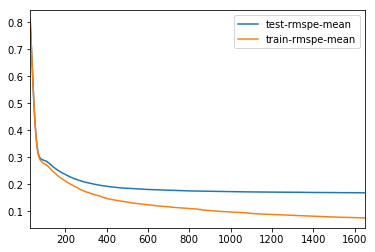

In [240]:
res.loc[30:,["test-rmspe-mean", "train-rmspe-mean"]].plot()
plt.show()

In [241]:
print(res.shape[0])

1651
